# 0. Requirements & Imports

In [237]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [238]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [239]:
import sentencepiece as spm

In [240]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import json
from tqdm import tqdm

# 1. Vocab

In [241]:
# vocab loading
vocab_file = "/content/drive/MyDrive/Colab_Notebooks/Paper_Implement/NLP Basic/kowiki_32000.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 너무 기나긴 날들의 연속이였습니다.",
  "감기 조심하세요."
]

# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)  # padding 추가해주는 method
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁너무', '▁기', '나', '긴', '▁날', '들의', '▁연속', '이', '였', '습니다', '.']
['▁감', '기', '▁조심', '하', '세요', '.']
torch.Size([2, 13])
tensor([[ 3305,    18,  2360,   376,    57,  1914,   721,   303,  1373,    20,
         12797,  5058,     7],
        [ 1303,    51, 19304,   276, 17092,     7,     0,     0,     0,     0,
             0,     0,     0]])


# 2. Embedding


Transformer의 Embedding은 'Input Embedding'과 Position Embedding' 두 가지를 합해서 사용합니다.
- Input Embedding

embedding은 입력 토큰을 vector 형태로 변환합니다.
1. inputs에 대한 embedding 값 input_embs를 구합니다.

In [242]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 13, 128])


위와 같이 inputs(2, 13)에 대한 embedding 값 input_embs([2, 13, 128]) shape을 갖습니다.

- Position Embedding

Position encoding 값을 구하기 위한 함수는 아래와 같습니다.
1. 각 position  별로 angle 값을 구합니다.
2. 구해진 angle 중 짝수 index의 값에 대한 sin 값을 구합니다.
3. 구해진 angle 중 홀수 index의 값에 대한 cos 값을 구합니다.

In [243]:
"""sinusoid position embedding"""
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn//2) / d_hidn) # d_hidn 값까지 순차적으로 들어와 position을 계산하게 됨.
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]
    
    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

아래와 같이 position encoding 값을 구하면 됩니다.

(64, 128)


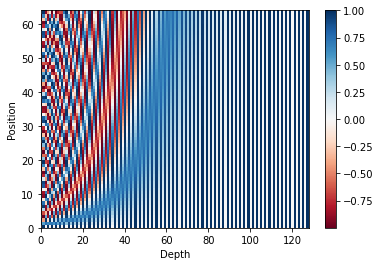

In [244]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print(pos_encoding.shape) # 모양 출력
plt.pcolormesh(pos_encoding, cmap="RdBu")
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

위에서 구한 결과를 그래프로 출력하면 아래와 같이 각 position 별로 다른 값을 갖는 다는 것을 확인할 수 있습니다.


아래 절차로 position embedding 값을 구합니다.

1. 위에서 구해진 position encoding 값을 이용해 position embedding을 생성합니다. 학습되는 값이 아니므로 freeze 옵션을 True로 설정합니다.
2. Inputs와 동일한 크기를 갖는 positions값을 구합니다.
3. input 값 중 pad(0)을 찾습니다.
4. positions 값 중 pad 부분은 0으로 변경합니다.
5. positions 값에 대항하는 embedding 값을 구합니다.

In [245]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

# range_nums = torch.arange(9).reshape(3,3)
# tensor([[0, 1, 2],
#         [3, 4, 5],
#         [6, 7, 8]])
positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(2, inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0) # input과 동일한 형태, 값이 0이면 True가 들어감.

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())


tensor([[ 3305,    18,  2360,   376,    57,  1914,   721,   303,  1373,    20,
         12797,  5058,     7],
        [ 1303,    51, 19304,   276, 17092,     7,     0,     0,     0,     0,
             0,     0,     0]])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 1,  2,  3,  4,  5,  6,  0,  0,  0,  0,  0,  0,  0]])
torch.Size([2, 13, 128])


inputs의 pad(0)위에 position의 값 또한 pad(0)의 값으로 변경되어 있음을 알 수 있습니다.

pos_embs(2, 6, 128)은 input_emb(2, 6,128)과 shape이 동일합니다.

위에서 구한 input_embs와 pos_embs를 더하면 transformer에 입력할 input이 됩니다.

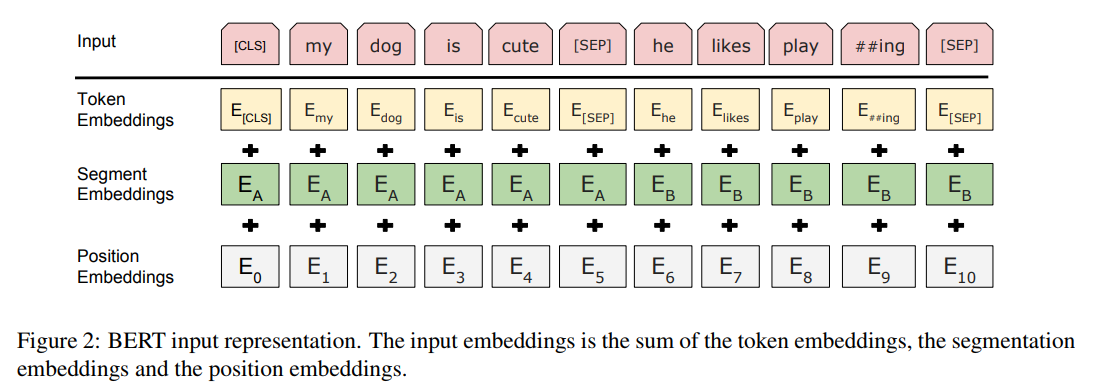

In [246]:
input_sums = input_embs + pos_embs
print(input_sums.shape)
print(input_sums)

torch.Size([2, 13, 128])
tensor([[[ 9.8823e-01, -1.4352e-01,  8.1777e-01,  ...,  2.7579e-02,
          -1.2162e+00,  1.2271e+00],
         [ 2.0993e+00, -2.7071e+00,  3.5065e+00,  ...,  1.8414e+00,
          -5.5616e-01,  5.6819e-01],
         [ 1.2391e+00, -1.4808e-01, -8.9943e-02,  ...,  7.1350e-01,
          -4.8446e-01, -2.4119e-03],
         ...,
         [ 9.4728e-01, -1.3232e+00, -7.7032e-02,  ..., -1.4561e+00,
           3.3879e-01,  2.2988e+00],
         [-1.1623e-01,  7.5585e-01, -1.4965e+00,  ...,  5.8791e-01,
           6.5636e-01,  3.5167e-01],
         [ 2.9397e-01,  1.1972e+00, -1.2149e+00,  ...,  7.9578e-01,
          -2.8543e-01,  7.8119e-01]],

        [[ 8.3186e-01,  3.9630e-01,  4.4394e-01,  ...,  1.7214e+00,
          -6.7265e-01,  1.8053e-01],
         [ 7.4601e-01, -1.4265e+00,  2.3425e+00,  ...,  1.0331e+00,
           2.6555e+00,  1.3012e+00],
         [ 2.7456e-01,  1.5241e-01, -5.5467e-01,  ...,  5.2774e-01,
           2.9193e-02,  2.2264e+00],
         ...,


# 3. Scaled Dot Product Attention

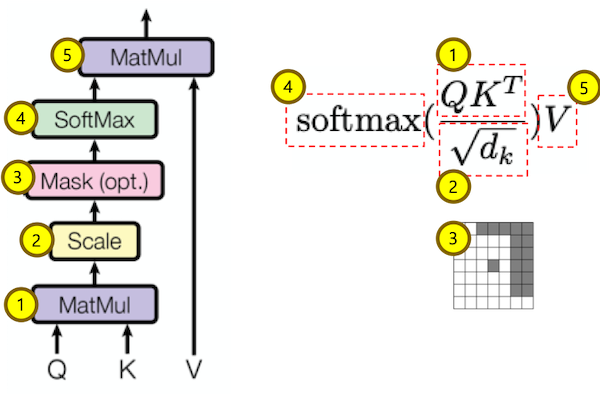

## 입력값
입력값은 Q(query), K(key), V(value) 그리고 attention mask로 구성되어 있습니다.
입력값 중 K, V는 같은 값이어야 합니다.
Q,K,V가 모두 동일한 경우는 self attention이라 합니다.

In [247]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask)

torch.Size([2, 13, 13])
tensor([[[False, False, False, False, False, False, False, False, False, False,
          False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False],
         [False, False, False, False, False, False, False, False, False, False,


attn_mask의 값은 pad(0) 부분만 True 입니다.

## Matmul Q, K-transpose

위 그림의 수식 중 1번 $Q * K^T$를 하는 코드 입니다.

In [248]:
scores = torch.matmul(Q, K.transpose(-1,-2))
print(scores.size()) 
print(scores[0]) # -> 각 단어 간에 가중치를 표현하는 테이블이 생성되었습니다.

torch.Size([2, 13, 13])
tensor([[218.5129,  63.9438,  51.8925,  72.6736,  51.1676,  57.4621,  67.1414,
          26.9126,  73.8095,  39.6321,  58.6663,  45.5363,  23.2906],
        [ 63.9438, 210.1931,  45.4352,  40.3846,  35.0877,  58.8166,  31.6523,
          46.5970,  40.4916,  35.4514,  41.6575,  36.1000,  45.1309],
        [ 51.8925,  45.4352, 151.5065,  50.1212,  40.7528,  61.3940,  40.5188,
          17.7020,  38.2283,  28.7127,  17.6492,  30.5813,  20.4328],
        [ 72.6736,  40.3846,  50.1212, 189.1732,  62.8953,  51.6916,  68.2850,
          28.0580,  47.9731,  38.3297,  29.6308,  47.3403,  41.1203],
        [ 51.1676,  35.0877,  40.7528,  62.8953, 156.0350,  56.7823,  84.7610,
          29.0590,  50.2730,  63.6881,  32.1527,  42.3661,  45.4614],
        [ 57.4621,  58.8166,  61.3940,  51.6916,  56.7823, 176.1637,  60.7485,
          27.0390,  50.4741,  19.2476,  46.8915,  28.1548,  59.8666],
        [ 67.1414,  31.6523,  40.5188,  68.2850,  84.7610,  60.7485, 232.2245,
   

각 단어상호간에 가중치를 표현하는 테이블이 생성되었습니다.

## Scale

위 그림의 수식 중 2번 k-dimension에 루트를 취한 값으로 나누느 코드입니다.

In [249]:
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 13, 13])
tensor([[27.3141,  7.9930,  6.4866,  9.0842,  6.3959,  7.1828,  8.3927,  3.3641,
          9.2262,  4.9540,  7.3333,  5.6920,  2.9113],
        [ 7.9930, 26.2741,  5.6794,  5.0481,  4.3860,  7.3521,  3.9565,  5.8246,
          5.0614,  4.4314,  5.2072,  4.5125,  5.6414],
        [ 6.4866,  5.6794, 18.9383,  6.2652,  5.0941,  7.6742,  5.0648,  2.2127,
          4.7785,  3.5891,  2.2062,  3.8227,  2.5541],
        [ 9.0842,  5.0481,  6.2652, 23.6467,  7.8619,  6.4614,  8.5356,  3.5073,
          5.9966,  4.7912,  3.7038,  5.9175,  5.1400],
        [ 6.3959,  4.3860,  5.0941,  7.8619, 19.5044,  7.0978, 10.5951,  3.6324,
          6.2841,  7.9610,  4.0191,  5.2958,  5.6827],
        [ 7.1828,  7.3521,  7.6742,  6.4614,  7.0978, 22.0205,  7.5936,  3.3799,
          6.3093,  2.4060,  5.8614,  3.5194,  7.4833],
        [ 8.3927,  3.9565,  5.0648,  8.5356, 10.5951,  7.5936, 29.0281,  7.4105,
          8.7904,  8.4475,  8.8053,  7.5517,  6.0191],
        [ 3.3641,  5.824

기존의 값에 비해 가중치 편차가 줄어들었습니다.
이는 단조 증가 함수에 대한 normalize입니다.

## Mask(Opt.)
위 그림 수식 중 3번 mask를 하는 코드입니다.

In [250]:
scores.masked_fill_(attn_mask, -1e9) 
print(scores.size())
print(scores[1])

torch.Size([2, 13, 13])
tensor([[ 2.1868e+01,  9.3400e+00,  4.7177e+00,  4.5461e+00,  5.4294e+00,
          6.0297e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 9.3400e+00,  2.8958e+01,  7.4006e+00,  9.2540e+00,  7.3430e+00,
          5.3171e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 4.7177e+00,  7.4006e+00,  2.0208e+01,  6.6333e+00,  3.5227e+00,
          8.6990e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 4.5461e+00,  9.2540e+00,  6.6333e+00,  2.0299e+01,  6.0810e+00,
          6.0803e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 5.4294e+00,  7.3430e+00,  3.5227e+00,  6.0810e+00,  2.5069e+01,
          5.4480e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09, -1.00

## Softmax
위 그림 수식 중 4번 Softmax를 하는 코드입니다.

In [251]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[1])

torch.Size([2, 13, 13])
tensor([[1.0000e+00, 3.6228e-06, 3.5612e-08, 2.9998e-08, 7.2562e-08, 1.3226e-07,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0203e-09, 1.0000e+00, 4.3430e-10, 2.7715e-09, 4.0999e-10, 5.4067e-11,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.8728e-07, 2.7396e-06, 9.9999e-01, 1.2718e-06, 5.6694e-08, 1.0037e-05,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.4415e-07, 1.5975e-05, 1.1621e-06, 9.9998e-01, 6.6897e-07, 6.6851e-07,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.9547e-09, 2.0025e-08, 4.3899e-10, 5.6689e-09, 1.0000e+00, 3.0101e-09,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.3374e-06, 6.5583e-07, 1.9300e-05, 1.4069e-06,

가중치가 확률로 변환 된 값을 볼 수 있습니다. mask를 한 부분이 모두 0이 되었습니다.

## MatMul attn_prob, V

위 그림 수식 중 5번 attn_prob * V(Value)를 하는 코드 입니다.

In [252]:
context = torch.matmul(attn_prob, V)

Q와 동일한 shape 값이 구해집니다. 이 값은 V값들이 attn_prob의 가중치를 이용해서 더해진 값입니다.

## Class 화
위 절차를 하나의 클래스 형태로 구성하면 아래와 같습니다.

In [253]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # Q, K를 각각 1개만 생각(Batch 생각 x)
        # Shape은 (max_seq, embedding dim) \cdot (embedding dim, max_seq)
        # 따라서 2차원 matrix로 0,1은 Q의 0번째 단어와 K의 1번째 단어와의 attention을 계산 된 상태임.
        # 그러면 여기서 0번째 단어와 1번째 단어가 연관성이 깊음을 어떻게 알 수 있는가? 이는 Backpropagation을 통해서 찾아가는 것(검증해야 함)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)

        attn_prob = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn_prob, V)

        return context, attn_prob

# 4. Multi-Head Attention


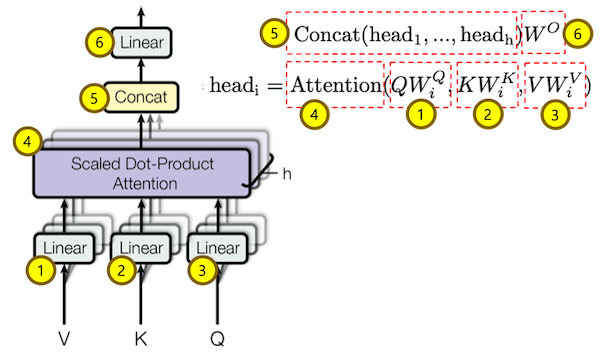

##  입력값

Q, K, V, attn_mask는 ScaledDotProductAttention과 동일합니다.

Head의 갯수는 2개 head의 dimension은 64입니다.

In [254]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

## Multi Head Q, K, V
위 그림 수식 중 1번 Q를 여러개의 head로 나누는 과정입니다.

In [255]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# Linear의 output이 n_head * d_head인 것에 집중해야한다.
# shape : (Batch size, n_seq, n_head * d_head)
q_s = W_Q(Q) 
# (batch size, n_seq, n_head, d_head)의 형태로 쪼갠다.
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.shape)
# 이때 위 과정을 shape 적으로만 생각하면 바로 q_s.view를 (batch size, n_head, n_seq, d_head)로 하면 될 듯 합니다.
# 하지만 이는 view와 transpose의 차이를 생각해야 합니다. 아예 표현 차원을 옮기는 것과 메모리의 주소 연결 방법을 옮기는 것은 다르기 때문입니다.
# 그럼 왜 이를 어기면 안될까요?
# 바로 Linear Layer를 통해 Q를 d라는 dimension을 가지는 n개의 Head를 만들도록 했는데, 후에 n * d의 크기를 가지는 head를 d의 단위로 쪼개서 사용할 것입니다.
# 그래서 처음에 view를 통해 붙어 있는 n_head, d_head를 분리 한후 
# 학습에 용이한 형태로 transpose한 것입니다.
q_s = q_s.transpose(1, 2)
print(q_s.size())

torch.Size([2, 13, 2, 64])
torch.Size([2, 2, 13, 64])


Q값이 head 단위로 나눠졌습니다.

위 과정을 한 줄로 표현하면 다음과 같습니다.

In [256]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1, 2)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1, 2)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1, 2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 13, 64]) torch.Size([2, 2, 13, 64]) torch.Size([2, 2, 13, 64])


Q, K, V 모두 Multi-Head로 나눠졌습니다.

Attention Mask도 Multi Head로 변경합니다.

In [257]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 13, 13])
torch.Size([2, 2, 13, 13])


## Attention
위 그림 수식 중에서 4번 Attnetion 과정입니다.

이전에 만든 'Scaled Dot Product Attention'을 사용합니다.

In [258]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 13, 64])
torch.Size([2, 2, 13, 13])


## Concat
위 그림 수식 중 5번 Concat 과정입니다.


In [259]:
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head) # (2 * 64 라서 128임 헷갈리지 말 것)
print(context.shape)

torch.Size([2, 13, 128])


## Linear
위 그림 수식 중 6번 Linear 과정입니다.

In [260]:
linear = nn.Linear(n_head * d_head, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 13, 128])


입력 Q와 동일한 shape을 가진 Multi Head Attention이 구해졌습니다.

## Class
위 절차를 하나의 클래스 형태로 구성하면 아래와 같습니다

In [261]:
"""Multi head attention"""
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        print(context.shape, attn_prob.shape, "context, attn_prob")
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)

        print(context.shape, "context, attn_prob")

        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

        return output, attn_prob

# 5. Masked Multi-Head Attention


Masked Multi-Head Attention은 Multi-Head Attnetion과 attention mask를 제외한 부분은 모두 동일합니다.

In [262]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1]) # max_seq보다 작은 sequnce에 대해서 padding을 위한 masking
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1]) # decoder의 inference를 위한 masking
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1]) # 

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True],
        [F

pad mask, decoder mask 그리고 이 둘을 합한 attention mask를 확인 할 수 있습니다.

## Multi-Head Attention
Multi-Head Attention과 동일하므로 위에서 선언한 MultiHeadAttention 클래스를 바로 호출 합니다.

In [263]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 2, 13, 64]) torch.Size([2, 2, 13, 13]) context, attn_prob
torch.Size([2, 13, 128]) context, attn_prob
torch.Size([2, 13, 128]) torch.Size([2, 2, 13, 13])


# 6. FeedForward


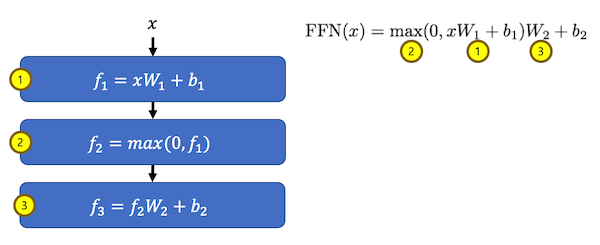

## f1(Linear)
위 그림 수식 중 1번 f1(Linear) 과정입니다.

In [264]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
linear1 = nn.Linear(d_hidn, d_hidn * 4)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(-1, -2))
lin_ff_1 = linear1(output)
print(ff_1.size())
print(lin_ff_1.size())

torch.Size([2, 512, 13])
torch.Size([2, 13, 512])


## Activation (relu or gelu)

위 그림 수식 중 2번 Activation (relu or gelu) 과정 입니다.
논문이 발표 될 당시는 relu를 사용하도록 되어 있었지만 이후 gelu를 사용할 때 더 성능이 좋다는 것이 발견되었습니다.

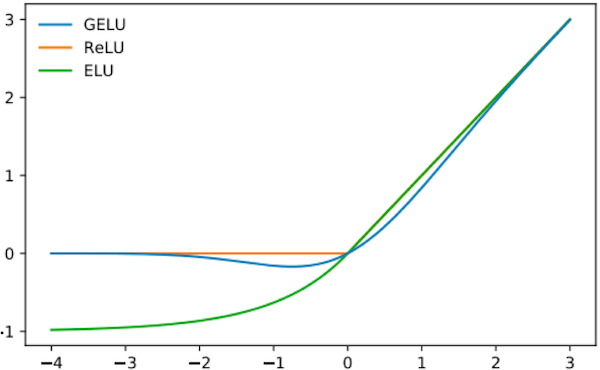

In [265]:
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)

## f3(Linear)
위 그림 수식 중 3번 f3 (Linear) 과정 입니다.

In [266]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(-1, -2)
print(ff_3.size())

torch.Size([2, 13, 128])


입력과 동일한 shape으로 변경된 결과를 확인 할 수 있습니다.

## Class
위 절차를 하나의 클래스 행태로 구성하면 아래와 같습니다.

In [267]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

# 7. Config

Transformer 모델에는 많은 설정이 필요합니다. 이 설정은 json 형태로 저장을 하고 이를 읽어서 처리하는 간단한 클래스입니다.

In [268]:
"""configuration json을 읽어들이는 class"""
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

작은 리소스에도 동작 가능하도록 여러 파라미터를 작게 설정했습니다. 가지고 계신 GPU가 여유가 있다면 파라미터를 키우면서 더 좋은 결과를 확인할 수 있습니다. 기본 파라미터는 [config.json](https://github.com/paul-hyun/transformer-evolution/blob/master/transformer/config.json)을 확인해주세요

In [269]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 32007, 'n_dec_vocab': 32007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


아래와 같은 파라미터 정보를 확인할 수 있습니다.

# 8. Comon Class

위에서 설명한 'Position Embedding', 'Multi-Head Attention', 'FeedForward' 등의 코드 입니다.

![image.png](https://paul-hyun.github.io/assets/2019-12-19/sinusoid_encoding_table.png)

Position Embedding의 초기값을 구하는 함수입니다.
1. 각 Position 별 hidden index별 angle 값을 구합니다.
2. hidden의 짝수 index의 angle값의 sin값을 적용합니다.
3. hidden의 홀수 index의 angle값의 cos값을 적용합니다.

In [270]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

## Attention Pad Mask


![image](https://paul-hyun.github.io/assets/2019-12-19/pad_mask.png)
Attention을 구할 때 Padding 부분을 제외하기 위한 Mask를 구하는 함수입니다.
1. K의 값 중에 Pad인 부분을 True로 변경합니다. (나머지는 False)
2. 구해진 값의 크기를 Q-len, K-len이 되도록 변경합니다.

In [271]:
"""attention pad mask"""
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(batch_size,len_q, len_k)
    return pad_attn_mask

## Attention Decoder Mask


![image](https://paul-hyun.github.io/assets/2019-12-19/decoder_mask.png)

Decode의 'Masked Multi Head Attention'에서 사용할 Mask를 구하는 함수입니다. 현재 단어와 이전 단어는 볼 수 있고 다음 단어는 볼 수 없도록 Masking합니다.
1. 모든 값이 1인 Q-len, K-len 테이블을 생성합니다.
2. 대각선을 기준으로 아래쪽을 0으로 만듭니다.

In [272]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of maxtrix
    return subsequent_mask

## Scaled Dot Product Attention

![image](https://paul-hyun.github.io/assets/2019-12-19/scale_dot_product_attention.png)
Scaled Dot Product Attention을 구하는 클래스입니다.
1. Q * K.transpose를 구합니다.
2. K-dimension에 루트를 취한 값으로 나눠 줍니다.
3. Mask를 적용합니다.
4. Softmax를 취해 각 단어의 가중치 확률분포 attn_prob를 구합니다.
5. attn_prob * V를 구합니다. 구한 값은 Q에 대한 V의 가중치 벡터합입니다.


In [273]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2))
        scores = scores.mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

## Multi-Head Attention

![iamge](https://paul-hyun.github.io/assets/2019-12-19/multi_head_attention.png)


Mutli-Head Attention을 구하는 클래스입니다.
1. Q*W_Q를 한후 multi-head로 나눕니다.
2. K*W_K를 한후 multi-head로 나눕니다.
3. V*W_V를 한후 multi-head로 나눕니다.
4. ScaledDotProductAttention 클래스를 이용해 각 head 별 Attention을 구합니다.
5. 여러 개의 Head를 1개로 합칩니다.
6. Linear를 취해 최종 Multi-Head Attention값을 구합니다.


In [274]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## FeedForward

![image](https://paul-hyun.github.io/assets/2019-12-19/feed-forward.png)

FeedForward를 처리하는 클래스입니다.
1. Linear를 실행하여 shape을 d_ff(hidden*4) 크기로 키웁니다.
2. activation 함수(relu or gelu)를 실행합니다.
3. Linear를 실행하여 shape을 hidden 크기로 줄입니다.

In [275]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.conv1(inputs.transpose(1, 2))
        output = self.active(output)
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

# 9. Encoder


![image](https://paul-hyun.github.io/assets/2019-12-19/encoder.png)

## Encoder Layer

Encoder에서 루프를 돌며 처리할 수 있도록 EncoderLayer를 정의하고 여러 개 만들어서 실행합니다.
1. Multi-Head Attention을 수행합니다. Q, K V가 모두 동일한 값을 사용하는 self-attention입니다.
2. 1번의 결과와 input(reisdual)을 더한 후 LayerNorm을 실행합니다.
3. 2번의 결과를 입력으로 FeedForward를 실행합니다.
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.


In [276]:
"""encoder layer"""
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)

    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

## Encoder

Encoder 클래스입니다.
1. 입력에 대한 Position 값을 구합니다.
2. Input Embedding과 Position Embedding을 구한 후 더합니다.
3. 입력에 대한 attention pad mask를 구합니다.
4. for loop를 돌며 layer를 실행합니다.

  layer의 입력은 이전 layer의 출력 값입니다.

In [277]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True) # Freeze True

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

# 10. Decoder

![image](https://paul-hyun.github.io/assets/2019-12-19/decoder.png)

## Decoder Layer

Decoder에서 루프를 돌며 처리할 수있도록 DecoderLayer를 정의하고 여러 개 만들어서 실행합니다.
1. Multi-Head Attention을 수행합니다.
  Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.
3. Encoder-Decoder Multi-Head Attention을 수행합니다.
  Q :2번의 결과
  K, V: Encoder의 결과
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.
5. 4번의 결과를 입력으로 FeedForward를 실행합니다.
6. 5번의 결과와 4번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

In [278]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

## Decoder

Decoder 클래스 입니다.

1. 입력에 대한 Position 값을 구합니다.
2. Input Embedding과 Position Embedding을 구한 후 더합니다. 
3. 입력에 대한 attention pad mask를 구합니다.
4.. 입력에 대한 decoder attention mask를 구합니다. 
5. attention pad mask와 decoder attention mask 중 1곳이라도 mask되어 있는 부분인 mask 되도록 attention mask를 구합니다.
6. Q(decoder input), K(encoder output)에 대한 attention mask를 구합니다. 
7. for 루프를 돌며 각 layer를 실행합니다. 
  layer의 입력은 이전 layer의 출력 값 입니다.


In [279]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        # print(dec_inputs, dec_inputs.shape, "-dec_inputs")
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions) #  decoder output Embedding
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad) # Decoder의 Input Sentence Self-Attention을 위한 Masking Matrix를 구함.
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs) # Decoder의 Input에 맞는 상삼각행렬에 Masking Matrix 생성.
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0) # 구현을 위한 torch.gt
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad) # Encoder의 K, V와 상삼각행렬이 Masking된 Matrix와의 pad masking 구하기.

        # 들어갈 때 필요한 Input들 준비.

        print(dec_outputs, dec_outputs.shape)
        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            print(dec_outputs, dec_outputs.shape)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

# 11. Transformer

Transformer 클래스입니다.

1. Encoder Input을 입력으로 Encoder를 실행합니다.
2. Encoder Output과 Decoder Input을 입력으로 Decoder를 실행합니다.

In [280]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs


# Naver 영화리뷰 감정분석 데이터 전처리 하기

Naver sentiment movie corpus에서 다운로드 하거나 아래 명령으로 다운로드 하세요.

- 학습데이터: ratings_train.txt
- 평가데이터: ratings_test.txt

In [281]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2022-07-18 05:30:19--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.4’

ratings_train.txt.4 100%[===================>]  13.95M  --.-KB/s    in 0.07s   

2022-07-18 05:30:20 (195 MB/s) - ‘ratings_train.txt.4’ saved [14628807/14628807]

--2022-07-18 05:30:20--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Sa

## 2. Vocab

In [282]:
# vocab loading
vocab_file = "/content/drive/MyDrive/Colab_Notebooks/Paper_Implement/NLP Basic/kowiki_32000.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

## 3. 데이터 전처리

다운로드된 데이터를 vocab으로 미리 tokenize해서 json형태로 저장 해 놓습니다.
tokenize를 미리하지 않고 training시에 할 경우 처리시간이 매번 소요 되므로 이를 효과적으로 줄이기 위함 입니다.

In [283]:
""" train data 준비 """
def prepare_train(vocab, infile, outfile):
    df = pd.read_csv(infile, sep="\t", engine="python")
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["document"]
            if type(document) != str:
                continue
            instance = { "id": row["id"], "doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

In [284]:
prepare_train(vocab, "./ratings_train.txt", "./ratings_train.json")
prepare_train(vocab, "./ratings_test.txt", "./ratings_test.json")

# 11. Model

Transformer 클래스를 이용하여 Naver 영화리뷰 감정분석 분류 모델 클래스를 아래와 같이 정의 합니다.

1. Encoder input과 Decoder input을 입력으로 Transformer 모델을 실행 합니다.   
2. Transformer 출력의 max값을 구합니다. 
3. Linear를 실행하여 최종 예측 결과를 만듭니다.

In [285]:
""" naver movie classfication """
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        # (bs, n_output)
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

# 12. Dataset

## Dataset

Naver 영화리뷰 감정분석 데이터 셋 입니다.

1. 입력 파일로 부터 ‘label’을 읽어 들입니다.
2. 입력 파일로 부터 ‘doc’ token을 읽어 숫자(token id)로 변경 합니다. 
3. Decoder 입력은 ‘[BOS]’로 고정 합니다.

In [286]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

## collate_fn

배치단위로 데이터 처리를 위한 collate_fn 입니다.

1. Encoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가 합니다.
  
  padding은 Sentencepiece를 활용해 Vocab 만들기에서 ‘–pad_id=0’옵션으로 지정한 값 입니다.
2. Decoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가 합니다. 
3. Label은 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다.

In [287]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

## DataLoader

위에서 정의한 DataSet과 collate_fn을 이용해 학습용(train_loader), 평가용(test_loader) DataLoader를 만듭니다.

In [288]:
batch_size = 128
train_dataset = MovieDataSet(vocab, "./ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, "./ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading ./ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 31208.83 lines/s]


In [289]:
train_dataset[0]

(tensor(0),
 tensor([  203, 18074,     7,     7, 10019,  6058,   888,    57,   367,   489,
          4152]),
 tensor([2]))

# Evaluate

학습된 MovieClassification 모델의 성능을 평가하기 위한 함수 입니다. 평가는 정확도(accuracy)를 사용 했습니다.

1. Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다. 
2. 1번의 결과 중 첫 번째 값이 예측 logits 입니다. 
3. logits의 최대값의 index를 구합니다. 
4. 3번에게 구한 값과 labels의 값이 같은지 비교 합니다. 

In [290]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

# Train

MovieClassification 모델을 학습하기 위한 함수 입니다.

1. Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다.
2. 1번의 결과 중 첫 번째 값이 예측 logits 입니다. 
3. logits 값과 labels의 값을 이용해 Loss를 계산합니다. 
4. loss, optimizer를 이용해 학습합니다.

In [291]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

학습을 위한 추가적인 내용을 선언 합니다.

1. GPU 사용 여부를 확인합니다. 
2. 출력 값 개수를 정의 합니다. (부정(0), 긍정(1) 2가지입니다.)
3. learning_rate 및 학습 epoch를 선언 합니다.

In [292]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 32007, 'n_dec_vocab': 32007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


위에서 선언된 내용을 이용해 학습을 실행하는 절차 입니다.

1. MovieClassification을 생성합니다.
2. MovieClassification이 GPU 또는 CPU를 지원하도록 합니다. 
3. loss 함수를 선언 합니다. 
4. optimizer를 선언 합니다. 
5. 각 epoch 마다 학습을 합니다. 
6. 각 epoch 마다 평가를 합니다. 

In [ ]:
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

Train 0:   0%|          | 0/1172 [00:00<?, ?it/s]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6758,  0.0277,  0.3740,  ...,  0.4225, -0.7010, -0.0366]],

        [[-0.8722, -0.1376,  0.1089,  ...,  0.7270, -0.7077,  0.3298]],

        [[-1.1084, -0.6009,  0.4263,  ...,  0.8538, -0.6389, -0.0386]],

        ...,

        [[-1.1844, -0.0084,  0.3790,  ...,  0.8474, -0.7045, -0.2441]],

        [[-0.9570, -0.2629,  0.5036,  ...,  0.9329, -0.3366, -0.0562]],

        [[-0.9385,  0.1160,  0.6006,  ...,  0.5347, -0.5610,  0.0060]]],
       device='cuda:0'

Train 0:   0%|          | 2/1172 [00:00<04:51,  4.02it/s, Loss: 0.958 (0.910)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8235, -0.1772,  0.7979,  ...,  1.1340, -0.4340,  0.1230]],

        [[-0.9238,  0.0079,  0.5356,  ..., -0.0276, -0.6225, -0.2101]],

        [[-1.0129,  0.2615,  0.3627,  ...,  0.9723, -0.4447, -0.0071]],

        ...,

        [[-1.2950, -0.2992,  0.3036,  ...,  0.9062, -0.7959,  0.3353]],

        [[-0.9451,  0.1024,  0.8208,  ...,  1.2515, -0.6478,  0.8195]],

        [[-0.8873,  0.1013,  0.5001,  ...,  0.8855, -0.5539, -0.1845]]],
       device='cuda:0'

Train 0:   0%|          | 3/1172 [00:00<04:35,  4.24it/s, Loss: 0.849 (0.890)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4584,  0.0968,  0.9727,  ...,  1.0087, -0.6483, -0.1297]],

        [[-0.9337, -0.2472,  0.3469,  ...,  0.3180, -0.4006, -0.0817]],

        [[-0.8463, -0.0737,  0.5044,  ...,  0.0620, -0.5846,  0.6165]],

        ...,

        [[-0.8918, -0.3221,  0.4808,  ...,  0.7818, -0.6116,  0.6048]],

        [[-0.2367, -0.1175,  0.5080,  ...,  0.9531, -0.7342, -0.1315]],

        [[-1.1282,  0.0085,  0.5653,  ...,  0.4076, -0.4197, -0.0171]]],
       device='cuda:0'

Train 0:   0%|          | 4/1172 [00:00<04:31,  4.31it/s, Loss: 0.729 (0.849)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2165, -0.0655,  0.4546,  ...,  1.2853, -0.4618, -0.0947]],

        [[-1.2984, -0.0667,  0.3488,  ...,  1.0879, -0.5972,  0.0016]],

        [[-0.4074,  0.3242,  0.8047,  ...,  1.0395, -0.5894, -0.1925]],

        ...,

        [[-0.7247,  0.0761,  0.7836,  ...,  1.0438, -0.4713, -0.0551]],

        [[-0.4019, -0.1012,  0.8952,  ...,  0.2552, -0.7697, -0.1940]],

        [[-1.1629, -0.2706,  0.4980,  ...,  1.2844, -0.7382, -0.0384]]],
       device='cuda:0'

Train 0:   0%|          | 5/1172 [00:01<04:30,  4.32it/s, Loss: 0.765 (0.832)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2790, -0.1203,  0.3159,  ...,  1.1103, -0.7150,  0.2439]],

        [[-1.1567,  0.0086,  0.4546,  ...,  1.0024, -0.5772, -0.2839]],

        [[-1.2201,  0.0768,  0.5143,  ...,  0.3455, -0.4990,  0.5709]],

        ...,

        [[-0.3442,  0.1749,  0.4672,  ...,  1.1136, -0.5886, -0.1393]],

        [[-1.1829,  0.0180,  0.4271,  ...,  1.1134, -0.4946, -0.0744]],

        [[-0.9423,  0.0565,  0.6663,  ...,  1.0112, -0.5761, -0.0399]]],
       device='cuda:0'

Train 0:   1%|          | 6/1172 [00:01<04:26,  4.37it/s, Loss: 0.818 (0.830)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1522, -0.0489,  0.4017,  ...,  1.1729, -0.5146, -0.0180]],

        [[-1.0653, -0.3595,  0.6404,  ...,  0.9077, -0.9019, -0.3612]],

        [[-0.6251, -0.2259,  0.3698,  ...,  1.0825, -0.8796, -0.1167]],

        ...,

        [[-0.3983, -0.0879,  0.2973,  ...,  1.2599, -0.4176, -0.2222]],

        [[-1.0609, -0.0229,  0.2845,  ...,  1.1525, -0.7707, -0.2113]],

        [[-1.4166,  0.1303,  0.5151,  ...,  1.3298, -0.6834, -0.1802]]],
       device='cuda:0'

Train 0:   1%|          | 7/1172 [00:01<04:22,  4.44it/s, Loss: 0.703 (0.812)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7657,  0.0539,  0.4038,  ...,  0.7361, -0.8711, -0.0517]],

        [[-1.1255,  0.0426,  0.5352,  ...,  1.3287, -0.4585, -0.2458]],

        [[-0.7514, -0.0694,  0.4320,  ...,  0.8074, -0.6187, -0.0296]],

        ...,

        [[-0.8822, -0.2984,  0.5614,  ...,  1.0917, -0.3615,  0.0312]],

        [[-0.8596, -0.2337,  0.9115,  ...,  0.5471, -0.5457,  0.2424]],

        [[-1.1367,  0.1955,  0.4138,  ...,  1.3190, -0.5657,  0.7850]]],
       device='cuda:0'

Train 0:   1%|          | 8/1172 [00:01<04:19,  4.49it/s, Loss: 0.691 (0.797)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3796,  0.0363,  0.2897,  ...,  1.1189, -0.7270, -0.1642]],

        [[-0.7128,  0.0380,  0.7906,  ...,  1.1226, -0.7496, -0.1124]],

        [[-1.3737, -0.2487,  0.3406,  ...,  1.1773, -0.6860,  0.5498]],

        ...,

        [[-1.1721,  0.1031,  0.5535,  ...,  0.8537, -0.6554, -0.2229]],

        [[-0.9082, -0.1232,  0.7477,  ...,  0.8721, -0.5748,  0.0462]],

        [[-0.9904,  0.0863,  0.4356,  ...,  0.9379, -0.3831, -0.2663]]],
       device='cuda:0'

Train 0:   1%|          | 9/1172 [00:02<04:19,  4.47it/s, Loss: 0.707 (0.787)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0911,  0.0346,  0.3343,  ...,  1.0258, -0.4539,  0.5693]],

        [[-1.1484, -0.1415,  0.4838,  ...,  0.9873, -0.4643, -0.3229]],

        [[-1.1142,  0.1354,  0.4315,  ...,  0.2065, -0.5099,  0.3828]],

        ...,

        [[-1.0428, -0.0758,  0.4127,  ...,  1.1865, -0.4403,  0.6235]],

        [[-1.2360, -0.0250,  0.4575,  ...,  1.3445, -0.5489, -0.1700]],

        [[-1.1639, -0.0308,  0.6614,  ...,  1.1227, -0.5542, -0.3190]]],
       device='cuda:0'

Train 0:   1%|          | 10/1172 [00:02<04:22,  4.43it/s, Loss: 0.691 (0.777)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2316, -0.0858,  0.4796,  ...,  1.0167, -0.6000,  0.6614]],

        [[-1.0590,  0.1489,  0.4837,  ...,  1.3055, -0.6968, -0.2145]],

        [[-1.2532, -0.0885,  0.3927,  ...,  1.1222, -0.5097, -0.1749]],

        ...,

        [[-0.8379,  0.0071,  0.4243,  ...,  0.1771, -0.4729, -0.2624]],

        [[-0.7194,  0.0059,  0.8766,  ...,  1.0019, -0.3323,  0.6054]],

        [[-1.0123, -0.0410,  0.8710,  ...,  0.8211, -0.5861, -0.0596]]],
       device='cuda:0'

Train 0:   1%|          | 11/1172 [00:02<04:21,  4.45it/s, Loss: 0.690 (0.769)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0724e+00, -1.0327e-03,  4.0588e-01,  ...,  1.0725e+00,
          -8.4012e-01, -3.2294e-01]],

        [[-1.0815e+00, -6.2401e-02,  5.4852e-01,  ...,  1.1184e+00,
          -9.1088e-01, -3.1039e-01]],

        [[-1.0889e+00, -3.6286e-02,  5.2608e-01,  ...,  8.3210e-01,
          -5.3373e-01, -1.9656e-01]],

        ...,

        [[-1.1945e-01,  8.6783e-02,  3.5960e-01,  ...,  1.1248e+00,
          -7.9751e-01,  6.2703e-01]],

        [[-1.2044e+00, -2.0622e-

Train 0:   1%|          | 12/1172 [00:02<04:21,  4.44it/s, Loss: 0.705 (0.764)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9564,  0.1866,  0.5515,  ...,  1.1795, -0.8971, -0.5155]],

        [[-0.4509, -0.4378,  0.7086,  ...,  0.5634, -0.9070,  0.5588]],

        [[-0.9977,  0.1851,  0.5380,  ...,  0.9921, -0.4821, -0.0750]],

        ...,

        [[-0.5380,  0.3198,  0.4247,  ...,  1.0482, -0.8714, -0.3145]],

        [[-0.7379,  0.0982,  0.2597,  ...,  0.7510, -0.7375, -0.1281]],

        [[-0.3376,  0.0201,  0.5124,  ...,  0.6860, -0.6774, -0.4969]]],
       device='cuda:0'

Train 0:   1%|          | 13/1172 [00:02<04:15,  4.54it/s, Loss: 0.690 (0.758)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3470,  0.4322,  0.5532,  ...,  1.2261, -0.4744, -0.4896]],

        [[-0.7606,  0.1348,  0.8120,  ...,  0.4986, -0.5043, -0.2219]],

        [[-1.3646,  0.0057,  0.4318,  ...,  1.0846, -0.5972, -0.1501]],

        ...,

        [[-0.3934, -0.1784,  0.7156,  ...,  0.5971, -0.4729, -0.0067]],

        [[-0.8532, -0.2357,  0.2862,  ...,  0.8765, -0.5977,  0.1797]],

        [[-0.9067, -0.3130,  0.5444,  ...,  1.1680, -0.7090, -0.2489]]],
       device='cuda:0'

Train 0:   1%|          | 14/1172 [00:03<04:16,  4.52it/s, Loss: 0.700 (0.754)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2015,  0.0592,  0.4661,  ...,  1.0912, -0.5527, -0.0119]],

        [[-1.0037, -0.0359,  0.4468,  ...,  1.0249, -0.6295, -0.0745]],

        [[-0.9380, -0.2640,  0.4257,  ...,  1.2225, -0.6068,  0.2100]],

        ...,

        [[-1.1406, -0.1398,  0.6344,  ...,  0.9523, -0.8470, -0.1048]],

        [[-1.0015,  0.0604,  0.8185,  ...,  0.9031, -0.4406, -0.2746]],

        [[-0.8469,  0.3890,  0.4970,  ...,  0.1673, -0.6362,  0.0048]]],
       device='cuda:0'

Train 0:   1%|▏         | 15/1172 [00:03<04:12,  4.59it/s, Loss: 0.683 (0.749)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8563,  0.0505,  0.3025,  ...,  0.3357, -0.5182, -0.2294]],

        [[-0.3642, -0.1278,  0.3628,  ...,  0.9658, -0.3154, -0.2616]],

        [[-0.3706,  0.0507,  0.4462,  ...,  1.1368, -0.4668, -0.2373]],

        ...,

        [[-1.5331, -0.1872,  0.1560,  ...,  0.7473, -0.4756,  0.3363]],

        [[-0.5433, -0.0124,  0.5954,  ...,  1.1465, -0.3646,  0.7135]],

        [[-0.9981, -0.0262,  0.6046,  ...,  1.2700, -0.7906, -0.1566]]],
       device='cuda:0'

Train 0:   1%|▏         | 16/1172 [00:03<04:09,  4.63it/s, Loss: 0.695 (0.746)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9947,  0.1172,  0.3722,  ...,  0.7885, -0.6023,  0.0324]],

        [[-1.1972,  0.0272,  0.7950,  ...,  1.2298, -0.5079, -0.2042]],

        [[-1.1202, -0.0904,  1.0125,  ...,  0.9143, -0.9090, -0.4482]],

        ...,

        [[-1.0789,  0.0907,  0.4194,  ...,  1.2983, -0.4045, -0.1149]],

        [[-1.0122, -0.0719,  0.3936,  ...,  0.4569, -0.4653, -0.2009]],

        [[-0.9056,  0.1122,  0.5357,  ...,  1.2078, -0.5103, -0.1172]]],
       device='cuda:0'

Train 0:   1%|▏         | 17/1172 [00:03<04:07,  4.66it/s, Loss: 0.690 (0.743)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1005e+00, -5.0607e-02,  3.3386e-01,  ...,  3.0423e-01,
          -5.4471e-01, -2.0436e-01]],

        [[-1.1030e+00,  3.2389e-02,  5.3693e-01,  ...,  1.0463e+00,
          -4.8196e-01, -2.1728e-01]],

        [[-1.0627e+00, -2.3870e-01,  3.1449e-01,  ...,  1.1852e+00,
          -4.0894e-01, -1.8387e-02]],

        ...,

        [[-1.2067e+00, -6.5999e-02,  7.0633e-01,  ...,  5.6948e-01,
          -7.3449e-01, -3.9557e-04]],

        [[-1.0501e+00, -2.1931e-

Train 0:   2%|▏         | 18/1172 [00:04<04:08,  4.65it/s, Loss: 0.679 (0.739)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0205, -0.1207,  0.4730,  ...,  0.9766, -0.7593, -0.1917]],

        [[-1.1440, -0.0233,  0.6450,  ...,  0.8808, -0.7603, -0.3843]],

        [[-1.2266,  0.0370,  0.2985,  ...,  1.0930, -0.7193, -0.1859]],

        ...,

        [[-1.2877, -0.1648,  0.4086,  ...,  1.0535, -0.6363,  0.3680]],

        [[-1.0245,  0.1154,  0.9110,  ...,  1.1418, -0.4397, -0.1054]],

        [[-1.0654,  0.0434,  0.5284,  ...,  0.7148, -0.7067, -0.2215]]],
       device='cuda:0'

Train 0:   2%|▏         | 19/1172 [00:04<04:09,  4.62it/s, Loss: 0.690 (0.736)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1146, -0.1060,  0.5291,  ...,  1.1457, -0.6127, -0.3729]],

        [[-0.7948, -0.1246,  0.5698,  ...,  1.1724, -0.4773, -0.2505]],

        [[-0.9990,  0.0231,  0.0768,  ...,  0.8717, -0.5608,  0.0347]],

        ...,

        [[-1.2211,  0.0526,  0.6145,  ...,  0.6047, -0.6849, -0.2074]],

        [[-1.2321, -0.3163,  0.7480,  ...,  1.0372, -0.7422, -0.3198]],

        [[-0.9553,  0.0175,  0.1328,  ...,  0.4041, -0.6090, -0.3091]]],
       device='cuda:0'

Train 0:   2%|▏         | 20/1172 [00:04<04:15,  4.51it/s, Loss: 0.660 (0.733)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1627,  0.1316,  0.5864,  ...,  0.2955, -0.5538, -0.2302]],

        [[-1.0874, -0.0990,  0.7357,  ...,  0.5463, -0.7397,  0.6020]],

        [[-0.9742, -0.0834,  0.5054,  ...,  0.9804, -0.5413, -0.2162]],

        ...,

        [[-1.2821, -0.0743,  0.3383,  ...,  1.2278, -0.4562, -0.4399]],

        [[-0.7541,  0.1876,  0.2959,  ...,  0.9446, -0.6640,  0.0058]],

        [[-0.9466, -0.0201,  0.8605,  ...,  1.2332, -0.6519,  0.6964]]],
       device='cuda:0'

Train 0:   2%|▏         | 21/1172 [00:04<04:10,  4.59it/s, Loss: 0.677 (0.730)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0903, -0.0050,  0.4011,  ...,  1.3746, -0.7261, -0.1960]],

        [[-0.7472, -0.1519,  0.5848,  ...,  1.3906, -0.5575, -0.0185]],

        [[-1.2756, -0.0438,  0.3692,  ...,  1.0308, -0.7034, -0.1855]],

        ...,

        [[-0.5595, -0.0081,  1.0323,  ...,  1.1445, -1.0439, -0.2288]],

        [[-1.2610,  0.0765,  0.9401,  ...,  1.0921, -0.5669, -0.5178]],

        [[-0.7298, -0.0497,  0.4381,  ...,  1.1457, -0.5842, -0.0686]]],
       device='cuda:0'

Train 0:   2%|▏         | 22/1172 [00:04<04:10,  4.59it/s, Loss: 0.691 (0.728)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1548,  0.0288,  0.6851,  ...,  1.1763, -0.7122, -0.3038]],

        [[-1.2777,  0.1061,  0.3877,  ...,  1.2181, -0.7053, -0.0724]],

        [[-0.7619,  0.3030,  0.8020,  ...,  0.9032, -0.5580, -0.3045]],

        ...,

        [[-1.3164, -0.0218,  0.7058,  ...,  1.2155, -0.2610, -0.2245]],

        [[-1.1495,  0.0916,  0.4235,  ...,  0.9781, -0.6342, -0.0638]],

        [[-1.1416,  0.1023,  0.6048,  ...,  0.3946, -0.7123, -0.0728]]],
       device='cuda:0'

Train 0:   2%|▏         | 23/1172 [00:05<04:06,  4.65it/s, Loss: 0.668 (0.726)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5974, -0.3729,  0.8534,  ...,  0.4207, -0.7054, -0.2920]],

        [[-1.3837, -0.1038,  0.4621,  ...,  1.1339, -0.5071, -0.2843]],

        [[-0.9052, -0.1407,  0.4107,  ...,  1.1647, -0.6761,  0.1790]],

        ...,

        [[-1.2344, -0.3764,  0.5653,  ...,  1.1776, -0.6553, -0.1573]],

        [[-1.3925, -0.0727,  0.3626,  ...,  1.3559, -0.5788, -0.0986]],

        [[-0.9519,  0.4471,  0.2737,  ...,  0.8544, -0.7718, -0.0055]]],
       device='cuda:0'

Train 0:   2%|▏         | 24/1172 [00:05<04:06,  4.66it/s, Loss: 0.666 (0.723)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0922,  0.1723,  0.2504,  ...,  0.1275, -0.5555, -0.3182]],

        [[-1.2406,  0.1279,  0.4031,  ...,  1.2676, -0.5123, -0.1263]],

        [[-1.2010,  0.1122,  0.4822,  ...,  1.3140, -0.7070,  0.6606]],

        ...,

        [[-1.0623,  0.0196,  0.4501,  ...,  1.4198, -0.6637, -0.2109]],

        [[-1.0017,  0.1612,  0.4167,  ...,  1.1275, -0.5941, -0.2444]],

        [[-1.2124,  0.1407,  0.7182,  ...,  0.4708, -0.4246, -0.0967]]],
       device='cuda:0'

Train 0:   2%|▏         | 25/1172 [00:05<04:06,  4.65it/s, Loss: 0.663 (0.721)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5733,  0.0709,  0.4335,  ...,  1.2261, -0.6106,  0.7644]],

        [[-0.9898, -0.0036,  0.8730,  ...,  1.1973, -0.3688,  0.1683]],

        [[-1.4293, -0.2964,  0.6240,  ...,  1.1680, -0.8286,  0.2173]],

        ...,

        [[-0.6565,  0.0829,  0.4665,  ...,  0.7262, -0.6700, -0.4188]],

        [[-0.5256, -0.0315,  0.5537,  ...,  1.5245, -0.7341, -0.0675]],

        [[-1.1018, -0.1099,  0.6691,  ...,  1.0162, -0.5541, -0.1126]]],
       device='cuda:0'

Train 0:   2%|▏         | 26/1172 [00:05<04:08,  4.60it/s, Loss: 0.669 (0.719)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0873,  0.0014,  0.5704,  ...,  1.4217, -0.7238,  0.8084]],

        [[-0.6107,  0.0444,  0.5228,  ...,  1.0506, -0.4871, -0.2305]],

        [[-0.3511,  0.0861,  0.2369,  ...,  1.0822, -0.7192, -0.1238]],

        ...,

        [[-1.2136, -0.0786,  0.5068,  ...,  1.2444, -0.4646, -0.1886]],

        [[-1.0979,  0.2098,  0.7213,  ...,  1.2627, -0.8050,  0.6148]],

        [[-1.2857, -0.1083,  0.4113,  ...,  1.3305, -0.3940, -0.0976]]],
       device='cuda:0'

Train 0:   2%|▏         | 27/1172 [00:06<04:16,  4.46it/s, Loss: 0.688 (0.718)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2654,  0.0536,  0.3868,  ...,  1.0469, -0.7987, -0.1846]],

        [[-1.0276,  0.2843,  0.9135,  ...,  1.4273, -0.5689, -0.1045]],

        [[-1.4540, -0.2345,  0.3175,  ...,  1.2112, -0.7754,  0.5251]],

        ...,

        [[-1.2603, -0.0836,  0.6703,  ...,  1.3860, -0.6706, -0.2392]],

        [[-1.1598,  0.1804,  0.4640,  ...,  1.3397, -0.7194, -0.1128]],

        [[-0.5984, -0.1967,  0.3071,  ...,  0.9345, -0.7544,  0.4986]]],
       device='cuda:0'

Train 0:   2%|▏         | 28/1172 [00:06<04:11,  4.54it/s, Loss: 0.676 (0.716)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1558,  0.3693,  0.5215,  ...,  0.8153, -0.6591, -0.1780]],

        [[-0.6970, -0.3454,  0.6953,  ...,  0.4936, -0.4779,  0.6305]],

        [[-0.7614,  0.2394,  0.8556,  ...,  0.3262, -0.6797,  0.2212]],

        ...,

        [[-1.2647,  0.1672,  0.4898,  ...,  1.1559, -0.5815,  0.0740]],

        [[-1.0521, -0.0642,  0.3768,  ...,  1.1018, -0.6597, -0.2446]],

        [[-0.9309,  0.2134,  0.2988,  ...,  0.8700, -0.6480, -0.0496]]],
       device='cuda:0'

Train 0:   2%|▏         | 29/1172 [00:06<04:10,  4.57it/s, Loss: 0.717 (0.716)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8602,  0.2266,  0.6629,  ...,  1.1617, -0.9836,  0.1629]],

        [[-1.2540,  0.0216,  0.2792,  ...,  0.9895, -0.6463, -0.0357]],

        [[-0.7632,  0.2761,  0.5612,  ...,  1.0106, -0.8168,  0.1220]],

        ...,

        [[-0.9734, -0.1043,  0.9251,  ...,  1.0501, -0.7835, -0.0768]],

        [[-1.2087, -0.0983,  0.5065,  ...,  1.2287, -0.5199, -0.0119]],

        [[-1.0511, -0.0159,  0.8959,  ...,  1.2408, -0.9571, -0.2023]]],
       device='cuda:0'

Train 0:   3%|▎         | 30/1172 [00:06<04:09,  4.58it/s, Loss: 0.685 (0.715)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7877,  0.2070,  0.3822,  ...,  0.8412, -0.8626,  0.7727]],

        [[-1.1130, -0.0993,  0.6124,  ...,  1.3222, -0.7082, -0.1280]],

        [[-1.1446, -0.1276,  0.5773,  ...,  1.2559, -0.8052, -0.3658]],

        ...,

        [[-1.4962, -0.1933,  0.6586,  ...,  1.1469, -1.2533,  0.0255]],

        [[-0.5862,  0.0150,  0.6509,  ...,  0.7836, -0.6218,  0.2225]],

        [[-1.0002, -0.0703,  0.3165,  ...,  0.4661, -0.5596, -0.5660]]],
       device='cuda:0'

Train 0:   3%|▎         | 31/1172 [00:06<04:11,  4.53it/s, Loss: 0.639 (0.713)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2737,  0.1033,  0.6228,  ...,  0.4600, -0.4550, -0.0138]],

        [[-0.8434, -0.5358,  0.7089,  ...,  1.4158, -0.5352, -0.0657]],

        [[-1.2859,  0.0725,  0.6565,  ...,  1.1972, -0.6677, -0.0628]],

        ...,

        [[-0.7322, -0.0318,  0.4438,  ...,  0.8968, -0.7432, -0.3652]],

        [[-0.9677, -0.1495,  0.5710,  ...,  1.5978, -0.6419,  0.1460]],

        [[-1.0674, -0.0160,  0.5714,  ...,  0.9411, -0.5358, -0.3854]]],
       device='cuda:0'

Train 0:   3%|▎         | 32/1172 [00:07<04:11,  4.53it/s, Loss: 0.652 (0.711)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6593, -0.2706,  0.4901,  ...,  1.5929, -0.7926,  0.0858]],

        [[-1.1011,  0.1516,  0.4850,  ...,  0.8236, -0.7121, -0.2596]],

        [[-1.2559,  0.0610,  0.4058,  ...,  1.2777, -0.5588, -0.2044]],

        ...,

        [[-0.6651,  0.3972,  0.5896,  ...,  0.5374, -0.6267, -0.1331]],

        [[-0.6519, -0.1337,  0.7766,  ...,  1.1946, -0.5033, -0.2072]],

        [[-1.0286, -0.1095,  0.5861,  ...,  1.0094, -0.6876,  0.6386]]],
       device='cuda:0'

Train 0:   3%|▎         | 33/1172 [00:07<04:13,  4.49it/s, Loss: 0.716 (0.711)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2000,  0.1181,  0.5435,  ...,  1.1403, -0.7905, -0.0365]],

        [[-1.1661,  0.1112,  0.7148,  ...,  1.1751, -0.6102, -0.1645]],

        [[-0.9388,  0.2545,  0.8020,  ...,  1.3323, -1.0097,  0.0277]],

        ...,

        [[-1.3700,  0.1374,  0.6879,  ...,  1.1897, -0.5480, -0.4888]],

        [[-0.5871,  0.2105,  0.3774,  ...,  0.2375, -0.6373, -0.2339]],

        [[-1.4082, -0.0998,  0.4519,  ...,  1.1882, -0.6953, -0.3335]]],
       device='cuda:0'

Train 0:   3%|▎         | 34/1172 [00:07<04:10,  4.54it/s, Loss: 0.690 (0.710)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.4909, -0.0656,  0.5554,  ...,  0.4860, -0.7450,  0.2981]],

        [[-1.1128,  0.0704,  0.2468,  ...,  0.5282, -0.7456,  0.4049]],

        [[-1.0298,  0.4326,  0.8380,  ...,  0.6382, -0.6471, -0.3060]],

        ...,

        [[-0.4436, -0.0255,  0.4062,  ...,  1.0991, -0.8253, -0.2823]],

        [[-0.5928, -0.0827,  0.5557,  ...,  1.4767, -0.6107, -0.2082]],

        [[-0.8713,  0.1929,  0.3471,  ...,  1.0162, -0.6568,  0.0186]]],
       device='cuda:0'

Train 0:   3%|▎         | 35/1172 [00:07<04:08,  4.57it/s, Loss: 0.663 (0.709)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2384, -0.2062,  0.4316,  ...,  1.3634, -0.6774, -0.1368]],

        [[-1.3603, -0.6387,  0.6023,  ...,  1.2265, -1.0368,  0.2816]],

        [[-0.7316, -0.1596,  0.6284,  ...,  1.0022, -0.6414,  0.6086]],

        ...,

        [[-1.1225, -0.0302,  0.6405,  ...,  1.2318, -0.6310, -0.1842]],

        [[-1.3288,  0.1974,  0.6245,  ...,  1.2393, -0.6006, -0.2121]],

        [[-1.0666,  0.0718,  0.9970,  ...,  1.1990, -0.5944, -0.2538]]],
       device='cuda:0'

Train 0:   3%|▎         | 36/1172 [00:07<04:06,  4.62it/s, Loss: 0.652 (0.707)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1324, -0.0225,  0.8800,  ...,  1.2327, -0.7270, -0.1586]],

        [[-1.1492, -0.0351,  0.3190,  ...,  1.1841, -0.6443,  0.5140]],

        [[-1.0440,  0.2399,  0.4202,  ...,  1.0971, -0.9979, -0.1859]],

        ...,

        [[-0.9835,  0.2499,  1.2483,  ...,  0.9602, -0.4874, -0.2909]],

        [[-1.0830,  0.0913,  0.3431,  ...,  1.2291, -0.6591, -0.2269]],

        [[-1.3049,  0.0683,  0.4057,  ...,  1.0938, -0.6481, -0.0957]]],
       device='cuda:0'

Train 0:   3%|▎         | 37/1172 [00:08<04:02,  4.68it/s, Loss: 0.629 (0.705)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2274,  0.0878,  0.2588,  ...,  1.2180, -0.7353, -0.3427]],

        [[-0.3065, -0.1208,  0.3859,  ...,  1.4492, -0.5694, -0.0164]],

        [[-0.7993, -0.0414,  0.7525,  ...,  1.2537, -0.7148,  0.1430]],

        ...,

        [[-1.3176,  0.0396,  0.3697,  ...,  1.2496, -0.6349, -0.2335]],

        [[-1.3316, -0.0145,  0.5605,  ...,  0.3823, -0.8928, -0.2793]],

        [[-1.3289,  0.2701,  0.7745,  ...,  1.2403, -0.4929, -0.1388]]],
       device='cuda:0'

Train 0:   3%|▎         | 38/1172 [00:08<04:04,  4.64it/s, Loss: 0.697 (0.705)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8295, -0.2352,  0.8824,  ...,  1.3020, -0.8516, -0.0050]],

        [[-1.0852, -0.0687,  0.7554,  ...,  1.6945, -0.8808, -0.1571]],

        [[-1.4513, -0.1449,  0.4477,  ...,  1.1098, -0.4573, -0.2743]],

        ...,

        [[-0.3960, -0.1548,  0.7642,  ...,  1.5097, -0.5373, -0.1014]],

        [[-0.6465, -0.0434, -0.1476,  ...,  0.4330, -1.0891, -0.5535]],

        [[-1.1102,  0.0314,  0.6160,  ...,  1.1577, -0.7471, -0.2508]]],
       device='cuda:0'

Train 0:   3%|▎         | 39/1172 [00:08<04:03,  4.65it/s, Loss: 0.708 (0.705)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1792, -0.0167,  0.4768,  ...,  1.1219, -0.6596,  0.6287]],

        [[-1.2457,  0.0676,  0.5624,  ...,  0.9854, -0.7341, -0.1476]],

        [[-0.9102,  0.1518,  0.8412,  ...,  0.9143, -0.3860, -0.1092]],

        ...,

        [[-0.8210,  0.0984,  0.3930,  ...,  0.4284, -0.7958, -0.0690]],

        [[-1.1866, -0.0746,  0.5940,  ...,  1.2011, -0.9691, -0.1625]],

        [[-1.2177,  0.0487,  0.4694,  ...,  1.1309, -0.6872, -0.1858]]],
       device='cuda:0'

Train 0:   3%|▎         | 40/1172 [00:08<04:02,  4.66it/s, Loss: 0.622 (0.703)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3662]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7055,  0.2300,  0.3134,  ...,  0.9819, -0.6807,  0.5821]],

        [[-0.8398, -0.2531,  0.4341,  ...,  0.8800, -0.5789, -0.1192]],

        [[-0.3500,  0.3459,  0.5533,  ...,  1.1662, -1.1792,  0.1721]],

        ...,

        [[-1.1648,  0.0066,  0.9756,  ...,  0.7054, -0.8018,  0.6693]],

        [[-1.1189,  0.0014,  0.7928,  ...,  1.1447, -0.7831, -0.2764]],

        [[-0.9498,  0.1859,  0.7075,  ...,  1.0583, -0.6981, -0.3397]]],
       device='cuda:0'

Train 0:   3%|▎         | 41/1172 [00:09<04:05,  4.60it/s, Loss: 0.633 (0.701)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1663,  0.1057,  0.6309,  ...,  1.0710, -0.6968, -0.3958]],

        [[-1.2924,  0.1686,  0.4980,  ...,  1.1911, -0.5300, -0.1753]],

        [[-1.2681, -0.1555,  0.4917,  ...,  1.2691, -0.5918, -0.0545]],

        ...,

        [[-0.9446, -0.0434,  0.6013,  ...,  1.2979, -0.4323, -0.0266]],

        [[-0.8094, -0.0601,  0.5258,  ...,  1.2990, -0.7496,  0.2710]],

        [[-1.0575,  0.0282,  0.5159,  ...,  0.5033, -1.0259, -0.5130]]],
       device='cuda:0'

Train 0:   4%|▎         | 42/1172 [00:09<04:08,  4.55it/s, Loss: 0.629 (0.700)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0446,  0.2319,  1.2841,  ...,  1.0064, -0.4441, -0.2275]],

        [[-1.2550,  0.0790,  0.4858,  ...,  1.1320, -0.8189,  0.4238]],

        [[-0.6792,  0.1692,  0.3470,  ...,  1.3019, -0.7471, -0.0580]],

        ...,

        [[-0.5646, -0.1224,  0.4956,  ...,  1.1066, -0.6447,  0.5697]],

        [[-1.1688,  0.1059,  0.6656,  ...,  1.2026, -0.6639, -0.0890]],

        [[-0.7724, -0.1088,  0.4406,  ...,  1.3324, -0.4877, -0.1127]]],
       device='cuda:0'

Train 0:   4%|▎         | 43/1172 [00:09<04:05,  4.61it/s, Loss: 0.662 (0.699)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3737, -0.3183,  0.7063,  ...,  0.7087, -1.0277, -0.1735]],

        [[-1.3192, -0.0418,  0.6194,  ...,  1.0850, -0.6624,  0.6487]],

        [[-0.9655, -0.1085,  0.5628,  ...,  0.9770, -0.5902, -0.3062]],

        ...,

        [[-0.5727, -0.1942,  0.8126,  ...,  0.4040, -0.5589, -0.1515]],

        [[-1.3373, -0.0260,  0.7116,  ...,  1.4547, -0.7158, -0.2188]],

        [[-1.2642, -0.1295,  0.4557,  ...,  0.7223, -0.8687, -0.1634]]],
       device='cuda:0'

Train 0:   4%|▍         | 44/1172 [00:09<04:07,  4.55it/s, Loss: 0.620 (0.697)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9638, -0.0156,  0.5602,  ...,  0.8555, -0.3801, -0.4369]],

        [[-1.2356, -0.0579,  0.7228,  ...,  0.7173, -0.6869, -0.0424]],

        [[-1.0223, -0.2984,  0.4988,  ...,  1.0953, -0.4714, -0.1430]],

        ...,

        [[-1.2351,  0.0790,  0.5090,  ...,  0.4826, -0.6011, -0.4725]],

        [[-1.2267,  0.1865,  0.8854,  ...,  0.6456, -0.4987, -0.5535]],

        [[-1.1992, -0.0043,  0.3765,  ...,  1.1888, -0.6584, -0.2583]]],
       device='cuda:0'

Train 0:   4%|▍         | 45/1172 [00:09<04:13,  4.44it/s, Loss: 0.682 (0.697)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4195,  0.1838,  0.4041,  ...,  0.7361, -0.6434, -0.2032]],

        [[-0.5952,  0.0155,  0.6416,  ...,  0.6283, -0.8559,  0.4655]],

        [[-0.4341,  0.2055,  0.9680,  ...,  0.8904, -1.1604,  0.1646]],

        ...,

        [[-0.9697,  0.1938,  0.4858,  ...,  0.4688, -0.8924, -0.0838]],

        [[-0.5411,  0.2193,  0.4200,  ...,  0.8286, -0.7866, -0.1971]],

        [[-1.5040, -0.2570,  0.2202,  ...,  1.2190, -0.8508,  0.1019]]],
       device='cuda:0'

Train 0:   4%|▍         | 46/1172 [00:10<04:08,  4.54it/s, Loss: 0.669 (0.696)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0450, -0.3688,  0.3748,  ...,  1.0508, -0.4436, -0.0804]],

        [[-1.2773,  0.1276,  0.6860,  ...,  1.1030, -0.8621, -0.4661]],

        [[-0.7346,  0.1932,  0.8603,  ...,  0.8495, -0.4871, -0.3405]],

        ...,

        [[-1.5837, -0.0217,  0.1991,  ...,  0.8510, -0.6003,  0.0978]],

        [[-1.3115, -0.0741,  0.7222,  ...,  1.3269, -0.6419, -0.1457]],

        [[-0.8708,  0.2092,  1.2122,  ...,  0.9303, -0.4123, -0.0812]]],
       device='cuda:0'

Train 0:   4%|▍         | 47/1172 [00:10<04:04,  4.59it/s, Loss: 0.614 (0.694)]

tensor([[[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0954,  0.0438,  0.4621,  ...,  1.2500, -0.6166, -0.1586]],

        [[-1.3255, -0.0348,  0.3543,  ...,  1.1895, -0.7031, -0.3400]],

        [[-0.8459,  0.1183,  0.3000,  ...,  1.1819, -0.5345,  0.5385]],

        ...,

        [[-0.7423, -0.1028,  0.7293,  ...,  1.0912, -0.8046, -0.1665]],

        [[-1.3010, -0.1879,  0.4681,  ...,  1.3654, -0.7306, -0.1108]],

        [[-1.4051, -0.1196,  0.5727,  ...,  1.1930, -0.4966, -0.1234]]],
       device='cuda:0'

Train 0:   4%|▍         | 48/1172 [00:10<04:00,  4.67it/s, Loss: 0.616 (0.693)]

tensor([[[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3526,  0.1755,  0.4255,  ...,  1.0001, -0.5453, -0.1230]],

        [[-0.3758, -0.1855,  0.9824,  ...,  1.0614, -0.7009,  0.3971]],

        [[-1.0253, -0.1504,  0.7050,  ...,  1.1829, -0.8964, -0.1775]],

        ...,

        [[-0.8955, -0.0963,  0.7145,  ...,  1.5661, -0.7485, -0.2745]],

        [[-1.4608,  0.2696,  0.4636,  ...,  1.1898, -0.5262, -0.2652]],

        [[-1.1598, -0.2853,  0.4621,  ...,  1.3518, -0.5824,  0.0391]]],
       device='cuda:0'

Train 0:   4%|▍         | 49/1172 [00:10<04:00,  4.68it/s, Loss: 0.664 (0.692)]

tensor([[[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2839,  0.1549,  0.2935,  ...,  1.0194, -0.8730, -0.2522]],

        [[-1.1997, -0.1928,  0.4355,  ...,  0.9894, -0.5730,  0.4486]],

        [[-0.6178,  0.0931,  0.7253,  ...,  0.4455, -0.5482, -0.1784]],

        ...,

        [[-1.3597,  0.1734,  0.3717,  ...,  1.0440, -0.6517, -0.3716]],

        [[-0.6501, -0.0490,  0.8661,  ...,  0.3366, -0.8175, -0.1915]],

        [[-1.0454, -0.3443,  0.6553,  ...,  1.0018, -0.7191, -0.2901]]],
       device='cuda:0'

Train 0:   4%|▍         | 50/1172 [00:11<04:04,  4.59it/s, Loss: 0.644 (0.691)]

tensor([[[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.4585,  0.1056,  0.4860,  ...,  0.9156, -0.6836, -0.4296]],

        [[-0.5239,  0.2387,  0.9393,  ...,  1.1209, -0.3625, -0.6850]],

        [[-0.6042, -0.1253,  0.7026,  ...,  1.1526, -0.7232, -0.0210]],

        ...,

        [[-0.5694,  0.1372,  0.9754,  ...,  0.5605, -0.5596, -0.4922]],

        [[-1.1936, -0.3013,  0.4912,  ...,  1.2125, -0.5820, -0.1495]],

        [[-1.0062,  0.0244,  0.8011,  ...,  0.9813, -0.4156, -0.3586]]],
       device='cuda:0'

Train 0:   4%|▍         | 51/1172 [00:11<04:06,  4.55it/s, Loss: 0.634 (0.690)]

tensor([[[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2769,  0.1294,  0.5003,  ...,  1.3418, -0.6361, -0.1994]],

        [[-1.1707,  0.2443,  0.2952,  ...,  0.4203, -0.6391, -0.1617]],

        [[-1.5725, -0.2057,  0.2697,  ...,  0.3622, -0.7393,  0.4805]],

        ...,

        [[-0.4356,  0.3628,  0.7963,  ...,  0.7989, -0.6814,  0.0426]],

        [[-1.1618, -0.0267,  0.5832,  ...,  1.1634, -0.6804,  0.1593]],

        [[-0.3648, -0.0495,  0.5532,  ...,  0.6500, -0.5934, -0.0054]]],
       device='cuda:0'

Train 0:   4%|▍         | 52/1172 [00:11<04:03,  4.61it/s, Loss: 0.614 (0.689)]

tensor([[[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3920e+00, -1.9910e-02,  4.5487e-01,  ...,  1.3341e+00,
          -7.0148e-01, -3.1274e-01]],

        [[-9.7257e-01, -9.6920e-02,  2.9611e-01,  ...,  1.2218e+00,
          -4.9006e-01, -2.1050e-01]],

        [[-1.4655e+00,  1.2908e-03,  5.7501e-01,  ...,  1.0123e+00,
          -5.0790e-01,  3.7990e-01]],

        ...,

        [[-9.5278e-01, -1.2214e-01,  5.9318e-01,  ...,  1.6690e+00,
          -8.7098e-01,  1.8057e-02]],

        [[-1.6079e+00,  1.3676e-

Train 0:   5%|▍         | 53/1172 [00:11<04:04,  4.57it/s, Loss: 0.666 (0.688)]

tensor([[[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.5669, -0.3287,  0.2157,  ...,  0.9686, -0.8215,  0.2165]],

        [[-1.2109,  0.0433,  0.3865,  ...,  0.5233, -0.7470, -0.1578]],

        [[-1.3630, -0.0694,  0.3913,  ...,  1.1359, -0.5241, -0.1780]],

        ...,

        [[-0.1350,  0.2767,  0.9230,  ...,  0.6678, -0.5487, -0.3508]],

        [[-1.3378,  0.1614,  0.6536,  ...,  1.3837, -0.6061, -0.2966]],

        [[-1.2262, -0.0772,  0.6389,  ...,  1.3791, -0.6929,  0.7610]]],
       device='cuda:0'

Train 0:   5%|▍         | 54/1172 [00:11<04:03,  4.59it/s, Loss: 0.728 (0.689)]

tensor([[[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2358,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3691,  0.1529,  0.4996,  ...,  1.1598, -0.5520, -0.1831]],

        [[-1.2429,  0.0691,  0.9299,  ...,  1.2646, -0.6835, -0.1082]],

        [[-1.6222,  0.1530,  0.3000,  ...,  1.1463, -0.5254, -0.2899]],

        ...,

        [[-1.0782, -0.2767,  0.4958,  ..., -0.0304, -0.6305, -0.3125]],

        [[-0.4731, -0.0153,  0.9111,  ...,  1.2651, -0.8724,  0.9001]],

        [[-0.6403, -0.0318,  0.3780,  ...,  1.0321, -0.5884, -0.5071]]],
       device='cuda:0'

Train 0:   5%|▍         | 55/1172 [00:12<04:04,  4.57it/s, Loss: 0.637 (0.688)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3761, -0.0297,  0.4808,  ...,  0.9298, -0.7664, -0.2306]],

        [[-0.8585,  0.1599,  0.5769,  ...,  1.0554, -0.6116, -0.0182]],

        [[-1.1910, -0.0057,  1.0158,  ...,  0.7091, -0.5847, -0.1822]],

        ...,

        [[-0.5673,  0.1428,  0.3809,  ...,  0.7408, -0.3459, -0.4488]],

        [[-1.3246,  0.1197,  0.6076,  ...,  1.1274, -0.4311, -0.2548]],

        [[-1.3992,  0.0461,  0.3931,  ...,  1.1666, -0.4722, -0.2657]]],
       device='cuda:0'

Train 0:   5%|▍         | 56/1172 [00:12<04:04,  4.56it/s, Loss: 0.686 (0.688)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0591,  0.1781,  0.9164,  ...,  0.2446, -0.7694, -0.4046]],

        [[-1.3652,  0.0510,  0.4696,  ...,  1.3081, -0.6023, -0.2786]],

        [[-1.0111,  0.0960,  0.7127,  ...,  1.1914, -0.6993, -0.3026]],

        ...,

        [[-1.4076,  0.3740,  0.3823,  ...,  1.4185, -0.6991, -0.3283]],

        [[-1.2426,  0.0106,  0.3927,  ...,  1.1884, -0.6903, -0.2560]],

        [[-1.0021,  0.2381,  0.5043,  ...,  1.1526, -0.8325, -0.2411]]],
       device='cuda:0'

Train 0:   5%|▍         | 57/1172 [00:12<04:07,  4.50it/s, Loss: 0.651 (0.687)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7236, -0.0219,  1.1034,  ...,  1.1312, -0.7890, -0.0853]],

        [[-1.1899, -0.1458,  0.8053,  ...,  1.2906, -0.7351, -0.3224]],

        [[-1.1399,  0.0804,  0.9261,  ...,  1.1796, -0.5621, -0.2150]],

        ...,

        [[-1.1962,  0.0466,  0.3250,  ...,  1.2486, -0.3891, -0.3388]],

        [[-1.2373,  0.1773,  0.4281,  ...,  0.5397, -0.6336, -0.1729]],

        [[-0.9493,  0.0851,  0.8461,  ...,  0.8364, -0.5522, -0.2973]]],
       device='cuda:0'

Train 0:   5%|▍         | 58/1172 [00:12<04:07,  4.50it/s, Loss: 0.680 (0.687)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.5849, -0.1280,  0.4446,  ...,  0.8822, -1.0999,  0.0889]],

        [[-0.8385,  0.0699,  0.6405,  ...,  1.1401, -0.7589, -0.0947]],

        [[-1.3730,  0.1923,  0.6592,  ...,  1.2299, -0.3681, -0.3048]],

        ...,

        [[-1.0769,  0.0102,  0.8720,  ...,  1.0238, -0.8635, -0.3972]],

        [[-1.0270, -0.2663,  0.6122,  ...,  1.2854, -0.5851,  0.8341]],

        [[-0.6131,  0.1322,  0.7172,  ...,  0.7454, -0.5258, -0.3102]]],
       device='cuda:0'

Train 0:   5%|▌         | 59/1172 [00:12<04:06,  4.51it/s, Loss: 0.672 (0.687)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9187, -0.1838,  0.8517,  ...,  1.1764, -0.6164, -0.4197]],

        [[-1.4031, -0.0054,  0.3376,  ...,  1.0409, -0.5430,  0.2777]],

        [[-1.0755, -0.1578,  0.6931,  ...,  1.0282, -0.6938, -0.5290]],

        ...,

        [[-1.1988, -0.0838,  0.5022,  ...,  1.3774, -0.6442,  0.7601]],

        [[-1.3092,  0.0342,  0.4033,  ...,  1.2088, -0.6031, -0.1346]],

        [[-1.1521,  0.1625,  0.5294,  ...,  1.0191, -0.7987, -0.0877]]],
       device='cuda:0'

Train 0:   5%|▌         | 60/1172 [00:13<04:08,  4.47it/s, Loss: 0.583 (0.685)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3034,  0.1239,  0.5781,  ...,  1.1460, -0.4249, -0.2100]],

        [[-1.4534,  0.0215,  0.4842,  ...,  1.1272, -0.7907, -0.2019]],

        [[-1.0534, -0.1428,  0.6194,  ...,  0.8407, -0.7531,  0.4112]],

        ...,

        [[-1.3568, -0.2624,  0.3233,  ...,  1.1697, -0.5220,  0.8375]],

        [[-0.5358,  0.3874,  1.2319,  ...,  0.9543, -0.4665,  0.0169]],

        [[-1.4386, -0.2246,  0.3319,  ...,  1.0103, -0.7734,  0.7208]]],
       device='cuda:0'

Train 0:   5%|▌         | 61/1172 [00:13<04:07,  4.50it/s, Loss: 0.592 (0.684)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2054, -0.0524,  0.4310,  ...,  1.2586, -0.3998, -0.0872]],

        [[-1.3092,  0.0795,  0.3749,  ...,  1.2408, -0.4948, -0.3234]],

        [[-1.4634, -0.0282,  0.5786,  ...,  1.1593, -1.0916, -0.2099]],

        ...,

        [[-0.8512, -0.2360,  0.4629,  ...,  1.3229, -0.6199,  0.5970]],

        [[-0.9033, -0.0051,  0.8483,  ...,  0.9997, -0.8548, -0.2394]],

        [[-0.9503,  0.0430,  0.7400,  ...,  1.0202, -0.4391, -0.2628]]],
       device='cuda:0'

Train 0:   5%|▌         | 62/1172 [00:13<04:05,  4.53it/s, Loss: 0.686 (0.684)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3715,  0.2011,  0.8219,  ...,  1.0718, -0.4341, -0.3940]],

        [[-1.4066,  0.1556,  0.5516,  ...,  1.3002, -0.8393, -0.3129]],

        [[-1.2251,  0.3085,  0.4457,  ...,  1.1053, -0.6270, -0.5914]],

        ...,

        [[-1.0454, -0.0198,  0.4604,  ...,  0.9644, -0.3205, -0.3116]],

        [[-1.4958,  0.3091,  0.5734,  ...,  1.1802, -0.5970, -0.4109]],

        [[-1.3195, -0.1021,  0.4261,  ...,  1.2938, -0.6875, -0.3430]]],
       device='cuda:0'

Train 0:   5%|▌         | 63/1172 [00:13<04:06,  4.49it/s, Loss: 0.665 (0.683)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8711,  0.1860,  0.5232,  ...,  0.2592, -1.3367, -0.3467]],

        [[-1.2898,  0.3436,  0.4259,  ...,  1.0364, -0.5333, -0.2721]],

        [[-1.0340, -0.0830,  1.0526,  ...,  1.3272, -0.6717, -0.3198]],

        ...,

        [[-0.8708,  0.1065,  0.3427,  ...,  0.9135, -0.8509, -0.2449]],

        [[-1.5615, -0.1784,  0.3303,  ...,  0.9489, -0.7815,  0.0624]],

        [[-0.9800, -0.1676,  0.3680,  ...,  0.6527, -0.7250,  0.0228]]],
       device='cuda:0'

Train 0:   5%|▌         | 64/1172 [00:14<04:04,  4.54it/s, Loss: 0.648 (0.683)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8046, -0.0222,  0.8686,  ...,  0.9126, -1.0233, -0.4364]],

        [[-0.5659,  0.1562,  0.8884,  ...,  1.0803, -0.7289, -0.2407]],

        [[-1.3683,  0.2593,  0.4377,  ...,  0.9449, -0.5908, -0.5950]],

        ...,

        [[-0.5412, -0.1195,  0.3584,  ...,  0.6671, -1.0604,  0.1255]],

        [[-1.2218,  0.0274,  1.0900,  ...,  0.8178, -0.8877, -0.5607]],

        [[-0.4055,  0.1414,  0.2093,  ...,  1.1518, -0.8325, -0.2014]]],
       device='cuda:0'

Train 0:   6%|▌         | 65/1172 [00:14<04:05,  4.51it/s, Loss: 0.599 (0.682)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0948, -0.0670,  0.5444,  ...,  1.1031, -0.5614, -0.5369]],

        [[-1.2793,  0.0224,  0.6203,  ...,  1.1822, -0.7353, -0.1926]],

        [[-0.3663,  0.1090,  0.5893,  ...,  1.0454, -0.5136, -0.1657]],

        ...,

        [[-0.7346,  0.2648,  0.2102,  ...,  1.0051, -0.8699, -0.2923]],

        [[-1.2712, -0.0352,  0.3776,  ...,  1.3003, -0.6003, -0.5254]],

        [[-1.4374, -0.4488,  0.5517,  ...,  0.5524, -0.9863, -0.0501]]],
       device='cuda:0'

Train 0:   6%|▌         | 66/1172 [00:14<04:02,  4.56it/s, Loss: 0.654 (0.681)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2526,  0.1629,  0.6562,  ...,  1.2720, -0.6447, -0.2452]],

        [[-1.0531, -0.0233,  0.5711,  ...,  1.1718, -0.5389, -0.1023]],

        [[-1.5147, -0.3369,  0.3661,  ...,  1.0627, -0.7349,  0.6673]],

        ...,

        [[-1.1243,  0.0368,  0.8526,  ...,  1.2303, -0.6604, -0.3243]],

        [[-1.1585,  0.1738,  0.5738,  ...,  1.0317, -0.5726, -0.2612]],

        [[-1.0738,  0.0340,  0.6112,  ...,  1.2276, -0.8228, -0.2979]]],
       device='cuda:0'

Train 0:   6%|▌         | 67/1172 [00:14<04:03,  4.53it/s, Loss: 0.613 (0.680)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7719,  0.1634,  0.3654,  ...,  0.9607, -0.7088, -0.1477]],

        [[-1.2505,  0.3097,  0.8762,  ...,  1.0631, -0.8499,  0.5380]],

        [[-1.1392, -0.1299,  0.4552,  ...,  1.0318, -0.5734, -0.0772]],

        ...,

        [[-1.2953,  0.0296,  0.4163,  ...,  1.3347, -0.6399,  0.5286]],

        [[-1.0765,  0.1165,  0.5724,  ...,  1.0072, -0.7394,  0.2902]],

        [[-1.4135,  0.1463,  0.4989,  ...,  0.8855, -0.7678,  0.6304]]],
       device='cuda:0'

Train 0:   6%|▌         | 68/1172 [00:14<04:06,  4.47it/s, Loss: 0.632 (0.679)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1741,  0.3021,  0.7301,  ...,  0.9941, -0.7972,  0.8577]],

        [[-1.2820,  0.0755,  0.4594,  ...,  1.1813, -0.6607, -0.3389]],

        [[-1.0291, -0.2379,  0.4743,  ...,  1.1735, -0.7872,  0.6738]],

        ...,

        [[-0.9949,  0.1589,  0.4750,  ...,  0.4590, -0.6854, -0.1231]],

        [[-1.2911,  0.0513,  0.5164,  ...,  1.2245, -0.5635, -0.0077]],

        [[-1.0254, -0.3738,  0.5884,  ...,  1.5355, -0.7118, -0.2372]]],
       device='cuda:0'

Train 0:   6%|▌         | 69/1172 [00:15<04:04,  4.51it/s, Loss: 0.600 (0.678)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3673,  0.1340,  0.2345,  ...,  0.1512, -0.4457, -0.2073]],

        [[-0.9405,  0.0356,  0.2890,  ...,  0.9671, -0.7053, -0.1597]],

        [[-1.3299, -0.0137,  0.6994,  ...,  1.2562, -0.6987, -0.3348]],

        ...,

        [[-1.2436, -0.0914,  0.8715,  ...,  0.8982, -0.8476,  0.1699]],

        [[-0.7173, -0.1999,  0.6862,  ...,  1.2969, -0.7300, -0.0293]],

        [[-0.9439,  0.0624,  0.4627,  ...,  0.6553, -0.7935, -0.2958]]],
       device='cuda:0'

Train 0:   6%|▌         | 70/1172 [00:15<04:07,  4.45it/s, Loss: 0.598 (0.677)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8178,  0.3610,  0.3365,  ...,  0.6722, -0.5893, -0.2101]],

        [[-0.5390,  0.1295,  0.9548,  ...,  1.0996, -0.7507, -0.4271]],

        [[-0.9725,  0.2783,  0.7892,  ...,  0.3309, -0.5242,  0.0829]],

        ...,

        [[-0.7986,  0.2783,  0.6613,  ...,  0.9144, -1.2619, -0.1354]],

        [[-1.1074, -0.1116,  0.8758,  ...,  0.5819, -0.6729,  0.1592]],

        [[-1.1310,  0.2247,  0.8886,  ...,  0.2751, -0.6304, -0.0438]]],
       device='cuda:0'

Train 0:   6%|▌         | 71/1172 [00:15<04:11,  4.38it/s, Loss: 0.642 (0.677)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9844, -0.2752,  0.9058,  ...,  0.7188, -0.7359,  0.4590]],

        [[-1.1896, -0.0868,  0.4176,  ...,  1.3959, -0.6486, -0.0818]],

        [[-0.6159, -0.0738,  0.5021,  ...,  1.2171, -0.6707, -0.2373]],

        ...,

        [[-0.9781,  0.0370,  0.4531,  ...,  1.2178, -0.7678, -0.3008]],

        [[-1.3423,  0.1207,  0.4450,  ...,  1.2826, -0.6246, -0.2055]],

        [[-1.4898, -0.2506,  0.3218,  ...,  0.2886, -0.7069,  0.2716]]],
       device='cuda:0'

Train 0:   6%|▌         | 72/1172 [00:15<04:05,  4.47it/s, Loss: 0.623 (0.676)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3007, -0.0956,  0.4280,  ...,  0.9390, -0.7330, -0.4016]],

        [[-1.1928,  0.1019,  0.4321,  ...,  1.3775, -0.6307, -0.2076]],

        [[-1.2753,  0.1127,  0.4067,  ...,  1.0005, -0.5279, -0.1716]],

        ...,

        [[-0.9110,  0.2055,  1.2175,  ...,  0.9326, -1.1285, -0.3572]],

        [[-0.6070,  0.1346,  0.7583,  ...,  0.8942, -0.7579, -0.2217]],

        [[-1.1922,  0.0832,  0.4972,  ...,  1.2280, -0.6999, -0.1325]]],
       device='cuda:0'

Train 0:   6%|▌         | 73/1172 [00:16<04:03,  4.51it/s, Loss: 0.584 (0.675)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8116,  0.1248,  0.8625,  ...,  1.0191, -0.5189,  0.6158]],

        [[-1.4620, -0.0509,  1.0808,  ...,  1.2346, -0.7801, -0.1862]],

        [[-0.9099,  0.0283,  0.2253,  ...,  0.4358, -0.8111,  0.5139]],

        ...,

        [[-1.0113,  0.0678,  0.9203,  ...,  0.9452, -0.5453,  0.8328]],

        [[-1.2466,  0.0872,  0.4596,  ...,  1.3449, -0.7206, -0.1381]],

        [[-1.2548, -0.0766,  0.5480,  ...,  1.3993, -0.5871, -0.3397]]],
       device='cuda:0'

Train 0:   6%|▋         | 74/1172 [00:16<04:06,  4.46it/s, Loss: 0.672 (0.675)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.4617, -0.3303,  0.4170,  ...,  0.4476, -0.8879,  0.4204]],

        [[-1.1299,  0.2074,  0.3367,  ...,  1.0252, -0.6124, -0.1375]],

        [[-1.1235,  0.0068,  0.5202,  ...,  1.4311, -0.7105,  0.6374]],

        ...,

        [[-1.3025, -0.0818,  0.5796,  ...,  1.1198, -0.6801,  0.6862]],

        [[-1.2020, -0.0187,  0.7083,  ...,  1.0622, -0.9742, -0.4055]],

        [[-1.5384,  0.1411,  0.5427,  ...,  0.2959, -0.6664, -0.2387]]],
       device='cuda:0'

Train 0:   6%|▋         | 75/1172 [00:16<04:05,  4.47it/s, Loss: 0.638 (0.674)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1224, -0.0125,  0.5376,  ...,  1.1862, -0.6108, -0.0857]],

        [[-1.2127, -0.0662,  0.6027,  ...,  0.8163, -0.5228,  0.3524]],

        [[-0.8133,  0.1197,  0.6234,  ...,  1.1848, -0.4763, -0.2262]],

        ...,

        [[-0.9091,  0.1730,  0.8910,  ...,  0.7349, -0.8775, -0.4910]],

        [[-1.4314, -0.5149,  0.7853,  ...,  0.4503, -0.7103,  0.4386]],

        [[-1.3575, -0.0920,  0.8259,  ...,  0.3771, -0.5004, -0.5314]]],
       device='cuda:0'

Train 0:   6%|▋         | 76/1172 [00:16<04:00,  4.56it/s, Loss: 0.641 (0.674)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2822,  0.1158,  0.4553,  ...,  1.2231, -0.5853,  0.6486]],

        [[-0.5365, -0.0545,  0.5910,  ...,  1.0437, -0.6431,  0.8794]],

        [[-1.3025, -0.2165,  0.5494,  ...,  0.9947, -0.9072,  0.4217]],

        ...,

        [[-1.0343, -0.1407,  0.6705,  ...,  0.7368, -0.8141,  0.4668]],

        [[-1.1864,  0.0659,  0.4776,  ...,  0.4413, -0.5696, -0.4745]],

        [[-1.1841,  0.0344,  0.3893,  ...,  0.6905, -0.7730, -0.1284]]],
       device='cuda:0'

Train 0:   7%|▋         | 77/1172 [00:16<03:58,  4.60it/s, Loss: 0.560 (0.672)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2973e+00, -1.4435e-03,  3.4527e-01,  ...,  1.2310e+00,
          -4.7885e-01, -1.6071e-01]],

        [[-1.2677e+00,  8.5695e-04,  3.5171e-01,  ...,  1.4194e+00,
          -5.6620e-01, -1.6733e-01]],

        [[-1.0016e+00,  9.7467e-02,  4.4442e-01,  ...,  9.5753e-01,
          -5.4032e-01, -2.7623e-01]],

        ...,

        [[-7.9193e-01, -1.9673e-01,  5.2392e-01,  ...,  1.2533e+00,
          -5.2749e-01, -1.6283e-01]],

        [[-1.2473e+00,  2.5750e-

Train 0:   7%|▋         | 78/1172 [00:17<03:59,  4.57it/s, Loss: 0.636 (0.672)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5401,  0.1337,  0.4380,  ...,  0.9457, -0.5349, -0.3068]],

        [[-1.1356,  0.0646,  0.4190,  ...,  1.3720, -0.4808, -0.0748]],

        [[-0.7438,  0.1537,  0.5096,  ...,  1.1690, -0.6376,  0.2307]],

        ...,

        [[-1.3571, -0.3639,  0.2827,  ...,  0.9209, -0.7745,  0.1348]],

        [[-0.8172,  0.2399,  0.9654,  ...,  1.1749, -0.6433, -0.1204]],

        [[-1.0894,  0.2543,  0.8068,  ...,  1.1431, -0.6359, -0.3261]]],
       device='cuda:0'

Train 0:   7%|▋         | 79/1172 [00:17<04:01,  4.52it/s, Loss: 0.647 (0.671)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-7.8525e-01,  2.4270e-01,  3.1210e-01,  ...,  8.6858e-01,
          -5.9588e-01, -6.2776e-02]],

        [[-5.4112e-01, -1.0984e-01,  5.8288e-01,  ...,  1.3318e+00,
          -8.5715e-01, -2.8135e-01]],

        [[-1.2323e+00,  1.4219e-01,  6.1618e-01,  ...,  1.1009e+00,
          -7.0843e-01, -3.6116e-01]],

        ...,

        [[-1.0380e+00,  4.2485e-02,  4.5178e-01,  ...,  4.0467e-01,
          -7.0796e-01, -3.3835e-01]],

        [[-1.1482e+00, -9.0693e-

Train 0:   7%|▋         | 80/1172 [00:17<04:03,  4.48it/s, Loss: 0.661 (0.671)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.8999, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9429, -0.1668,  0.9444,  ...,  1.3562, -0.4169,  0.1384]],

        [[-1.4937, -0.1123,  0.1851,  ...,  1.2555, -0.8160,  0.6417]],

        [[-1.3012, -0.0966,  0.8098,  ...,  1.0771, -0.5910,  0.5692]],

        ...,

        [[-1.4344, -0.0616,  0.9070,  ...,  1.2170, -0.7214, -0.2558]],

        [[-0.6029,  0.1752,  0.6947,  ...,  0.8210, -0.8976, -0.4272]],

        [[-1.2507,  0.1784,  0.3116,  ...,  1.1722, -0.6420, -0.2909]]],
       device='cuda:0'

Train 0:   7%|▋         | 81/1172 [00:17<04:02,  4.49it/s, Loss: 0.621 (0.671)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3901,  0.0409,  0.6181,  ...,  0.8040, -0.8817, -0.6329]],

        [[-0.3684,  0.0676,  0.2972,  ...,  1.0882, -0.9482, -0.4453]],

        [[-1.1143, -0.0988,  0.6565,  ...,  1.1445, -0.9329, -0.1724]],

        ...,

        [[-1.1128, -0.0278,  0.3389,  ...,  0.9217, -1.0101,  0.4731]],

        [[-0.5304,  0.1933,  0.9904,  ...,  1.0972, -0.6343,  0.0593]],

        [[-1.0045, -0.1303,  0.7244,  ...,  1.1549, -0.8365, -0.0572]]],
       device='cuda:0'

Train 0:   7%|▋         | 82/1172 [00:18<04:02,  4.49it/s, Loss: 0.578 (0.669)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3058,  0.0158,  0.6472,  ...,  1.1704, -0.7863, -0.1118]],

        [[-1.3447, -0.2564,  0.6985,  ...,  0.9414, -1.1156,  0.3311]],

        [[-0.9775,  0.1682,  0.6103,  ...,  1.2710, -0.7483, -0.3091]],

        ...,

        [[-0.7460,  0.1926,  0.3320,  ...,  0.8613, -0.7542, -0.0403]],

        [[-0.7725,  0.2847,  0.4751,  ...,  0.5669, -0.8443,  0.6486]],

        [[-0.9199,  0.1669,  0.7308,  ...,  0.2599, -1.0400,  0.3040]]],
       device='cuda:0'

Train 0:   7%|▋         | 83/1172 [00:18<04:00,  4.52it/s, Loss: 0.569 (0.668)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0919, -0.1255,  0.5086,  ...,  1.4387, -0.8953, -0.3033]],

        [[-1.1254, -0.0949,  0.7034,  ...,  0.8160, -0.9031, -0.0821]],

        [[-1.0683,  0.0831,  0.6219,  ...,  1.2723, -0.7923,  0.1079]],

        ...,

        [[-1.1824,  0.3035,  0.6528,  ...,  1.0669, -0.6040, -0.1823]],

        [[-1.0449, -0.1386,  0.5925,  ...,  1.4205, -0.6203,  0.0040]],

        [[-1.2074,  0.0934,  0.4057,  ...,  0.7531, -0.6482, -0.3687]]],
       device='cuda:0'

Train 0:   7%|▋         | 84/1172 [00:18<04:03,  4.47it/s, Loss: 0.568 (0.667)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9766, -0.1419,  0.7757,  ...,  1.5925, -0.6997, -0.1497]],

        [[-1.1026, -0.0319,  0.5331,  ...,  1.2775, -0.7025, -0.1827]],

        [[-0.5381,  0.0813,  0.6365,  ...,  0.8416, -0.8424,  0.4952]],

        ...,

        [[-1.1634,  0.1047,  0.6336,  ...,  1.0945, -0.5400, -0.3666]],

        [[-1.3514, -0.3377,  0.6903,  ...,  1.0988, -0.6199,  0.4640]],

        [[-0.7482,  0.3194,  0.8457,  ...,  0.9907, -0.8239, -0.3373]]],
       device='cuda:0'

Train 0:   7%|▋         | 85/1172 [00:18<04:02,  4.48it/s, Loss: 0.609 (0.666)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1053, -0.0376,  0.5026,  ...,  1.4847, -0.6768, -0.0548]],

        [[-1.1235, -0.0188,  0.7431,  ...,  1.2466, -0.7642,  0.6983]],

        [[-1.2992,  0.0534,  0.4759,  ...,  1.2696, -0.6555, -0.2383]],

        ...,

        [[-1.0498,  0.0680,  0.2028,  ...,  1.2398, -0.4165, -0.4259]],

        [[-1.1839, -0.0494,  0.4392,  ...,  1.3426, -0.6837, -0.2818]],

        [[-0.8741,  0.2560,  0.3780,  ...,  0.8497, -0.6945, -0.3517]]],
       device='cuda:0'

Train 0:   7%|▋         | 86/1172 [00:19<04:08,  4.36it/s, Loss: 0.652 (0.666)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2257,  0.3128,  0.4028,  ...,  1.1592, -0.5294,  0.6820]],

        [[-0.9169,  0.3213,  0.6818,  ...,  1.0184, -0.6802,  0.6844]],

        [[-1.2392, -0.0870,  0.3773,  ...,  0.4655, -0.7170, -0.2225]],

        ...,

        [[-1.2691, -0.1794,  0.1871,  ...,  0.9133, -0.9783,  0.2697]],

        [[-1.2195,  0.1652,  0.5219,  ...,  1.2759, -0.6992, -0.2633]],

        [[-1.4264,  0.1782,  0.6585,  ...,  1.0307, -0.4323, -0.2975]]],
       device='cuda:0'

Train 0:   7%|▋         | 87/1172 [00:19<04:05,  4.42it/s, Loss: 0.560 (0.665)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6721,  0.1745,  0.4587,  ...,  0.9543, -0.7782, -0.2940]],

        [[-0.8622, -0.2631,  1.0776,  ...,  1.4166, -0.9248, -0.0882]],

        [[-1.5693, -0.2161,  0.7678,  ...,  1.0563, -0.8139,  0.4570]],

        ...,

        [[-0.6333, -0.1276,  0.4232,  ...,  0.5663, -0.7473, -0.0796]],

        [[-0.6501, -0.1547,  0.7887,  ...,  0.4267, -0.4724, -0.2657]],

        [[-1.5032, -0.2339,  0.2451,  ...,  0.8700, -0.8111,  0.3314]]],
       device='cuda:0'

Train 0:   8%|▊         | 88/1172 [00:19<04:02,  4.46it/s, Loss: 0.573 (0.664)]

tensor([[[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2359,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5563, -0.2114, -0.0067,  ...,  0.8341, -0.6213, -0.9322]],

        [[-1.2778, -0.0976,  0.7902,  ...,  0.9246, -0.7759, -0.2375]],

        [[-0.7654,  0.2445,  1.0331,  ...,  1.1925, -0.5906, -0.3056]],

        ...,

        [[-1.2949, -0.0832,  0.4506,  ...,  1.1004, -0.7770, -0.1813]],

        [[-1.1078,  0.2195,  0.7486,  ...,  0.1726, -0.8426, -0.1506]],

        [[-1.5983, -0.2810,  0.2217,  ...,  1.0090, -0.7843,  0.2587]]],
       device='cuda:0'

Train 0:   8%|▊         | 89/1172 [00:19<03:59,  4.51it/s, Loss: 0.520 (0.662)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.5325, -0.1837,  0.3988,  ...,  1.0795, -0.8829,  0.2735]],

        [[-0.8926, -0.3114,  1.0123,  ...,  0.9197, -0.6857, -0.2131]],

        [[-1.4198, -0.3342,  0.7001,  ...,  1.5245, -0.8672,  0.3615]],

        ...,

        [[-1.0147, -0.0959,  0.4965,  ...,  1.1282, -0.6476, -0.1261]],

        [[-1.2578, -0.0487,  0.4525,  ...,  1.2809, -0.5769, -0.2730]],

        [[-1.3020, -0.0032,  0.4551,  ...,  1.0339, -0.7593,  0.0680]]],
       device='cuda:0'

Train 0:   8%|▊         | 90/1172 [00:19<03:57,  4.56it/s, Loss: 0.593 (0.662)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0975, -0.0021,  0.7385,  ...,  1.2384, -0.7264, -0.2499]],

        [[-1.2400,  0.1681,  0.7225,  ...,  1.3764, -0.7808,  0.5718]],

        [[-1.0399, -0.0023,  0.5533,  ...,  1.4256, -0.7871, -0.2263]],

        ...,

        [[-1.0617,  0.0902,  0.5991,  ...,  1.1406, -0.7547, -0.2181]],

        [[-0.8043,  0.2759,  0.9239,  ...,  1.2424, -0.5733, -0.2568]],

        [[-0.4391,  0.0112,  0.7935,  ...,  1.2677, -0.7163, -0.1922]]],
       device='cuda:0'

Train 0:   8%|▊         | 91/1172 [00:20<04:04,  4.41it/s, Loss: 0.585 (0.661)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7757,  0.0822,  0.6945,  ...,  0.9580, -0.8237,  0.0558]],

        [[-0.7966,  0.0936,  0.5050,  ...,  0.8731, -0.4606, -0.2035]],

        [[-1.2127, -0.0352,  0.5112,  ...,  0.9980, -0.7831, -0.2648]],

        ...,

        [[-0.7526,  0.2402,  0.4409,  ...,  0.9531, -0.9185, -0.2607]],

        [[-0.7937, -0.3541,  0.8050,  ...,  1.1326, -0.5581, -0.3277]],

        [[-0.8394,  0.1755,  1.2415,  ...,  1.1456, -0.5751, -0.1992]]],
       device='cuda:0'

Train 0:   8%|▊         | 92/1172 [00:20<04:00,  4.49it/s, Loss: 0.646 (0.661)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2012,  0.1732,  0.4267,  ...,  1.1449, -0.6486, -0.2844]],

        [[-1.2858, -0.4902,  0.6373,  ...,  0.9111, -0.7197,  0.5640]],

        [[-1.5123, -0.3176,  0.4082,  ...,  0.4830, -0.6605,  0.3247]],

        ...,

        [[-0.7169, -0.0570,  0.4193,  ...,  0.8146, -0.8253, -0.2781]],

        [[-1.3716,  0.1136,  0.3409,  ...,  1.0306, -1.0515, -0.7195]],

        [[-1.1294,  0.0308,  0.4732,  ...,  1.4241, -0.7842, -0.1879]]],
       device='cuda:0'

Train 0:   8%|▊         | 93/1172 [00:20<04:00,  4.48it/s, Loss: 0.624 (0.660)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2187e+00,  1.3630e-01,  6.4699e-01,  ...,  1.4152e+00,
          -7.6351e-01, -3.1274e-01]],

        [[-1.1909e+00,  7.3123e-02,  5.3358e-01,  ...,  9.4103e-01,
          -7.6109e-01, -4.0139e-01]],

        [[-1.3056e+00, -2.4971e-01,  8.2545e-01,  ...,  1.4783e+00,
          -8.4784e-01, -1.6203e-01]],

        ...,

        [[-1.3292e+00,  2.5449e-01,  7.0364e-01,  ...,  2.2929e-01,
          -9.4101e-01, -5.8653e-01]],

        [[-1.2791e+00,  1.8405e-

Train 0:   8%|▊         | 94/1172 [00:20<04:00,  4.48it/s, Loss: 0.589 (0.659)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3975, -0.0085,  0.1845,  ...,  1.0154, -0.6299, -0.0305]],

        [[-0.9778, -0.0093,  0.7928,  ...,  1.4518, -1.1480,  0.8405]],

        [[-0.9892, -0.2107,  0.4391,  ...,  1.0149, -0.6855, -0.3437]],

        ...,

        [[-0.8885,  0.0697,  0.7158,  ...,  1.1501, -0.7374, -0.2140]],

        [[-0.9191,  0.1220,  1.0045,  ...,  0.9005, -0.5362, -0.2275]],

        [[-1.2873, -0.2848,  0.5672,  ...,  1.1358, -0.6216, -0.1590]]],
       device='cuda:0'

Train 0:   8%|▊         | 95/1172 [00:21<04:05,  4.38it/s, Loss: 0.579 (0.659)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0134,  0.0035,  0.5141,  ...,  1.1021, -0.7684, -0.3253]],

        [[-0.8034, -0.3165,  0.6699,  ...,  1.2963, -0.6451, -0.1571]],

        [[-1.2323, -0.0566,  0.8373,  ...,  1.0397, -1.0888, -0.4128]],

        ...,

        [[-0.6984, -0.0961,  0.4841,  ...,  0.6594, -0.8255, -0.1099]],

        [[-0.8963, -0.0388,  1.0550,  ...,  0.9141, -0.6077, -0.2387]],

        [[-0.7472,  0.1049,  0.6429,  ...,  0.3321, -0.9389, -0.1065]]],
       device='cuda:0'

Train 0:   8%|▊         | 96/1172 [00:21<04:05,  4.39it/s, Loss: 0.537 (0.657)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3792, -0.3270,  0.6363,  ...,  0.9912, -0.7390,  0.1805]],

        [[-0.4737, -0.0555,  0.5595,  ...,  1.1128, -0.6798, -0.2263]],

        [[-1.1977,  0.2301,  0.4203,  ...,  1.0162, -0.6863, -0.3915]],

        ...,

        [[-1.4189,  0.1876,  0.6303,  ...,  1.1624, -0.9514, -0.3563]],

        [[-0.8036,  0.1996,  0.8510,  ...,  0.7609, -0.5575, -0.2973]],

        [[-1.2997, -0.1018,  0.8940,  ...,  0.4611, -0.6360,  0.5538]]],
       device='cuda:0'

Train 0:   8%|▊         | 97/1172 [00:21<04:11,  4.27it/s, Loss: 0.623 (0.657)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1845,  0.0032,  0.4688,  ...,  0.8019, -0.5218,  0.5924]],

        [[-0.8866,  0.1869,  0.6122,  ...,  0.5448, -0.6404, -0.2208]],

        [[-1.0551,  0.0718,  0.4536,  ...,  1.2917, -0.4541, -0.3415]],

        ...,

        [[-1.2471, -0.0672,  0.4718,  ...,  1.0295, -0.8690, -0.2643]],

        [[-1.1467,  0.1724,  0.6214,  ...,  1.2186, -0.9416, -0.3434]],

        [[-1.0704, -0.2344,  0.6436,  ...,  1.2420, -0.9264, -0.3430]]],
       device='cuda:0'

Train 0:   8%|▊         | 98/1172 [00:21<04:10,  4.28it/s, Loss: 0.583 (0.656)]

tensor([[[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2360,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9920, -0.1377,  0.5588,  ...,  1.0798, -0.6152, -0.4849]],

        [[-0.9284, -0.2143,  0.5538,  ...,  0.2184, -0.4773, -0.0084]],

        [[-0.8614, -0.1749,  0.7627,  ...,  0.9360, -0.9802, -0.1495]],

        ...,

        [[-0.3722,  0.0654,  0.4013,  ...,  0.8820, -0.7508, -0.2221]],

        [[-1.0679,  0.0425,  0.7663,  ...,  1.2897, -0.9411, -0.2258]],

        [[-0.8791, -0.0488,  0.6993,  ...,  0.2610, -0.6975, -0.0801]]],
       device='cuda:0'

Train 0:   8%|▊         | 99/1172 [00:21<04:09,  4.30it/s, Loss: 0.518 (0.655)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0683,  0.1960,  0.5505,  ...,  1.0839, -0.8429, -0.2669]],

        [[-0.8044,  0.2525,  0.5333,  ...,  0.8042, -0.4385,  0.0697]],

        [[-1.1813, -0.2359,  0.2501,  ...,  1.1390, -0.8081,  0.1847]],

        ...,

        [[-0.4701, -0.3915,  0.5085,  ...,  0.8819, -0.7557,  0.1954]],

        [[-1.3009, -0.0068,  0.5092,  ...,  1.2015, -0.6386, -0.2232]],

        [[-0.7929, -0.2658,  0.8108,  ...,  0.9246, -0.5814, -0.4136]]],
       device='cuda:0'

Train 0:   9%|▊         | 100/1172 [00:22<04:07,  4.33it/s, Loss: 0.531 (0.654)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2319e+00, -5.3500e-02,  5.7351e-01,  ...,  1.1572e+00,
          -9.8515e-01, -3.3086e-01]],

        [[-1.2652e+00,  1.0722e-01,  3.8539e-01,  ...,  1.1112e+00,
          -7.3142e-01, -5.9304e-01]],

        [[-1.1474e+00,  1.5946e-01,  7.4599e-01,  ...,  1.4127e-01,
          -3.9360e-01, -2.5043e-01]],

        ...,

        [[-1.0006e+00, -2.7156e-01,  4.4329e-01,  ...,  1.3133e+00,
          -6.2239e-01,  3.5144e-04]],

        [[-9.8857e-01, -3.0925e-

Train 0:   9%|▊         | 101/1172 [00:22<04:06,  4.35it/s, Loss: 0.600 (0.653)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2261,  0.1615,  0.6874,  ...,  1.1946, -1.0499, -0.5122]],

        [[-0.9642,  0.2821,  0.2619,  ...,  1.0302, -0.8263, -0.4814]],

        [[-1.5404, -0.2743,  0.2736,  ...,  1.0263, -0.8378, -0.1147]],

        ...,

        [[-1.2830,  0.1745,  0.3172,  ...,  1.2946, -0.3821, -0.1392]],

        [[-1.1664,  0.1467,  0.5764,  ...,  1.0497, -0.4427, -0.3780]],

        [[-0.9760,  0.1910,  0.6088,  ...,  1.1253, -1.1730,  0.4011]]],
       device='cuda:0'

Train 0:   9%|▊         | 102/1172 [00:22<04:05,  4.35it/s, Loss: 0.601 (0.653)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0358, -0.2122,  0.6118,  ...,  1.0912, -1.1786, -0.3688]],

        [[-1.1818,  0.1369,  0.6481,  ...,  1.1230, -0.4811, -0.4036]],

        [[-0.7229,  0.0435,  0.4645,  ...,  1.1417, -0.5444, -0.3651]],

        ...,

        [[-1.2104,  0.1378,  0.4190,  ...,  1.3234, -0.5366, -0.2796]],

        [[-1.2104, -0.0026,  0.4683,  ...,  1.2163, -0.4529, -0.4459]],

        [[-0.9994, -0.0625,  0.9915,  ...,  1.2186, -0.6506,  0.1232]]],
       device='cuda:0'

Train 0:   9%|▉         | 103/1172 [00:22<03:59,  4.46it/s, Loss: 0.570 (0.652)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3366e+00, -5.2953e-02,  3.4346e-01,  ...,  1.1936e+00,
          -8.5266e-01,  5.6089e-01]],

        [[-1.1168e+00,  1.1710e-01,  4.7958e-01,  ...,  1.1850e+00,
          -7.6439e-01, -3.4125e-01]],

        [[-1.4822e+00, -3.2142e-01,  5.6544e-01,  ...,  8.1660e-01,
          -5.9750e-01,  8.6442e-02]],

        ...,

        [[-1.0316e+00,  1.1103e-03,  5.2443e-01,  ...,  1.2659e+00,
          -7.7667e-01, -4.3559e-01]],

        [[-1.0510e+00,  1.0826e-

Train 0:   9%|▉         | 104/1172 [00:23<03:59,  4.47it/s, Loss: 0.498 (0.650)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2261,  0.0123,  0.4177,  ...,  0.9514, -0.5704, -0.3162]],

        [[-1.0688, -0.1440,  0.5855,  ...,  0.9277, -0.7134, -0.4873]],

        [[-1.0803, -0.0062,  0.4500,  ...,  1.1682, -0.7932, -0.2348]],

        ...,

        [[-0.8389, -0.2145,  0.6134,  ...,  1.2560, -0.8141, -0.1764]],

        [[-1.2048, -0.1626,  0.4939,  ...,  1.2443, -0.5770,  0.4764]],

        [[-1.2917, -0.3103,  0.6637,  ...,  0.9574, -0.8451,  0.2156]]],
       device='cuda:0'

Train 0:   9%|▉         | 105/1172 [00:23<04:00,  4.43it/s, Loss: 0.572 (0.649)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5456,  0.1491,  0.6013,  ...,  0.6638, -0.7554,  0.0031]],

        [[-1.0908,  0.0631,  0.4733,  ...,  0.7295, -0.7561, -0.2485]],

        [[-0.5801,  0.2475,  0.3738,  ...,  0.3819, -0.6719, -0.1592]],

        ...,

        [[-1.2477,  0.0754,  0.6335,  ...,  1.2808, -0.8145, -0.3490]],

        [[-0.9525, -0.0307,  0.6395,  ...,  0.9730, -0.7490, -0.5042]],

        [[-1.2294,  0.0475,  0.5622,  ...,  1.1527, -0.5933, -0.2129]]],
       device='cuda:0'

Train 0:   9%|▉         | 106/1172 [00:23<03:55,  4.53it/s, Loss: 0.610 (0.649)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1489e+00,  1.4144e-01,  6.9048e-01,  ...,  1.2891e+00,
          -7.1627e-01, -4.0019e-01]],

        [[-3.1072e-01, -5.2542e-01,  6.0883e-01,  ...,  8.8102e-01,
          -6.9947e-01,  3.0377e-01]],

        [[-1.0344e+00,  7.3836e-04,  4.9755e-01,  ...,  1.2836e+00,
          -6.3558e-01, -1.7025e-01]],

        ...,

        [[-1.0794e+00,  2.0561e-01,  5.2914e-01,  ...,  1.1383e+00,
          -7.0731e-01, -5.6710e-01]],

        [[-9.2975e-01, -4.2162e-

Train 0:   9%|▉         | 107/1172 [00:23<03:55,  4.53it/s, Loss: 0.496 (0.648)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0991, -0.2212,  0.4103,  ...,  1.3011, -0.7556, -0.3381]],

        [[-1.0587,  0.0400,  0.7799,  ...,  1.0220, -0.9443, -0.3244]],

        [[-1.1316, -0.1902,  0.5648,  ...,  0.9970, -0.9164,  0.3320]],

        ...,

        [[-1.0971, -0.0889,  0.9369,  ...,  1.2742, -0.9612, -0.0909]],

        [[-1.0721,  0.1371,  0.8304,  ...,  1.1201, -0.7311, -0.3099]],

        [[-1.1271, -0.2422,  0.2667,  ...,  0.8902, -0.6846, -0.2042]]],
       device='cuda:0'

Train 0:   9%|▉         | 108/1172 [00:23<04:01,  4.41it/s, Loss: 0.577 (0.647)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1645, -0.0743,  0.4056,  ...,  1.3748, -0.5956,  0.5241]],

        [[-1.0885,  0.2361,  0.7096,  ...,  1.1329, -0.8856, -0.4262]],

        [[-0.7145, -0.2087,  0.3710,  ...,  0.2588, -0.8583,  0.6551]],

        ...,

        [[-0.9624, -0.0426,  0.8362,  ...,  1.2094, -0.6536, -0.3916]],

        [[-1.4636,  0.1232,  0.6300,  ...,  1.1843, -0.7056, -0.3709]],

        [[-0.7085, -0.0505,  0.6794,  ...,  0.9588, -0.6845,  0.0316]]],
       device='cuda:0'

Train 0:   9%|▉         | 109/1172 [00:24<03:57,  4.47it/s, Loss: 0.630 (0.647)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0125,  0.3463,  0.6470,  ...,  1.0559, -0.8361, -0.4031]],

        [[-0.3159, -0.1802,  0.7720,  ...,  1.6425, -0.8533, -0.2183]],

        [[-1.3077, -0.2943,  0.7144,  ...,  0.8200, -0.8065,  0.1570]],

        ...,

        [[-0.5655, -0.0772,  0.4061,  ...,  1.2283, -0.8852,  0.1530]],

        [[-0.8479, -0.1422,  0.2747,  ...,  1.5101, -0.7133, -0.2392]],

        [[-1.1566,  0.1329,  0.4996,  ...,  1.1873, -0.8421, -0.3010]]],
       device='cuda:0'

Train 0:   9%|▉         | 110/1172 [00:24<03:59,  4.43it/s, Loss: 0.568 (0.646)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1662,  0.2515,  0.6432,  ...,  1.0787, -0.8246, -0.4332]],

        [[-0.3751,  0.3242,  0.8722,  ...,  1.0009, -0.8512, -0.2775]],

        [[-0.6348,  0.2305,  0.3993,  ...,  0.3921, -0.5759, -0.4339]],

        ...,

        [[-1.2840, -0.1283,  0.7841,  ...,  1.3914, -0.6732, -0.2926]],

        [[-0.5458, -0.2352,  0.3277,  ...,  0.9102, -0.6084,  0.0763]],

        [[-0.8631, -0.0981,  0.3652,  ...,  1.2571, -0.7923, -0.4435]]],
       device='cuda:0'

Train 0:   9%|▉         | 111/1172 [00:24<03:57,  4.47it/s, Loss: 0.581 (0.646)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9585,  0.0469,  0.3918,  ...,  1.1369, -0.6488, -0.4083]],

        [[-0.7541,  0.2017,  0.9534,  ...,  0.8740, -0.6634, -0.4130]],

        [[-0.3844,  0.1005,  0.4983,  ...,  0.5367, -0.7899, -0.4136]],

        ...,

        [[-0.7883,  0.0044,  0.6351,  ...,  0.7682, -0.7987,  0.2152]],

        [[-0.7887,  0.1784,  0.3068,  ...,  0.4037, -0.5314, -0.6256]],

        [[-1.1779, -0.2109,  0.3050,  ...,  0.9139, -0.6767, -0.2747]]],
       device='cuda:0'

Train 0:  10%|▉         | 112/1172 [00:24<03:52,  4.56it/s, Loss: 0.567 (0.645)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1455, -0.0966,  0.3731,  ...,  1.2070, -0.8433, -0.3812]],

        [[-0.9006,  0.0691,  0.4329,  ...,  1.0551, -0.4997, -0.3932]],

        [[-1.2020,  0.0087,  0.9751,  ...,  1.2641, -0.6786, -0.1956]],

        ...,

        [[-1.0017,  0.1140,  0.7437,  ...,  0.9735, -0.8020, -0.4261]],

        [[-1.0551,  0.0684,  0.1917,  ...,  0.4464, -0.6966,  0.4859]],

        [[-1.1729,  0.1293,  0.0661,  ...,  0.5336, -0.5557, -0.5561]]],
       device='cuda:0'

Train 0:  10%|▉         | 113/1172 [00:25<03:58,  4.43it/s, Loss: 0.540 (0.644)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.5005, -0.1929,  0.1482,  ...,  1.1955, -0.7558,  0.6279]],

        [[-0.3261, -0.0201,  1.1451,  ...,  0.9891, -0.4126, -0.0917]],

        [[-0.7958,  0.1406,  1.0132,  ...,  1.1080, -0.7220, -0.0966]],

        ...,

        [[-0.4076, -0.0355,  0.9851,  ...,  1.3022, -1.0033, -0.3189]],

        [[-1.0928,  0.3053,  0.4289,  ...,  0.4405, -0.6480, -0.2164]],

        [[-1.3670, -0.1120,  0.6312,  ...,  0.8676, -0.9763, -0.5378]]],
       device='cuda:0'

Train 0:  10%|▉         | 114/1172 [00:25<04:05,  4.31it/s, Loss: 0.554 (0.643)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9671,  0.0718,  0.9334,  ...,  1.2033, -0.6494, -0.1972]],

        [[-0.8581,  0.0089,  0.4873,  ...,  1.4256, -0.5805,  0.5134]],

        [[-0.9257,  0.2530,  0.3165,  ...,  0.6288, -0.9906, -0.5425]],

        ...,

        [[-0.7198, -0.1028,  0.6647,  ...,  1.2871, -0.6326, -0.1356]],

        [[-0.9388, -0.2239,  0.7396,  ...,  0.2897, -0.9902,  0.0721]],

        [[-0.2578, -0.2277,  0.2876,  ...,  1.2347, -0.8623,  0.3118]]],
       device='cuda:0'

Train 0:  10%|▉         | 115/1172 [00:25<04:01,  4.37it/s, Loss: 0.519 (0.642)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9881, -0.0656,  0.1199,  ...,  1.1962, -0.6767, -0.3912]],

        [[-0.9836,  0.0230,  0.6274,  ...,  1.2847, -0.7207, -0.3424]],

        [[-1.1312, -0.4619,  0.5469,  ...,  1.0333, -0.4786,  0.1615]],

        ...,

        [[-1.2572,  0.0403,  0.5315,  ...,  0.5633, -0.5337, -0.4653]],

        [[-1.0064, -0.2290,  0.5427,  ...,  1.1991, -0.7741, -0.0734]],

        [[-0.7521, -0.4179,  0.5465,  ...,  0.3561, -0.6784, -0.3069]]],
       device='cuda:0'

Train 0:  10%|▉         | 116/1172 [00:25<04:04,  4.31it/s, Loss: 0.586 (0.642)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9424,  0.0035,  0.7444,  ...,  1.1606, -0.8719, -0.0780]],

        [[-0.6683, -0.1212,  0.6726,  ...,  0.2340, -0.6582, -0.1920]],

        [[-0.9842,  0.0050,  0.4193,  ...,  1.3886, -0.5776, -0.0941]],

        ...,

        [[-0.5029,  0.0138,  0.4815,  ...,  1.1140, -0.6420, -0.0737]],

        [[-0.7395, -0.2435,  0.5910,  ...,  1.1444, -0.7959, -0.0991]],

        [[-0.5952,  0.1051,  0.4267,  ...,  1.2475, -0.2297, -0.0567]]],
       device='cuda:0'

Train 0:  10%|▉         | 117/1172 [00:26<03:58,  4.43it/s, Loss: 0.592 (0.641)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3011,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9796, -0.0839,  0.6453,  ...,  0.9802, -0.6818,  0.5195]],

        [[-1.0725,  0.1345,  0.4666,  ...,  0.9193, -0.3250, -0.2865]],

        [[-1.0209,  0.0156,  0.5779,  ...,  1.2671, -0.7431, -0.1610]],

        ...,

        [[-1.1085,  0.1277,  0.4713,  ...,  1.0613, -0.5608, -0.1585]],

        [[-0.9675,  0.2041,  0.3883,  ...,  1.0271, -0.3767, -0.2694]],

        [[-0.6292,  0.1257,  0.4878,  ...,  1.0269, -0.6332, -0.3292]]],
       device='cuda:0'

Train 0:  10%|█         | 118/1172 [00:26<03:54,  4.50it/s, Loss: 0.489 (0.640)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9468, -0.1402,  0.6978,  ...,  1.2234, -0.6511,  0.0434]],

        [[-0.9634, -0.0134,  0.2994,  ...,  0.9090, -0.5627, -0.3453]],

        [[-1.0791,  0.0943,  0.3650,  ...,  1.3491, -0.5575, -0.2364]],

        ...,

        [[-1.0691, -0.0319,  0.4427,  ...,  1.1467, -0.6930, -0.2758]],

        [[-1.2796,  0.2307,  0.4617,  ...,  1.1535, -0.7011, -0.2455]],

        [[-0.9978,  0.1281,  0.7169,  ...,  1.0854, -0.6979, -0.3818]]],
       device='cuda:0'

Train 0:  10%|█         | 119/1172 [00:26<03:53,  4.51it/s, Loss: 0.621 (0.640)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2600, -0.1948,  0.6131,  ...,  1.1643, -0.6607,  0.4960]],

        [[-1.3484, -0.1617,  0.0895,  ...,  0.8281, -0.8753,  0.3970]],

        [[-0.5421,  0.3397,  0.2729,  ...,  0.6541, -0.7750, -0.1052]],

        ...,

        [[-1.0418,  0.0884,  0.7515,  ...,  1.2431, -0.7381, -0.4627]],

        [[-1.1755,  0.0946,  0.5942,  ...,  1.2234, -0.8055, -0.0736]],

        [[-0.6894, -0.4613,  0.2492,  ...,  0.5265, -1.0548,  0.6942]]],
       device='cuda:0'

Train 0:  10%|█         | 120/1172 [00:26<03:51,  4.55it/s, Loss: 0.540 (0.639)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7793, -0.0887,  0.7008,  ...,  1.1384, -0.6763, -0.3359]],

        [[-1.0632,  0.1886,  0.4109,  ...,  1.1416, -0.6140, -0.3118]],

        [[-1.4398, -0.3847, -0.0783,  ...,  0.2953, -0.6799,  0.3428]],

        ...,

        [[-0.9906,  0.1705,  0.9129,  ...,  1.5827, -0.9964, -0.0039]],

        [[-1.0238, -0.2509, -0.1947,  ...,  0.7308, -0.4246,  0.5205]],

        [[-0.9352,  0.1413,  0.2034,  ...,  0.7580, -0.8607, -0.1718]]],
       device='cuda:0'

Train 0:  10%|█         | 121/1172 [00:26<03:52,  4.51it/s, Loss: 0.578 (0.638)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1144,  0.1458,  0.3225,  ...,  1.2640, -0.6105, -0.2459]],

        [[-1.0602, -0.4047,  0.6485,  ...,  0.8375, -0.5292,  0.3065]],

        [[-0.9688,  0.0474,  0.3979,  ...,  1.1139, -0.7344, -0.5410]],

        ...,

        [[-1.1256,  0.2556,  0.0867,  ...,  1.0442, -0.8646, -0.2714]],

        [[-0.6326,  0.2275,  0.8861,  ...,  0.9212, -0.4059, -0.2920]],

        [[-1.1490,  0.0631,  0.3329,  ...,  0.9902, -0.5674, -0.2500]]],
       device='cuda:0'

Train 0:  10%|█         | 122/1172 [00:27<03:49,  4.58it/s, Loss: 0.597 (0.638)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7558,  0.1881,  0.3341,  ...,  1.0340, -0.6757, -0.5910]],

        [[-1.0914, -0.1373,  0.3316,  ...,  0.7725, -0.5822,  0.7422]],

        [[-0.9115,  0.2179,  0.4283,  ...,  0.8549, -0.5082, -0.1322]],

        ...,

        [[-0.8358, -0.3540,  0.7002,  ...,  1.0023, -0.5081,  0.0977]],

        [[-1.1761,  0.1000,  0.8807,  ...,  0.8782, -0.7007, -0.2484]],

        [[-0.8347, -0.1734,  0.2661,  ...,  0.9977, -0.7275,  0.8129]]],
       device='cuda:0'

Train 0:  10%|█         | 123/1172 [00:27<03:59,  4.39it/s, Loss: 0.616 (0.638)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2452, -0.0564,  0.4622,  ...,  1.2398, -0.6527, -0.1745]],

        [[-0.2549, -0.3002,  0.3688,  ...,  0.8674, -0.7387,  0.3974]],

        [[-0.9322, -0.0462,  0.8674,  ...,  1.5178, -0.6935, -0.2518]],

        ...,

        [[-1.3030, -0.2665,  0.6834,  ...,  0.9585, -0.7293,  0.3537]],

        [[-1.0685,  0.2956,  0.3940,  ...,  0.0481, -0.7233, -0.3732]],

        [[-0.9157,  0.3706,  0.8534,  ...,  1.1815, -0.9166, -0.3688]]],
       device='cuda:0'

Train 0:  11%|█         | 124/1172 [00:27<04:02,  4.32it/s, Loss: 0.615 (0.638)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7487,  0.0616,  0.9893,  ...,  1.1729, -0.5935, -0.1202]],

        [[-1.1547,  0.0394,  0.3752,  ...,  1.2920, -0.4674, -0.3677]],

        [[-1.0696,  0.0382,  0.5966,  ...,  1.2890, -0.7091, -0.1359]],

        ...,

        [[-1.0481,  0.0052,  0.7140,  ...,  0.9553, -0.8086, -0.1998]],

        [[-1.2597,  0.0918,  0.7096,  ...,  1.1785, -0.6720, -0.4595]],

        [[-0.7216, -0.0280,  0.8812,  ...,  1.1715, -0.6357, -0.2971]]],
       device='cuda:0'

Train 0:  11%|█         | 125/1172 [00:27<03:56,  4.43it/s, Loss: 0.543 (0.637)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9139,  0.0048,  0.3502,  ...,  1.0793, -0.7816, -0.2418]],

        [[-0.8454, -0.0577,  0.3575,  ...,  1.3223, -0.4990, -0.0075]],

        [[-0.3545,  0.2028,  0.5727,  ...,  0.9596, -0.5537, -0.3981]],

        ...,

        [[-1.1346,  0.1279,  0.3794,  ...,  0.9253, -0.3160, -0.0923]],

        [[-0.3465,  0.0220,  0.5913,  ...,  1.4519, -0.3066, -0.2276]],

        [[-1.1804,  0.0033,  0.4450,  ...,  0.4539, -0.6925, -0.3641]]],
       device='cuda:0'

Train 0:  11%|█         | 126/1172 [00:28<03:50,  4.54it/s, Loss: 0.558 (0.636)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4935,  0.0236,  0.3937,  ...,  1.1780, -0.7469, -0.0899]],

        [[-1.0893,  0.2123,  0.5437,  ...,  1.0323, -0.8393, -0.3826]],

        [[-0.8896, -0.2282,  0.4806,  ...,  1.2987, -0.2813, -0.0242]],

        ...,

        [[-0.7928,  0.3047,  0.7017,  ...,  0.9803, -0.6655, -0.4966]],

        [[-0.7951,  0.0197,  0.2727,  ...,  1.2307, -0.5460,  0.5774]],

        [[-0.9852,  0.0209,  0.2983,  ...,  1.2109, -0.5333, -0.2889]]],
       device='cuda:0'

Train 0:  11%|█         | 127/1172 [00:28<03:51,  4.51it/s, Loss: 0.544 (0.636)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9150, -0.0943,  0.5014,  ...,  1.0266, -1.0529, -0.0875]],

        [[-1.0562,  0.2042,  0.2717,  ...,  1.4369, -0.5759, -0.3189]],

        [[-1.1609,  0.1797,  0.6959,  ...,  0.6123, -0.7080, -0.1252]],

        ...,

        [[-1.2425,  0.3485,  0.8377,  ...,  1.0646, -0.6836, -0.1108]],

        [[-0.5250,  0.0953,  0.4696,  ...,  0.9791, -0.4908, -0.3966]],

        [[-1.1955,  0.2816,  0.2249,  ...,  1.1164, -0.4250, -0.4083]]],
       device='cuda:0'

Train 0:  11%|█         | 128/1172 [00:28<03:49,  4.55it/s, Loss: 0.560 (0.635)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.5400,  0.2032,  0.4297,  ...,  1.2143, -0.8549,  0.0475]],

        [[-1.1690,  0.0620,  0.3489,  ...,  0.3064, -0.5802, -0.2371]],

        [[-0.9199,  0.0331,  0.8945,  ...,  1.2584, -1.1962, -0.1895]],

        ...,

        [[-0.8884, -0.1127,  0.5812,  ...,  1.3019, -0.7127, -0.0877]],

        [[-0.5055,  0.2523,  0.3026,  ...,  1.2906, -0.5961, -0.2635]],

        [[-0.9003,  0.2683,  0.6772,  ...,  1.1552, -0.8299, -0.1754]]],
       device='cuda:0'

Train 0:  11%|█         | 129/1172 [00:28<03:44,  4.64it/s, Loss: 0.647 (0.635)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4019,  0.1357,  0.5903,  ...,  1.2525, -0.7244, -0.3344]],

        [[-1.1182, -0.2365,  0.3711,  ...,  0.9991, -0.8472,  0.4007]],

        [[-0.9846, -0.1666,  0.5460,  ...,  1.0856, -0.5901, -0.1015]],

        ...,

        [[-0.8684, -0.3029,  0.3014,  ...,  0.5661, -0.7226, -0.3222]],

        [[-0.3604,  0.1773,  0.3202,  ...,  1.2739, -0.4971, -0.3485]],

        [[-0.7576,  0.1753,  0.5031,  ...,  0.7179, -0.9370, -0.0486]]],
       device='cuda:0'

Train 0:  11%|█         | 130/1172 [00:28<03:45,  4.62it/s, Loss: 0.519 (0.634)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9446,  0.0855,  0.8612,  ...,  1.0923, -0.6155, -0.2827]],

        [[-1.1834,  0.1147,  0.4224,  ...,  1.2466, -0.5246, -0.2444]],

        [[-1.2005,  0.0539,  0.5360,  ...,  1.1866, -0.4572, -0.2963]],

        ...,

        [[-0.6108, -0.1143,  0.5865,  ...,  1.1510, -0.6346,  0.0229]],

        [[-1.4787, -0.1408,  0.1299,  ...,  0.9544, -0.7684,  0.4567]],

        [[-0.7194,  0.1892,  0.3082,  ...,  0.9281, -0.6987, -0.0207]]],
       device='cuda:0'

Train 0:  11%|█         | 131/1172 [00:29<03:43,  4.66it/s, Loss: 0.538 (0.633)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1724,  0.1414,  0.4395,  ...,  0.9249, -0.5499, -0.2799]],

        [[-1.1272, -0.2448,  0.1278,  ...,  0.2674, -0.6734,  0.1185]],

        [[-1.0728,  0.0294,  0.5557,  ...,  0.9579, -0.5292, -0.0371]],

        ...,

        [[-0.4823,  0.1987,  0.6159,  ...,  1.3772, -0.6426, -0.3095]],

        [[-1.0098,  0.1587,  0.4609,  ...,  0.4158, -0.6882, -0.1861]],

        [[-0.8780,  0.0820,  0.7077,  ...,  1.2284, -0.6837, -0.2330]]],
       device='cuda:0'

Train 0:  11%|█▏        | 132/1172 [00:29<03:44,  4.63it/s, Loss: 0.569 (0.633)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2884, -0.0344,  0.4514,  ...,  1.1582, -0.4580, -0.2778]],

        [[-0.8020,  0.2909,  1.1159,  ...,  1.1498, -0.7625, -0.3856]],

        [[-1.2025,  0.1027,  0.3240,  ...,  1.3603, -0.3746, -0.1158]],

        ...,

        [[-0.8434,  0.2182,  0.5835,  ...,  0.8296, -0.7920, -0.2034]],

        [[-1.2212, -0.0463,  0.3737,  ...,  1.5019, -0.7350, -0.3021]],

        [[-1.1408, -0.0830,  0.4466,  ...,  0.7165, -0.8482, -0.3503]]],
       device='cuda:0'

Train 0:  11%|█▏        | 133/1172 [00:29<03:43,  4.66it/s, Loss: 0.623 (0.633)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7394, -0.0764,  0.4788,  ...,  0.8414, -0.7887, -0.3448]],

        [[-1.5612, -0.2156,  0.5323,  ...,  1.0026, -0.5484,  0.4546]],

        [[-1.1398,  0.1101,  0.4923,  ...,  1.3443, -0.6006, -0.3478]],

        ...,

        [[-0.9780,  0.2502,  0.3906,  ...,  1.1469, -0.4807, -0.1371]],

        [[-1.0463, -0.0580,  0.2845,  ...,  1.1526, -0.5175,  0.3836]],

        [[-1.1894,  0.1110,  0.4196,  ...,  1.0330, -1.0000, -0.2651]]],
       device='cuda:0'

Train 0:  11%|█▏        | 134/1172 [00:29<03:42,  4.66it/s, Loss: 0.533 (0.632)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2670,  0.1104,  0.4827,  ...,  1.2649, -0.4504, -0.3366]],

        [[-1.1624,  0.0434,  0.3975,  ...,  0.9832, -0.6394, -0.5252]],

        [[-1.1035,  0.1157,  0.3570,  ...,  1.3090, -0.6340, -0.1652]],

        ...,

        [[-1.5221, -0.1264,  0.0740,  ...,  1.0583, -0.5208,  0.6291]],

        [[-0.1091,  0.0896,  0.7189,  ...,  0.7031, -0.6829,  0.9645]],

        [[-1.2567,  0.1078,  0.4348,  ...,  1.0007, -0.7435, -0.2975]]],
       device='cuda:0'

Train 0:  12%|█▏        | 135/1172 [00:29<03:49,  4.51it/s, Loss: 0.573 (0.632)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0683,  0.2495,  0.5274,  ...,  1.1995, -0.8513, -0.3350]],

        [[-0.5704, -0.1902,  0.0712,  ...,  1.0473, -0.7519,  0.2369]],

        [[-1.0809,  0.0271,  0.9617,  ...,  1.2122, -0.6398, -0.0851]],

        ...,

        [[-0.2127,  0.4434,  0.5632,  ...,  1.2863, -1.1261,  0.3830]],

        [[-1.0451,  0.1317,  0.3672,  ...,  1.2948, -0.3905, -0.2040]],

        [[-1.1044,  0.0095,  0.3830,  ...,  0.9390, -0.8174, -0.4567]]],
       device='cuda:0'

Train 0:  12%|█▏        | 136/1172 [00:30<03:44,  4.61it/s, Loss: 0.576 (0.631)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0955,  0.0387,  0.3274,  ...,  1.0107, -0.5815, -0.0245]],

        [[-1.2479,  0.3131,  0.2688,  ...,  1.1855, -0.5836, -0.4125]],

        [[-1.1887,  0.1254,  0.3806,  ...,  1.2260, -0.5139, -0.2629]],

        ...,

        [[-0.9180,  0.2703,  0.3441,  ...,  0.8337, -0.4614, -0.2012]],

        [[-0.7358,  0.3704,  0.3754,  ...,  0.4089, -0.4654,  0.0170]],

        [[-0.6129,  0.2526,  0.6082,  ...,  0.4261, -0.4975, -0.2642]]],
       device='cuda:0'

Train 0:  12%|█▏        | 137/1172 [00:30<03:43,  4.63it/s, Loss: 0.579 (0.631)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3558,  0.0453,  0.3854,  ...,  1.1034, -0.6613,  0.8657]],

        [[-1.1825, -0.0426,  0.3652,  ...,  0.7140, -0.8177, -0.3503]],

        [[-1.2798, -0.1783,  0.3148,  ...,  1.0867, -0.5856, -0.0844]],

        ...,

        [[-0.6685,  0.4427,  1.1794,  ...,  0.3671, -0.3666, -0.4265]],

        [[-0.8012,  0.1380,  0.6733,  ...,  1.3242, -0.7451,  0.5743]],

        [[-0.5757,  0.4792,  0.1215,  ...,  0.8590, -0.6527, -0.2899]]],
       device='cuda:0'

Train 0:  12%|█▏        | 138/1172 [00:30<03:43,  4.62it/s, Loss: 0.569 (0.630)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0380,  0.1610,  0.5947,  ...,  1.0948, -0.5443, -0.1569]],

        [[-1.0167,  0.0435,  0.3602,  ...,  1.2620, -0.5053, -0.2341]],

        [[-1.1592, -0.2422,  0.3645,  ...,  1.2927, -0.3916, -0.2710]],

        ...,

        [[-0.3699,  0.4781,  0.7415,  ...,  0.9731, -0.3554, -0.2735]],

        [[-1.0124,  0.2039,  0.3640,  ...,  1.2349, -0.4217, -0.3261]],

        [[-1.0670, -0.0546,  0.6776,  ...,  0.8372, -0.6019,  0.4018]]],
       device='cuda:0'

Train 0:  12%|█▏        | 139/1172 [00:30<03:47,  4.53it/s, Loss: 0.557 (0.630)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4760, -0.2464,  0.4252,  ...,  1.2811, -0.3944, -0.0250]],

        [[-0.9076,  0.0906,  0.5469,  ...,  0.4326, -0.5242, -0.2685]],

        [[-0.4775,  0.1495,  0.7130,  ...,  1.1158, -0.7192, -0.0829]],

        ...,

        [[-1.0904, -0.1069,  0.5266,  ...,  1.1151, -0.4701, -0.3026]],

        [[-1.0961,  0.1584,  0.4271,  ...,  1.0338, -0.6499,  0.1776]],

        [[-0.3659,  0.0500,  0.2757,  ...,  1.3211, -0.6827, -0.4119]]],
       device='cuda:0'

Train 0:  12%|█▏        | 140/1172 [00:31<03:46,  4.56it/s, Loss: 0.545 (0.629)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.4159, -0.2365,  0.3135,  ...,  1.0949, -0.6754,  0.3920]],

        [[-0.6947,  0.2894,  0.7421,  ...,  0.9685, -0.5950,  0.8591]],

        [[-1.1421,  0.3774,  0.6283,  ...,  1.2001, -0.5726, -0.3251]],

        ...,

        [[-1.2711,  0.0633,  0.3466,  ...,  1.2056, -0.6618, -0.2620]],

        [[-0.6940,  0.3121,  0.6837,  ...,  0.5790, -0.5309, -0.2721]],

        [[-0.4080,  0.3262,  0.4304,  ...,  0.4129, -0.6111, -0.2811]]],
       device='cuda:0'

Train 0:  12%|█▏        | 141/1172 [00:31<03:47,  4.52it/s, Loss: 0.570 (0.629)]

tensor([[[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2915,  0.1952,  0.8105,  ...,  1.0560, -0.5666, -0.1366]],

        [[-1.1962,  0.0710,  0.3600,  ...,  1.2674, -0.6675, -0.3952]],

        [[-1.3578,  0.1469,  0.3864,  ...,  1.2643, -0.5772, -0.1185]],

        ...,

        [[-1.2270, -0.1673,  0.4885,  ...,  1.1878, -0.7293, -0.4466]],

        [[-0.9078,  0.1313,  0.4940,  ...,  0.3755, -0.6636, -0.4196]],

        [[-0.7044,  0.0489,  0.9430,  ...,  1.5659, -0.6698, -0.3716]]],
       device='cuda:0'

Train 0:  12%|█▏        | 142/1172 [00:31<03:44,  4.60it/s, Loss: 0.623 (0.629)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0853,  0.1853,  0.3968,  ...,  0.9992, -0.6204, -0.2320]],

        [[-1.0199,  0.2904,  0.8808,  ...,  1.1837, -0.8600, -0.2246]],

        [[-1.1070,  0.0887,  0.2175,  ...,  1.1841, -0.6126, -0.2356]],

        ...,

        [[-0.9658,  0.1090,  0.7101,  ...,  1.0650, -0.7665, -0.5480]],

        [[-1.1608,  0.1050,  0.4504,  ...,  1.1701, -0.5209, -0.0973]],

        [[-1.0269, -0.1386,  0.8332,  ...,  1.4088, -0.3494,  0.6089]]],
       device='cuda:0'

Train 0:  12%|█▏        | 143/1172 [00:31<03:45,  4.56it/s, Loss: 0.536 (0.628)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1457,  0.2407,  0.4984,  ...,  1.2343, -0.7529, -0.3114]],

        [[-0.3818,  0.0629,  0.4479,  ...,  1.3739, -0.4664,  0.0723]],

        [[-0.6845,  0.1671,  0.7856,  ...,  0.8374, -0.4865, -0.1308]],

        ...,

        [[-1.0981,  0.0863,  0.3693,  ...,  1.2099, -0.4407,  0.0387]],

        [[-1.0395,  0.0946,  0.5001,  ...,  1.1343, -0.5653, -0.2600]],

        [[-1.1708, -0.2295,  0.5357,  ...,  1.1285, -0.7006, -0.1819]]],
       device='cuda:0'

Train 0:  12%|█▏        | 144/1172 [00:31<03:48,  4.49it/s, Loss: 0.539 (0.628)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.5251, -0.1879,  0.2961,  ...,  0.9862, -0.8023,  0.3346]],

        [[-0.8626,  0.1093,  0.3514,  ...,  0.1325, -0.2929, -0.1851]],

        [[-1.0559, -0.0880,  0.5445,  ...,  1.1425, -0.9349, -0.2604]],

        ...,

        [[-1.0528,  0.1949,  0.6748,  ...,  0.6098, -0.7306, -0.1398]],

        [[-1.0422, -0.0085,  0.8722,  ...,  1.1041, -0.6953, -0.0538]],

        [[-1.0276,  0.0457,  0.3489,  ...,  1.2651, -0.5413, -0.0887]]],
       device='cuda:0'

Train 0:  12%|█▏        | 145/1172 [00:32<03:45,  4.55it/s, Loss: 0.560 (0.627)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9625,  0.0884,  0.2502,  ...,  1.3654, -0.6050, -0.2142]],

        [[-1.4248, -0.2349,  0.6086,  ...,  0.4953, -0.8154,  0.1650]],

        [[-0.9766,  0.2841,  0.4806,  ...,  1.2119, -0.4788, -0.1372]],

        ...,

        [[-0.5772,  0.2661,  0.8583,  ...,  0.9662, -0.3905, -0.3449]],

        [[-1.0492,  0.1710,  0.6987,  ...,  1.1342, -0.5248,  0.6483]],

        [[-1.2838,  0.0973,  0.2382,  ...,  1.0005, -0.5976, -0.3875]]],
       device='cuda:0'

Train 0:  12%|█▏        | 146/1172 [00:32<03:42,  4.61it/s, Loss: 0.549 (0.627)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9880,  0.0513,  0.5586,  ...,  0.9004, -0.5647, -0.2879]],

        [[-0.7913,  0.2334,  0.5111,  ...,  0.3367, -0.8871, -0.3259]],

        [[-0.4800,  0.1260,  0.5138,  ...,  1.2102, -0.4454, -0.1931]],

        ...,

        [[-1.1273, -0.3937,  0.5227,  ...,  1.2320, -0.3385, -0.0151]],

        [[-1.1407,  0.1600,  0.4842,  ...,  0.4201, -0.5513, -0.0696]],

        [[-1.0173,  0.0248,  0.2506,  ...,  0.8419, -0.5164, -0.0205]]],
       device='cuda:0'

Train 0:  13%|█▎        | 147/1172 [00:32<03:43,  4.58it/s, Loss: 0.571 (0.626)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1623, -0.0255,  0.4417,  ...,  1.2057, -0.5631, -0.1952]],

        [[-1.1299, -0.1841,  0.5816,  ...,  1.2311, -0.6645,  0.7572]],

        [[-0.9901,  0.2865,  0.5819,  ...,  1.0754, -0.2585, -0.5023]],

        ...,

        [[-0.2862,  0.0055,  1.2289,  ...,  1.0421, -0.8133, -0.0794]],

        [[-1.2138,  0.1594,  0.3196,  ...,  1.2504, -0.3727, -0.1790]],

        [[-1.1085,  0.3493,  0.7723,  ...,  0.8643, -0.5013, -0.0627]]],
       device='cuda:0'

Train 0:  13%|█▎        | 148/1172 [00:32<03:47,  4.51it/s, Loss: 0.576 (0.626)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1415,  0.2757,  0.4872,  ...,  1.1298, -0.3237, -0.1892]],

        [[-1.4222,  0.1940,  0.3913,  ...,  1.0952, -0.4210, -0.2166]],

        [[-1.0682,  0.1703,  0.4216,  ...,  1.0598, -0.4660,  0.5974]],

        ...,

        [[-0.8507, -0.0154,  0.8716,  ...,  0.8729, -0.8143, -0.0757]],

        [[-1.1438,  0.0524,  0.4044,  ...,  1.2647, -0.4686, -0.3966]],

        [[-1.2257,  0.1680,  0.6506,  ...,  1.0543, -0.7087, -0.3061]]],
       device='cuda:0'

Train 0:  13%|█▎        | 149/1172 [00:33<03:50,  4.43it/s, Loss: 0.557 (0.625)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9995,  0.0739,  0.1481,  ...,  0.8431, -0.5130, -0.3155]],

        [[-0.7500,  0.2423,  0.6225,  ...,  0.8137, -0.6633, -0.0252]],

        [[-1.2636, -0.0979,  0.7495,  ...,  1.0188, -0.5859,  0.7095]],

        ...,

        [[-0.5054,  0.0135,  0.6371,  ...,  0.4964, -0.6682, -0.0189]],

        [[-0.9352,  0.1879,  0.6435,  ...,  1.0204, -0.2819, -0.1641]],

        [[-1.0253,  0.1025,  0.7397,  ...,  1.0494, -0.7026, -0.5046]]],
       device='cuda:0'

Train 0:  13%|█▎        | 150/1172 [00:33<03:48,  4.47it/s, Loss: 0.560 (0.625)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0272,  0.0900,  0.6049,  ...,  0.9498, -0.5150, -0.0169]],

        [[-0.8590, -0.0297,  0.6047,  ...,  1.1760, -0.5411,  0.6647]],

        [[-0.3210,  0.0995,  0.9504,  ...,  1.1606, -0.4099, -0.1303]],

        ...,

        [[-1.1782,  0.2268,  0.3010,  ...,  1.1190, -0.7077, -0.1390]],

        [[-0.8982,  0.1071,  0.5507,  ...,  1.1727, -0.9031, -0.3928]],

        [[-0.8448, -0.2980,  0.4109,  ...,  0.9533, -0.6838,  0.4803]]],
       device='cuda:0'

Train 0:  13%|█▎        | 151/1172 [00:33<03:50,  4.42it/s, Loss: 0.514 (0.624)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8568, -0.1331,  0.7793,  ...,  1.0766, -0.6376,  1.0991]],

        [[-1.0650, -0.3783,  0.7700,  ...,  0.6260, -0.5461,  0.3788]],

        [[-1.0141,  0.1400,  0.4099,  ...,  1.1937, -0.5515,  0.6891]],

        ...,

        [[-0.9691, -0.0665,  0.6279,  ...,  0.9240, -0.9181,  0.2002]],

        [[-1.0265,  0.0145,  0.4776,  ...,  1.1839, -0.6687, -0.3793]],

        [[-0.8043, -0.1384,  0.4652,  ...,  1.4654, -0.6057,  0.1071]]],
       device='cuda:0'

Train 0:  13%|█▎        | 152/1172 [00:33<03:52,  4.38it/s, Loss: 0.552 (0.624)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5820,  0.0424,  0.6747,  ...,  0.7145, -0.7368, -0.1360]],

        [[-0.5789,  0.1226,  0.8621,  ...,  1.0871, -0.5311, -0.0993]],

        [[-0.9025,  0.1146,  0.7455,  ...,  0.9531, -0.4511, -0.2291]],

        ...,

        [[-1.1481, -0.1869,  0.1084,  ...,  0.6396, -0.8994,  0.4893]],

        [[-0.9299,  0.0561,  0.5973,  ...,  0.9218, -0.8511, -0.5619]],

        [[-0.6930,  0.1978,  0.6119,  ...,  0.5461, -0.7629, -0.2063]]],
       device='cuda:0'

Train 0:  13%|█▎        | 153/1172 [00:33<03:49,  4.45it/s, Loss: 0.567 (0.623)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0233, -0.1763,  0.6639,  ...,  1.2708, -0.4371,  0.1470]],

        [[-0.9669,  0.0980,  0.5299,  ...,  0.7377, -0.6067, -0.3265]],

        [[-0.4249, -0.3445,  0.1916,  ...,  0.4104, -0.6960,  0.3826]],

        ...,

        [[-0.4933,  0.0577,  0.2670,  ...,  0.9605, -0.5473, -0.0609]],

        [[-1.0238, -0.0153,  0.9959,  ...,  1.1320, -0.5626, -0.2116]],

        [[-1.2656, -0.0154,  0.8297,  ...,  0.4826, -0.5428, -0.2748]]],
       device='cuda:0'

Train 0:  13%|█▎        | 154/1172 [00:34<03:46,  4.49it/s, Loss: 0.568 (0.623)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3521, -0.1499,  0.4191,  ...,  1.0004, -0.7295,  0.2465]],

        [[-0.9589,  0.2948,  0.6294,  ...,  1.1358, -0.6037, -0.3236]],

        [[-0.9116,  0.1471,  0.6924,  ...,  0.8819, -0.6313, -0.4010]],

        ...,

        [[-0.3079,  0.0101,  0.4798,  ...,  1.2868, -0.7176,  0.0067]],

        [[-1.0613,  0.1205,  0.2316,  ...,  1.0815, -0.4093, -0.2333]],

        [[-0.8699, -0.1530,  0.4651,  ...,  1.0967, -0.4273, -0.1489]]],
       device='cuda:0'

Train 0:  13%|█▎        | 155/1172 [00:34<03:47,  4.48it/s, Loss: 0.596 (0.623)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2531,  0.0621,  0.3697,  ...,  0.9095, -0.6858,  0.0915]],

        [[-1.0675, -0.0999,  0.6474,  ...,  0.9867, -0.6682,  0.3055]],

        [[-1.1583,  0.0679,  0.0504,  ...,  0.7482, -0.6939,  0.5778]],

        ...,

        [[-1.1468,  0.1731,  0.3200,  ...,  1.4136, -0.6807, -0.1215]],

        [[-0.8414,  0.1928,  0.8816,  ...,  0.8805, -0.7077, -0.1339]],

        [[-1.5106, -0.0930,  0.2439,  ...,  1.0165, -0.7874,  0.3595]]],
       device='cuda:0'

Train 0:  13%|█▎        | 156/1172 [00:34<03:47,  4.47it/s, Loss: 0.509 (0.622)]

tensor([[[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2361,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9517, -0.0390,  0.5318,  ...,  1.4699, -0.6616, -0.0976]],

        [[-0.6620,  0.1398,  1.0281,  ...,  1.0006, -0.7724, -0.0425]],

        [[-0.4635,  0.1102,  0.4201,  ...,  1.2721, -0.7047, -0.3069]],

        ...,

        [[-1.0881, -0.0448,  1.1177,  ...,  1.2331, -0.7920,  0.0201]],

        [[-1.1245,  0.1245,  0.3265,  ...,  0.4303, -0.2880, -0.1413]],

        [[-1.3694, -0.1272,  0.3836,  ...,  1.0819, -0.7211,  0.2356]]],
       device='cuda:0'

Train 0:  13%|█▎        | 157/1172 [00:34<03:47,  4.45it/s, Loss: 0.547 (0.622)]

tensor([[[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0184,  0.1572,  0.4599,  ...,  0.9124, -0.7869, -0.3294]],

        [[-1.1410,  0.0278,  0.3514,  ...,  0.8836, -0.5564, -0.4370]],

        [[-1.3568, -0.2743,  0.2106,  ...,  0.9991, -0.4551, -0.1350]],

        ...,

        [[-1.2335,  0.0675,  0.3510,  ...,  1.0255, -0.6262,  0.6843]],

        [[-0.7454,  0.1676,  0.2665,  ...,  0.6675, -0.6959, -0.0237]],

        [[-0.3325, -0.3746,  0.1916,  ...,  1.2969, -0.5928,  0.5572]]],
       device='cuda:0'

Train 0:  13%|█▎        | 158/1172 [00:35<03:47,  4.46it/s, Loss: 0.608 (0.622)]

tensor([[[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0358, -0.1509,  0.6195,  ...,  1.2760, -0.6897,  0.5813]],

        [[-1.0023,  0.0882,  0.0655,  ...,  1.2204, -0.3362, -0.4676]],

        [[-1.1535, -0.0575,  0.2538,  ...,  0.9785, -0.6052, -0.2338]],

        ...,

        [[-1.2203,  0.1687,  0.4359,  ...,  1.0941, -0.8836, -0.3250]],

        [[-0.4268, -0.0869,  0.4643,  ...,  1.0646, -0.4395,  0.0559]],

        [[-0.4308,  0.3183,  0.6733,  ...,  0.6527, -0.5627,  0.6150]]],
       device='cuda:0'

Train 0:  14%|█▎        | 159/1172 [00:35<03:46,  4.48it/s, Loss: 0.603 (0.621)]

tensor([[[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0266,  0.0707,  0.3152,  ...,  1.4229, -0.5764, -0.1140]],

        [[-1.0134,  0.0792,  0.2441,  ...,  1.0393, -0.8948, -0.0917]],

        [[-1.0897,  0.1661,  0.3165,  ...,  1.1508, -0.4822, -0.2053]],

        ...,

        [[-0.9226,  0.0738,  0.6149,  ...,  1.2348, -0.5470, -0.0852]],

        [[-1.2863, -0.3090,  0.4068,  ...,  1.0477, -0.7215,  0.3797]],

        [[-0.9649,  0.0465,  0.6560,  ...,  0.9375, -0.5311,  0.0848]]],
       device='cuda:0'

Train 0:  14%|█▎        | 160/1172 [00:35<03:48,  4.44it/s, Loss: 0.629 (0.622)]

tensor([[[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9772,  0.1409,  0.4730,  ...,  1.0975, -0.5307, -0.1043]],

        [[-0.6710, -0.0369,  0.3884,  ...,  1.3325, -0.7129, -0.0131]],

        [[-0.4265,  0.0293,  0.3752,  ...,  1.4115, -0.4688, -0.2731]],

        ...,

        [[-1.1228,  0.0087,  0.3848,  ...,  0.9750, -0.3738, -0.0737]],

        [[-0.9551, -0.0427,  0.4228,  ...,  0.9316, -0.6296, -0.3377]],

        [[-1.0428, -0.2097,  0.5300,  ...,  1.1123, -0.7125, -0.1738]]],
       device='cuda:0'

Train 0:  14%|█▎        | 161/1172 [00:35<03:46,  4.46it/s, Loss: 0.474 (0.621)]

tensor([[[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8720,  0.0081,  0.3818,  ...,  1.1039, -0.5194,  0.1562]],

        [[-1.2920, -0.1672,  0.6727,  ...,  0.7763, -0.6144,  0.4353]],

        [[-0.7424,  0.3644,  0.4346,  ...,  0.9598, -0.5329, -0.1981]],

        ...,

        [[-0.3192, -0.1092,  0.5374,  ...,  1.3283, -0.4030,  0.1002]],

        [[-1.2576, -0.0671,  0.3593,  ...,  0.9727, -0.6238, -0.3415]],

        [[-0.5671,  0.0995,  0.3093,  ...,  0.9326, -0.6404, -0.2259]]],
       device='cuda:0'

Train 0:  14%|█▍        | 162/1172 [00:35<03:44,  4.50it/s, Loss: 0.629 (0.621)]

tensor([[[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6932,  0.3006,  0.3050,  ...,  0.7290, -0.6479, -0.2673]],

        [[-1.1306, -0.0398,  0.5428,  ...,  0.4508, -0.7614, -0.2134]],

        [[-0.5747,  0.0528,  0.5124,  ...,  1.0423, -0.5715, -0.2522]],

        ...,

        [[-1.2607,  0.0094,  0.5418,  ...,  0.9710, -0.6655, -0.4541]],

        [[-1.4146, -0.0038,  0.3273,  ...,  0.9282, -1.0009, -0.3024]],

        [[-0.9963, -0.2127,  0.4052,  ...,  1.2476, -0.5045, -0.0554]]],
       device='cuda:0'

Train 0:  14%|█▍        | 163/1172 [00:36<03:45,  4.47it/s, Loss: 0.505 (0.620)]

tensor([[[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5457, -0.1910,  0.4896,  ...,  0.4703, -0.5832,  0.0406]],

        [[-0.2837, -0.0661,  0.2784,  ...,  0.9244, -0.4787, -0.3323]],

        [[-1.1155, -0.4192,  0.1374,  ...,  1.1068, -0.6741,  0.3800]],

        ...,

        [[-0.9718, -0.2776,  0.7072,  ...,  0.8589, -0.4352, -0.2891]],

        [[-0.5570, -0.1063,  1.1875,  ...,  1.2439, -0.6133, -0.1773]],

        [[-0.7713, -0.0639,  0.6745,  ...,  1.1529, -0.5617, -0.1177]]],
       device='cuda:0'

Train 0:  14%|█▍        | 164/1172 [00:36<03:48,  4.42it/s, Loss: 0.482 (0.619)]

tensor([[[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2362,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-6.1006e-01, -5.6735e-02,  3.1894e-01,  ...,  1.1539e+00,
          -6.0891e-01, -1.7917e-01]],

        [[-5.5692e-01,  3.3500e-01,  6.3666e-01,  ...,  8.3295e-01,
          -4.3208e-01, -3.6321e-04]],

        [[-1.3464e+00,  1.2429e-01,  3.7020e-01,  ...,  1.1256e+00,
          -5.9857e-01, -2.7721e-01]],

        ...,

        [[-9.5306e-01,  2.1360e-01,  3.3660e-01,  ...,  3.8210e-01,
          -7.3278e-01,  6.3451e-01]],

        [[-9.5547e-01,  8.9432e-

Train 0:  14%|█▍        | 165/1172 [00:36<03:51,  4.35it/s, Loss: 0.533 (0.619)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9463,  0.0518,  0.3735,  ...,  1.2547, -0.3817, -0.4153]],

        [[-1.0002,  0.1832,  1.1050,  ...,  1.1599, -0.5669, -0.0053]],

        [[-0.7504,  0.2614,  1.3467,  ...,  0.9359, -0.4749, -0.2136]],

        ...,

        [[-0.9878,  0.0833,  0.6010,  ...,  0.4126, -0.6284, -0.1050]],

        [[-0.4069,  0.0818,  0.2864,  ...,  1.2039, -0.3735, -0.2455]],

        [[-0.8657,  0.2209,  0.4376,  ...,  1.1667, -0.6719, -0.2905]]],
       device='cuda:0'

Train 0:  14%|█▍        | 166/1172 [00:36<03:52,  4.33it/s, Loss: 0.514 (0.618)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0246,  0.0262,  0.7193,  ...,  1.0099, -0.5111, -0.3759]],

        [[-1.1780,  0.1314,  0.4680,  ...,  1.1384, -0.7588, -0.2871]],

        [[-0.8217, -0.2191,  0.3249,  ...,  1.2687, -0.6087,  0.1917]],

        ...,

        [[-1.3267, -0.1120,  0.2517,  ...,  0.8249, -0.5961,  0.2507]],

        [[-1.2712,  0.2039,  0.4778,  ...,  1.2226, -0.4639, -0.3370]],

        [[-1.3676, -0.1615,  0.4438,  ...,  1.2133, -0.5180, -0.0358]]],
       device='cuda:0'

Train 0:  14%|█▍        | 167/1172 [00:37<03:49,  4.38it/s, Loss: 0.575 (0.618)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6181,  0.1926,  0.2917,  ...,  0.8834, -0.6302, -0.0449]],

        [[-0.6412,  0.2793,  0.4000,  ...,  0.8125, -0.6331,  0.7399]],

        [[-0.7901,  0.1547,  0.8051,  ...,  0.7762, -0.3561, -0.6676]],

        ...,

        [[-1.3286,  0.1023,  0.3865,  ...,  1.1435, -0.4929, -0.1163]],

        [[-0.9100, -0.1684,  0.4191,  ...,  0.9716, -0.5566, -0.0878]],

        [[-1.2784, -0.2143,  0.1727,  ...,  0.2023, -0.7954,  0.5926]]],
       device='cuda:0'

Train 0:  14%|█▍        | 168/1172 [00:37<03:47,  4.41it/s, Loss: 0.547 (0.617)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8975,  0.3695,  0.7142,  ...,  1.2706, -0.5452, -0.1930]],

        [[-1.1348,  0.0065,  0.4837,  ...,  1.3162, -0.6168, -0.0958]],

        [[-0.2361,  0.2596, -0.0416,  ...,  0.9433, -0.7308, -0.3018]],

        ...,

        [[-1.2058,  0.2157,  0.1541,  ...,  0.9560, -0.5388, -0.1593]],

        [[-1.0579,  0.0137,  0.0704,  ...,  1.1752, -0.8018, -0.2789]],

        [[-0.3454,  0.0414,  0.4902,  ...,  1.1352, -0.5104,  0.8001]]],
       device='cuda:0'

Train 0:  14%|█▍        | 169/1172 [00:37<03:45,  4.45it/s, Loss: 0.584 (0.617)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0167, -0.0429,  0.5657,  ...,  0.9932, -0.6421,  0.2881]],

        [[-1.0025,  0.1156,  0.3974,  ...,  1.2006, -0.7289, -0.2759]],

        [[-1.1369, -0.0063,  0.3778,  ...,  1.2179, -0.5999, -0.0301]],

        ...,

        [[-0.8977,  0.2156,  0.2672,  ...,  1.3269, -0.5502, -0.1471]],

        [[-0.9702,  0.1309,  0.4433,  ...,  0.9744, -0.8706, -0.1728]],

        [[-0.7946,  0.2245,  0.6969,  ...,  1.3583, -0.8932, -0.2626]]],
       device='cuda:0'

Train 0:  15%|█▍        | 170/1172 [00:37<03:46,  4.42it/s, Loss: 0.527 (0.617)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1292, -0.0346,  0.4571,  ...,  0.1466, -0.6642, -0.2743]],

        [[-1.0014, -0.1084,  0.3422,  ...,  1.0270, -0.5262, -0.0539]],

        [[-1.3250,  0.0060,  0.2349,  ...,  0.7439, -0.7508,  0.3789]],

        ...,

        [[-1.0471, -0.1662,  0.3247,  ...,  1.0836, -0.7916,  0.1881]],

        [[-0.5155,  0.1002,  0.9029,  ...,  0.8293, -0.4219, -0.2136]],

        [[-1.2989,  0.0409,  0.7814,  ...,  0.9599, -0.9209, -0.4293]]],
       device='cuda:0'

Train 0:  15%|█▍        | 171/1172 [00:38<03:43,  4.48it/s, Loss: 0.556 (0.616)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8028,  0.1240,  0.1996,  ...,  1.2040, -0.7603, -0.1458]],

        [[-1.3177, -0.2006,  0.4006,  ...,  0.8833, -0.6661,  0.1175]],

        [[-0.9240, -0.1073,  0.4203,  ...,  1.1500, -0.4724,  0.1236]],

        ...,

        [[-1.2685, -0.1744,  0.4824,  ...,  0.3056, -1.0679,  0.4617]],

        [[-0.4695,  0.3522,  1.0673,  ...,  1.0179, -0.9191, -0.3467]],

        [[-0.9409,  0.0694,  0.4307,  ...,  1.2674, -0.6002, -0.3281]]],
       device='cuda:0'

Train 0:  15%|█▍        | 172/1172 [00:38<03:42,  4.50it/s, Loss: 0.663 (0.616)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9064, -0.0253,  0.3775,  ...,  1.2543, -0.5736,  0.7482]],

        [[-1.0049,  0.5655,  0.7876,  ...,  0.8715, -0.6362,  0.1458]],

        [[-1.1514,  0.2359,  0.4722,  ...,  0.9554, -0.8341,  0.1128]],

        ...,

        [[-1.2488,  0.1354,  0.0535,  ...,  1.4430, -0.4029, -0.2252]],

        [[-1.1735, -0.3134,  0.3589,  ...,  1.1507, -0.6221, -0.3179]],

        [[-1.0714,  0.1219,  0.5183,  ...,  1.1686, -0.8423, -0.0751]]],
       device='cuda:0'

Train 0:  15%|█▍        | 173/1172 [00:38<03:42,  4.50it/s, Loss: 0.535 (0.616)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7371,  0.2379,  0.6423,  ...,  0.5521, -0.5625, -0.1126]],

        [[-1.0705, -0.1778,  0.6480,  ...,  1.4486, -0.7343,  0.7379]],

        [[-1.1706, -0.0094,  0.6264,  ...,  1.3522, -0.6757, -0.0840]],

        ...,

        [[-0.7527,  0.0603,  0.3064,  ...,  0.9092, -0.8400, -0.1318]],

        [[-0.7480,  0.1479,  0.2817,  ...,  0.5157, -0.7977,  0.0404]],

        [[-1.2821,  0.2851,  0.4549,  ...,  0.8192, -0.6437, -0.2190]]],
       device='cuda:0'

Train 0:  15%|█▍        | 174/1172 [00:38<03:43,  4.47it/s, Loss: 0.579 (0.616)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8979,  0.2884,  0.7711,  ...,  0.9753, -0.7851, -0.2252]],

        [[-0.3408,  0.0653,  1.2427,  ...,  1.0253, -0.2605, -0.2618]],

        [[-1.0291,  0.0507,  1.0870,  ...,  1.0514, -0.9263, -0.1303]],

        ...,

        [[-0.6142, -0.1686,  0.7070,  ...,  1.2091, -0.6218,  0.2283]],

        [[-0.2025,  0.0842,  0.4528,  ...,  1.2247, -0.7448, -0.0440]],

        [[-1.0013,  0.0716,  0.4368,  ...,  1.0255, -0.6367, -0.3188]]],
       device='cuda:0'

Train 0:  15%|█▍        | 175/1172 [00:38<03:39,  4.54it/s, Loss: 0.645 (0.616)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5756, -0.1953,  0.3709,  ...,  0.7805, -0.7438,  0.1381]],

        [[-0.7555,  0.2117,  0.3214,  ...,  0.6042, -0.6224, -0.0851]],

        [[-1.0127,  0.0466,  0.4378,  ...,  1.3135, -0.5445, -0.1940]],

        ...,

        [[-0.9889, -0.0840,  0.3165,  ...,  0.7263, -0.8145,  0.3792]],

        [[-0.2597,  0.1582,  0.6446,  ...,  0.4446, -0.4827, -0.1343]],

        [[-0.8384,  0.1177,  0.6713,  ...,  1.1728, -0.5299, -0.3345]]],
       device='cuda:0'

Train 0:  15%|█▌        | 176/1172 [00:39<03:37,  4.58it/s, Loss: 0.494 (0.615)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0828,  0.0535,  1.0457,  ...,  0.8991, -0.5611, -0.1878]],

        [[-0.9435, -0.0180,  0.5253,  ...,  0.8534, -0.5861, -0.1093]],

        [[-1.2337,  0.2065,  0.2201,  ...,  1.0144, -0.5525, -0.1948]],

        ...,

        [[-0.9912, -0.1331,  0.5253,  ...,  1.0238, -0.6907,  0.4908]],

        [[-0.2694, -0.1961,  0.7358,  ...,  1.4399, -0.8034,  0.0661]],

        [[-0.9110, -0.0689,  0.3952,  ...,  1.1410, -0.5694, -0.1239]]],
       device='cuda:0'

Train 0:  15%|█▌        | 177/1172 [00:39<03:36,  4.60it/s, Loss: 0.550 (0.615)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7631, -0.1258,  0.7258,  ...,  1.2020, -0.6405,  0.0417]],

        [[-1.3908, -0.2921,  0.2386,  ...,  1.0623, -0.7296,  0.3102]],

        [[-0.8138, -0.1933,  0.8550,  ...,  1.3126, -0.5305, -0.0769]],

        ...,

        [[-0.6962,  0.1697,  0.8118,  ...,  0.6957, -0.4540, -0.3548]],

        [[-1.1039,  0.1621,  0.5354,  ...,  1.0828, -0.3972, -0.1925]],

        [[-0.8807,  0.2395,  0.4094,  ...,  0.6339, -0.7389, -0.2850]]],
       device='cuda:0'

Train 0:  15%|█▌        | 178/1172 [00:39<03:37,  4.58it/s, Loss: 0.576 (0.615)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8479,  0.2256,  0.3241,  ...,  1.1254, -0.3547,  0.1580]],

        [[-1.1963,  0.1796,  0.1647,  ...,  1.0549, -0.9572, -0.3308]],

        [[-1.0391,  0.2044,  0.3848,  ...,  1.1013, -0.5498, -0.2833]],

        ...,

        [[-0.9501, -0.0026,  0.4937,  ...,  1.1665, -0.5419, -0.1003]],

        [[-1.1529,  0.2824,  0.4247,  ...,  0.5102, -0.5732, -0.4105]],

        [[-1.1539,  0.0326,  0.5795,  ...,  1.2243, -0.6856, -0.5245]]],
       device='cuda:0'

Train 0:  15%|█▌        | 179/1172 [00:39<03:41,  4.48it/s, Loss: 0.545 (0.614)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9632,  0.0043,  0.4004,  ...,  0.4199, -0.8561, -0.2119]],

        [[-1.4785,  0.0195,  0.5511,  ...,  1.0708, -0.6315, -0.3045]],

        [[-1.0367, -0.0893,  0.4847,  ...,  1.3081, -0.6824,  0.1350]],

        ...,

        [[-0.6702, -0.2285,  0.2956,  ...,  1.1948, -0.6686, -0.0452]],

        [[-1.1301,  0.3451,  0.4762,  ...,  1.0033, -0.5427, -0.4691]],

        [[-0.8680, -0.0063,  0.8051,  ...,  1.1104, -0.5844, -0.0923]]],
       device='cuda:0'

Train 0:  15%|█▌        | 180/1172 [00:39<03:40,  4.49it/s, Loss: 0.575 (0.614)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0869,  0.0881,  0.2740,  ...,  0.3967, -0.3937, -0.2440]],

        [[-0.8853,  0.0994,  0.3739,  ...,  1.5512, -0.6900, -0.5325]],

        [[-1.6361,  0.0205, -0.0269,  ...,  0.9226, -0.8139,  0.0707]],

        ...,

        [[-1.1530, -0.0386,  0.7652,  ...,  1.1784, -0.6391, -0.1542]],

        [[-0.9298,  0.2159,  0.3521,  ...,  1.0055, -0.9961, -0.2436]],

        [[-1.2453,  0.5241,  0.2939,  ...,  1.2577, -0.7055, -0.6153]]],
       device='cuda:0'

Train 0:  15%|█▌        | 181/1172 [00:40<03:37,  4.56it/s, Loss: 0.508 (0.613)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8707,  0.2978,  0.4221,  ...,  1.1059, -0.5003, -0.2427]],

        [[-0.9095,  0.1786,  0.1364,  ...,  0.9241, -0.7366, -0.2043]],

        [[-1.0746, -0.0316,  0.2879,  ...,  0.4253, -0.7351, -0.3494]],

        ...,

        [[-1.2103, -0.0678,  0.2538,  ...,  1.0573, -0.3479, -0.1825]],

        [[-0.9772,  0.2211,  0.6227,  ...,  1.1037, -0.4526, -0.2228]],

        [[-0.9435,  0.0415,  0.4257,  ...,  1.3045, -0.5943, -0.1137]]],
       device='cuda:0'

Train 0:  16%|█▌        | 182/1172 [00:40<03:38,  4.53it/s, Loss: 0.609 (0.613)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4891, -0.2911,  0.6413,  ...,  0.7755, -0.8417,  0.3086]],

        [[-1.0479,  0.0819,  0.3375,  ...,  0.9307, -0.7177, -0.0953]],

        [[-1.1045,  0.0102,  0.5982,  ...,  0.9880, -0.7351,  0.6455]],

        ...,

        [[-1.1014,  0.1047,  0.5729,  ...,  1.1950, -0.6865, -0.3361]],

        [[-1.0261,  0.1516,  0.4057,  ...,  1.3023, -0.4649,  0.6484]],

        [[-1.0404,  0.1108,  0.6008,  ...,  0.8890, -0.6891, -0.2744]]],
       device='cuda:0'

Train 0:  16%|█▌        | 183/1172 [00:40<03:46,  4.37it/s, Loss: 0.527 (0.613)]

tensor([[[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2363,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1112,  0.0590,  0.4656,  ...,  1.1330, -0.7224, -0.3638]],

        [[-0.8095,  0.1700,  0.0627,  ...,  0.8652, -0.9181, -0.1990]],

        [[-1.2584, -0.0433,  0.3812,  ...,  0.4989, -0.7217, -0.3072]],

        ...,

        [[-1.0877, -0.0040,  0.3409,  ...,  1.2064, -0.4694,  0.6033]],

        [[-1.3992, -0.2139,  0.5035,  ...,  0.9193, -0.9846,  0.2348]],

        [[-1.1591, -0.0626,  0.9447,  ...,  0.6964, -0.5419, -0.1012]]],
       device='cuda:0'

Train 0:  16%|█▌        | 184/1172 [00:40<03:44,  4.41it/s, Loss: 0.472 (0.612)]

tensor([[[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5095,  0.0925,  0.7929,  ...,  1.0765, -0.6413, -0.3277]],

        [[-0.8322,  0.1859,  0.2967,  ...,  0.7755, -0.6860,  0.6477]],

        [[-1.2421,  0.2410,  0.3467,  ...,  1.2674, -0.9320, -0.2510]],

        ...,

        [[-0.9370, -0.2738,  0.4196,  ...,  1.0434, -0.7285, -0.5139]],

        [[-1.0309, -0.1383,  0.3785,  ...,  1.3217, -0.5200, -0.1305]],

        [[-0.9395, -0.2431,  0.6090,  ...,  1.0584, -0.7489, -0.0492]]],
       device='cuda:0'

Train 0:  16%|█▌        | 185/1172 [00:41<03:42,  4.43it/s, Loss: 0.617 (0.612)]

tensor([[[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1061,  0.3305,  0.4757,  ...,  1.1263, -0.6541, -0.0296]],

        [[-0.6541, -0.0113,  0.4833,  ...,  0.4610, -0.6065, -0.1938]],

        [[-0.6612,  0.0126,  0.6127,  ...,  1.2380, -0.6614,  0.1118]],

        ...,

        [[-0.9639, -0.1020,  0.5256,  ...,  0.5356, -0.5561,  0.0028]],

        [[-0.5433,  0.0590,  0.7732,  ...,  1.0177, -0.6312, -0.1751]],

        [[-1.4084, -0.2779,  0.6651,  ...,  1.0112, -0.9932,  0.2804]]],
       device='cuda:0'

Train 0:  16%|█▌        | 186/1172 [00:41<03:38,  4.51it/s, Loss: 0.502 (0.612)]

tensor([[[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6344,  0.3194,  1.1763,  ...,  1.1830, -0.9421, -0.0883]],

        [[-1.0616,  0.1508,  0.4229,  ...,  1.1873, -0.7457, -0.2630]],

        [[-0.5781,  0.0077,  0.3274,  ...,  0.7434, -0.6538,  0.1216]],

        ...,

        [[-1.3807,  0.1010,  0.2289,  ...,  1.1123, -0.7650,  0.4637]],

        [[-1.0723, -0.0370,  0.5048,  ...,  1.0744, -0.7070, -0.3356]],

        [[-0.8333,  0.1271,  0.2171,  ...,  0.9694, -0.8476, -0.4970]]],
       device='cuda:0'

Train 0:  16%|█▌        | 187/1172 [00:41<03:37,  4.53it/s, Loss: 0.468 (0.611)]

tensor([[[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8875,  0.0430,  0.4742,  ...,  0.8055, -0.6760, -0.2211]],

        [[-0.9626,  0.1646,  0.4859,  ...,  1.2809, -0.7885, -0.2474]],

        [[-0.8298,  0.1583,  0.7436,  ...,  0.9683, -0.4845, -0.2750]],

        ...,

        [[-0.9626,  0.0013,  0.6488,  ...,  1.2118, -0.7740,  0.4126]],

        [[-0.9610,  0.2257,  0.0528,  ...,  1.0741, -0.6510, -0.3543]],

        [[-1.1391,  0.0341,  0.1641,  ...,  1.1549, -0.5082, -0.3102]]],
       device='cuda:0'

Train 0:  16%|█▌        | 188/1172 [00:41<03:36,  4.55it/s, Loss: 0.539 (0.610)]

tensor([[[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9460,  0.1385,  0.7775,  ...,  0.9811, -0.7050, -0.5763]],

        [[-0.9135,  0.1815,  0.3041,  ...,  0.9750, -0.6616, -0.3782]],

        [[-1.0121,  0.1183,  0.3465,  ...,  1.0547, -0.6019, -0.3060]],

        ...,

        [[-0.8357,  0.0336,  1.1024,  ...,  1.0810, -0.8531, -0.3764]],

        [[-0.9175, -0.2535,  1.0031,  ...,  1.3151, -0.5255,  0.2116]],

        [[-0.6180,  0.1042,  0.4319,  ...,  1.1179, -0.7495, -0.3761]]],
       device='cuda:0'

Train 0:  16%|█▌        | 189/1172 [00:41<03:35,  4.56it/s, Loss: 0.473 (0.610)]

tensor([[[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9277, -0.0375,  0.3696,  ...,  1.1254, -0.6977, -0.0537]],

        [[-0.9803,  0.1494,  0.7887,  ...,  1.2082, -0.7850, -0.3130]],

        [[-1.0981,  0.1447,  0.6136,  ...,  1.1624, -0.3596,  0.7057]],

        ...,

        [[-1.0423,  0.3075,  0.3119,  ...,  1.3138, -0.4557, -0.3191]],

        [[-0.9173,  0.3238,  0.2146,  ...,  1.1618, -0.6950, -0.1586]],

        [[-1.0324,  0.0530,  0.3980,  ...,  1.1592, -0.7678, -0.3107]]],
       device='cuda:0'

Train 0:  16%|█▌        | 190/1172 [00:42<03:40,  4.46it/s, Loss: 0.519 (0.609)]

tensor([[[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2364,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8804,  0.1163,  0.2489,  ...,  1.0802, -0.7832,  0.6691]],

        [[-0.2511, -0.1490,  0.8660,  ...,  0.8041, -0.7222,  0.6454]],

        [[-0.8674,  0.2707,  1.0123,  ...,  0.7769, -0.4436, -0.2371]],

        ...,

        [[-0.8849,  0.0514,  0.3378,  ...,  1.4149, -0.7283, -0.3409]],

        [[-0.9432,  0.0068,  0.3166,  ...,  1.3151, -0.6338, -0.1962]],

        [[-1.2085, -0.2400,  0.2293,  ...,  0.5465, -0.8374,  0.3153]]],
       device='cuda:0'

Train 0:  16%|█▋        | 191/1172 [00:42<03:40,  4.44it/s, Loss: 0.527 (0.609)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2185e+00,  1.3061e-01,  4.5257e-01,  ...,  1.2034e+00,
          -8.0225e-01, -3.0026e-01]],

        [[-1.7213e-02,  2.4549e-01,  8.8347e-01,  ...,  5.5615e-01,
          -7.8288e-01,  1.6159e-01]],

        [[-9.3634e-01, -1.2740e-01,  2.6837e-01,  ...,  1.0833e+00,
          -7.6538e-01, -3.0354e-01]],

        ...,

        [[-8.7630e-01, -3.6504e-02,  5.6811e-01,  ...,  9.4517e-01,
          -3.7774e-01,  7.7073e-01]],

        [[-5.2241e-01, -7.7506e-

Train 0:  16%|█▋        | 192/1172 [00:42<03:41,  4.42it/s, Loss: 0.465 (0.608)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9477,  0.0853,  0.8441,  ...,  0.4808, -0.6523, -0.2092]],

        [[-1.2969,  0.2068,  0.4505,  ...,  0.8715, -0.6583, -0.2494]],

        [[-1.2864, -0.2778,  0.1398,  ...,  0.9557, -0.7332,  0.1585]],

        ...,

        [[-1.1727,  0.2890,  0.5544,  ...,  0.9876, -0.6798, -0.4943]],

        [[-0.9413, -0.0799,  0.5792,  ...,  0.6644, -0.4431,  0.3049]],

        [[-1.0562,  0.0920,  0.4601,  ...,  0.9843, -0.7939, -0.1887]]],
       device='cuda:0'

Train 0:  16%|█▋        | 193/1172 [00:42<03:42,  4.40it/s, Loss: 0.593 (0.608)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7868,  0.2749,  0.7870,  ...,  1.0414, -0.5046, -0.2087]],

        [[-1.0157,  0.2513,  0.2664,  ...,  1.2897, -0.5891, -0.2249]],

        [[-1.3675,  0.0615,  0.4514,  ...,  1.5332, -0.8395, -0.2118]],

        ...,

        [[-1.0530,  0.0515,  0.7552,  ...,  0.8827, -0.7853, -0.4014]],

        [[-0.9205, -0.1147,  0.7992,  ...,  0.4467, -0.6161, -0.3750]],

        [[-0.8694,  0.2292,  0.2944,  ...,  1.2490, -0.7308, -0.2995]]],
       device='cuda:0'

Train 0:  17%|█▋        | 194/1172 [00:43<03:43,  4.37it/s, Loss: 0.437 (0.607)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-9.5432e-01,  5.4610e-02,  2.6359e-01,  ...,  1.1172e+00,
          -7.5810e-01, -1.7192e-01]],

        [[-9.9013e-01,  1.4294e-01,  6.3962e-01,  ...,  1.0381e+00,
          -7.8590e-01,  8.9023e-02]],

        [[-1.1011e+00, -1.2691e-03,  3.1809e-01,  ...,  1.1569e+00,
          -5.5366e-01,  3.6855e-02]],

        ...,

        [[-9.7743e-01,  2.7623e-01,  4.2315e-01,  ...,  1.2975e+00,
          -5.2318e-01, -1.4712e-01]],

        [[-9.8431e-01,  2.7024e-

Train 0:  17%|█▋        | 195/1172 [00:43<03:40,  4.43it/s, Loss: 0.476 (0.606)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4460,  0.2855,  0.0891,  ...,  1.1159, -0.5699, -0.3630]],

        [[-0.6566,  0.0067,  0.5554,  ...,  1.2861, -0.5899,  0.3623]],

        [[-1.0574,  0.0361,  0.3479,  ...,  0.4166, -0.6707, -0.4777]],

        ...,

        [[-1.2649,  0.2357,  0.5092,  ...,  1.0603, -0.8702, -0.3383]],

        [[-0.8451,  0.1745,  0.6409,  ...,  1.0563, -0.8616, -0.1860]],

        [[-1.1890,  0.0245,  0.2681,  ...,  1.0945, -0.6472,  0.6841]]],
       device='cuda:0'

Train 0:  17%|█▋        | 196/1172 [00:43<03:39,  4.45it/s, Loss: 0.522 (0.606)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2261,  0.1479,  0.8219,  ...,  1.0986, -0.6895, -0.1490]],

        [[-0.4007,  0.1325,  0.5094,  ...,  0.6745, -0.6744, -0.1156]],

        [[-0.9706,  0.0408,  0.3329,  ...,  0.3441, -0.5917, -0.3616]],

        ...,

        [[-0.6740, -0.1859,  0.6704,  ...,  1.1030, -0.5890, -0.1210]],

        [[-0.8696,  0.1615,  0.5184,  ...,  1.1649, -0.4967, -0.2809]],

        [[-1.0800,  0.1038,  0.3498,  ...,  1.0652, -0.6662, -0.3351]]],
       device='cuda:0'

Train 0:  17%|█▋        | 197/1172 [00:43<03:40,  4.42it/s, Loss: 0.571 (0.606)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0761,  0.3528,  0.2163,  ...,  1.0338, -0.7378, -0.6872]],

        [[-1.1391,  0.2575,  0.2917,  ...,  0.8405, -0.4436, -0.3684]],

        [[-0.6830,  0.2169,  0.3316,  ...,  0.8081, -0.7329, -0.3186]],

        ...,

        [[-1.2042, -0.2146,  0.2045,  ...,  0.9390, -0.8810,  0.3047]],

        [[-0.5399,  0.2130,  1.2939,  ...,  1.0329, -0.5956, -0.2665]],

        [[-1.0824,  0.0148,  0.3526,  ...,  0.8864, -0.5619, -0.0818]]],
       device='cuda:0'

Train 0:  17%|█▋        | 198/1172 [00:44<03:37,  4.48it/s, Loss: 0.616 (0.606)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9378, -0.0261,  0.4644,  ...,  1.1495, -0.7175, -0.3515]],

        [[-0.9975,  0.1241,  0.4271,  ...,  0.4985, -0.7962, -0.5061]],

        [[-0.8286, -0.0234,  0.4879,  ...,  1.1302, -0.8067,  0.6440]],

        ...,

        [[-0.8541,  0.0555,  0.4086,  ...,  1.1577, -0.8217, -0.6499]],

        [[-0.9207,  0.0505,  0.6906,  ...,  0.9465, -0.6974, -0.3298]],

        [[-0.9665, -0.0424,  0.7326,  ...,  0.8768, -0.5799, -0.3484]]],
       device='cuda:0'

Train 0:  17%|█▋        | 199/1172 [00:44<03:41,  4.38it/s, Loss: 0.560 (0.606)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0021,  0.1825,  0.4083,  ...,  1.0934, -0.6010, -0.2565]],

        [[-0.5213, -0.0132,  0.5161,  ...,  0.9839, -0.8506,  0.0102]],

        [[-1.2468,  0.1629,  0.6246,  ...,  1.0061, -0.7663, -0.2992]],

        ...,

        [[-1.2734, -0.0656,  0.3015,  ...,  0.6874, -0.8642,  0.0785]],

        [[-1.1231,  0.1881,  0.1307,  ...,  1.1851, -0.5784, -0.3175]],

        [[-0.8920,  0.0312,  0.5371,  ...,  0.9862, -0.5695, -0.0746]]],
       device='cuda:0'

Train 0:  17%|█▋        | 200/1172 [00:44<03:40,  4.40it/s, Loss: 0.482 (0.605)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8953,  0.1387,  0.5850,  ...,  1.2187, -0.6560,  0.5387]],

        [[-0.7072,  0.2079,  0.7805,  ...,  0.8240, -0.3836, -0.1607]],

        [[-0.9192,  0.1863,  1.0520,  ...,  0.9620, -0.6905, -0.3632]],

        ...,

        [[-0.1344, -0.3029,  0.5090,  ...,  1.0657, -0.8809, -0.0835]],

        [[-0.9934,  0.1420,  0.6564,  ...,  0.9611, -0.4999, -0.2098]],

        [[-0.3967, -0.1985,  0.5405,  ...,  0.9207, -1.0012,  0.2660]]],
       device='cuda:0'

Train 0:  17%|█▋        | 201/1172 [00:44<03:42,  4.36it/s, Loss: 0.459 (0.604)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9836, -0.2398, -0.3546,  ...,  0.9042, -1.1638, -0.5844]],

        [[-0.9639, -0.0386,  0.4414,  ...,  1.2248, -0.5965,  0.7548]],

        [[-0.8552,  0.0956,  0.7538,  ...,  1.1887, -0.8236,  0.4979]],

        ...,

        [[-0.9879, -0.0057,  0.5402,  ...,  0.9783, -0.7766,  0.3267]],

        [[-0.4347,  0.1881,  0.2734,  ...,  0.9478, -0.7136, -0.1905]],

        [[-1.0261,  0.0054,  0.4579,  ...,  1.4175, -0.7409, -0.4617]]],
       device='cuda:0'

Train 0:  17%|█▋        | 202/1172 [00:44<03:42,  4.37it/s, Loss: 0.489 (0.604)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3997, -0.0656,  0.6165,  ...,  1.1336, -0.7415,  0.6387]],

        [[-0.5046, -0.1401,  0.2810,  ...,  1.1334, -0.6534, -0.0456]],

        [[-0.3988, -0.0571,  0.5610,  ...,  1.0892, -0.6401, -0.0433]],

        ...,

        [[-0.2354, -0.0726,  0.1973,  ...,  1.2927, -0.2978, -0.0542]],

        [[-0.5318,  0.0958,  0.7244,  ...,  0.8931, -0.4154, -0.0972]],

        [[-0.5664,  0.1260,  0.5360,  ...,  0.9207, -0.6742, -0.1890]]],
       device='cuda:0'

Train 0:  17%|█▋        | 203/1172 [00:45<03:35,  4.49it/s, Loss: 0.525 (0.603)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9555,  0.1399,  0.5273,  ...,  0.7924, -0.6690, -0.2936]],

        [[-0.9512, -0.0719,  0.3272,  ...,  1.0683, -0.8705,  0.2382]],

        [[-1.2022,  0.1319,  0.4255,  ...,  1.1293, -0.7248,  0.5073]],

        ...,

        [[-0.8471,  0.1153,  0.3675,  ...,  1.0808, -0.6634, -0.0305]],

        [[-0.3305,  0.1368,  0.6209,  ...,  0.3925, -0.6590, -0.3468]],

        [[-0.8796,  0.1996,  0.1763,  ...,  0.5031, -0.6678, -0.4530]]],
       device='cuda:0'

Train 0:  17%|█▋        | 204/1172 [00:45<03:36,  4.47it/s, Loss: 0.573 (0.603)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[ 0.2507,  0.1862,  0.3429,  ...,  1.0577, -0.7328, -0.3164]],

        [[-0.3952,  0.1994,  0.2349,  ...,  0.7467, -0.8867, -0.3718]],

        [[-0.6821,  0.3449,  0.5006,  ...,  0.9591, -0.5894,  0.6770]],

        ...,

        [[-1.0572,  0.0519,  0.3011,  ...,  1.0496, -0.5786,  0.6348]],

        [[-0.7922,  0.2897,  0.7806,  ...,  1.0876, -0.8571, -0.3637]],

        [[-0.8927, -0.0156,  0.7498,  ...,  1.0032, -0.6246,  0.6582]]],
       device='cuda:0'

Train 0:  17%|█▋        | 205/1172 [00:45<03:37,  4.44it/s, Loss: 0.477 (0.603)]

tensor([[[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8073,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9404,  0.1909,  0.4324,  ...,  1.1181, -0.7329, -0.1395]],

        [[-0.4258, -0.2799,  0.2943,  ...,  0.6523, -0.7489,  0.1887]],

        [[-1.0579, -0.0103,  0.2435,  ...,  1.1232, -0.6438, -0.2876]],

        ...,

        [[-0.8462, -0.0697,  0.5472,  ...,  1.0932, -0.6495, -0.4432]],

        [[-0.9330,  0.1779,  0.3424,  ...,  1.2291, -0.5415, -0.3757]],

        [[-0.8648,  0.0987,  0.2400,  ...,  1.3875, -0.7215, -0.1162]]],
       device='cuda:0'

Train 0:  18%|█▊        | 206/1172 [00:45<03:33,  4.52it/s, Loss: 0.535 (0.602)]

tensor([[[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9708,  0.2522,  0.4919,  ...,  0.9889, -0.7546,  0.6220]],

        [[-1.3619, -0.0922,  0.6989,  ...,  0.9562, -0.7064,  0.0706]],

        [[-0.6837,  0.1024,  0.9761,  ...,  1.0063, -0.6810, -0.1747]],

        ...,

        [[-0.9067,  0.1233,  0.3627,  ...,  0.4246, -0.7752, -0.0676]],

        [[-1.0324,  0.1957, -0.3724,  ...,  1.0340, -0.7852, -0.6502]],

        [[-0.9420, -0.0415,  0.7343,  ...,  1.2028, -0.5455, -0.1243]]],
       device='cuda:0'

Train 0:  18%|█▊        | 207/1172 [00:46<03:31,  4.57it/s, Loss: 0.443 (0.602)]

tensor([[[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8145, -0.0847,  0.8641,  ...,  0.8870, -0.4311, -0.2859]],

        [[-0.8812,  0.2160,  1.0065,  ...,  1.1257, -0.7954,  0.1555]],

        [[-0.4160, -0.2344,  0.4326,  ...,  1.0853, -0.6877,  0.1366]],

        ...,

        [[-0.8378,  0.3160,  0.0825,  ...,  0.9376, -0.8027, -0.3657]],

        [[-1.0841, -0.0075,  0.3136,  ...,  0.9382, -0.5713, -0.3889]],

        [[-1.1591,  0.0435,  0.4750,  ...,  1.3596, -0.6648, -0.3084]]],
       device='cuda:0'

Train 0:  18%|█▊        | 208/1172 [00:46<03:31,  4.55it/s, Loss: 0.509 (0.601)]

tensor([[[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2030, -0.0134,  0.3572,  ...,  0.6909, -0.9084, -0.3199]],

        [[-0.4489, -0.1487,  0.2649,  ...,  0.9619, -0.4827, -0.3288]],

        [[-0.5933,  0.1571,  0.4569,  ...,  1.0780, -0.6298, -0.2762]],

        ...,

        [[-0.7650, -0.0399,  0.3197,  ...,  1.1235, -0.6599, -0.1786]],

        [[-1.1255,  0.0756,  0.2321,  ...,  1.0879, -0.4433, -0.1893]],

        [[-0.4655,  0.1736,  0.4518,  ...,  1.1300, -0.5135,  0.4375]]],
       device='cuda:0'

Train 0:  18%|█▊        | 209/1172 [00:46<03:30,  4.58it/s, Loss: 0.530 (0.601)]

tensor([[[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8180,  0.2644,  0.4661,  ...,  1.2666, -0.7676, -0.2187]],

        [[-0.8084,  0.1937,  0.8953,  ...,  1.0618, -0.7099, -0.1640]],

        [[-1.1563,  0.2209,  0.3218,  ...,  1.0131, -0.5545, -0.4401]],

        ...,

        [[-0.9084,  0.2610,  0.1439,  ...,  0.9265, -0.7823, -0.2293]],

        [[-0.8840, -0.0780,  0.7347,  ...,  1.1398, -0.7150,  0.7693]],

        [[-0.9071,  0.2286,  0.4245,  ...,  1.0165, -0.4168, -0.2954]]],
       device='cuda:0'

Train 0:  18%|█▊        | 210/1172 [00:46<03:31,  4.54it/s, Loss: 0.517 (0.600)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9311,  0.1546,  0.1842,  ...,  1.4846, -0.6009, -0.4250]],

        [[-0.7291,  0.1306,  0.2961,  ...,  0.8340, -0.7905, -0.1752]],

        [[-0.2993,  0.1940,  0.6191,  ...,  1.0516, -0.5496, -0.0725]],

        ...,

        [[-0.6641, -0.0278,  0.7017,  ...,  1.0578, -0.6313, -0.1636]],

        [[-0.9237,  0.0077,  0.4671,  ...,  1.2166, -0.6031,  0.0544]],

        [[-1.1741,  0.0430,  0.5435,  ...,  0.9400, -0.6757,  0.6210]]],
       device='cuda:0'

Train 0:  18%|█▊        | 211/1172 [00:46<03:30,  4.57it/s, Loss: 0.515 (0.600)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3205, -0.1009,  0.1717,  ...,  1.0090, -0.5114,  0.1127]],

        [[-0.7822,  0.2216,  0.6559,  ...,  1.1852, -0.7491, -0.3127]],

        [[-0.9010,  0.1620,  0.1058,  ...,  1.3548, -0.9253, -0.5796]],

        ...,

        [[-0.9677,  0.0624,  0.3078,  ...,  1.0782, -0.8211, -0.3623]],

        [[-1.0726,  0.1366,  0.5577,  ...,  0.8779, -0.8325, -0.2730]],

        [[-0.4116, -0.2323,  0.6728,  ...,  0.8621, -0.7614,  0.2741]]],
       device='cuda:0'

Train 0:  18%|█▊        | 212/1172 [00:47<03:32,  4.51it/s, Loss: 0.498 (0.599)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0666, -0.1256,  0.4666,  ...,  0.4380, -0.5963,  0.1113]],

        [[-0.8850,  0.0396,  0.7430,  ...,  1.0578, -0.6523, -0.2093]],

        [[-0.9761, -0.2606,  0.3256,  ...,  1.1592, -0.7215, -0.1449]],

        ...,

        [[-1.2216, -0.1647,  0.6847,  ...,  0.3796, -0.7044,  0.3968]],

        [[-1.0385,  0.0507,  0.6733,  ...,  0.8434, -0.8531, -0.2553]],

        [[-1.0206, -0.4822,  0.4174,  ...,  0.9447, -0.7163,  0.3257]]],
       device='cuda:0'

Train 0:  18%|█▊        | 213/1172 [00:47<03:29,  4.58it/s, Loss: 0.541 (0.599)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9379,  0.1377,  0.3530,  ...,  0.9020, -0.7404, -0.6538]],

        [[-0.8166,  0.1063,  0.4493,  ...,  1.2364, -0.7947, -0.4506]],

        [[-0.9078,  0.0032,  0.2894,  ...,  0.3759, -0.7877,  0.4631]],

        ...,

        [[-0.9195,  0.0264,  0.0044,  ...,  0.9535, -0.9356, -0.1601]],

        [[-0.9343, -0.1163,  0.4980,  ...,  0.9883, -0.6508, -0.3686]],

        [[-1.1834,  0.0045,  0.2929,  ...,  1.0957, -0.7619, -0.4404]]],
       device='cuda:0'

Train 0:  18%|█▊        | 214/1172 [00:47<03:30,  4.55it/s, Loss: 0.563 (0.599)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9417, -0.0476,  0.4230,  ...,  0.9083, -0.6901, -0.2524]],

        [[-1.0187,  0.1566,  0.4722,  ...,  1.2890, -0.6165, -0.1696]],

        [[-0.8179,  0.2434,  0.3129,  ...,  0.2746, -0.8028, -0.3551]],

        ...,

        [[-0.6730, -0.0681,  0.2694,  ...,  1.0960, -0.5965, -0.2500]],

        [[-1.0103,  0.3728,  0.2677,  ...,  1.2927, -0.6087, -0.1404]],

        [[-0.3996,  0.0927,  0.1795,  ...,  0.8580, -0.6236, -0.1224]]],
       device='cuda:0'

Train 0:  18%|█▊        | 215/1172 [00:47<03:28,  4.59it/s, Loss: 0.498 (0.599)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.0477, -0.3680,  0.7114,  ...,  0.4073, -0.7361,  0.0132]],

        [[-0.9282, -0.0350,  0.4104,  ...,  1.2145, -0.6516,  0.5954]],

        [[-0.9207, -0.2200,  0.3651,  ...,  1.1680, -0.5536, -0.2523]],

        ...,

        [[-0.4918, -0.0976,  0.8900,  ...,  1.1995, -0.5285,  0.1174]],

        [[-0.8234, -0.1910,  0.1589,  ...,  1.1325, -0.7165, -0.1111]],

        [[-0.5579, -0.2666,  0.7270,  ...,  0.9224, -0.8965, -0.1553]]],
       device='cuda:0'

Train 0:  18%|█▊        | 216/1172 [00:48<03:31,  4.51it/s, Loss: 0.575 (0.598)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8870,  0.0068,  0.0779,  ...,  0.4517, -0.8588,  0.2081]],

        [[-0.8100, -0.0174,  0.3079,  ...,  0.5121, -0.8063, -0.1756]],

        [[-0.9885,  0.1298,  0.5376,  ...,  1.0965, -0.5499, -0.3746]],

        ...,

        [[-1.1514,  0.2924,  0.3563,  ...,  1.1482, -0.5883, -0.4770]],

        [[-1.0826,  0.0089,  0.3335,  ...,  0.9616, -0.5227, -0.2090]],

        [[-0.9327, -0.1052,  0.4429,  ...,  1.1222, -0.6703, -0.2977]]],
       device='cuda:0'

Train 0:  19%|█▊        | 217/1172 [00:48<03:24,  4.67it/s, Loss: 0.517 (0.598)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8418, -0.1290,  0.3262,  ...,  1.1898, -0.3597, -0.0478]],

        [[-0.8806,  0.2646,  0.5647,  ...,  1.0623, -0.5998, -0.1487]],

        [[-0.9190,  0.0031,  0.4533,  ...,  1.0719, -0.5209, -0.1739]],

        ...,

        [[-1.0468,  0.0051,  0.4709,  ...,  1.0608, -0.8118, -0.2248]],

        [[-0.9484, -0.0542,  0.3940,  ...,  1.0668, -0.5792, -0.1537]],

        [[-0.3571, -0.1405,  0.4068,  ...,  1.0995, -0.5948,  0.5599]]],
       device='cuda:0'

Train 0:  19%|█▊        | 218/1172 [00:48<03:26,  4.62it/s, Loss: 0.569 (0.598)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7714,  0.1816,  0.4622,  ...,  0.4032, -0.7199,  0.6270]],

        [[-1.3492, -0.2146,  0.3597,  ...,  0.8981, -0.8451,  0.2360]],

        [[-0.8146,  0.0995,  0.4105,  ...,  1.0038, -0.6976, -0.3141]],

        ...,

        [[-0.2453,  0.0293,  0.6027,  ...,  1.0642, -0.7196, -0.4643]],

        [[-0.3077, -0.2482,  0.6772,  ...,  0.3892, -0.6472, -0.0723]],

        [[-0.7997, -0.0192,  0.3950,  ...,  1.1095, -0.4778, -0.1803]]],
       device='cuda:0'

Train 0:  19%|█▊        | 219/1172 [00:48<03:27,  4.59it/s, Loss: 0.571 (0.598)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3632,  0.2509,  0.4535,  ...,  1.0750, -0.8054,  0.2230]],

        [[-1.0526, -0.0211,  0.3291,  ...,  0.9756, -0.6296, -0.3916]],

        [[-1.0213, -0.3603,  0.2137,  ...,  1.0854, -0.5399,  0.3826]],

        ...,

        [[-1.2150, -0.0455,  0.2810,  ...,  0.6241, -0.7765, -0.2769]],

        [[-0.8371,  0.0041,  0.3036,  ...,  0.8027, -0.5157, -0.3312]],

        [[-0.7711,  0.1877,  0.6280,  ...,  0.9482, -0.6956,  0.0737]]],
       device='cuda:0'

Train 0:  19%|█▉        | 220/1172 [00:48<03:33,  4.45it/s, Loss: 0.511 (0.597)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4917,  0.4253,  0.6385,  ...,  0.9888, -0.5546, -0.2765]],

        [[-1.1285, -0.0841,  0.3264,  ...,  1.4262, -0.5278, -0.0596]],

        [[-1.1633, -0.2597,  0.2707,  ...,  0.9265, -0.8819,  0.3373]],

        ...,

        [[-0.9059,  0.0315,  0.4818,  ...,  1.1034, -0.6690, -0.1553]],

        [[-1.0454,  0.2339,  0.2718,  ...,  0.9937, -0.8142, -0.5870]],

        [[-0.3956, -0.2089,  0.4856,  ...,  0.6360, -0.9743, -0.4002]]],
       device='cuda:0'

Train 0:  19%|█▉        | 221/1172 [00:49<03:31,  4.49it/s, Loss: 0.591 (0.597)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0292,  0.1136,  0.1182,  ...,  1.0472, -0.4066, -0.1048]],

        [[-0.7888,  0.0769,  0.4400,  ...,  0.7894, -0.8736, -0.2438]],

        [[-0.3105,  0.1683,  0.2558,  ...,  1.2004, -0.7170, -0.3488]],

        ...,

        [[-0.8789, -0.1729,  0.4177,  ...,  1.1399, -1.0236, -0.3975]],

        [[-0.9905, -0.0019,  0.2531,  ...,  1.0828, -0.4431, -0.2235]],

        [[-0.9468, -0.0193,  0.2926,  ...,  1.0192, -0.6270, -0.0982]]],
       device='cuda:0'

Train 0:  19%|█▉        | 222/1172 [00:49<03:28,  4.57it/s, Loss: 0.586 (0.597)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5602,  0.1171,  0.3144,  ...,  0.4287, -0.7579, -0.4448]],

        [[-0.7982,  0.0359,  0.3509,  ...,  0.8860, -0.5156, -0.2273]],

        [[-0.2031, -0.0530,  0.2003,  ...,  1.1117, -0.6378, -0.0936]],

        ...,

        [[-0.4875, -0.2173,  0.6703,  ...,  1.0780, -0.9171, -0.0798]],

        [[-0.9585,  0.0137,  0.4245,  ...,  0.8579, -0.8656, -0.1229]],

        [[-0.8984,  0.0959,  0.6414,  ...,  1.2867, -0.7585, -0.3325]]],
       device='cuda:0'

Train 0:  19%|█▉        | 223/1172 [00:49<03:29,  4.52it/s, Loss: 0.583 (0.597)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8355,  0.1570,  0.4620,  ...,  1.2243, -0.8236, -0.2391]],

        [[-0.9813,  0.1731,  0.2403,  ...,  0.2424, -0.5998, -0.2076]],

        [[-0.6986,  0.3337,  0.5758,  ...,  0.9684, -0.6440, -0.0099]],

        ...,

        [[-0.5929, -0.0714,  0.5178,  ...,  1.3328, -0.7149,  0.0329]],

        [[-1.2731, -0.1380,  0.3148,  ...,  0.8670, -0.9760, -0.1272]],

        [[-0.9578,  0.1456,  0.3681,  ...,  1.0683, -0.8801, -0.1614]]],
       device='cuda:0'

Train 0:  19%|█▉        | 224/1172 [00:49<03:29,  4.52it/s, Loss: 0.523 (0.597)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0385, -0.0041,  0.4738,  ...,  1.2548, -0.6620, -0.1386]],

        [[-1.0765,  0.3789,  0.2129,  ...,  0.3211, -0.6482, -0.3499]],

        [[-0.7318, -0.2620,  0.5245,  ...,  0.9396, -0.6022, -0.1399]],

        ...,

        [[-0.8337,  0.0606,  0.3758,  ...,  1.1412, -0.6797,  0.5594]],

        [[-0.6376, -0.0872,  0.5745,  ...,  0.3728, -0.8552,  0.3511]],

        [[-0.8980,  0.1188,  0.4116,  ...,  1.0206, -1.0148, -0.3742]]],
       device='cuda:0'

Train 0:  19%|█▉        | 225/1172 [00:50<03:29,  4.51it/s, Loss: 0.597 (0.597)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8368,  0.2572,  0.4531,  ...,  0.8904, -0.6860, -0.2839]],

        [[-0.2190,  0.0916,  0.6582,  ...,  0.2752, -0.7635,  0.1035]],

        [[-0.0906,  0.0430,  0.5843,  ...,  0.6304, -0.5350, -0.2008]],

        ...,

        [[-0.4182,  0.2439,  0.6972,  ...,  0.9130, -0.9614,  0.6670]],

        [[-0.9232, -0.2347,  0.7102,  ...,  0.9338, -0.6446, -0.0029]],

        [[-1.0502, -0.3048,  0.2317,  ...,  0.8091, -0.7468,  0.1788]]],
       device='cuda:0'

Train 0:  19%|█▉        | 226/1172 [00:50<03:29,  4.51it/s, Loss: 0.575 (0.597)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0581, -0.1556,  0.3752,  ...,  0.9486, -0.8682, -0.2502]],

        [[-0.4773, -0.0753,  0.4684,  ...,  1.0424, -0.6917, -0.2132]],

        [[-0.9053,  0.2324,  0.4356,  ...,  0.8276, -0.4246, -0.4587]],

        ...,

        [[-0.8738, -0.0175,  0.8372,  ...,  1.0192, -0.5398, -0.2454]],

        [[-0.9000, -0.1805,  0.5476,  ...,  0.8371, -0.4724, -0.2144]],

        [[-0.5985,  0.1739,  0.2404,  ...,  0.4922, -0.5361, -0.1053]]],
       device='cuda:0'

Train 0:  19%|█▉        | 227/1172 [00:50<03:30,  4.48it/s, Loss: 0.497 (0.596)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8124,  0.0998,  0.4127,  ...,  1.0330, -0.3627,  0.0780]],

        [[-0.6831, -0.2097,  0.4397,  ...,  0.5615, -0.5388,  0.7821]],

        [[-0.8027,  0.2606,  0.6067,  ...,  0.8200, -0.4270, -0.1533]],

        ...,

        [[-0.6956, -0.0039,  0.3433,  ...,  1.2806, -0.6966, -0.1733]],

        [[-0.6074,  0.1113,  0.6269,  ...,  1.4370, -0.8417,  0.0068]],

        [[-0.4650, -0.0636,  0.7784,  ...,  0.9232, -0.6785, -0.2190]]],
       device='cuda:0'

Train 0:  19%|█▉        | 228/1172 [00:50<03:34,  4.40it/s, Loss: 0.522 (0.596)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7644, -0.0738,  0.7321,  ...,  1.3177, -0.7694, -0.1891]],

        [[-0.9160, -0.0388,  0.6590,  ...,  1.2065, -0.6927, -0.2302]],

        [[-0.5304,  0.1319,  0.5014,  ...,  1.1092, -0.8666, -0.2118]],

        ...,

        [[-0.7152,  0.0727,  0.6299,  ...,  0.9185, -0.7308, -0.1200]],

        [[-0.9801, -0.1039,  0.2860,  ...,  1.0378, -0.7321, -0.2849]],

        [[-0.7909, -0.2644,  1.0947,  ...,  0.3313, -0.8773, -0.0362]]],
       device='cuda:0'

Train 0:  20%|█▉        | 229/1172 [00:50<03:31,  4.47it/s, Loss: 0.529 (0.596)]

tensor([[[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2713,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9291,  0.2864,  0.3803,  ...,  0.8454, -0.7431, -0.3757]],

        [[-0.8681,  0.0815,  0.5215,  ...,  1.0530, -0.6616, -0.5597]],

        [[-0.4570,  0.1741,  0.1124,  ...,  0.8157, -0.8117,  0.0104]],

        ...,

        [[-1.0595,  0.0044,  0.3050,  ...,  0.4068, -0.5845, -0.1001]],

        [[-0.8005,  0.1213,  0.5459,  ...,  1.0394, -0.5519,  0.0709]],

        [[-0.9130,  0.0418,  0.3963,  ...,  1.0713, -0.7924, -0.5636]]],
       device='cuda:0'

Train 0:  20%|█▉        | 230/1172 [00:51<03:32,  4.43it/s, Loss: 0.490 (0.595)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5508, -0.2917,  0.7851,  ...,  1.1867, -0.5763, -0.1310]],

        [[-0.7185,  0.1322,  0.4854,  ...,  0.9644, -0.6664,  0.1853]],

        [[-1.1554,  0.1484,  0.3724,  ...,  1.0725, -0.5100, -0.3431]],

        ...,

        [[-1.0344,  0.0875,  0.2752,  ...,  0.9593, -0.7194, -0.2398]],

        [[-0.1807,  0.1461,  0.5154,  ...,  0.8705, -0.7474, -0.4088]],

        [[-0.9017,  0.1131,  0.1841,  ...,  1.2091, -0.4957, -0.2670]]],
       device='cuda:0'

Train 0:  20%|█▉        | 231/1172 [00:51<03:28,  4.51it/s, Loss: 0.532 (0.595)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0110,  0.0895,  0.3896,  ...,  1.0570, -0.7220, -0.1099]],

        [[-0.4661,  0.3349,  0.1884,  ...,  1.1530, -0.6846, -0.1764]],

        [[-0.2952, -0.1270,  0.6286,  ...,  0.7169, -0.5157,  0.2155]],

        ...,

        [[-0.6333,  0.1553,  0.4891,  ...,  1.0379, -0.6424, -0.4610]],

        [[-0.8111,  0.1853,  0.7203,  ...,  0.9575, -0.5948, -0.1647]],

        [[-0.5767,  0.3208,  0.0936,  ...,  0.6351, -0.8102, -0.3634]]],
       device='cuda:0'

Train 0:  20%|█▉        | 232/1172 [00:51<03:29,  4.50it/s, Loss: 0.520 (0.595)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9360, -0.0992,  0.8967,  ...,  0.9953, -0.6146, -0.1943]],

        [[-0.7241,  0.3227,  0.4581,  ...,  0.6548, -0.4949, -0.2181]],

        [[-1.0314,  0.1525,  0.3874,  ...,  1.0783, -0.7242, -0.3156]],

        ...,

        [[-0.2705,  0.1513,  0.2001,  ...,  1.2992, -0.6694, -0.0960]],

        [[-0.7354, -0.0810,  0.4407,  ...,  0.3899, -0.5002,  0.7692]],

        [[-1.0311,  0.2048,  0.5153,  ...,  0.9790, -0.5711, -0.1734]]],
       device='cuda:0'

Train 0:  20%|█▉        | 233/1172 [00:51<03:30,  4.46it/s, Loss: 0.539 (0.594)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0477,  0.2895,  0.7979,  ...,  1.1690, -1.1419, -0.4609]],

        [[-0.3086,  0.0125,  0.3335,  ...,  1.1921, -0.7313, -0.2865]],

        [[-0.8500, -0.0605,  0.5048,  ...,  1.2880, -0.8135, -0.1264]],

        ...,

        [[-0.6356,  0.1384,  0.2706,  ...,  0.3719, -0.8362, -0.2174]],

        [[-0.5058,  0.4832,  0.1424,  ...,  0.5707, -0.8483, -0.1973]],

        [[-0.7650,  0.2121,  0.4104,  ...,  1.4007, -1.0796, -0.8861]]],
       device='cuda:0'

Train 0:  20%|█▉        | 234/1172 [00:52<03:29,  4.47it/s, Loss: 0.504 (0.594)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9235, -0.1113,  0.5434,  ...,  1.2246, -0.7794, -0.1910]],

        [[-0.9385, -0.1913,  0.4077,  ...,  0.9116, -1.0447,  0.3223]],

        [[-0.3739,  0.2480,  0.5469,  ...,  0.7027, -0.7483, -0.1439]],

        ...,

        [[-0.8215, -0.1157,  0.5622,  ...,  0.3476, -0.9033, -0.2061]],

        [[-0.9481,  0.2679,  0.1484,  ...,  0.5436, -0.7304, -0.3531]],

        [[-0.9140, -0.0053,  0.7184,  ...,  0.9561, -0.6782, -0.4132]]],
       device='cuda:0'

Train 0:  20%|██        | 235/1172 [00:52<03:30,  4.45it/s, Loss: 0.578 (0.594)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-6.3664e-01,  2.3721e-01,  3.1196e-01,  ...,  5.6013e-01,
          -6.3964e-01,  3.5462e-03]],

        [[-8.7993e-01,  1.2004e-02,  3.5381e-01,  ...,  5.2847e-01,
          -6.4003e-01, -1.5480e-01]],

        [[-9.2650e-01, -2.3949e-01,  4.0387e-01,  ...,  1.1798e+00,
          -7.8017e-01,  3.6532e-01]],

        ...,

        [[-1.0167e+00,  1.4865e-01,  1.8062e-01,  ...,  9.2968e-01,
          -5.6265e-01, -2.2785e-01]],

        [[-7.9591e-01, -9.5202e-

Train 0:  20%|██        | 236/1172 [00:52<03:30,  4.46it/s, Loss: 0.547 (0.594)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8814, -0.1100,  0.3163,  ...,  1.0334, -0.7547, -0.2404]],

        [[-0.5844, -0.0581,  0.8206,  ...,  0.4362, -0.5980, -0.1440]],

        [[-0.9218,  0.0282,  0.4972,  ...,  0.9414, -0.5809, -0.2631]],

        ...,

        [[-0.9192,  0.2360,  0.3579,  ...,  1.0009, -0.7510, -0.1560]],

        [[-0.8637,  0.1717,  0.5461,  ...,  1.1611, -0.4859, -0.2941]],

        [[-1.0371, -0.0283,  0.7164,  ...,  0.5319, -0.3247, -0.1842]]],
       device='cuda:0'

Train 0:  20%|██        | 237/1172 [00:52<03:26,  4.52it/s, Loss: 0.529 (0.594)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3610, -0.2463,  0.1774,  ...,  0.9585, -0.5565, -0.2606]],

        [[-0.8855,  0.2188,  0.3150,  ...,  1.0939, -0.3717, -0.4499]],

        [[-0.9155,  0.3178,  0.4479,  ...,  0.6873, -0.6370, -0.0354]],

        ...,

        [[-0.7847,  0.0215,  0.1490,  ...,  1.0092, -0.4439, -0.0367]],

        [[-1.0709, -0.2529,  0.4573,  ...,  0.9462, -0.7724,  0.3149]],

        [[-0.8130, -0.1065,  0.3840,  ...,  0.4355, -0.5979, -0.0505]]],
       device='cuda:0'

Train 0:  20%|██        | 238/1172 [00:52<03:30,  4.43it/s, Loss: 0.475 (0.593)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7866, -0.3058,  0.2782,  ...,  1.0531, -0.6207, -0.2436]],

        [[-0.5864,  0.1777,  0.1111,  ...,  0.7499, -0.8869, -0.1775]],

        [[-0.4391,  0.3023,  0.4085,  ...,  0.7257, -0.5581, -0.1683]],

        ...,

        [[-0.5222, -0.2212,  0.2186,  ...,  0.7033, -0.8476, -0.1771]],

        [[-0.9166,  0.0441,  0.5000,  ...,  1.1231, -0.3577, -0.3419]],

        [[-0.6865,  0.0591,  0.6697,  ...,  1.1345, -0.5201,  0.5700]]],
       device='cuda:0'

Train 0:  20%|██        | 239/1172 [00:53<03:27,  4.49it/s, Loss: 0.564 (0.593)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6773,  0.0815,  0.7387,  ...,  1.1292, -0.4666, -0.1435]],

        [[-0.4145,  0.4700,  0.5590,  ...,  0.9683, -0.9378, -0.1014]],

        [[-1.0756,  0.0263,  0.6128,  ...,  1.1467, -0.7331, -0.0343]],

        ...,

        [[-0.7905,  0.0313,  0.4090,  ...,  1.2331, -0.5882, -0.2780]],

        [[-0.1514, -0.2016,  0.7758,  ...,  1.4360, -0.5504,  0.2862]],

        [[-0.3928,  0.3176,  0.4420,  ...,  0.9474, -0.8879, -0.7594]]],
       device='cuda:0'

Train 0:  20%|██        | 240/1172 [00:53<03:25,  4.54it/s, Loss: 0.523 (0.593)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5712,  0.1481,  0.6736,  ...,  1.1782, -0.7492, -0.1086]],

        [[-1.0245,  0.1913,  0.3623,  ...,  0.9263, -0.6753, -0.4315]],

        [[-0.8990,  0.0274,  0.4061,  ...,  1.2703, -0.6934, -0.1204]],

        ...,

        [[-0.7888,  0.3174,  0.6528,  ...,  0.4736, -0.8036,  0.0913]],

        [[-1.1544, -0.3120,  0.0965,  ...,  0.9545, -0.7233,  0.3079]],

        [[-0.7164,  0.1284,  0.5561,  ...,  1.1112, -0.7218, -0.1372]]],
       device='cuda:0'

Train 0:  21%|██        | 241/1172 [00:53<03:26,  4.51it/s, Loss: 0.515 (0.592)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6083, -0.2059,  0.4857,  ...,  1.0377, -0.7030,  0.0664]],

        [[-0.9222,  0.0800,  0.4247,  ...,  1.0501, -0.4817, -0.2076]],

        [[-0.3014,  0.1082,  0.5592,  ...,  0.9125, -0.4424,  0.0112]],

        ...,

        [[-0.2304,  0.0130,  0.4011,  ...,  1.1600, -0.7037, -0.2432]],

        [[-0.3625, -0.1725,  0.2404,  ...,  1.0060, -0.7493,  0.1739]],

        [[-0.9872,  0.0224,  0.3739,  ...,  1.1316, -0.5287, -0.2778]]],
       device='cuda:0'

Train 0:  21%|██        | 242/1172 [00:53<03:24,  4.55it/s, Loss: 0.574 (0.592)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8572,  0.0733,  0.7902,  ...,  1.1581, -0.7576, -0.1702]],

        [[-0.9459,  0.0943,  0.8513,  ...,  0.9730, -0.5050, -0.4583]],

        [[-0.8311, -0.0452,  0.8506,  ...,  0.8304, -0.8105, -0.1238]],

        ...,

        [[-0.7513, -0.0617,  0.4146,  ...,  1.0001, -0.5059, -0.4441]],

        [[-0.9828, -0.0073,  0.4378,  ...,  0.6901, -0.6100, -0.2596]],

        [[-0.4590,  0.1196,  0.3489,  ...,  1.0396, -0.6287, -0.3460]]],
       device='cuda:0'

Train 0:  21%|██        | 243/1172 [00:54<03:27,  4.48it/s, Loss: 0.500 (0.592)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0746,  0.1254,  0.2014,  ...,  1.2859, -0.6723, -0.3070]],

        [[-0.3394,  0.3351,  0.8718,  ...,  0.8370, -0.5526, -0.3175]],

        [[-1.1170, -0.2330,  0.3446,  ...,  1.1607, -0.8979,  0.3642]],

        ...,

        [[-0.8780,  0.2095,  0.5603,  ...,  1.0462, -0.7389, -0.2914]],

        [[-1.0242,  0.2508,  0.1852,  ...,  1.0116, -0.6337, -0.2646]],

        [[-1.1291, -0.1907,  0.2958,  ...,  0.8731, -0.7095, -0.1758]]],
       device='cuda:0'

Train 0:  21%|██        | 244/1172 [00:54<03:29,  4.43it/s, Loss: 0.512 (0.592)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4895,  0.2395,  0.3092,  ...,  0.7402, -0.8194, -0.2483]],

        [[-1.1251, -0.1431,  0.2371,  ...,  1.1844, -0.7737,  0.2005]],

        [[-0.8375,  0.1348,  0.1882,  ...,  1.2887, -0.4742, -0.2863]],

        ...,

        [[-1.1308,  0.0394,  0.3913,  ...,  0.9247, -0.5114, -0.3961]],

        [[-0.8877,  0.0898,  0.3063,  ...,  1.0811, -0.5177, -0.2377]],

        [[-0.5879, -0.0237,  0.1926,  ...,  0.7402, -0.6623,  0.1325]]],
       device='cuda:0'

Train 0:  21%|██        | 245/1172 [00:54<03:27,  4.47it/s, Loss: 0.626 (0.592)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2417, -0.2431,  0.8827,  ...,  1.0001, -0.4571, -0.3942]],

        [[-0.7723, -0.0215,  0.3236,  ...,  0.3251, -0.4763, -0.2663]],

        [[-0.8756,  0.0187,  0.3940,  ...,  1.1803, -0.6969, -0.2076]],

        ...,

        [[-1.1067, -0.2227,  0.3967,  ...,  0.8062, -0.7759,  0.1867]],

        [[-0.2716, -0.2034,  0.4029,  ...,  1.1080, -0.8543, -0.2694]],

        [[-1.5768, -0.4891,  0.2303,  ...,  1.1891, -0.9394,  0.2117]]],
       device='cuda:0'

Train 0:  21%|██        | 246/1172 [00:54<03:25,  4.51it/s, Loss: 0.552 (0.591)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9807,  0.1113,  0.2992,  ...,  1.1455, -0.8463,  0.5570]],

        [[-0.4105, -0.2356,  0.3972,  ...,  1.4624, -0.3652,  0.0921]],

        [[-0.7277,  0.1713,  0.8855,  ...,  0.7303, -0.5668, -0.1606]],

        ...,

        [[-0.7284, -0.1164,  0.6232,  ...,  1.1347, -0.7955,  0.7639]],

        [[-0.9871,  0.0421,  0.3984,  ...,  0.9096, -0.4338, -0.3551]],

        [[-0.4508,  0.1466,  0.5782,  ...,  1.5761, -0.6265, -0.3557]]],
       device='cuda:0'

Train 0:  21%|██        | 247/1172 [00:54<03:24,  4.53it/s, Loss: 0.471 (0.591)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4186, -0.2930,  0.7795,  ...,  1.1405, -0.3663,  0.7349]],

        [[-0.9406,  0.1140,  0.5852,  ...,  1.0926, -0.9229, -0.2024]],

        [[-0.3077,  0.0306,  1.0258,  ...,  0.8956, -0.6112, -0.4695]],

        ...,

        [[-1.3836, -0.0901,  0.4514,  ...,  0.9613, -0.5007, -0.4326]],

        [[-0.6773, -0.1121,  0.8184,  ...,  1.2783, -0.6481,  0.8229]],

        [[-0.7334,  0.1283,  0.3408,  ...,  1.0213, -0.7567, -0.6451]]],
       device='cuda:0'

Train 0:  21%|██        | 248/1172 [00:55<03:21,  4.59it/s, Loss: 0.444 (0.590)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8175,  0.2236,  0.3657,  ...,  1.1058, -0.6642, -0.3194]],

        [[-0.4132,  0.0330,  0.7819,  ...,  0.9635, -0.6235, -0.0440]],

        [[-1.1050,  0.1780,  0.3486,  ...,  1.0132, -0.4759, -0.3576]],

        ...,

        [[-1.0296,  0.0937,  0.1699,  ...,  0.4853, -0.6254,  0.4432]],

        [[-0.9459,  0.0354,  0.3821,  ...,  0.5006, -0.6491,  0.0019]],

        [[-0.7429, -0.4097,  0.5005,  ...,  0.5565, -0.8494,  0.5654]]],
       device='cuda:0'

Train 0:  21%|██        | 249/1172 [00:55<03:22,  4.56it/s, Loss: 0.463 (0.590)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5731,  0.0551,  0.5075,  ...,  1.1786, -0.7267, -0.2370]],

        [[-0.1594, -0.0766,  0.3136,  ...,  0.4265, -0.5766, -0.4580]],

        [[-0.6587,  0.3345,  0.5765,  ...,  0.6394, -0.8449, -0.1467]],

        ...,

        [[-1.1358,  0.2118,  0.3197,  ...,  1.0221, -0.8723, -0.4456]],

        [[-0.5040,  0.1820,  0.2234,  ...,  0.8600, -0.4938, -0.2663]],

        [[-0.9493, -0.1820,  0.2009,  ...,  1.1124, -0.4942, -0.2319]]],
       device='cuda:0'

Train 0:  21%|██▏       | 250/1172 [00:55<03:21,  4.58it/s, Loss: 0.524 (0.590)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9067, -0.1488,  0.4367,  ...,  0.9346, -0.5783, -0.2850]],

        [[-0.8129, -0.1878,  0.4475,  ...,  1.1903, -0.4668,  0.0171]],

        [[-0.8662, -0.1089,  0.9135,  ...,  1.1323, -0.5307, -0.1742]],

        ...,

        [[-0.8318,  0.1814,  0.2751,  ...,  0.7560, -0.7549, -0.5282]],

        [[-1.1465,  0.0935,  0.4726,  ...,  1.1257, -0.7165, -0.4039]],

        [[-0.8567,  0.1844, -0.0717,  ...,  1.0974, -0.4054,  0.6135]]],
       device='cuda:0'

Train 0:  21%|██▏       | 251/1172 [00:55<03:22,  4.55it/s, Loss: 0.601 (0.590)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0003, -0.2136,  0.3134,  ...,  0.4917, -0.6361, -0.4089]],

        [[-0.8932, -0.2856,  0.4864,  ...,  1.0588, -0.5791, -0.1680]],

        [[-0.7244,  0.2038,  0.7280,  ...,  0.9392, -0.5142, -0.1756]],

        ...,

        [[-1.0198, -0.1852,  0.3847,  ...,  1.0924, -0.6197, -0.3280]],

        [[-0.7187,  0.1954,  0.4926,  ...,  1.1620, -0.6980, -0.0379]],

        [[-0.8761, -0.2860,  1.1610,  ...,  1.0091, -0.5522, -0.4157]]],
       device='cuda:0'

Train 0:  22%|██▏       | 252/1172 [00:56<03:21,  4.56it/s, Loss: 0.388 (0.589)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1743,  0.2559,  0.4608,  ...,  0.6192, -0.8833, -0.0241]],

        [[-0.9933,  0.1683,  0.5737,  ...,  1.1507, -0.7907, -0.2132]],

        [[-1.0786, -0.1811,  0.3516,  ...,  0.9281, -0.4991, -0.5485]],

        ...,

        [[-1.0505, -0.2378,  0.4265,  ...,  0.8672, -0.7010, -0.5095]],

        [[-0.8727, -0.1012,  0.3529,  ...,  0.6726, -0.7120,  0.6374]],

        [[-1.0610,  0.2040,  0.6731,  ...,  1.0081, -0.7148, -0.5325]]],
       device='cuda:0'

Train 0:  22%|██▏       | 253/1172 [00:56<03:23,  4.52it/s, Loss: 0.562 (0.589)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4831,  0.1314,  0.4204,  ...,  0.7632, -0.7517,  0.0701]],

        [[-0.4650,  0.1104,  0.6940,  ...,  1.0152, -0.3359, -0.2659]],

        [[-0.9774, -0.0353,  0.4690,  ...,  0.8871, -0.8008, -0.3011]],

        ...,

        [[-1.2357,  0.2130,  0.4147,  ...,  1.1103, -0.7187, -0.5175]],

        [[-0.7882,  0.2651,  0.1713,  ...,  0.7451, -0.8292, -0.4384]],

        [[-0.9310,  0.2880,  0.2811,  ...,  1.3065, -0.4431, -0.4327]]],
       device='cuda:0'

Train 0:  22%|██▏       | 254/1172 [00:56<03:23,  4.50it/s, Loss: 0.502 (0.588)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7390,  0.0934,  0.4855,  ...,  1.6578, -0.6907, -0.1414]],

        [[-1.0503,  0.2119,  0.7020,  ...,  1.0717, -0.4365,  0.4582]],

        [[-0.9658,  0.0434,  0.3694,  ...,  0.9201, -0.6107, -0.3037]],

        ...,

        [[-0.9264, -0.0184,  0.6915,  ...,  1.2241, -0.5990, -0.3905]],

        [[-0.8608, -0.0803,  0.4623,  ...,  0.6413, -0.6429, -0.2959]],

        [[-0.8316, -0.0849,  0.2527,  ...,  1.0134, -0.6859, -0.6328]]],
       device='cuda:0'

Train 0:  22%|██▏       | 255/1172 [00:56<03:24,  4.48it/s, Loss: 0.568 (0.588)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8817,  0.0399,  0.3562,  ...,  1.2082, -0.7521, -0.2193]],

        [[-0.7583,  0.1175,  0.7539,  ...,  1.0116, -0.7052,  0.7036]],

        [[-1.0391, -0.1406,  0.3775,  ...,  0.9942, -0.7632,  0.3396]],

        ...,

        [[-0.5985,  0.1663,  0.9071,  ...,  0.8387, -0.8212,  0.7324]],

        [[-0.9655,  0.1908,  0.5329,  ...,  1.1158, -1.0980, -0.3637]],

        [[-1.0831, -0.2965,  0.0126,  ...,  0.9547, -0.6850,  0.2121]]],
       device='cuda:0'

Train 0:  22%|██▏       | 256/1172 [00:56<03:22,  4.52it/s, Loss: 0.526 (0.588)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2911, -0.1370,  0.5184,  ...,  1.3473, -0.4485,  0.0059]],

        [[-0.7331,  0.2304,  0.2666,  ...,  0.5078, -0.7405, -0.4276]],

        [[-0.4214,  0.0493,  0.3089,  ...,  1.1572, -0.6183, -0.2677]],

        ...,

        [[-0.7870, -0.1922,  0.6026,  ...,  1.0116, -0.5524, -0.0301]],

        [[-0.0211, -0.3099,  0.1395,  ...,  0.9147, -0.8550,  0.5582]],

        [[-1.1900,  0.3383,  0.4564,  ...,  1.0989, -0.5694, -0.2801]]],
       device='cuda:0'

Train 0:  22%|██▏       | 257/1172 [00:57<03:25,  4.46it/s, Loss: 0.429 (0.587)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8616, -0.0803,  0.4049,  ...,  1.0793, -0.6220,  0.7926]],

        [[-1.2593,  0.2908, -0.4010,  ...,  0.7196, -0.4160, -0.4572]],

        [[-0.9062,  0.0266,  0.7455,  ...,  0.7949, -0.8347, -0.3731]],

        ...,

        [[-1.2657, -0.2332,  0.3337,  ...,  0.8484, -0.6342,  0.2578]],

        [[-1.0243, -0.0838,  0.1479,  ...,  0.1762, -0.6659, -0.3209]],

        [[-0.6487, -0.1197,  0.2294,  ...,  1.1744, -0.4489,  0.1908]]],
       device='cuda:0'

Train 0:  22%|██▏       | 258/1172 [00:57<03:24,  4.47it/s, Loss: 0.452 (0.587)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4559,  0.1099,  0.4361,  ...,  1.1193, -0.9930, -0.2766]],

        [[-1.1080, -0.0344,  0.3360,  ...,  1.0688, -0.8846,  0.4133]],

        [[-1.1185, -0.0109,  0.3626,  ...,  1.0636, -0.6029, -0.3025]],

        ...,

        [[-1.1691,  0.0776,  0.3524,  ...,  0.3999, -0.8028, -0.1804]],

        [[-0.7615, -0.2757,  0.3539,  ...,  0.9638, -0.7973, -0.2463]],

        [[-1.0981,  0.2783,  0.2235,  ...,  1.0535, -0.3932, -0.3058]]],
       device='cuda:0'

Train 0:  22%|██▏       | 259/1172 [00:57<03:21,  4.53it/s, Loss: 0.508 (0.587)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7427, -0.0579,  0.3678,  ...,  0.8355, -0.5711, -0.1010]],

        [[-0.9306,  0.5602,  0.7062,  ...,  0.6658, -1.0024, -1.1046]],

        [[-1.1770,  0.1802,  0.6244,  ...,  1.0855, -0.5018, -0.1607]],

        ...,

        [[-0.9567,  0.1029,  0.3429,  ...,  1.1498, -0.6993, -0.2844]],

        [[-0.8595, -0.0970,  0.3666,  ...,  0.8534, -0.5705, -0.1415]],

        [[-0.6970,  0.3674,  0.5136,  ...,  0.2062, -0.6674, -0.3131]]],
       device='cuda:0'

Train 0:  22%|██▏       | 260/1172 [00:57<03:22,  4.50it/s, Loss: 0.604 (0.587)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8613,  0.2799,  0.1818,  ...,  0.9329, -0.4158, -0.2934]],

        [[-0.9545, -0.1284,  0.4478,  ...,  0.6277, -0.6162, -0.5254]],

        [[-0.8854,  0.1078,  0.5043,  ...,  1.1091, -0.6704, -0.2050]],

        ...,

        [[-1.1185, -0.2474,  0.1264,  ...,  0.6912, -0.6979, -0.1049]],

        [[-0.8874,  0.1373,  0.4550,  ...,  0.2646, -0.5107, -0.4776]],

        [[-0.9813,  0.2225,  0.6720,  ...,  1.0062, -0.5054, -0.3422]]],
       device='cuda:0'

Train 0:  22%|██▏       | 261/1172 [00:58<03:20,  4.53it/s, Loss: 0.491 (0.586)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0093,  0.0818,  0.3352,  ...,  0.3364, -0.6744, -0.2485]],

        [[-1.0250,  0.4618,  0.3770,  ...,  1.2824, -0.7300, -0.0831]],

        [[-0.5936,  0.3201,  0.4675,  ...,  0.5716, -0.4721, -0.5718]],

        ...,

        [[-0.8762,  0.3543,  0.4520,  ...,  0.3474, -0.7635, -0.2215]],

        [[-1.1833, -0.1738,  0.4443,  ...,  0.9006, -0.7664,  0.0230]],

        [[-0.9536,  0.2053,  0.8243,  ...,  1.2884, -0.8934, -0.5276]]],
       device='cuda:0'

Train 0:  22%|██▏       | 262/1172 [00:58<03:24,  4.44it/s, Loss: 0.512 (0.586)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-7.5565e-01,  1.4808e-01, -2.8855e-02,  ...,  8.4757e-01,
          -4.5490e-01, -6.6153e-01]],

        [[-9.8931e-01,  3.7626e-02,  2.3985e-01,  ...,  9.6094e-01,
          -6.2067e-01,  1.7546e-01]],

        [[-6.3364e-01,  4.1837e-02,  1.4275e-01,  ...,  1.1371e+00,
          -4.3688e-01, -3.4720e-01]],

        ...,

        [[-5.7768e-01, -4.5322e-02, -4.2002e-04,  ...,  9.3928e-01,
          -5.9894e-01, -1.3119e-02]],

        [[-6.6747e-01, -2.3096e-

Train 0:  22%|██▏       | 263/1172 [00:58<03:25,  4.43it/s, Loss: 0.474 (0.586)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7399,  0.2100,  1.2282,  ...,  0.9423, -0.5639,  0.6707]],

        [[-0.5883,  0.0775,  0.1567,  ...,  1.2228, -0.3938, -0.1579]],

        [[-1.2510, -0.1526,  0.1330,  ...,  0.7228, -0.6347,  0.5250]],

        ...,

        [[-0.5845,  0.2334,  0.4602,  ...,  1.0789, -0.7140, -0.4636]],

        [[-0.9199,  0.2927,  0.0910,  ...,  0.4598, -0.7194, -0.5045]],

        [[-0.9121, -0.0067,  0.4492,  ...,  1.1801, -0.6053,  0.0579]]],
       device='cuda:0'

Train 0:  23%|██▎       | 264/1172 [00:58<03:24,  4.44it/s, Loss: 0.545 (0.586)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2914, -0.0951,  0.6426,  ...,  0.8890, -0.6851,  0.3291]],

        [[-1.0244,  0.1251,  0.4159,  ...,  1.0035, -0.6177, -0.2196]],

        [[-0.8867, -0.1356,  0.4386,  ...,  1.2424, -0.4086,  0.4809]],

        ...,

        [[-0.9308,  0.4731,  0.5624,  ...,  0.8017, -0.8868,  0.5532]],

        [[-0.8450,  0.1083,  0.2740,  ...,  0.8964, -0.3993, -0.2981]],

        [[-0.8567,  0.4366,  0.3492,  ...,  0.8274, -0.6771, -0.2661]]],
       device='cuda:0'

Train 0:  23%|██▎       | 265/1172 [00:58<03:19,  4.54it/s, Loss: 0.532 (0.585)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8929, -0.0181,  0.2360,  ...,  0.9664, -0.5886,  0.0162]],

        [[-0.6612,  0.0962, -0.0075,  ...,  1.0408, -0.7021, -0.5725]],

        [[-0.8566, -0.1478,  0.4737,  ...,  1.0621, -0.5442, -0.2081]],

        ...,

        [[-0.4919,  0.2057,  0.3526,  ...,  0.7802, -0.6048, -0.4128]],

        [[-0.9683,  0.2483,  0.2551,  ...,  0.9270, -0.6598, -0.4738]],

        [[-0.8865,  0.0675,  0.6221,  ...,  0.8392, -0.7116, -0.2718]]],
       device='cuda:0'

Train 0:  23%|██▎       | 266/1172 [00:59<03:23,  4.45it/s, Loss: 0.470 (0.585)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6987, -0.0995,  0.4470,  ...,  1.2711, -0.6779, -0.0439]],

        [[-0.5486,  0.1149,  0.3086,  ...,  1.2412, -0.6787, -0.3096]],

        [[-0.6014,  0.0618,  0.2747,  ...,  1.9313, -0.6966,  0.1064]],

        ...,

        [[-1.0971, -0.2083,  0.4943,  ...,  0.5769, -0.6954, -0.0299]],

        [[-0.9327,  0.1183,  0.5370,  ...,  0.8800, -0.7327, -0.5825]],

        [[-0.7582,  0.1202,  0.3315,  ...,  1.0724, -0.6052, -0.2131]]],
       device='cuda:0'

Train 0:  23%|██▎       | 267/1172 [00:59<03:28,  4.34it/s, Loss: 0.503 (0.585)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.1058,  0.0929,  0.6506,  ...,  0.3347, -0.4181,  0.0071]],

        [[-0.8722,  0.4010,  0.6183,  ...,  1.1171, -0.4874, -0.0459]],

        [[-0.4055, -0.2736,  0.4273,  ...,  1.0940, -0.7158, -0.1836]],

        ...,

        [[-0.5394, -0.1592,  0.4485,  ...,  1.2415, -0.7280, -0.0776]],

        [[-0.7126,  0.4275,  0.7566,  ...,  0.7686, -0.5166, -0.3301]],

        [[-0.8177,  0.0068,  0.4228,  ...,  0.8979, -0.6825, -0.2478]]],
       device='cuda:0'

Train 0:  23%|██▎       | 268/1172 [00:59<03:27,  4.35it/s, Loss: 0.515 (0.584)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4526,  0.1600,  0.3686,  ...,  0.9990, -0.6491, -0.2066]],

        [[-1.2172, -0.0632,  0.3742,  ...,  0.6199, -0.7607, -0.2340]],

        [[-0.7961,  0.4675,  0.0084,  ...,  1.0673, -1.1041, -0.8764]],

        ...,

        [[-0.7448,  0.1588,  0.2721,  ...,  1.0936, -0.4557, -0.4874]],

        [[-0.3678, -0.1283,  0.3460,  ...,  0.5027, -0.5468, -0.2862]],

        [[-0.6924,  0.2036,  0.5863,  ...,  1.1518, -0.4511, -0.0596]]],
       device='cuda:0'

Train 0:  23%|██▎       | 269/1172 [00:59<03:27,  4.36it/s, Loss: 0.477 (0.584)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0933,  0.2475,  0.6901,  ...,  0.2958, -0.6322, -0.3305]],

        [[-0.6518, -0.0854,  0.5218,  ...,  1.1925, -0.5463, -0.2467]],

        [[-0.8245, -0.0329,  0.2775,  ...,  1.2416, -0.6447, -0.2328]],

        ...,

        [[-0.8871,  0.3028,  0.4391,  ...,  1.0124, -0.5564, -0.3893]],

        [[-0.8056,  0.3325,  0.5777,  ...,  0.7678, -0.5269, -0.1971]],

        [[-0.5519,  0.1576,  0.6035,  ...,  1.0299, -0.4308, -0.4132]]],
       device='cuda:0'

Train 0:  23%|██▎       | 270/1172 [01:00<03:25,  4.39it/s, Loss: 0.625 (0.584)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0845,  0.1064,  0.5092,  ...,  0.9380, -0.6829, -0.5528]],

        [[-1.1526,  0.2958,  0.4522,  ...,  0.9124, -0.8042, -0.4837]],

        [[-0.5474, -0.0871,  0.1503,  ...,  0.4453, -0.4216,  0.6492]],

        ...,

        [[-0.6740,  0.3966,  0.7499,  ...,  0.5054, -0.6091, -0.0926]],

        [[-0.7363, -0.0596,  0.3595,  ...,  1.1267, -0.8966, -0.1337]],

        [[-0.7161, -0.2238,  0.3995,  ...,  1.0136, -0.4595,  0.1714]]],
       device='cuda:0'

Train 0:  23%|██▎       | 271/1172 [01:00<03:26,  4.37it/s, Loss: 0.475 (0.584)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7017, -0.0060,  0.0487,  ...,  0.6345, -0.4767, -0.1665]],

        [[-0.4751,  0.0872,  0.2163,  ...,  0.8081, -0.7639,  0.0382]],

        [[-0.7040,  0.1609,  0.4831,  ...,  0.6430, -0.7673, -0.2023]],

        ...,

        [[-0.9582,  0.2703,  0.4097,  ...,  1.1000, -0.6054, -0.2710]],

        [[-0.9740,  0.5051,  0.3174,  ...,  1.2147, -0.6494, -0.3338]],

        [[-1.1160,  0.3296,  0.8622,  ...,  1.2303, -0.6593, -0.4854]]],
       device='cuda:0'

Train 0:  23%|██▎       | 272/1172 [01:00<03:21,  4.47it/s, Loss: 0.553 (0.584)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9788,  0.0487,  0.4733,  ...,  1.0984, -0.4411,  0.4525]],

        [[-0.9876,  0.1777,  0.3397,  ...,  1.3040, -0.6836, -0.2469]],

        [[-0.3426,  0.1737,  0.7253,  ...,  1.2631, -0.2720, -0.1039]],

        ...,

        [[-0.7709,  0.1662,  0.3804,  ...,  1.0511, -0.5368, -0.2419]],

        [[-0.8194, -0.0136,  0.0051,  ...,  0.6268, -0.7796,  0.5126]],

        [[-0.5833, -0.0070,  0.6275,  ...,  0.5198, -0.3966,  0.2557]]],
       device='cuda:0'

Train 0:  23%|██▎       | 273/1172 [01:00<03:22,  4.43it/s, Loss: 0.499 (0.583)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8933,  0.0823,  0.5264,  ...,  1.0559, -0.5311,  0.6150]],

        [[-1.0326, -0.2658,  0.3841,  ...,  1.1633, -0.3903, -0.1713]],

        [[-0.2683,  0.2613,  0.4496,  ...,  1.1116, -0.4587, -0.0722]],

        ...,

        [[-0.9329, -0.1269,  0.4109,  ...,  0.6102, -0.3628,  0.5338]],

        [[-0.4860, -0.2301,  0.3833,  ...,  1.1516, -0.6439, -0.0937]],

        [[-0.8273, -0.1187,  0.9779,  ...,  0.6989, -0.5953, -0.2188]]],
       device='cuda:0'

Train 0:  23%|██▎       | 274/1172 [01:00<03:23,  4.41it/s, Loss: 0.579 (0.583)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7209,  0.1567,  0.7525,  ...,  0.7645, -0.6373, -0.1974]],

        [[-0.5042,  0.4819,  0.2539,  ...,  0.9704, -1.2058, -0.2158]],

        [[-0.9004,  0.1226,  0.4028,  ...,  1.0999, -0.6112, -0.3166]],

        ...,

        [[-0.8449, -0.1081,  0.2394,  ...,  0.9156, -0.7275, -0.3576]],

        [[-0.7238, -0.0823,  0.5063,  ...,  0.7985, -0.4255, -0.3437]],

        [[-0.3650,  0.0703,  0.3380,  ...,  0.8617, -0.6169, -0.4409]]],
       device='cuda:0'

Train 0:  23%|██▎       | 275/1172 [01:01<03:22,  4.43it/s, Loss: 0.577 (0.583)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0858, -0.0906,  0.6788,  ...,  0.5284, -0.6205, -0.2487]],

        [[-0.2821, -0.1674, -0.0423,  ...,  0.5788, -0.8837,  0.3570]],

        [[-0.8623,  0.1217,  0.6660,  ...,  1.0450, -0.6755,  1.0012]],

        ...,

        [[-0.7934,  0.0789,  0.1829,  ...,  1.3087, -0.6419, -0.3062]],

        [[-0.2932, -0.0489,  0.4768,  ...,  0.8231, -0.5605,  0.1704]],

        [[-0.7917,  0.1510,  0.1132,  ...,  0.9393, -0.5389, -0.4084]]],
       device='cuda:0'

Train 0:  24%|██▎       | 276/1172 [01:01<03:18,  4.51it/s, Loss: 0.541 (0.583)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6236, -0.1034,  0.4710,  ...,  0.7215, -0.6296,  0.6751]],

        [[-0.8091, -0.0663,  0.3193,  ...,  1.0573, -0.7303,  0.6160]],

        [[-1.0018,  0.0780,  0.5094,  ...,  1.0454, -0.8318, -0.1292]],

        ...,

        [[-0.8418,  0.0845,  0.2576,  ...,  0.7535, -0.6232, -0.2331]],

        [[-0.3868, -0.1179,  0.3670,  ...,  0.9571, -0.8699,  0.0998]],

        [[-1.1708, -0.1618,  0.3520,  ...,  0.6968, -0.5814,  0.2017]]],
       device='cuda:0'

Train 0:  24%|██▎       | 277/1172 [01:01<03:21,  4.45it/s, Loss: 0.479 (0.583)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2259,  0.1193,  1.3245,  ...,  0.2931, -0.5631, -0.0857]],

        [[-0.7708,  0.0601,  0.3887,  ...,  1.0176, -0.6549, -0.1238]],

        [[-0.3751, -0.0220,  0.6172,  ...,  0.3452, -0.4652, -0.0994]],

        ...,

        [[-0.7891, -0.0119,  0.6492,  ...,  0.5039, -0.5545, -0.1383]],

        [[-0.9011,  0.4719,  0.2712,  ...,  1.0720, -0.7108, -0.3064]],

        [[-0.9551,  0.0929,  0.4380,  ...,  0.9919, -0.7418, -0.1395]]],
       device='cuda:0'

Train 0:  24%|██▎       | 278/1172 [01:01<03:21,  4.44it/s, Loss: 0.544 (0.583)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3388, -0.2649, -0.0174,  ...,  0.9414, -0.5748, -0.0248]],

        [[-0.6688,  0.1140,  0.1790,  ...,  0.7249, -0.6560,  0.7255]],

        [[-0.4618,  0.2297,  0.4447,  ...,  1.4777, -0.9047, -0.2800]],

        ...,

        [[-0.2780, -0.2394,  0.1010,  ...,  0.9797, -0.4898,  0.5696]],

        [[-0.9704,  0.2164,  0.3827,  ...,  1.0536, -0.4945, -0.3996]],

        [[-0.7590,  0.0647,  0.2244,  ...,  1.0847, -0.7409, -0.3502]]],
       device='cuda:0'

Train 0:  24%|██▍       | 279/1172 [01:02<03:18,  4.50it/s, Loss: 0.494 (0.582)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6525, -0.0323,  0.7543,  ...,  0.4106, -0.3853, -0.2015]],

        [[-1.0354,  0.0179,  0.1217,  ...,  0.5957, -0.8138,  0.0070]],

        [[-1.2309, -0.1404,  0.1659,  ...,  1.0903, -0.5695,  0.1167]],

        ...,

        [[-0.9663,  0.4040,  0.5257,  ...,  0.3531, -0.7900, -0.0969]],

        [[-0.9758,  0.1007,  0.3890,  ...,  0.7906, -0.5375, -0.1809]],

        [[-0.6569,  0.2374,  0.3421,  ...,  1.0071, -0.5893, -0.2908]]],
       device='cuda:0'

Train 0:  24%|██▍       | 280/1172 [01:02<03:21,  4.43it/s, Loss: 0.556 (0.582)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-6.9469e-01,  7.4869e-02,  3.9701e-01,  ...,  7.9175e-01,
          -6.4720e-01, -1.0599e-01]],

        [[-4.4318e-01, -1.3877e-01,  7.8238e-05,  ...,  9.9618e-01,
          -6.5771e-01,  3.0378e-01]],

        [[-7.8506e-01, -2.9759e-01,  6.0367e-01,  ...,  4.3257e-01,
          -7.8336e-01,  2.2134e-02]],

        ...,

        [[-5.8720e-01,  1.3121e-01,  4.8439e-01,  ...,  1.5071e+00,
          -7.2609e-01, -1.6486e-02]],

        [[-6.6198e-01,  3.5204e-

Train 0:  24%|██▍       | 281/1172 [01:02<03:19,  4.46it/s, Loss: 0.544 (0.582)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8934,  0.1124,  0.2133,  ...,  0.4037, -0.5455, -0.4062]],

        [[-0.6829,  0.4753,  0.1230,  ...,  1.2044, -0.7826, -0.4558]],

        [[-0.9693,  0.2071,  0.4802,  ...,  0.8430, -0.6496, -0.0859]],

        ...,

        [[-0.8373,  0.2193,  0.3848,  ...,  0.4546, -0.7691, -0.2707]],

        [[-0.8054,  0.0471,  0.2427,  ...,  1.1233, -0.6239, -0.0856]],

        [[-0.6617,  0.1485,  0.6594,  ...,  1.0903, -0.5203, -0.2538]]],
       device='cuda:0'

Train 0:  24%|██▍       | 282/1172 [01:02<03:19,  4.46it/s, Loss: 0.472 (0.582)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8848,  0.1304,  0.2292,  ...,  0.3896, -0.6168, -0.1673]],

        [[-0.6266, -0.0783,  0.6785,  ...,  0.6949, -0.7427, -0.0371]],

        [[-0.8585,  0.1457,  0.2095,  ...,  0.8550, -0.4251, -0.1467]],

        ...,

        [[-0.5065,  0.1558,  0.3528,  ...,  1.0942, -0.6729, -0.0798]],

        [[-0.3528, -0.0856,  0.3062,  ...,  1.0635, -0.7314, -0.3161]],

        [[-0.9294,  0.0786,  0.6345,  ...,  1.1867, -0.6549,  0.0054]]],
       device='cuda:0'

Train 0:  24%|██▍       | 283/1172 [01:03<03:23,  4.36it/s, Loss: 0.504 (0.581)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0164,  0.0546,  0.3249,  ...,  0.8442, -0.9089, -0.4332]],

        [[-0.8595,  0.1038,  0.4609,  ...,  1.0916, -0.6752, -0.2024]],

        [[-0.9850,  0.0808,  0.5958,  ...,  1.1033, -0.4552,  0.5665]],

        ...,

        [[-0.0676,  0.0904,  0.9469,  ...,  0.6692, -0.7562, -0.0132]],

        [[-0.7920,  0.1270,  0.2257,  ...,  0.4796, -0.4708, -0.2829]],

        [[-0.7570, -0.2910,  0.4317,  ...,  1.1279, -0.5582,  0.6485]]],
       device='cuda:0'

Train 0:  24%|██▍       | 284/1172 [01:03<03:23,  4.36it/s, Loss: 0.569 (0.581)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4405, -0.0320,  0.3980,  ...,  1.0259, -0.7280,  0.0198]],

        [[-0.8983,  0.1127,  0.3528,  ...,  1.0755, -0.7013, -0.0580]],

        [[-1.0397, -0.0922,  0.3422,  ...,  0.7938, -0.4384, -0.2770]],

        ...,

        [[-0.8930,  0.0089,  0.2988,  ...,  0.5056, -0.6398,  0.0473]],

        [[-0.2676,  0.3215,  0.1182,  ...,  0.3368, -0.7396, -0.1785]],

        [[-0.7271,  0.0413,  0.4019,  ...,  1.2655, -0.5414,  0.0410]]],
       device='cuda:0'

Train 0:  24%|██▍       | 285/1172 [01:03<03:23,  4.36it/s, Loss: 0.519 (0.581)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1783, -0.1984,  0.2572,  ...,  0.9075, -0.6368,  0.4898]],

        [[-0.6630,  0.0337,  0.4390,  ...,  1.2174, -0.4397, -0.2383]],

        [[-0.7228,  0.4969,  0.4240,  ...,  1.3285, -0.6402, -0.4776]],

        ...,

        [[-0.0622, -0.0043,  0.4458,  ...,  0.9855, -0.7493, -0.1498]],

        [[-0.7023,  0.0375,  0.4113,  ...,  1.1000, -0.6395, -0.3321]],

        [[-0.7447,  0.0675,  0.6334,  ...,  0.9129, -0.7829, -0.1139]]],
       device='cuda:0'

Train 0:  24%|██▍       | 286/1172 [01:03<03:19,  4.43it/s, Loss: 0.495 (0.581)]

tensor([[[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2366,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0838, -0.2971,  0.4707,  ...,  0.6584, -0.6063,  0.3218]],

        [[-0.9313,  0.1228,  0.4746,  ...,  1.1186, -0.8988, -0.0729]],

        [[-0.9345,  0.1381,  0.2526,  ...,  1.0089, -0.7147, -0.2120]],

        ...,

        [[-0.2867, -0.1243,  1.1569,  ...,  1.0559, -0.4515,  0.2641]],

        [[-0.8089,  0.3168,  0.5448,  ...,  0.8954, -0.5103, -0.1701]],

        [[-0.8734,  0.1082,  0.4254,  ...,  0.9017, -0.5438, -0.0481]]],
       device='cuda:0'

Train 0:  24%|██▍       | 287/1172 [01:03<03:23,  4.34it/s, Loss: 0.447 (0.580)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3111, -0.4110,  0.4126,  ...,  1.2920, -0.9859,  0.5040]],

        [[-0.4744,  0.2606,  0.2495,  ...,  0.9512, -0.8648, -0.1157]],

        [[-0.5018,  0.2483,  0.6364,  ...,  0.7331, -0.6042, -0.1916]],

        ...,

        [[-0.9041,  0.3242,  0.4853,  ...,  0.8741, -0.9666, -0.0501]],

        [[-0.6144,  0.1253,  0.5458,  ...,  0.3685, -0.2621, -0.2741]],

        [[-0.8478,  0.1028,  0.2804,  ...,  0.8266, -0.5643,  0.6060]]],
       device='cuda:0'

Train 0:  25%|██▍       | 288/1172 [01:04<03:24,  4.33it/s, Loss: 0.469 (0.580)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-5.6501e-01, -7.4334e-04,  1.8105e-01,  ...,  8.4127e-01,
          -7.3533e-01, -8.4465e-02]],

        [[-9.0217e-01,  1.5882e-01,  2.9815e-01,  ...,  9.2955e-01,
          -6.9650e-01, -4.5203e-01]],

        [[-6.1700e-01,  4.2456e-01,  1.6230e-01,  ...,  5.9458e-01,
          -9.2140e-01, -3.7706e-01]],

        ...,

        [[-9.0931e-01,  2.4468e-01,  2.9045e-01,  ...,  5.3770e-01,
          -6.9108e-01, -2.2123e-01]],

        [[-1.2189e+00, -1.5927e-

Train 0:  25%|██▍       | 289/1172 [01:04<03:20,  4.40it/s, Loss: 0.498 (0.580)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7052,  0.4368, -0.1662,  ...,  1.1125, -0.3563, -0.5896]],

        [[-0.8595,  0.1176,  0.1998,  ...,  1.0502, -0.6337, -0.1126]],

        [[-1.0775,  0.3648,  0.0647,  ...,  0.8517, -0.6603, -0.4860]],

        ...,

        [[-0.3388,  0.0653,  0.6165,  ...,  0.4793, -0.4870, -0.2647]],

        [[-0.8103,  0.2144,  0.6697,  ...,  0.9945, -0.6064,  0.3597]],

        [[-0.5824, -0.1312,  0.8340,  ...,  1.1231, -0.6042,  0.1456]]],
       device='cuda:0'

Train 0:  25%|██▍       | 290/1172 [01:04<03:20,  4.40it/s, Loss: 0.473 (0.579)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8492,  0.0609,  0.4879,  ...,  0.9856, -0.6305, -0.1299]],

        [[-0.7252,  0.2456,  0.6530,  ...,  1.0280, -0.4220,  0.6523]],

        [[-0.9251,  0.4583,  0.5211,  ...,  1.1147, -0.6221, -0.2937]],

        ...,

        [[-0.9916,  0.1556,  0.1851,  ...,  0.2844, -0.5676, -0.2730]],

        [[-0.8743,  0.3359,  0.4496,  ...,  0.7138, -0.6041, -0.3585]],

        [[-0.7655,  0.1880, -0.1232,  ...,  0.8753, -0.2872, -0.5048]]],
       device='cuda:0'

Train 0:  25%|██▍       | 291/1172 [01:04<03:20,  4.40it/s, Loss: 0.418 (0.579)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7226,  0.0690,  0.2388,  ...,  0.4824, -0.6685, -0.2814]],

        [[-0.6968,  0.1792,  0.7219,  ...,  0.9570, -0.6419, -0.0997]],

        [[-0.4872,  0.1582,  0.1470,  ...,  0.0451, -0.7668, -0.3378]],

        ...,

        [[-0.3773, -0.1413,  0.2360,  ...,  1.1218, -0.6916, -0.4640]],

        [[-0.8171,  0.1658,  0.3298,  ...,  1.0053, -0.5665, -0.2467]],

        [[-0.5235,  0.3337,  0.2227,  ...,  0.5352, -0.6047, -0.0882]]],
       device='cuda:0'

Train 0:  25%|██▍       | 292/1172 [01:05<03:19,  4.42it/s, Loss: 0.456 (0.578)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0562,  0.5824,  0.3734,  ...,  0.7629, -0.7194, -0.2792]],

        [[-1.0844,  0.2929,  0.6003,  ...,  0.9500, -0.7921, -0.6000]],

        [[-0.6083,  0.2732,  0.3826,  ...,  1.1116, -0.6671, -0.1864]],

        ...,

        [[-0.4747,  0.2386,  1.0358,  ...,  0.8481, -0.5266, -0.0572]],

        [[-0.6801,  0.1689,  0.4815,  ...,  0.8207, -0.5931, -0.3480]],

        [[-0.8234,  0.2040,  0.3545,  ...,  1.1032, -0.4182, -0.2565]]],
       device='cuda:0'

Train 0:  25%|██▌       | 293/1172 [01:05<03:21,  4.37it/s, Loss: 0.385 (0.578)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8991,  0.1498,  0.3492,  ...,  1.0451, -0.6407, -0.2644]],

        [[-0.9099,  0.1667,  0.0607,  ...,  1.0094, -0.4334, -0.2565]],

        [[-0.4421,  0.0026,  0.4196,  ...,  0.7432, -0.4305, -0.3071]],

        ...,

        [[-0.8371,  0.1909,  0.5031,  ...,  1.0952, -0.7459, -0.5790]],

        [[-0.7286,  0.2092,  0.5600,  ...,  0.8754, -0.5936,  0.7680]],

        [[-0.5631,  0.1705,  0.0404,  ...,  0.6730, -0.7599, -0.3074]]],
       device='cuda:0'

Train 0:  25%|██▌       | 294/1172 [01:05<03:19,  4.41it/s, Loss: 0.509 (0.577)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4043,  0.3161,  0.7702,  ...,  0.4370, -0.7708, -0.2869]],

        [[-0.2203, -0.0209,  0.3307,  ...,  0.7554, -0.6756, -0.2916]],

        [[-1.0767,  0.0713,  0.3714,  ...,  0.9721, -0.6877, -0.6563]],

        ...,

        [[-0.5134,  0.0155,  0.3900,  ...,  1.1571, -0.3677, -0.0556]],

        [[-0.7851, -0.1225,  0.3773,  ...,  1.1743, -0.7112, -0.2120]],

        [[-0.9479,  0.3354,  0.2645,  ...,  1.0145, -0.4662, -0.4434]]],
       device='cuda:0'

Train 0:  25%|██▌       | 295/1172 [01:05<03:17,  4.45it/s, Loss: 0.474 (0.577)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6537,  0.2413,  0.6091,  ...,  0.8466, -0.7471, -0.1156]],

        [[-1.0844,  0.1993,  0.3519,  ...,  0.9447, -0.6983, -0.4053]],

        [[-0.7977,  0.0558,  0.2157,  ...,  1.0859, -0.6133,  0.5576]],

        ...,

        [[-0.2783, -0.1317,  0.7911,  ...,  1.0351, -0.4549,  0.1853]],

        [[-0.6785, -0.1517,  0.6398,  ...,  1.0499, -0.7485, -0.1054]],

        [[-0.7578,  0.5657,  0.8094,  ...,  0.8996, -0.5234, -0.3669]]],
       device='cuda:0'

Train 0:  25%|██▌       | 296/1172 [01:05<03:15,  4.47it/s, Loss: 0.520 (0.577)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[ 0.3054, -0.1846,  0.5647,  ...,  1.0275, -0.7710,  0.2619]],

        [[-0.7830,  0.0906,  0.2840,  ...,  0.9727, -0.6400, -0.3667]],

        [[-0.5458,  0.2035,  0.3324,  ...,  0.7568, -0.6815,  0.0968]],

        ...,

        [[-0.7786,  0.4641,  0.3585,  ...,  1.1154, -0.9815,  0.4183]],

        [[-1.2245, -0.2924,  0.1516,  ...,  0.7692, -0.6411,  0.2146]],

        [[-0.7715,  0.1545,  0.1888,  ...,  1.4776, -0.6470, -0.2543]]],
       device='cuda:0'

Train 0:  25%|██▌       | 297/1172 [01:06<03:15,  4.48it/s, Loss: 0.520 (0.577)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7394,  0.0432,  0.3620,  ...,  0.9878, -0.6273, -0.6221]],

        [[-0.8937, -0.2508,  0.4832,  ...,  0.8183, -0.6878,  0.5641]],

        [[-0.8421,  0.2628,  0.7428,  ...,  1.0705, -0.7291, -0.2039]],

        ...,

        [[-0.9578, -0.0520,  0.4452,  ...,  1.1113, -0.6237,  0.7931]],

        [[-0.9683, -0.0452,  0.3057,  ...,  0.8034, -0.9574, -0.3206]],

        [[-1.1616,  0.2931,  0.3111,  ...,  0.9944, -0.6518, -0.1524]]],
       device='cuda:0'

Train 0:  25%|██▌       | 298/1172 [01:06<03:13,  4.51it/s, Loss: 0.497 (0.576)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6315, -0.0534,  0.4996,  ...,  0.9507, -0.2993,  0.0101]],

        [[-0.9093, -0.2306,  0.3136,  ...,  0.9704, -0.5908, -0.0271]],

        [[-0.3754,  0.0287,  0.4240,  ...,  0.9240, -0.4075, -0.0514]],

        ...,

        [[-0.7872, -0.0146,  0.5281,  ...,  0.9790, -0.6381, -0.2582]],

        [[-0.7691,  0.2595,  0.4149,  ...,  1.0691, -0.5762, -0.2727]],

        [[-0.9449,  0.1085,  0.2975,  ...,  1.0574, -0.7652, -0.1872]]],
       device='cuda:0'

Train 0:  26%|██▌       | 299/1172 [01:06<03:15,  4.45it/s, Loss: 0.475 (0.576)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7495, -0.0754,  0.3535,  ...,  1.0591, -0.7012,  0.3857]],

        [[-0.6056,  0.0595,  0.1903,  ...,  0.4938, -0.5917,  0.2484]],

        [[-1.0364,  0.1069,  0.5481,  ...,  1.0842, -0.7028, -0.2205]],

        ...,

        [[-0.9135,  0.2350,  0.2819,  ...,  1.0765, -0.8173, -0.3582]],

        [[-0.7861,  0.1129,  0.9640,  ...,  0.8575, -0.7080, -0.0937]],

        [[-1.0953, -0.0803,  0.1005,  ...,  0.5618, -0.6788,  0.3478]]],
       device='cuda:0'

Train 0:  26%|██▌       | 300/1172 [01:06<03:17,  4.41it/s, Loss: 0.490 (0.576)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2080, -0.2866,  0.0378,  ...,  0.9112, -0.5701,  0.2590]],

        [[-0.9863, -0.2190,  0.0564,  ...,  0.1916, -0.6827,  0.2347]],

        [[-0.5004,  0.1872,  0.1041,  ...,  0.7650, -0.6781,  0.2508]],

        ...,

        [[-0.4461, -0.0169,  0.0209,  ...,  0.7725, -0.6024,  0.1577]],

        [[-1.0538,  0.1809,  0.4055,  ...,  1.0408, -0.6724, -0.2442]],

        [[-0.6967, -0.0558,  0.2124,  ...,  1.3625, -0.7179, -0.0853]]],
       device='cuda:0'

Train 0:  26%|██▌       | 301/1172 [01:07<03:17,  4.40it/s, Loss: 0.431 (0.575)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6369,  0.1470,  0.7813,  ...,  0.7828, -0.5199, -0.1789]],

        [[-0.9112, -0.2825,  0.2734,  ...,  0.9953, -0.7142, -0.1169]],

        [[-0.7921,  0.3085,  0.3547,  ...,  1.0433, -0.5667, -0.0421]],

        ...,

        [[-0.7721,  0.3527,  0.3627,  ...,  0.8559, -0.5186, -0.0862]],

        [[-0.4761,  0.2678,  0.7693,  ...,  1.0702, -0.6194, -0.2067]],

        [[-0.8256,  0.1672,  0.3195,  ...,  1.2821, -0.6534, -0.0663]]],
       device='cuda:0'

Train 0:  26%|██▌       | 302/1172 [01:07<03:19,  4.37it/s, Loss: 0.539 (0.575)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8405,  0.3899,  0.4086,  ...,  1.0281, -0.6367, -0.3130]],

        [[-0.5686,  0.1068,  0.5494,  ...,  0.8080, -0.6229,  0.4756]],

        [[-0.7555,  0.0853,  0.8457,  ...,  1.0318, -0.6670, -0.2062]],

        ...,

        [[-0.6057,  0.3107,  0.2723,  ...,  0.9619, -0.7938,  0.2159]],

        [[-0.7355,  0.0667,  0.3192,  ...,  1.1267, -0.7363,  0.5561]],

        [[-1.1626, -0.2729,  0.6248,  ...,  0.8557, -0.5341,  0.1235]]],
       device='cuda:0'

Train 0:  26%|██▌       | 303/1172 [01:07<03:15,  4.45it/s, Loss: 0.450 (0.575)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3769,  0.3797,  0.8902,  ...,  0.8967, -0.6131, -0.1900]],

        [[-0.4143,  0.2815,  0.6122,  ...,  0.9447, -0.8588,  0.0037]],

        [[-0.4856, -0.0204,  0.5797,  ...,  0.9810, -0.6141, -0.4320]],

        ...,

        [[-1.1212, -0.0253,  0.1180,  ...,  0.8866, -0.5741,  0.1715]],

        [[-0.7320,  0.1114,  0.4108,  ...,  0.8662, -0.8023, -0.2864]],

        [[-0.8339,  0.0396,  0.3274,  ...,  0.8554, -0.7538, -0.3147]]],
       device='cuda:0'

Train 0:  26%|██▌       | 304/1172 [01:07<03:12,  4.52it/s, Loss: 0.451 (0.574)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3975, -0.0328,  0.2860,  ...,  0.7250, -0.7236,  0.2192]],

        [[-0.9709,  0.1242,  0.3561,  ...,  1.1096, -0.5246, -0.1592]],

        [[-0.2009, -0.0028,  0.2012,  ...,  0.9226, -0.7026, -0.2800]],

        ...,

        [[-0.4425,  0.2685,  0.0555,  ...,  0.7224, -0.5499, -0.2469]],

        [[-0.7834, -0.1877,  0.5340,  ...,  0.7203, -0.7309,  0.6745]],

        [[-0.0448, -0.0250,  1.0387,  ...,  0.7223, -0.6326,  0.0448]]],
       device='cuda:0'

Train 0:  26%|██▌       | 305/1172 [01:07<03:16,  4.40it/s, Loss: 0.465 (0.574)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2797,  0.1338,  0.5940,  ...,  0.9868, -0.5077, -0.1771]],

        [[-1.1092, -0.1320,  0.0135,  ...,  0.8439, -0.3707,  0.2442]],

        [[-0.8684, -0.1240,  0.3308,  ...,  0.9565, -0.5877,  0.0019]],

        ...,

        [[-0.7592, -0.0563,  0.7544,  ...,  0.8103, -0.5947, -0.0319]],

        [[-0.8651,  0.1783,  0.3517,  ...,  0.9086, -0.5763, -0.0589]],

        [[-0.5716,  0.2198,  0.2517,  ...,  0.7673, -0.7413, -0.3783]]],
       device='cuda:0'

Train 0:  26%|██▌       | 306/1172 [01:08<03:20,  4.33it/s, Loss: 0.561 (0.574)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8768,  0.1523,  0.4864,  ...,  0.9270, -0.4110, -0.1415]],

        [[-0.4876,  0.0756,  0.1777,  ...,  0.2814, -0.8219, -0.0092]],

        [[-0.8070, -0.3436,  0.7277,  ...,  0.7312, -0.6210, -0.2244]],

        ...,

        [[-0.2368,  0.0330,  0.9961,  ...,  0.9659, -0.3958,  0.0371]],

        [[-0.5253, -0.0248,  0.3743,  ...,  0.2484, -0.4956,  0.2629]],

        [[-0.5150,  0.3183,  0.6662,  ...,  0.9274, -0.5300,  0.6625]]],
       device='cuda:0'

Train 0:  26%|██▌       | 307/1172 [01:08<03:16,  4.40it/s, Loss: 0.416 (0.573)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1563, -0.1293,  0.3570,  ...,  0.8345, -0.6498,  0.2267]],

        [[-0.8543,  0.2792,  0.6109,  ...,  1.0524, -0.6194, -0.2235]],

        [[-0.9237, -0.0147,  0.4643,  ...,  1.0803, -0.8217, -0.3156]],

        ...,

        [[-0.5487,  0.1851,  0.4667,  ...,  0.8417, -0.2399, -0.1223]],

        [[-0.5044,  0.1719,  0.8072,  ...,  0.8217, -0.6565, -0.3024]],

        [[-0.6468, -0.0326,  0.6864,  ...,  1.0018, -0.7209, -0.3090]]],
       device='cuda:0'

Train 0:  26%|██▋       | 308/1172 [01:08<03:15,  4.43it/s, Loss: 0.433 (0.573)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0858, -0.1438,  0.2335,  ...,  0.7824, -0.7251,  0.3867]],

        [[-0.6286,  0.0153,  0.6249,  ...,  0.8608, -0.3693,  0.2302]],

        [[-0.5367, -0.1880,  0.7645,  ...,  0.6942, -0.5461, -0.0749]],

        ...,

        [[-1.2474, -0.2160,  0.2459,  ...,  0.3635, -0.4701,  0.3835]],

        [[-0.6361,  0.2444,  0.7920,  ...,  1.2183, -0.9802, -0.6036]],

        [[-1.2702, -0.1504,  0.2187,  ...,  0.2903, -0.7540,  0.3441]]],
       device='cuda:0'

Train 0:  26%|██▋       | 309/1172 [01:08<03:11,  4.51it/s, Loss: 0.535 (0.573)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7892, -0.1176,  0.0959,  ...,  1.1416, -0.3553, -0.1403]],

        [[-0.5621, -0.0840,  0.3776,  ...,  1.3041, -0.5902,  0.1028]],

        [[-0.7859,  0.0236,  0.4840,  ...,  1.0896, -0.5805,  0.0382]],

        ...,

        [[-0.6525,  0.2191,  0.6760,  ...,  0.8917, -0.3774, -0.2518]],

        [[-0.2402, -0.0766,  0.2574,  ...,  0.9112, -0.6390,  0.3371]],

        [[-0.9243,  0.2147,  0.2478,  ...,  0.1725, -0.5737, -0.0639]]],
       device='cuda:0'

Train 0:  26%|██▋       | 310/1172 [01:09<03:16,  4.40it/s, Loss: 0.459 (0.572)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7601,  0.0487,  0.1622,  ...,  0.2524, -0.7228, -0.3649]],

        [[-0.8097, -0.0492,  0.2462,  ...,  1.1667, -0.7001, -0.3668]],

        [[-1.2454, -0.0630,  0.0334,  ...,  0.9422, -0.6829,  0.2861]],

        ...,

        [[-0.5677,  0.0855,  0.1607,  ...,  0.8507, -0.6655,  0.8540]],

        [[-0.8649,  0.3411,  0.2767,  ...,  0.3497, -0.7158, -0.3523]],

        [[-0.7172,  0.0452,  0.2528,  ...,  0.9338, -0.6771, -0.0822]]],
       device='cuda:0'

Train 0:  27%|██▋       | 311/1172 [01:09<03:17,  4.36it/s, Loss: 0.553 (0.572)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6691,  0.1921,  0.3289,  ...,  0.9839, -0.6361, -0.2908]],

        [[-0.0613, -0.0024,  0.7309,  ...,  1.2115, -0.7112, -0.1404]],

        [[-0.7719,  0.1546,  0.3694,  ...,  0.4920, -0.7782,  0.0398]],

        ...,

        [[-1.0715,  0.1213,  0.1664,  ...,  1.1408, -0.4710, -0.2272]],

        [[-0.9060,  0.2601,  0.1675,  ...,  1.0616, -0.5533, -0.2297]],

        [[-0.7653,  0.1213,  0.2935,  ...,  1.0520, -0.6379, -0.0933]]],
       device='cuda:0'

Train 0:  27%|██▋       | 312/1172 [01:09<03:15,  4.39it/s, Loss: 0.461 (0.572)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9573,  0.2510,  0.3796,  ...,  1.2964, -0.7006, -0.3689]],

        [[-1.1040,  0.0317,  0.1418,  ...,  0.8831, -0.6045,  0.2212]],

        [[-0.5010,  0.0071,  0.3585,  ...,  1.0410, -0.1891, -0.0158]],

        ...,

        [[-0.7331,  0.0203,  0.4049,  ...,  0.8750, -0.5547, -0.1570]],

        [[-0.5981,  0.2229,  0.6088,  ...,  0.9701, -0.6180, -0.3935]],

        [[-0.8736,  0.1760,  0.5723,  ...,  1.1145, -0.6747, -0.0391]]],
       device='cuda:0'

Train 0:  27%|██▋       | 313/1172 [01:09<03:10,  4.51it/s, Loss: 0.492 (0.572)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5336,  0.3681,  0.2599,  ...,  0.9970, -0.7097, -0.1652]],

        [[-0.8797,  0.1144,  0.0829,  ...,  1.0247, -0.5909, -0.3058]],

        [[-0.6885,  0.2008,  0.2450,  ...,  1.0386, -0.5763, -0.1831]],

        ...,

        [[-1.2904, -0.0358,  0.1642,  ...,  0.6531, -0.6702,  0.3605]],

        [[-0.5412,  0.2151,  0.6643,  ...,  0.7566, -0.7104, -0.1217]],

        [[-0.8803,  0.0905,  0.8469,  ...,  0.8254, -0.7317, -0.2320]]],
       device='cuda:0'

Train 0:  27%|██▋       | 314/1172 [01:09<03:08,  4.55it/s, Loss: 0.519 (0.572)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3661, -0.2439,  0.2666,  ...,  0.4329, -0.6291, -0.1999]],

        [[-0.9668,  0.0123,  0.1954,  ...,  1.0729, -0.7124, -0.3304]],

        [[-0.4976,  0.2329,  0.4714,  ...,  0.9320, -0.8756, -0.2029]],

        ...,

        [[-1.0783, -0.1158,  0.5554,  ...,  0.7875, -0.5182,  0.3591]],

        [[-0.6085,  0.3859,  0.9978,  ...,  0.8775, -0.4448, -0.1622]],

        [[-0.6554,  0.1480,  0.6694,  ...,  0.9757, -0.7110, -0.2617]]],
       device='cuda:0'

Train 0:  27%|██▋       | 315/1172 [01:10<03:10,  4.50it/s, Loss: 0.430 (0.571)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6286,  0.1496,  0.4099,  ...,  1.0890, -0.5491, -0.0703]],

        [[-0.3506,  0.0741,  0.3114,  ...,  0.9439, -0.6788,  0.1242]],

        [[-0.6254, -0.0092,  0.0263,  ...,  0.7471, -0.7379, -0.2792]],

        ...,

        [[-0.7380, -0.0256,  0.8482,  ...,  1.0326, -0.6376,  0.0183]],

        [[-0.7863, -0.3036,  0.1328,  ...,  1.0466, -0.4825,  0.0198]],

        [[-0.7270,  0.1680,  0.4273,  ...,  0.7925, -0.5204, -0.0659]]],
       device='cuda:0'

Train 0:  27%|██▋       | 316/1172 [01:10<03:10,  4.49it/s, Loss: 0.546 (0.571)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5681,  0.2049,  0.8568,  ...,  1.0244, -0.7076, -0.3848]],

        [[-0.2798,  0.1796,  0.3689,  ...,  1.3214, -0.5198, -0.2473]],

        [[-0.6969,  0.1078,  1.2009,  ...,  1.0588, -0.8390,  0.6939]],

        ...,

        [[-0.3312,  0.3975,  0.4518,  ...,  0.9502, -0.4815, -0.1253]],

        [[-0.8148,  0.2383,  0.3722,  ...,  0.9073, -0.6229, -0.0809]],

        [[-0.7173,  0.1010,  0.4795,  ...,  0.8709, -0.7761, -0.3024]]],
       device='cuda:0'

Train 0:  27%|██▋       | 317/1172 [01:10<03:10,  4.48it/s, Loss: 0.515 (0.571)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6464,  0.0647,  0.4728,  ...,  0.3606, -0.6339, -0.0865]],

        [[-0.9059,  0.0635,  0.5858,  ...,  0.6398, -0.6296,  1.0537]],

        [[-0.5769, -0.1170,  0.3254,  ...,  0.9332, -0.5572,  0.5179]],

        ...,

        [[-0.6748,  0.0242,  0.3727,  ...,  1.1152, -0.5999,  0.1296]],

        [[-0.9440,  0.1470, -0.1136,  ...,  1.2995, -0.3974, -0.1441]],

        [[-0.8135,  0.4726,  0.1347,  ...,  1.1130, -0.8922, -0.4121]]],
       device='cuda:0'

Train 0:  27%|██▋       | 318/1172 [01:10<03:10,  4.48it/s, Loss: 0.428 (0.570)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8722,  0.0407,  0.3672,  ...,  0.9479, -0.5998, -0.1589]],

        [[-0.3065,  0.1210,  0.2001,  ...,  1.0325, -1.0570,  0.0166]],

        [[-0.4096, -0.1425,  0.3169,  ...,  0.9821, -0.5945,  0.7703]],

        ...,

        [[-0.4719,  0.0794,  0.8984,  ...,  0.2425, -0.3003, -0.2780]],

        [[-0.7152,  0.2374,  0.2101,  ...,  0.9476, -0.7289, -0.3020]],

        [[-0.7021,  0.1237,  0.4839,  ...,  0.9751, -0.7062, -0.2930]]],
       device='cuda:0'

Train 0:  27%|██▋       | 319/1172 [01:11<03:13,  4.42it/s, Loss: 0.468 (0.570)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6522,  0.2166,  0.7098,  ...,  1.0210, -0.4123, -0.0668]],

        [[-0.7853,  0.0548,  0.3982,  ...,  0.9914, -0.8004, -0.2642]],

        [[-0.2788,  0.0750,  0.1807,  ...,  0.6087, -0.9544, -0.5674]],

        ...,

        [[-0.9627, -0.0152,  0.2443,  ...,  1.0004, -0.2482, -0.2506]],

        [[-0.6317, -0.3294,  0.5926,  ...,  0.9557, -0.4208,  0.7975]],

        [[-0.5563,  0.1012,  0.7189,  ...,  1.1442, -0.8878,  0.5930]]],
       device='cuda:0'

Train 0:  27%|██▋       | 320/1172 [01:11<03:11,  4.45it/s, Loss: 0.525 (0.570)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5954,  0.2219,  0.4440,  ...,  1.0287, -0.8614, -0.1525]],

        [[-0.6600,  0.3167,  0.5534,  ...,  0.5656, -0.5551, -0.0796]],

        [[-0.9582,  0.2536,  0.3800,  ...,  1.1544, -0.7884, -0.1772]],

        ...,

        [[-0.8980,  0.3761,  0.2804,  ...,  1.0410, -0.3800,  0.0207]],

        [[-0.6098,  0.0376,  0.5147,  ...,  1.2243, -0.5306, -0.2131]],

        [[-0.7691,  0.0125,  0.4215,  ...,  1.0311, -0.8189, -0.4305]]],
       device='cuda:0'

Train 0:  27%|██▋       | 321/1172 [01:11<03:09,  4.48it/s, Loss: 0.460 (0.570)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7331, -0.1143,  0.3035,  ...,  0.8823, -0.4474, -0.1074]],

        [[-0.0614,  0.3279,  0.7164,  ...,  0.5423, -0.4836,  0.8422]],

        [[-0.8423,  0.3431,  0.2885,  ...,  0.9802, -0.4940, -0.3188]],

        ...,

        [[-1.0513, -0.3086,  0.3763,  ...,  0.9806, -1.0140,  0.2123]],

        [[-0.6986, -0.0357,  0.8546,  ...,  0.8215, -0.4832,  0.1283]],

        [[-0.7794,  0.1265,  0.1622,  ...,  1.1393, -0.7411,  0.0101]]],
       device='cuda:0'

Train 0:  27%|██▋       | 322/1172 [01:11<03:09,  4.48it/s, Loss: 0.556 (0.570)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2842,  0.3296,  0.4691,  ...,  0.5747, -0.5420, -0.3222]],

        [[-1.0746, -0.3171, -0.4368,  ...,  0.9652, -0.4848,  0.3251]],

        [[-1.2602, -0.1643,  0.5289,  ...,  0.7682, -0.6226,  0.2871]],

        ...,

        [[-0.7786,  0.3773,  0.2627,  ...,  1.0054, -1.0162, -0.1671]],

        [[-0.6824,  0.0626,  0.6744,  ...,  1.0943, -0.9349, -0.5813]],

        [[-1.0346, -0.1810,  0.4971,  ...,  1.0240, -0.6977,  0.5442]]],
       device='cuda:0'

Train 0:  28%|██▊       | 323/1172 [01:12<03:09,  4.48it/s, Loss: 0.473 (0.569)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4644, -0.1668,  0.3079,  ...,  1.1051, -0.4380,  0.5504]],

        [[-0.9140,  0.3010,  0.6093,  ...,  1.1972, -0.3719, -0.1674]],

        [[-0.8233, -0.1064,  0.1227,  ...,  0.4293, -0.7084,  0.3375]],

        ...,

        [[-0.8722,  0.2742,  0.3359,  ...,  1.0108, -0.4368,  0.8048]],

        [[-1.0168,  0.0914,  0.2968,  ...,  1.0413, -0.4456, -0.3196]],

        [[-0.2316,  0.0197,  0.4214,  ...,  1.1339, -0.6693, -0.0160]]],
       device='cuda:0'

Train 0:  28%|██▊       | 324/1172 [01:12<03:09,  4.47it/s, Loss: 0.545 (0.569)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5153, -0.0897,  0.5747,  ...,  0.7018, -0.7989, -0.2981]],

        [[-0.3945,  0.0894,  0.2034,  ...,  0.4308, -0.6449,  0.4778]],

        [[-0.7179,  0.2740,  0.3978,  ...,  1.0230, -0.4370,  0.0283]],

        ...,

        [[-0.9789,  0.1712,  0.4832,  ...,  0.3108, -0.8045, -0.1810]],

        [[-0.4865,  0.3421,  0.7627,  ...,  0.2206, -0.7316, -0.6733]],

        [[-0.9452,  0.1182,  0.3244,  ...,  1.0148, -0.4644, -0.2142]]],
       device='cuda:0'

Train 0:  28%|██▊       | 325/1172 [01:12<03:09,  4.47it/s, Loss: 0.442 (0.569)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-2.6366e-01,  1.3776e-01,  4.2168e-01,  ...,  1.0934e+00,
          -6.1291e-01, -2.0966e-01]],

        [[-6.7884e-01,  1.1097e-01,  6.8779e-01,  ...,  1.0904e+00,
          -5.4338e-01,  1.0598e-01]],

        [[-7.5153e-01,  7.6626e-02,  2.2852e-01,  ...,  1.0221e+00,
          -7.2776e-01, -8.2979e-06]],

        ...,

        [[ 4.2167e-02, -9.3333e-02,  1.4044e-01,  ...,  8.3387e-01,
          -7.2692e-01,  2.3948e-01]],

        [[-9.9124e-01,  1.7798e-

Train 0:  28%|██▊       | 326/1172 [01:12<03:06,  4.53it/s, Loss: 0.456 (0.569)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7814,  0.1649,  0.7582,  ...,  0.9336, -0.4992,  0.7745]],

        [[-0.5868,  0.1212,  0.4026,  ...,  0.9795, -0.6428,  0.7342]],

        [[-0.6346, -0.2846,  0.4315,  ...,  0.5033, -0.8756, -0.3756]],

        ...,

        [[-0.6962,  0.4287,  0.3240,  ...,  0.4331, -0.6084, -0.0923]],

        [[-0.5576, -0.0265,  0.0453,  ...,  0.9228, -0.6769, -0.3692]],

        [[-0.9963,  0.0659,  0.3431,  ...,  1.1715, -0.4050, -0.1569]]],
       device='cuda:0'

Train 0:  28%|██▊       | 327/1172 [01:12<03:09,  4.46it/s, Loss: 0.620 (0.569)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8230,  0.1551,  0.4123,  ...,  0.8635, -0.3913, -0.1464]],

        [[-0.6120,  0.0280,  0.8504,  ...,  0.3835, -0.4915,  0.0389]],

        [[-0.5285, -0.1836,  0.3584,  ...,  1.1146, -0.5818,  0.1697]],

        ...,

        [[-0.7524,  0.0131,  0.4354,  ...,  1.2356, -0.5838,  0.0935]],

        [[-0.7557, -0.1153,  0.2703,  ...,  0.5588, -0.6093,  0.0575]],

        [[-0.7861,  0.0550,  0.2044,  ...,  0.9320, -0.6854, -0.1408]]],
       device='cuda:0'

Train 0:  28%|██▊       | 328/1172 [01:13<03:10,  4.42it/s, Loss: 0.520 (0.569)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3414, -0.1834,  1.2387,  ...,  0.9507, -0.5783,  0.8332]],

        [[-0.8642,  0.0785,  0.3706,  ...,  1.0973, -0.3739,  0.0808]],

        [[-0.8743,  0.1151,  0.2117,  ...,  0.7979, -0.6322, -0.0146]],

        ...,

        [[-0.4686,  0.1446,  0.3162,  ...,  0.8159, -0.7454,  0.1122]],

        [[-0.4464,  0.0891,  0.4144,  ...,  0.6501, -0.9502, -0.2258]],

        [[-0.3850,  0.1739,  0.1839,  ...,  0.8938, -0.5728, -0.3821]]],
       device='cuda:0'

Train 0:  28%|██▊       | 329/1172 [01:13<03:10,  4.43it/s, Loss: 0.402 (0.568)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8854, -0.0447,  0.7504,  ...,  0.9763, -0.6186, -0.0871]],

        [[-0.8664, -0.0468,  0.2448,  ...,  1.1312, -0.6821,  0.4982]],

        [[-0.4799,  0.2862,  0.7495,  ...,  1.1196, -0.7321, -0.2151]],

        ...,

        [[-0.7160,  0.1532,  0.4410,  ...,  0.9969, -0.6431, -0.2496]],

        [[-0.5430,  0.1767,  0.7066,  ...,  0.8142, -0.3888, -0.0769]],

        [[-0.4958,  0.2408,  0.4102,  ...,  1.0690, -0.7658,  0.2283]]],
       device='cuda:0'

Train 0:  28%|██▊       | 330/1172 [01:13<03:11,  4.41it/s, Loss: 0.563 (0.568)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3632,  0.1770,  0.0653,  ...,  1.0081, -0.6461, -0.3103]],

        [[-0.7667, -0.1287,  0.5174,  ...,  1.0675, -0.6483, -0.2065]],

        [[-1.0525, -0.2096,  0.4870,  ...,  0.9659, -0.7709,  0.7693]],

        ...,

        [[-0.8396, -0.1073,  0.3652,  ...,  0.5221, -0.6553, -0.3145]],

        [[-0.8546,  0.5198,  0.1914,  ...,  0.3509, -0.5796, -0.0740]],

        [[-0.8295,  0.0557,  0.2558,  ...,  1.0522, -0.6203,  0.6049]]],
       device='cuda:0'

Train 0:  28%|██▊       | 331/1172 [01:13<03:08,  4.47it/s, Loss: 0.447 (0.568)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7608,  0.2094,  0.2634,  ...,  1.1072, -0.5558, -0.5371]],

        [[-0.2582,  0.1061,  0.3829,  ...,  1.0763, -0.5181, -0.1560]],

        [[-0.6706, -0.1309,  0.1083,  ...,  1.1180, -0.5541, -0.3407]],

        ...,

        [[-0.5362,  0.1936,  0.1797,  ...,  0.6290, -0.4691,  0.8117]],

        [[-0.6782,  0.0971,  0.7108,  ...,  1.1314, -0.5584, -0.2806]],

        [[-0.7392,  0.4060,  0.4033,  ...,  1.0761, -0.6695, -0.0292]]],
       device='cuda:0'

Train 0:  28%|██▊       | 332/1172 [01:14<03:08,  4.47it/s, Loss: 0.551 (0.568)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2273, -0.1064,  0.0645,  ...,  0.5253, -0.9680, -0.2840]],

        [[-0.3340,  0.0581,  0.2900,  ...,  1.1777, -0.5259, -0.0248]],

        [[-0.9489,  0.0948,  0.5598,  ...,  1.0241, -0.7716, -0.1923]],

        ...,

        [[-0.6786,  0.2701,  1.1782,  ...,  0.8386, -0.3556,  0.9157]],

        [[-0.9345,  0.1347,  0.1991,  ...,  0.7595, -0.4926, -0.2539]],

        [[-0.8904, -0.1203,  0.1925,  ...,  0.8697, -0.7143,  0.4490]]],
       device='cuda:0'

Train 0:  28%|██▊       | 333/1172 [01:14<03:15,  4.29it/s, Loss: 0.498 (0.567)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6112,  0.1580,  0.3267,  ...,  0.8749, -0.5423, -0.0417]],

        [[-0.5290,  0.3439,  0.1298,  ...,  0.2613, -0.7053,  0.0980]],

        [[-0.8344,  0.3222,  0.1841,  ...,  1.0344, -0.6186, -0.2558]],

        ...,

        [[-0.6836,  0.1496,  0.8125,  ...,  0.6734, -0.2541, -0.1595]],

        [[-0.7401,  0.1232,  0.2162,  ...,  1.2875, -0.6811, -0.1595]],

        [[-0.0115,  0.1088,  0.4546,  ...,  1.0177, -0.3722, -0.2369]]],
       device='cuda:0'

Train 0:  28%|██▊       | 334/1172 [01:14<03:14,  4.30it/s, Loss: 0.462 (0.567)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8432,  0.1690,  0.4110,  ...,  0.8948, -0.7214, -0.2209]],

        [[-0.1909,  0.3154,  0.7959,  ...,  0.4595, -0.5387,  0.1042]],

        [[ 0.0405,  0.5997,  0.5400,  ...,  0.2275, -0.7183, -0.2294]],

        ...,

        [[-0.8058,  0.2777,  0.4110,  ...,  1.0285, -0.4487, -0.0921]],

        [[-0.9087,  0.1216,  0.2942,  ...,  0.8919, -0.5246, -0.0865]],

        [[-0.9200,  0.2208,  0.3397,  ...,  0.9938, -0.5719, -0.1612]]],
       device='cuda:0'

Train 0:  29%|██▊       | 335/1172 [01:14<03:13,  4.33it/s, Loss: 0.519 (0.567)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7152,  0.0971,  0.2435,  ...,  0.3518, -0.7512, -0.1834]],

        [[-0.6881,  0.1000,  0.7464,  ...,  1.0621, -0.5579, -0.0534]],

        [[-0.6872,  0.0939,  0.3151,  ...,  1.1494, -0.7208, -0.1472]],

        ...,

        [[-0.3209, -0.2923,  0.6709,  ...,  0.7505, -0.3692,  0.0880]],

        [[-0.8003,  0.3216,  0.5285,  ...,  0.7897, -0.8168, -0.1082]],

        [[-0.6214, -0.2993,  0.2740,  ...,  1.0299, -0.7471,  0.7834]]],
       device='cuda:0'

Train 0:  29%|██▊       | 336/1172 [01:14<03:09,  4.41it/s, Loss: 0.558 (0.567)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7741,  0.0921,  0.4566,  ...,  1.2069, -0.6070,  0.0031]],

        [[-0.2694,  0.2903,  0.6756,  ...,  0.9907, -0.4542, -0.2381]],

        [[-0.7960,  0.3026,  0.1419,  ...,  1.1548, -0.5596, -0.0698]],

        ...,

        [[-0.6313,  0.3285,  1.3818,  ...,  0.7003, -0.2173, -0.2187]],

        [[-0.7958,  0.3655,  0.3073,  ...,  0.8681, -0.3685, -0.1425]],

        [[-0.6154,  0.0977,  0.3392,  ...,  0.9156, -0.3471, -0.4155]]],
       device='cuda:0'

Train 0:  29%|██▉       | 337/1172 [01:15<03:09,  4.41it/s, Loss: 0.544 (0.567)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7499,  0.0920,  0.3174,  ...,  0.4755, -0.6740,  0.5858]],

        [[-0.2868, -0.3269,  0.1373,  ...,  0.7225, -0.5446,  0.5197]],

        [[-1.0622,  0.0757,  0.2110,  ...,  0.7674, -0.5711,  0.2580]],

        ...,

        [[-0.5078, -0.1141,  0.7388,  ...,  0.8310, -0.3616, -0.2350]],

        [[-0.2884, -0.0731,  0.7031,  ...,  0.9136, -0.3905,  0.0167]],

        [[-0.4915,  0.1548,  0.3381,  ...,  1.0878, -0.7321, -0.0907]]],
       device='cuda:0'

Train 0:  29%|██▉       | 338/1172 [01:15<03:10,  4.38it/s, Loss: 0.387 (0.566)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6969, -0.1286,  0.0823,  ...,  1.2725, -0.4955, -0.3879]],

        [[-0.4148,  0.0060,  0.3535,  ...,  1.0613, -0.6115, -0.4322]],

        [[-0.7047,  0.1162,  0.1125,  ...,  1.0133, -0.4811,  0.6028]],

        ...,

        [[-0.9671,  0.0086,  0.0753,  ...,  0.6950, -0.7140,  0.2497]],

        [[-0.6482,  0.5181,  0.6038,  ...,  1.0143, -0.5156, -0.3179]],

        [[-0.7485, -0.1193,  1.0993,  ...,  1.1311, -0.4023,  0.6371]]],
       device='cuda:0'

Train 0:  29%|██▉       | 339/1172 [01:15<03:08,  4.42it/s, Loss: 0.480 (0.566)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6115,  0.1904,  0.1462,  ...,  0.9443, -0.5903, -0.2903]],

        [[-1.1197, -0.0890,  0.0519,  ...,  0.2684, -0.5649,  0.1870]],

        [[-1.0708, -0.2967,  0.1568,  ...,  0.8093, -0.6392,  0.2776]],

        ...,

        [[-0.5968,  0.0286,  0.5285,  ...,  0.6216, -0.5084, -0.2661]],

        [[-0.2347,  0.2290,  0.5927,  ...,  0.9391, -0.6787, -0.0244]],

        [[-0.4379,  0.1020,  0.0041,  ...,  1.0109, -0.4117, -0.1992]]],
       device='cuda:0'

Train 0:  29%|██▉       | 340/1172 [01:15<03:11,  4.35it/s, Loss: 0.503 (0.566)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-5.4869e-01,  1.7880e-01,  4.6323e-01,  ...,  7.8588e-01,
          -5.2815e-01, -1.8759e-01]],

        [[-6.5980e-01,  6.7816e-02,  3.1131e-01,  ...,  1.2331e+00,
          -4.4291e-01, -2.7525e-02]],

        [[-7.5426e-01,  1.1497e-03,  2.3739e-01,  ...,  1.0265e+00,
          -7.4630e-01,  1.2499e-02]],

        ...,

        [[-8.4426e-02,  3.1313e-01,  3.3780e-01,  ...,  1.0183e+00,
          -7.0755e-01, -2.7728e-01]],

        [[-5.1405e-01,  2.7013e-

Train 0:  29%|██▉       | 341/1172 [01:16<03:38,  3.80it/s, Loss: 0.500 (0.566)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6885, -0.1419,  0.3069,  ...,  1.2502, -0.6159, -0.2580]],

        [[-0.4994, -0.1178,  0.2618,  ...,  0.9789, -0.6117,  0.7613]],

        [[-0.4294,  0.1581,  0.7954,  ...,  1.2183, -0.6436,  0.4130]],

        ...,

        [[-0.2711,  0.1616,  0.2569,  ...,  1.1001, -0.7309, -0.1139]],

        [[-0.5126, -0.1302,  0.1786,  ...,  1.0378, -0.3745, -0.0828]],

        [[-0.6583, -0.1830,  0.2192,  ...,  1.0561, -0.5482,  0.7521]]],
       device='cuda:0'

Train 0:  29%|██▉       | 342/1172 [01:16<04:13,  3.28it/s, Loss: 0.501 (0.565)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8147, -0.0273,  0.3195,  ...,  1.3167, -0.6995, -0.0754]],

        [[-0.4215,  0.2235,  0.1845,  ...,  0.6789, -0.7011,  0.1157]],

        [[-0.6088,  0.1581,  0.0488,  ...,  0.8975, -0.5441, -0.1170]],

        ...,

        [[-0.8120,  0.0463,  0.4321,  ...,  0.9493, -0.4325,  0.0424]],

        [[-0.8725,  0.3139,  0.3059,  ...,  0.7637, -0.6215, -0.3862]],

        [[-0.6896, -0.1110,  0.5999,  ...,  0.8804, -0.6261, -0.3762]]],
       device='cuda:0'

Train 0:  29%|██▉       | 344/1172 [01:17<03:50,  3.59it/s, Loss: 0.497 (0.565)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.0127,  0.2230, -0.1017,  ...,  1.1315, -0.7509, -0.3547]],

        [[-0.7769, -0.0087,  0.4544,  ...,  1.1980, -0.5341, -0.2782]],

        [[-1.0939, -0.2802,  0.3567,  ...,  0.9092, -0.5548,  0.2623]],

        ...,

        [[-0.7799,  0.1735,  0.5156,  ...,  1.1098, -0.7002, -0.2617]],

        [[-0.7622,  0.0970,  0.2955,  ...,  0.9472, -0.4829, -0.3526]],

        [[-0.5095,  0.4807,  0.6027,  ...,  1.1497, -0.3760,  0.0789]]],
       device='cuda:0'

Train 0:  29%|██▉       | 345/1172 [01:17<04:01,  3.42it/s, Loss: 0.493 (0.565)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6910,  0.1427,  0.5087,  ...,  0.2677, -0.6903, -0.1293]],

        [[-0.4884, -0.1312,  0.3689,  ...,  1.2026, -0.6015,  0.1025]],

        [[-0.5206, -0.1030,  0.4077,  ...,  1.2971, -0.1953,  0.7451]],

        ...,

        [[-0.9764,  0.3518,  0.1805,  ...,  1.1022, -0.4604, -0.3774]],

        [[-0.8605,  0.0367,  0.1307,  ...,  0.5689, -0.5327, -0.2355]],

        [[-0.6842,  0.1573,  0.3351,  ...,  0.6882, -0.7392,  0.0883]]],
       device='cuda:0'

Train 0:  30%|██▉       | 347/1172 [01:18<04:10,  3.30it/s, Loss: 0.513 (0.565)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9725,  0.1188,  0.4161,  ...,  1.0486, -0.7857, -0.3529]],

        [[-0.2138,  0.0815,  0.5001,  ...,  1.2772, -0.0836, -0.1259]],

        [[-0.5131,  0.1462,  0.2842,  ...,  1.1297, -0.6047, -0.0543]],

        ...,

        [[-0.2688, -0.0154,  0.2877,  ...,  0.7894, -0.6797,  0.4539]],

        [[-0.4759, -0.0080,  0.5713,  ...,  0.9790, -0.1692, -0.1220]],

        [[-0.6393,  0.2241,  0.4049,  ...,  1.2077, -0.6896, -0.2202]]],
       device='cuda:0'

Train 0:  30%|██▉       | 348/1172 [01:18<03:49,  3.58it/s, Loss: 0.543 (0.565)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6497,  0.0261,  0.3471,  ...,  1.0893, -0.5683, -0.0018]],

        [[-0.8204, -0.2258,  0.3441,  ...,  1.1154, -0.4093, -0.0829]],

        [[-0.6490,  0.0283,  0.3801,  ...,  0.8024, -1.0402, -0.2670]],

        ...,

        [[-0.6949, -0.0091,  0.5576,  ...,  0.9153, -0.6925, -0.1152]],

        [[-0.6386,  0.6135,  0.4672,  ...,  0.9332, -0.4731,  0.0082]],

        [[-0.1728,  0.0933,  0.7449,  ...,  1.0009, -0.4621, -0.2393]]],
       device='cuda:0'

Train 0:  30%|██▉       | 349/1172 [01:18<04:08,  3.31it/s, Loss: 0.453 (0.564)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4136,  0.1084,  0.7336,  ...,  0.8383, -0.4693, -0.2881]],

        [[-0.5513,  0.0960,  0.8449,  ...,  1.1704, -0.2985, -0.1236]],

        [[-0.6487, -0.2412,  0.5610,  ...,  1.0697, -0.4595, -0.1463]],

        ...,

        [[-0.6844,  0.4439,  0.7475,  ...,  0.6484, -0.7804, -0.0459]],

        [[-0.3964,  0.2350,  0.8410,  ...,  0.9652, -0.4639, -0.0577]],

        [[-1.0899, -0.0552,  0.2493,  ...,  0.6803, -0.6169, -0.0133]]],
       device='cuda:0'

Train 0:  30%|██▉       | 351/1172 [01:19<04:07,  3.32it/s, Loss: 0.510 (0.564)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0270, -0.2636,  0.3226,  ...,  1.0107, -0.6079,  0.4509]],

        [[-0.8759,  0.2154,  0.3389,  ...,  0.9193, -0.5957, -0.6313]],

        [[-0.1826, -0.0366,  0.4094,  ...,  1.5839, -0.2656,  0.0795]],

        ...,

        [[-0.1540,  0.1714,  0.2432,  ...,  0.6672, -0.5269, -0.3868]],

        [[-0.2756,  0.1926,  0.4473,  ...,  0.9539, -0.4807, -0.0993]],

        [[-0.1137,  0.0838,  0.3279,  ...,  0.9883, -0.5349, -0.2648]]],
       device='cuda:0'

Train 0:  30%|███       | 352/1172 [01:19<03:50,  3.55it/s, Loss: 0.457 (0.564)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6820,  0.2426,  0.9516,  ...,  0.9594, -0.6335,  0.0157]],

        [[-0.7145,  0.3521,  0.1314,  ...,  1.1619, -0.7659, -0.2904]],

        [[-0.5095,  0.0872,  0.5115,  ...,  0.9644, -0.6837, -0.3049]],

        ...,

        [[-0.7210,  0.2939,  0.8889,  ...,  1.1172, -0.5449, -0.2601]],

        [[-0.6909, -0.0363,  0.2622,  ...,  1.2385, -0.6207, -0.1875]],

        [[-0.6820,  0.1583,  0.2472,  ...,  0.3985, -0.5450, -0.2623]]],
       device='cuda:0'

Train 0:  30%|███       | 353/1172 [01:19<03:36,  3.78it/s, Loss: 0.435 (0.563)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2375,  0.3402,  0.4422,  ...,  0.9689, -0.8383,  0.6139]],

        [[-0.2443, -0.0248,  0.0970,  ...,  0.5517, -1.0225, -0.1445]],

        [[-0.1262,  0.2032,  0.3194,  ...,  1.0672, -0.7418, -0.2925]],

        ...,

        [[-0.8220,  0.2351,  0.0238,  ...,  1.0619, -0.8494,  0.5606]],

        [[-0.3855,  0.3620,  0.4279,  ...,  1.1314, -0.5213,  0.4290]],

        [[-0.4463,  0.1842,  0.6579,  ...,  1.2607, -1.0328,  0.1475]]],
       device='cuda:0'

Train 0:  30%|███       | 354/1172 [01:20<03:27,  3.95it/s, Loss: 0.529 (0.563)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3721,  0.0184,  0.2615,  ...,  0.7491, -0.6675, -0.1234]],

        [[-0.2713, -0.3758,  0.1778,  ...,  1.2375, -0.4203,  0.4546]],

        [[-0.6757,  0.0875,  0.3350,  ...,  1.1674, -0.6749, -0.0734]],

        ...,

        [[-0.6922,  0.5339,  0.5069,  ...,  1.3895, -0.5175,  0.3424]],

        [[-0.8169,  0.0230,  0.8011,  ...,  1.1183, -0.5842, -0.5044]],

        [[-0.7309,  0.1447,  0.6810,  ...,  0.9408, -0.5702, -0.1948]]],
       device='cuda:0'

Train 0:  30%|███       | 355/1172 [01:20<03:16,  4.16it/s, Loss: 0.498 (0.563)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4630, -0.3607,  0.5498,  ...,  0.9359, -1.0399,  0.0262]],

        [[-0.2483, -0.0084,  0.4164,  ...,  1.2962, -0.5420,  0.5063]],

        [[-0.9236,  0.2974,  0.4185,  ...,  1.1563, -0.4136, -0.2085]],

        ...,

        [[-0.9841, -0.1237,  0.1906,  ...,  0.8291, -0.6343,  0.4686]],

        [[-0.5101,  0.4010,  0.7525,  ...,  0.7860, -0.3195, -0.0901]],

        [[-1.0152, -0.0486,  0.3240,  ...,  1.0651, -0.4072, -0.3084]]],
       device='cuda:0'

Train 0:  30%|███       | 356/1172 [01:20<03:11,  4.26it/s, Loss: 0.430 (0.563)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5707,  0.2251,  0.2457,  ...,  0.9896, -0.6498, -0.1479]],

        [[-0.5758,  0.2087,  0.6014,  ...,  0.8636, -0.3463,  0.6440]],

        [[-0.4197,  0.2191,  0.7049,  ...,  0.9690, -0.5473, -0.2110]],

        ...,

        [[-0.6465,  0.1695,  0.5853,  ...,  0.9426, -0.5871, -0.3900]],

        [[-1.0214, -0.0999,  0.3975,  ...,  0.8749, -0.7717,  0.2483]],

        [[-0.8938,  0.1112,  0.2021,  ...,  0.1788, -0.5851, -0.1208]]],
       device='cuda:0'

Train 0:  30%|███       | 357/1172 [01:20<03:05,  4.38it/s, Loss: 0.512 (0.562)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7009,  0.1333,  0.2677,  ...,  1.1526, -0.4661,  0.0208]],

        [[-0.4231,  0.3370,  0.0776,  ...,  0.8500, -0.6603, -0.2488]],

        [[-0.5146,  0.0690,  0.1283,  ...,  1.3799, -0.1998, -0.1297]],

        ...,

        [[-0.6934,  0.0751,  0.3255,  ...,  0.9472, -0.7438, -0.0389]],

        [[-0.8537,  0.3209,  0.9972,  ...,  0.9942, -0.7022, -0.2615]],

        [[-0.2294,  0.0830,  0.6112,  ...,  0.4700, -0.9961,  0.1606]]],
       device='cuda:0'

Train 0:  31%|███       | 358/1172 [01:20<03:05,  4.39it/s, Loss: 0.475 (0.562)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5254,  0.2388,  0.4023,  ...,  0.8964, -0.3559,  0.0980]],

        [[-0.5643,  0.1102,  0.4086,  ...,  1.1761, -0.3735, -0.4950]],

        [[-0.7972,  0.0893,  0.3726,  ...,  0.9823, -0.4099, -0.3002]],

        ...,

        [[-0.6581, -0.1759,  0.2144,  ...,  0.9248, -0.2429, -0.2309]],

        [[-0.8973,  0.1826,  0.0196,  ...,  1.1278, -0.5242,  0.0484]],

        [[-0.4561, -0.0381,  0.4300,  ...,  1.0094, -0.7041, -0.3126]]],
       device='cuda:0'

Train 0:  31%|███       | 360/1172 [01:21<03:12,  4.22it/s, Loss: 0.516 (0.562)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3010,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3010,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8193, -0.0065,  0.4932,  ...,  1.1797, -0.7582, -0.2803]],

        [[-0.8525, -0.1267,  0.1504,  ...,  1.1524, -0.6359, -0.1672]],

        [[-0.8017,  0.1497,  0.2757,  ...,  0.9688, -0.6386, -0.2460]],

        ...,

        [[-0.5808, -0.3112,  0.6643,  ...,  0.9352, -0.6476,  0.1372]],

        [[-0.7476, -0.0602,  0.1893,  ...,  1.1797, -0.5291, -0.0952]],

        [[-0.6245,  0.1362,  0.4800,  ...,  1.0601, -0.3867, -0.1419]]],
       device='cuda:0'

Train 0:  31%|███       | 362/1172 [01:21<03:14,  4.17it/s, Loss: 0.480 (0.561)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7176,  0.1128,  0.2648,  ...,  0.4860, -0.3135, -0.1144]],

        [[-0.4144,  0.7041,  0.4656,  ...,  0.5696, -0.8217, -0.2011]],

        [[-0.3850,  0.0664,  0.6493,  ...,  1.1059, -0.5396,  0.2615]],

        ...,

        [[-0.7888,  0.0052,  0.3185,  ...,  1.0831, -0.7173, -0.2303]],

        [[-0.7889,  0.2103,  0.1723,  ...,  1.1200, -0.4832, -0.0411]],

        [[-0.4605,  0.1484,  0.5718,  ...,  1.0784, -0.5189,  0.0726]]],
       device='cuda:0'

Train 0:  31%|███       | 363/1172 [01:22<03:13,  4.18it/s, Loss: 0.407 (0.561)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3113,  0.0966,  0.3166,  ...,  1.0427, -0.7247, -0.1990]],

        [[-1.0131,  0.1554,  0.3932,  ...,  1.3842, -0.5934, -0.3558]],

        [[-0.4058,  0.1914,  0.4365,  ...,  1.2440, -0.4289, -0.4057]],

        ...,

        [[-0.7904,  0.1587,  0.1537,  ...,  1.3280, -0.4885, -0.2011]],

        [[-0.4892,  0.2046,  0.3082,  ...,  0.6140, -0.6402,  0.0268]],

        [[-0.8541,  0.0978,  0.3062,  ...,  1.0852, -0.6514, -0.1722]]],
       device='cuda:0'

Train 0:  31%|███       | 364/1172 [01:22<03:14,  4.16it/s, Loss: 0.407 (0.561)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6699,  0.1513,  0.5631,  ...,  0.9263, -0.6554, -0.1192]],

        [[-0.4337,  0.1272,  0.3452,  ...,  1.2282, -0.3753, -0.0525]],

        [[-0.8546,  0.0765,  0.4592,  ...,  0.9358, -0.8916, -0.2228]],

        ...,

        [[-0.2853,  0.3014,  0.1134,  ...,  1.1535, -0.6873, -0.4223]],

        [[-0.8199,  0.2146,  0.7588,  ...,  1.1210, -0.7024, -0.2552]],

        [[-0.3562,  0.0755,  0.3006,  ...,  1.0343, -0.4489, -0.0665]]],
       device='cuda:0'

Train 0:  31%|███       | 364/1172 [01:22<03:14,  4.16it/s, Loss: 0.447 (0.560)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-5.6487e-01,  7.4821e-02,  6.6225e-01,  ...,  1.7088e+00,
          -5.3336e-01, -1.5580e-01]],

        [[-9.5453e-01, -1.5551e-01,  3.5933e-01,  ...,  1.0569e+00,
          -4.6892e-01, -2.0959e-01]],

        [[-1.9132e-01, -2.3449e-01,  1.9640e-01,  ...,  1.2443e+00,
          -4.0956e-01,  2.6687e-02]],

        ...,

        [[-5.5088e-01,  3.0255e-01,  7.9996e-01,  ...,  8.5844e-01,
          -5.9287e-01, -1.7242e-01]],

        [[-3.1979e-01,  6.9380e-

Train 0:  31%|███       | 365/1172 [01:22<03:21,  4.00it/s, Loss: 0.338 (0.560)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4680,  0.2910,  0.3422,  ...,  1.0302, -0.6336, -0.4695]],

        [[-1.0938,  0.0606,  0.0423,  ...,  1.0233, -0.6233,  0.3951]],

        [[-0.6243,  0.1526,  0.9063,  ...,  0.9237, -0.5869, -0.0846]],

        ...,

        [[-0.7972,  0.2590,  0.3172,  ...,  1.4075, -0.9140, -0.1124]],

        [[-0.6790,  0.3222,  0.2426,  ...,  0.9753, -0.5087, -0.2179]],

        [[-0.7659,  0.1302,  0.4761,  ...,  0.9460, -0.3900,  0.6772]]],
       device='cuda:0'

Train 0:  31%|███       | 366/1172 [01:22<03:22,  3.98it/s, Loss: 0.551 (0.560)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3931,  0.3510,  0.9949,  ...,  0.5212, -0.6781, -0.2633]],

        [[-0.8445,  0.2738,  0.5013,  ...,  0.2107, -0.5872, -0.3082]],

        [[-0.5367,  0.1121,  0.1398,  ...,  0.5056, -0.5365, -0.1405]],

        ...,

        [[-0.7509,  0.2602,  0.2407,  ...,  1.2116, -0.4078, -0.1975]],

        [[-0.4117,  0.1449,  0.2568,  ...,  0.8944, -0.6788,  0.0978]],

        [[-0.6152,  0.0586,  0.8583,  ...,  1.2095, -0.3919,  0.5157]]],
       device='cuda:0'

Train 0:  31%|███▏      | 368/1172 [01:23<03:24,  3.93it/s, Loss: 0.487 (0.559)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9483,  0.0972,  0.4561,  ...,  1.0714, -0.7122, -0.1915]],

        [[-0.7842,  0.0377,  0.4978,  ...,  1.1405, -0.6249, -0.3915]],

        [[-0.7392,  0.3647,  0.3621,  ...,  1.0351, -0.4300, -0.4411]],

        ...,

        [[-0.5075,  0.1023,  0.1383,  ...,  0.7676, -0.6894, -0.2272]],

        [[-0.5723,  0.5366,  0.5827,  ...,  1.1137, -0.7045, -0.0723]],

        [[-0.7259,  0.1085,  0.3623,  ...,  1.1114, -0.6388, -0.2454]]],
       device='cuda:0'

Train 0:  31%|███▏      | 369/1172 [01:23<03:24,  3.93it/s, Loss: 0.487 (0.559)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7117,  0.0716,  0.3839,  ...,  1.0163, -0.6360,  0.0600]],

        [[-0.5135,  0.0103,  0.2804,  ...,  0.7703, -0.5275, -0.1674]],

        [[-0.5323,  0.0866,  0.4205,  ...,  1.1397, -0.4950,  0.7215]],

        ...,

        [[-0.6169, -0.2163,  0.7578,  ...,  0.7957, -0.2729,  0.0134]],

        [[-0.1554,  0.0033,  0.2236,  ...,  1.2031, -0.4271,  0.0020]],

        [[-0.5023,  0.2777,  0.6401,  ...,  0.8069, -0.5801, -0.1144]]],
       device='cuda:0'

Train 0:  31%|███▏      | 369/1172 [01:23<03:24,  3.93it/s, Loss: 0.499 (0.559)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0857, -0.2830, -0.0152,  ...,  0.3963, -0.5954,  0.1508]],

        [[-0.7182,  0.2157,  0.3056,  ...,  1.0864, -0.4784,  0.7290]],

        [[-0.4048, -0.0245,  0.7648,  ...,  0.9507, -0.5103, -0.1436]],

        ...,

        [[-0.4140,  0.1672,  0.3205,  ...,  1.0226, -0.3529, -0.5263]],

        [[-0.2724,  0.1976,  0.4679,  ...,  1.0575, -0.5035, -0.1302]],

        [[-0.4670,  0.3711,  0.1164,  ...,  1.1072, -0.3126, -0.4820]]],
       device='cuda:0'

Train 0:  32%|███▏      | 370/1172 [01:23<03:40,  3.64it/s, Loss: 0.467 (0.559)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3336,  0.3503,  0.2170,  ...,  0.7897, -0.5965, -0.1175]],

        [[-0.7662, -0.1337,  0.2285,  ...,  1.0522, -0.4679, -0.5674]],

        [[-0.7188,  0.2816,  0.2485,  ...,  1.4078, -0.4763, -0.0291]],

        ...,

        [[-0.7498,  0.1018,  0.1101,  ...,  1.1520, -0.3014, -0.2557]],

        [[-0.8870,  0.0572,  0.6796,  ...,  0.9414, -0.5966, -0.2830]],

        [[-0.4825, -0.1044,  0.4081,  ...,  1.1937, -0.2103,  0.1100]]],
       device='cuda:0'

Train 0:  32%|███▏      | 371/1172 [01:24<03:38,  3.66it/s, Loss: 0.471 (0.559)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9664,  0.3257,  0.1133,  ...,  0.1956, -0.7165, -0.4062]],

        [[-0.4322, -0.2275, -0.1056,  ...,  1.2201, -0.3827, -0.3194]],

        [[-0.9569,  0.0838,  0.0630,  ...,  0.2611, -0.3564, -0.3391]],

        ...,

        [[-0.6680,  0.1378,  0.2812,  ...,  1.0681, -0.6273, -0.2208]],

        [[-0.9576,  0.2141, -0.0837,  ...,  1.0954, -0.5306, -0.4957]],

        [[-0.5372,  0.1070,  0.6686,  ...,  0.9536, -0.6354, -0.3344]]],
       device='cuda:0'

Train 0:  32%|███▏      | 373/1172 [01:24<03:29,  3.82it/s, Loss: 0.525 (0.558)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6807,  0.0298,  0.1849,  ...,  1.1022, -0.5051, -0.3151]],

        [[-0.7007,  0.0840,  0.3101,  ...,  0.3139, -0.6084, -0.3807]],

        [[-0.4967,  0.3324,  0.6239,  ...,  0.9685, -0.3472, -0.2294]],

        ...,

        [[-0.7193,  0.1181,  0.4157,  ...,  0.9195, -0.4126, -0.1603]],

        [[-0.0220, -0.1297,  0.3133,  ...,  0.8708, -0.6541, -0.5116]],

        [[-0.5836,  0.2100,  0.2360,  ...,  0.6676, -0.5215, -0.0635]]],
       device='cuda:0'

Train 0:  32%|███▏      | 375/1172 [01:25<03:17,  4.03it/s, Loss: 0.523 (0.558)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7234,  0.2575,  0.4081,  ...,  1.1304, -0.4528, -0.1208]],

        [[-0.7284,  0.1336,  0.9037,  ...,  1.0482, -0.3594, -0.0950]],

        [[-0.4695,  0.2398,  0.9440,  ...,  0.9261, -0.3875, -0.0493]],

        ...,

        [[-0.8912,  0.1124,  0.5002,  ...,  0.8234, -0.6147, -0.1820]],

        [[-1.2221, -0.2190,  0.1993,  ...,  0.9256, -0.7316,  0.3952]],

        [[-0.6393,  0.1096,  0.3552,  ...,  1.1911, -0.4467,  0.1328]]],
       device='cuda:0'

Train 0:  32%|███▏      | 376/1172 [01:25<03:12,  4.14it/s, Loss: 0.443 (0.558)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3223, -0.1696,  0.6804,  ...,  0.8053, -0.6406,  0.8142]],

        [[-0.5435,  0.1267,  0.3156,  ...,  1.2082, -0.6345, -0.1164]],

        [[-0.7543,  0.3854, -0.0382,  ...,  0.9355, -0.6080, -0.4623]],

        ...,

        [[-0.8513,  0.0755,  0.4740,  ...,  1.1091, -0.5003, -0.1002]],

        [[-0.5906,  0.1984,  0.3669,  ...,  1.0956, -0.6380,  0.1205]],

        [[-0.7084,  0.0840,  0.9129,  ...,  1.0825, -0.3605, -0.2070]]],
       device='cuda:0'

Train 0:  32%|███▏      | 377/1172 [01:25<03:08,  4.21it/s, Loss: 0.498 (0.558)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3711, -0.0286,  0.3139,  ...,  1.2075, -0.6298,  0.0866]],

        [[-0.6474,  0.1913,  1.0421,  ...,  0.9625, -0.4008,  0.5361]],

        [[-0.7716, -0.0202,  0.4181,  ...,  0.9914, -0.6759,  0.5529]],

        ...,

        [[-0.8160,  0.2805,  0.3384,  ...,  1.1140, -0.4943, -0.0753]],

        [[-0.9649,  0.2030,  0.2432,  ...,  0.7948, -0.4157, -0.2018]],

        [[-0.7054,  0.1458,  0.0043,  ...,  1.2222, -0.2097, -0.2719]]],
       device='cuda:0'

Train 0:  32%|███▏      | 378/1172 [01:25<03:03,  4.32it/s, Loss: 0.433 (0.557)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5189, -0.0371,  1.0933,  ...,  0.5730, -0.7020, -0.1317]],

        [[-0.7095,  0.1890,  0.5573,  ...,  0.7848, -0.3999, -0.3878]],

        [[-1.0853,  0.0971,  0.1653,  ...,  1.0924, -0.5729, -0.3608]],

        ...,

        [[-0.5636, -0.1731,  0.3560,  ...,  0.2929, -0.3985,  0.1107]],

        [[-0.7999,  0.0700,  0.3569,  ...,  1.2263, -0.5651, -0.1719]],

        [[-0.3441, -0.1248,  0.4640,  ...,  0.2530, -0.4409,  0.5761]]],
       device='cuda:0'

Train 0:  32%|███▏      | 379/1172 [01:26<03:01,  4.36it/s, Loss: 0.450 (0.557)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3023,  0.0421,  0.6503,  ...,  1.4488, -0.7086,  0.8515]],

        [[-0.6496,  0.1893,  0.2389,  ...,  1.0799, -0.4115, -0.3516]],

        [[-0.2001,  0.0601,  0.3216,  ...,  0.9612, -0.9191, -0.2017]],

        ...,

        [[-0.7974, -0.0059, -0.3974,  ...,  1.4364, -0.5214, -0.2643]],

        [[-0.9187,  0.0893,  0.1601,  ...,  0.7806, -0.5515,  0.1401]],

        [[-0.7395, -0.2318,  0.2203,  ...,  0.8645, -0.7045, -0.1667]]],
       device='cuda:0'

Train 0:  32%|███▏      | 380/1172 [01:26<03:01,  4.36it/s, Loss: 0.555 (0.557)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.1887,  0.2652,  0.2814,  ...,  0.7694, -0.5945, -0.0193]],

        [[-0.8727,  0.1184,  0.0023,  ...,  1.0021, -0.5810,  0.4928]],

        [[-0.8979,  0.2166,  0.4777,  ...,  1.0461, -0.2436, -0.1400]],

        ...,

        [[-0.6701,  0.0496,  0.3302,  ...,  1.0272, -0.1718, -0.1404]],

        [[ 0.0681,  0.0472,  0.1789,  ...,  0.7367, -0.9404,  0.3695]],

        [[-0.9969, -0.0323,  0.5406,  ...,  0.9289, -0.5970, -0.2633]]],
       device='cuda:0'

Train 0:  33%|███▎      | 381/1172 [01:26<02:58,  4.42it/s, Loss: 0.584 (0.557)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9629,  0.4446,  0.3127,  ...,  0.9905, -0.8973, -0.5557]],

        [[-0.8837,  0.1108,  0.4610,  ...,  1.5925, -0.7498,  0.1888]],

        [[-0.5303, -0.2276,  0.1929,  ...,  1.1154, -0.5779, -0.2566]],

        ...,

        [[-0.7711,  0.2661,  0.3046,  ...,  0.9057, -0.3265, -0.1832]],

        [[-0.7151, -0.2014,  0.7883,  ...,  1.1570, -0.3763, -0.0678]],

        [[-0.9965,  0.0123,  0.2186,  ...,  0.9790, -0.4495,  0.6167]]],
       device='cuda:0'

Train 0:  33%|███▎      | 382/1172 [01:26<02:59,  4.39it/s, Loss: 0.362 (0.557)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7071,  0.1286,  0.3759,  ...,  0.9903, -0.4823, -0.1184]],

        [[-0.8998,  0.1057,  0.2771,  ...,  0.9566, -0.2072, -0.2393]],

        [[-0.6510, -0.4034,  1.1195,  ...,  0.6930, -0.6265,  0.4527]],

        ...,

        [[-0.7480, -0.2380,  0.2159,  ...,  1.1021, -0.6029, -0.2168]],

        [[-0.5701,  0.1705,  0.2218,  ...,  1.0229, -0.6580, -0.2344]],

        [[-1.1831, -0.1161,  0.0964,  ...,  0.9988, -0.5197,  0.0771]]],
       device='cuda:0'

Train 0:  33%|███▎      | 383/1172 [01:27<03:00,  4.37it/s, Loss: 0.529 (0.556)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7599,  0.0520,  0.3986,  ...,  0.9517, -0.4884, -0.1284]],

        [[-0.7256,  0.2191,  0.3341,  ...,  1.0689, -0.4326, -0.0370]],

        [[-0.1287, -0.0362,  0.3878,  ...,  1.0719, -0.3820,  0.0294]],

        ...,

        [[-0.8982, -0.0287,  0.3042,  ...,  0.8623, -0.3574, -0.0175]],

        [[-0.6159,  0.3676,  0.6746,  ...,  1.0308, -0.5430,  0.0013]],

        [[-0.2471,  0.0950,  0.4392,  ...,  0.5088, -0.5546, -0.1319]]],
       device='cuda:0'

Train 0:  33%|███▎      | 384/1172 [01:27<02:57,  4.44it/s, Loss: 0.463 (0.556)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6715, -0.0111,  0.3616,  ...,  0.8202, -0.5712, -0.2269]],

        [[-0.9757, -0.0027, -0.3361,  ...,  0.9891, -0.3977,  0.3020]],

        [[-0.6861,  0.4116,  0.1681,  ...,  1.1525, -0.4889, -0.5803]],

        ...,

        [[-0.8488,  0.1580,  0.2776,  ...,  1.2836, -0.3933, -0.0216]],

        [[-0.5139, -0.1225,  0.6554,  ...,  1.1819, -0.5373, -0.2491]],

        [[-0.2368,  0.2350,  0.7544,  ...,  1.1574, -0.5598, -0.2146]]],
       device='cuda:0'

Train 0:  33%|███▎      | 385/1172 [01:27<02:58,  4.42it/s, Loss: 0.455 (0.556)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3093, -0.4368,  0.6035,  ...,  0.9613, -0.4153, -0.0365]],

        [[-0.6088,  0.2119,  0.4427,  ...,  0.9155, -0.2744, -0.3009]],

        [[-1.1202, -0.1860,  1.0966,  ...,  1.1113, -0.4989,  0.6957]],

        ...,

        [[-0.7050,  0.1572,  0.2814,  ...,  1.2906, -0.4479, -0.1361]],

        [[-0.7981,  0.4142,  0.4748,  ...,  1.1493, -0.6222, -0.4446]],

        [[-1.0308,  0.1863,  0.2685,  ...,  1.2734, -0.2183, -0.5659]]],
       device='cuda:0'

Train 0:  33%|███▎      | 386/1172 [01:27<02:57,  4.44it/s, Loss: 0.542 (0.556)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2525,  0.0330,  0.3679,  ...,  1.0810, -0.5523,  0.5583]],

        [[ 0.0597,  0.2296,  0.0063,  ...,  0.4514, -0.2737, -0.1156]],

        [[-1.0410, -0.1418,  0.3058,  ...,  0.9063, -0.4764,  0.2878]],

        ...,

        [[-0.9436,  0.0447,  0.5549,  ...,  1.0695, -0.6485,  0.0769]],

        [[-1.0210,  0.1093,  0.1526,  ...,  1.0013, -0.5331, -0.4103]],

        [[-0.0169,  0.0016,  0.7868,  ...,  0.6918, -0.4478,  0.4778]]],
       device='cuda:0'

Train 0:  33%|███▎      | 387/1172 [01:27<02:57,  4.42it/s, Loss: 0.511 (0.556)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7127, -0.0887,  0.3881,  ...,  0.9841, -0.6571, -0.3298]],

        [[-0.6642,  0.1070,  0.6131,  ...,  0.8109, -0.6484,  0.4850]],

        [[-0.8580,  0.1032,  0.4418,  ...,  1.0354, -0.5083, -0.2106]],

        ...,

        [[-0.7635,  0.1315,  1.0570,  ...,  1.3138, -0.6228, -0.0131]],

        [[-0.6130, -0.1173,  0.2665,  ...,  1.0591, -0.4582, -0.0329]],

        [[-0.5275,  0.2044,  0.3287,  ...,  1.0363, -0.5707, -0.1511]]],
       device='cuda:0'

Train 0:  33%|███▎      | 388/1172 [01:28<02:57,  4.43it/s, Loss: 0.511 (0.556)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6191,  0.1225,  0.5602,  ...,  1.1777, -0.5618, -0.2427]],

        [[-0.4759,  0.0751,  0.4981,  ...,  0.9730, -0.5499,  0.0390]],

        [[-0.7471, -0.1741,  0.9029,  ...,  1.1448, -0.4677, -0.1599]],

        ...,

        [[-1.2527,  0.3039,  0.0106,  ...,  1.3822, -0.5258, -0.3426]],

        [[-0.5473,  0.0747,  0.3070,  ...,  0.9709, -0.6069, -0.1684]],

        [[-0.3390,  0.1808,  0.2093,  ...,  0.9538, -0.6130, -0.2458]]],
       device='cuda:0'

Train 0:  33%|███▎      | 389/1172 [01:28<02:56,  4.43it/s, Loss: 0.431 (0.555)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3464,  0.2381,  0.4574,  ...,  0.9350, -0.4304, -0.2860]],

        [[-0.5273, -0.0465,  0.2520,  ...,  0.6996, -0.2479, -0.1409]],

        [[-0.2897,  0.1978,  0.7364,  ...,  0.5922, -0.3126, -0.0866]],

        ...,

        [[-0.9352,  0.1689,  0.4104,  ...,  1.1864, -0.5246, -0.1535]],

        [[-1.0686, -0.0963,  0.0773,  ...,  0.6785, -0.3694,  0.4642]],

        [[-0.9382,  0.4373,  0.1588,  ...,  1.1574, -0.3809, -0.2684]]],
       device='cuda:0'

Train 0:  33%|███▎      | 390/1172 [01:28<02:57,  4.41it/s, Loss: 0.487 (0.555)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5009,  0.0357,  0.2180,  ...,  0.6101, -0.8701, -0.1911]],

        [[-0.7981,  0.5663,  0.4208,  ...,  1.1129, -0.7929, -0.3633]],

        [[-0.9823,  0.1223,  0.3710,  ...,  0.9007, -0.6560,  0.4871]],

        ...,

        [[-0.7352,  0.1543,  0.4330,  ...,  0.8605, -0.2275, -0.1772]],

        [[-0.9280,  0.5479,  0.0511,  ...,  1.2269, -0.6177, -0.6390]],

        [[-0.8113,  0.1847,  0.1869,  ...,  1.4472, -0.6686, -0.1444]]],
       device='cuda:0'

Train 0:  33%|███▎      | 391/1172 [01:28<02:59,  4.34it/s, Loss: 0.533 (0.555)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.3246,  0.0095,  0.7086,  ...,  1.0264, -0.7796,  0.2984]],

        [[-0.8738, -0.0270,  0.2317,  ...,  1.3578, -0.6173, -0.3008]],

        [[-0.7334,  0.1916,  0.3957,  ...,  1.0340, -0.3538, -0.3142]],

        ...,

        [[-0.5104,  0.3041,  0.8901,  ...,  1.0661, -0.3256, -0.3250]],

        [[-0.3415,  0.1644,  0.3160,  ...,  1.1048, -0.5152, -0.1711]],

        [[-0.9159,  0.0433,  0.8091,  ...,  0.9552, -0.8217,  0.1384]]],
       device='cuda:0'

Train 0:  33%|███▎      | 392/1172 [01:29<02:58,  4.37it/s, Loss: 0.505 (0.555)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6627,  0.2506,  0.9848,  ...,  1.1159, -0.6243,  0.0093]],

        [[-1.1247,  0.0693,  0.1637,  ...,  0.8371, -0.4680, -0.3003]],

        [[-0.8598,  0.0221,  0.6975,  ...,  1.0835, -0.5403, -0.2196]],

        ...,

        [[-0.3678,  0.0829,  0.0986,  ...,  1.1303, -0.2131, -0.1265]],

        [[-0.8319, -0.2894,  0.5533,  ...,  1.0296, -0.5436, -0.2243]],

        [[-0.4632,  0.3867,  0.6115,  ...,  1.3020, -0.6955,  0.4231]]],
       device='cuda:0'

Train 0:  34%|███▎      | 393/1172 [01:29<02:55,  4.44it/s, Loss: 0.481 (0.555)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.1263,  0.1123,  0.2047,  ...,  0.6491, -0.6667, -0.1732]],

        [[-1.0472, -0.1612,  0.0547,  ...,  1.0037, -0.7176,  0.4769]],

        [[-0.7018,  0.2240,  0.4375,  ...,  1.1943, -0.2714,  0.2087]],

        ...,

        [[-0.8263,  0.0758,  0.5139,  ...,  0.7587, -0.4803,  0.2803]],

        [[-0.6573,  0.3359,  1.0310,  ...,  1.0553, -0.4572, -0.1821]],

        [[-0.7297,  0.0499,  0.2663,  ...,  1.0628, -0.5350, -0.1830]]],
       device='cuda:0'

Train 0:  34%|███▎      | 394/1172 [01:29<02:54,  4.46it/s, Loss: 0.439 (0.555)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8754, -0.1740,  0.3647,  ...,  0.8770, -0.6571,  0.3174]],

        [[-0.5446, -0.1145,  0.2655,  ...,  1.2353, -0.5936,  0.0153]],

        [[-0.7389,  0.0217,  0.6224,  ...,  1.0795, -0.4438,  0.6747]],

        ...,

        [[-1.0020,  0.0121,  0.1416,  ...,  0.6363, -0.5769,  0.2624]],

        [[-0.5951,  0.4750,  0.3052,  ...,  1.2420, -0.6081, -0.3410]],

        [[-0.8841, -0.2296,  0.3918,  ...,  1.1823, -0.7554, -0.2361]]],
       device='cuda:0'

Train 0:  34%|███▎      | 395/1172 [01:29<02:55,  4.42it/s, Loss: 0.483 (0.554)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7843,  0.0831,  0.4431,  ...,  1.1992, -0.4727, -0.0999]],

        [[-0.9038,  0.3493,  0.3351,  ...,  0.6817, -0.3692, -0.1621]],

        [[-0.6887, -0.2692,  0.3103,  ...,  1.0921, -0.4224, -0.0055]],

        ...,

        [[-0.6405,  0.1560,  0.4926,  ...,  1.2518, -0.4036, -0.0286]],

        [[-0.9438,  0.2534,  0.6734,  ...,  0.9636, -0.5867, -0.2032]],

        [[-0.9115,  0.1378,  0.5455,  ...,  1.0146, -0.5240, -0.1991]]],
       device='cuda:0'

Train 0:  34%|███▍      | 396/1172 [01:29<03:01,  4.28it/s, Loss: 0.400 (0.554)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7542,  0.1741,  0.3082,  ...,  1.2683, -0.4751, -0.1057]],

        [[-0.7873,  0.3338,  0.5932,  ...,  1.2125, -0.2609, -0.2183]],

        [[-0.4820, -0.1187,  0.4985,  ...,  1.3092, -0.6144,  0.1328]],

        ...,

        [[-0.9249,  0.2125,  0.5577,  ...,  0.8305, -0.7023, -0.2838]],

        [[-0.7220, -0.0676,  0.7968,  ...,  0.6036, -0.4990, -0.1116]],

        [[-0.7389,  0.3548,  0.4766,  ...,  1.0417, -0.4847, -0.1784]]],
       device='cuda:0'

Train 0:  34%|███▍      | 397/1172 [01:30<03:03,  4.22it/s, Loss: 0.458 (0.554)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6525,  0.1241,  0.6039,  ...,  0.9875, -0.5182, -0.1602]],

        [[-0.7526,  0.0853,  0.7175,  ...,  0.8012, -0.3463,  0.0399]],

        [[-0.5359,  0.5507,  1.2974,  ...,  0.8907, -0.6189,  0.1692]],

        ...,

        [[-0.9765,  0.0331,  0.4237,  ...,  0.9159, -0.4704, -0.0896]],

        [[-0.8543, -0.0675,  0.7863,  ...,  0.8942, -0.4125, -0.2196]],

        [[-0.4452, -0.2273,  0.5157,  ...,  0.6746, -0.2985,  0.2902]]],
       device='cuda:0'

Train 0:  34%|███▍      | 398/1172 [01:30<02:58,  4.33it/s, Loss: 0.503 (0.554)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8104,  0.2035,  0.7293,  ...,  0.8265, -0.7906, -0.2204]],

        [[-0.9218, -0.0267,  0.1058,  ...,  0.9425, -0.6621,  0.2867]],

        [[-0.1900, -0.0035,  0.6194,  ...,  1.1334, -0.3987, -0.2799]],

        ...,

        [[-0.3770, -0.0960,  0.2501,  ...,  0.9107, -0.2282,  0.0384]],

        [[-0.7716,  0.0880,  0.2443,  ...,  1.0677, -0.5212, -0.0777]],

        [[-0.9047, -0.1114,  0.5728,  ...,  0.6768, -0.3486,  0.2739]]],
       device='cuda:0'

Train 0:  34%|███▍      | 399/1172 [01:30<02:59,  4.30it/s, Loss: 0.466 (0.553)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9324,  0.3105,  0.5584,  ...,  1.0396, -0.7132, -0.1522]],

        [[-0.2101, -0.3775,  0.2331,  ...,  0.4849, -0.9056, -0.7185]],

        [[-1.5186, -0.0853,  0.0498,  ...,  1.0399, -0.5939,  0.0956]],

        ...,

        [[-0.7876,  0.1059,  0.2784,  ...,  0.9642, -0.5135, -0.1153]],

        [[-0.7842,  0.0501,  0.2691,  ...,  1.0592, -0.4498, -0.1084]],

        [[-0.7037,  0.1658,  0.7322,  ...,  1.0974, -0.6408, -0.0820]]],
       device='cuda:0'

Train 0:  34%|███▍      | 400/1172 [01:30<02:57,  4.34it/s, Loss: 0.442 (0.553)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3301,  0.3030,  0.3113,  ...,  0.4811, -0.5871, -0.2599]],

        [[-0.7729,  0.3658,  0.2807,  ...,  1.0661, -0.6152, -0.3992]],

        [[-0.7161, -0.0297,  0.2935,  ...,  1.0662, -0.5373, -0.1316]],

        ...,

        [[-0.6582, -0.1266,  0.2848,  ...,  1.0459, -0.5265, -0.0984]],

        [[-0.7139,  0.1413,  0.2272,  ...,  0.2847, -0.5298, -0.1099]],

        [[-0.7629,  0.3432,  0.3901,  ...,  1.0154, -0.6193, -0.3689]]],
       device='cuda:0'

Train 0:  34%|███▍      | 401/1172 [01:31<02:56,  4.37it/s, Loss: 0.442 (0.553)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0209,  0.0166,  0.3718,  ...,  0.9818, -0.6569, -0.1440]],

        [[-0.9888, -0.0252,  0.1683,  ...,  0.3036, -0.7287, -0.2429]],

        [[-0.8006,  0.2309,  0.3004,  ...,  0.9848, -0.4292, -0.2009]],

        ...,

        [[-0.7831,  0.1679,  0.3297,  ...,  1.0270, -0.4778, -0.2027]],

        [[-0.6245,  0.4418,  0.5838,  ..., -0.0458, -0.7531, -0.4735]],

        [[-0.8862,  0.2139,  0.3737,  ...,  0.9068, -0.3624, -0.1130]]],
       device='cuda:0'

Train 0:  34%|███▍      | 402/1172 [01:31<02:53,  4.43it/s, Loss: 0.581 (0.553)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3548,  0.3162,  0.3802,  ...,  0.4459, -0.7271, -0.4314]],

        [[-0.9075,  0.2166,  0.3896,  ...,  1.2500, -0.3837, -0.0977]],

        [[-0.7844,  0.3153,  0.4168,  ...,  1.0915, -0.6095, -0.2125]],

        ...,

        [[-0.7624,  0.5069,  0.5831,  ...,  1.4213, -0.4806, -0.1990]],

        [[-0.7450,  0.1120,  0.0379,  ...,  1.0552, -0.4678, -0.2779]],

        [[-0.7255,  0.2158,  0.2870,  ...,  1.1239, -0.5178, -0.2865]]],
       device='cuda:0'

Train 0:  34%|███▍      | 403/1172 [01:31<02:56,  4.35it/s, Loss: 0.530 (0.553)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[ 0.2343,  0.2120,  0.3827,  ...,  0.4359, -0.6518, -0.1095]],

        [[-0.5140, -0.1047,  0.6995,  ...,  1.0198, -0.4163,  0.6926]],

        [[-1.0729,  0.1760,  0.2414,  ...,  1.2746, -0.3762, -0.1354]],

        ...,

        [[-0.7477,  0.1303,  0.5612,  ...,  0.9995, -0.2114, -0.1493]],

        [[-0.6535,  0.0661,  0.4261,  ...,  1.0103, -0.6106, -0.1232]],

        [[-0.5498,  0.0833,  0.7020,  ...,  0.9467, -0.4929, -0.1653]]],
       device='cuda:0'

Train 0:  34%|███▍      | 404/1172 [01:31<02:59,  4.29it/s, Loss: 0.396 (0.552)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1803, -0.0338,  0.0654,  ...,  1.0715, -0.5880,  0.1931]],

        [[-0.8354,  0.3102,  0.4303,  ...,  1.0744, -0.3297, -0.2527]],

        [[-0.4465, -0.0579,  0.3015,  ...,  1.1685, -0.4212,  0.1116]],

        ...,

        [[-0.1439, -0.1750,  0.4240,  ...,  0.5110, -0.2500, -0.2791]],

        [[-0.6779,  0.1191,  0.1510,  ...,  1.2805, -0.5335, -0.3689]],

        [[-0.5906,  0.2127,  0.3432,  ...,  0.3949, -0.3828, -0.0481]]],
       device='cuda:0'

Train 0:  35%|███▍      | 405/1172 [01:32<02:57,  4.33it/s, Loss: 0.428 (0.552)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7075,  0.1106,  0.4837,  ...,  0.6292, -0.6793, -0.0558]],

        [[-1.1399,  0.2042,  0.3613,  ...,  0.9605, -0.4831, -0.2080]],

        [[-0.6738, -0.0331,  0.4066,  ...,  0.6217, -0.5086,  0.6892]],

        ...,

        [[-0.8449,  0.0925,  0.7403,  ...,  0.5789, -0.7145, -0.2214]],

        [[-0.6966,  0.1190,  0.3877,  ...,  1.1510, -0.4884, -0.1814]],

        [[-0.8924,  0.1150,  0.1156,  ...,  0.7054, -0.7326, -0.0895]]],
       device='cuda:0'

Train 0:  35%|███▍      | 406/1172 [01:32<02:57,  4.32it/s, Loss: 0.432 (0.552)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1257, -0.1627,  0.0422,  ...,  1.0826, -0.4653,  0.2680]],

        [[-0.4428,  0.3839,  0.5059,  ...,  0.9785, -0.2177, -0.2507]],

        [[-0.7776,  0.4078,  0.1079,  ...,  0.9924, -0.3656, -0.4383]],

        ...,

        [[-1.0615,  0.0398,  0.7014,  ...,  0.6976, -0.5476, -0.5446]],

        [[-0.4432,  0.3019,  0.3802,  ...,  0.7245, -0.6345,  0.4982]],

        [[-0.3200,  0.6181,  0.8569,  ...,  0.7184, -0.3970, -0.1884]]],
       device='cuda:0'

Train 0:  35%|███▍      | 407/1172 [01:32<02:52,  4.44it/s, Loss: 0.629 (0.552)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9247,  0.0202,  0.2893,  ...,  0.8989, -0.4162,  0.1657]],

        [[-0.9694,  0.0992,  0.3497,  ...,  0.7180, -0.3643,  1.0214]],

        [[-0.9198,  0.1171,  0.9357,  ...,  0.6574, -0.3594, -0.2950]],

        ...,

        [[-0.7763,  0.3196,  0.4761,  ...,  1.0993, -0.5662, -0.4059]],

        [[-0.6812,  0.1196,  0.5388,  ...,  1.0200, -0.4462, -0.2851]],

        [[-1.1417,  0.0733,  0.5503,  ...,  0.9754, -0.6791,  0.1977]]],
       device='cuda:0'

Train 0:  35%|███▍      | 408/1172 [01:32<02:53,  4.41it/s, Loss: 0.501 (0.552)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5971,  0.3004,  0.5841,  ...,  0.5719, -0.3380, -0.0063]],

        [[-1.0530, -0.2781,  0.1585,  ...,  1.1312, -0.5137,  0.4100]],

        [[-0.7449,  0.0559,  0.2631,  ...,  1.0848, -0.5568,  0.0108]],

        ...,

        [[-0.9715,  0.0678,  0.2669,  ...,  0.6763, -0.6432,  0.6636]],

        [[-0.8863, -0.3211,  0.6120,  ...,  0.8327, -0.4041, -0.0303]],

        [[-0.8645, -0.1646,  0.3511,  ...,  1.2498, -0.0666, -0.0872]]],
       device='cuda:0'

Train 0:  35%|███▍      | 409/1172 [01:32<02:52,  4.42it/s, Loss: 0.416 (0.552)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8951,  0.2263,  0.4037,  ...,  1.1232, -0.4118, -0.1599]],

        [[-0.7221,  0.0505,  0.3094,  ...,  1.1127, -0.5728,  0.6447]],

        [[-0.8826,  0.2242,  0.4646,  ...,  1.0898, -0.5108, -0.3177]],

        ...,

        [[-0.8220,  0.1798,  0.3033,  ...,  1.3223, -0.4308, -0.2172]],

        [[-0.7482,  0.2288,  0.2033,  ...,  1.0242, -0.2388, -0.0435]],

        [[-0.7823,  0.0525,  0.4604,  ...,  1.0001, -0.5946, -0.2814]]],
       device='cuda:0'

Train 0:  35%|███▍      | 410/1172 [01:33<02:53,  4.40it/s, Loss: 0.497 (0.551)]

tensor([[[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2919,  0.1299,  0.3555,  ...,  0.9152, -0.6553,  0.5373]],

        [[-0.3843,  0.2939,  0.2445,  ...,  0.8019, -0.7858, -0.0018]],

        [[-0.9230,  0.0551,  0.6319,  ...,  1.4099, -0.4554, -0.4701]],

        ...,

        [[-0.5828,  0.3434,  0.4031,  ...,  1.1472, -0.4506, -0.1542]],

        [[-0.7612,  0.1751,  0.3218,  ...,  1.1296, -0.4375, -0.1234]],

        [[-0.8905,  0.1789,  0.2413,  ...,  0.2768, -0.5042, -0.3255]]],
       device='cuda:0'

Train 0:  35%|███▌      | 411/1172 [01:33<02:52,  4.40it/s, Loss: 0.512 (0.551)]

tensor([[[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6798, -0.0427,  0.6043,  ...,  1.1144, -0.7040, -0.0519]],

        [[-1.0698,  0.0033,  0.1771,  ...,  0.9043, -0.5183,  0.2395]],

        [[-0.7972,  0.3649, -0.0430,  ...,  0.9417, -0.4749, -0.2090]],

        ...,

        [[-0.6006,  0.1242,  0.4692,  ...,  0.9391, -0.5797, -0.3690]],

        [[-0.8334,  0.1579,  0.3695,  ...,  0.9959, -0.6898, -0.2086]],

        [[-0.3774, -0.2436,  0.5444,  ...,  0.8016, -0.4356,  0.4854]]],
       device='cuda:0'

Train 0:  35%|███▌      | 412/1172 [01:33<02:52,  4.40it/s, Loss: 0.537 (0.551)]

tensor([[[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8324, -0.0208,  0.5436,  ...,  0.8257, -0.1797, -0.2345]],

        [[-0.7701, -0.1224,  0.3706,  ...,  0.2381, -0.3891, -0.1066]],

        [[-0.5662,  0.0414,  0.1122,  ...,  0.7332, -0.4324,  0.3067]],

        ...,

        [[-0.7837, -0.0608,  0.3708,  ...,  1.2451, -0.1954, -0.1464]],

        [[-1.0094,  0.2388,  0.3606,  ...,  1.1140, -0.5715, -0.2705]],

        [[-0.9694, -0.5456,  0.2865,  ...,  1.1198, -0.4644,  0.5352]]],
       device='cuda:0'

Train 0:  35%|███▌      | 413/1172 [01:33<02:54,  4.35it/s, Loss: 0.481 (0.551)]

tensor([[[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2913,  0.3328,  0.1148,  ...,  1.2259, -0.3997, -0.2937]],

        [[-0.7603,  0.2736,  0.5048,  ...,  1.0999, -0.4894,  0.5791]],

        [[-0.5592,  0.2601,  0.6014,  ...,  0.9466, -0.3194, -0.4024]],

        ...,

        [[-0.8358,  0.3390,  0.5557,  ...,  1.2796, -0.3569,  0.5258]],

        [[-0.6019,  0.1411,  0.3069,  ...,  1.1865, -0.4319,  0.0531]],

        [[-0.6931,  0.0394,  0.1162,  ...,  0.3452, -0.4058,  0.1245]]],
       device='cuda:0'

Train 0:  35%|███▌      | 414/1172 [01:34<02:53,  4.37it/s, Loss: 0.447 (0.551)]

tensor([[[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9746, -0.2116,  0.4777,  ...,  1.1690, -0.4721, -0.2293]],

        [[-0.8322,  0.0673,  0.5551,  ...,  1.0355, -0.6023,  0.7906]],

        [[-0.6981,  0.1912,  0.5004,  ...,  1.0958, -0.3567, -0.0476]],

        ...,

        [[-1.3033,  0.1191,  0.3644,  ...,  0.7098, -0.3031,  0.3639]],

        [[-0.9820,  0.1674,  0.3366,  ...,  1.1536, -0.6197,  0.3298]],

        [[-0.5046,  0.3054,  0.3716,  ...,  1.0233, -0.4542,  0.1621]]],
       device='cuda:0'

Train 0:  35%|███▌      | 415/1172 [01:34<02:51,  4.41it/s, Loss: 0.463 (0.551)]

tensor([[[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2363,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3581,  0.2268,  0.5604,  ...,  0.2121, -0.7158, -0.3246]],

        [[-0.4016, -0.0477,  0.6141,  ...,  1.1434, -0.4324,  0.1341]],

        [[-0.7837, -0.0016,  0.1915,  ...,  0.9318, -0.5902,  0.2837]],

        ...,

        [[-0.8744,  0.2514,  0.6196,  ...,  0.7578, -0.7121,  0.3180]],

        [[-0.3143, -0.1954,  0.2201,  ...,  0.7632, -1.0022,  0.4998]],

        [[-0.2668,  0.5197,  0.4820,  ...,  0.6517, -0.7354,  0.0034]]],
       device='cuda:0'

Train 0:  35%|███▌      | 416/1172 [01:34<02:52,  4.38it/s, Loss: 0.533 (0.551)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.1904,  0.0523,  0.4802,  ...,  0.2841, -0.3648,  0.2757]],

        [[-0.1829,  0.3165,  0.7481,  ...,  0.7329, -0.6058, -0.1668]],

        [[-0.7758,  0.1490,  0.1994,  ...,  1.0986, -0.4907, -0.3198]],

        ...,

        [[-0.7222,  0.1803,  0.3187,  ...,  1.1996, -0.4619, -0.1997]],

        [[-0.4870,  0.1215,  0.3640,  ...,  0.9410, -0.3256, -0.2475]],

        [[-0.7506,  0.0015,  0.3544,  ...,  0.6861, -0.4526, -0.1119]]],
       device='cuda:0'

Train 0:  36%|███▌      | 417/1172 [01:34<02:53,  4.36it/s, Loss: 0.486 (0.550)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0161, -0.1141,  0.1620,  ...,  0.8748, -0.6132,  0.4626]],

        [[-0.4385,  0.0254,  0.8145,  ...,  1.1786, -0.5330,  0.0116]],

        [[-0.8743, -0.0787,  0.5055,  ...,  0.6631, -0.4130,  0.1587]],

        ...,

        [[-1.1304,  0.2461,  0.3990,  ...,  1.0286, -0.5912, -0.3609]],

        [[-0.7860,  0.1141,  0.0531,  ...,  1.1880, -0.2178, -0.1109]],

        [[-0.7884,  0.2288,  0.4489,  ...,  1.2710, -0.5701, -0.1820]]],
       device='cuda:0'

Train 0:  36%|███▌      | 418/1172 [01:35<02:50,  4.41it/s, Loss: 0.476 (0.550)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9493,  0.2746,  0.2989,  ...,  0.9251, -0.7675, -0.7063]],

        [[-0.9289,  0.1361,  0.2243,  ...,  1.1413, -0.4460, -0.1449]],

        [[-0.7617,  0.6151,  0.2653,  ...,  0.9613, -0.7259,  0.5608]],

        ...,

        [[-0.2323, -0.1309,  0.5851,  ...,  0.2742, -0.2148,  0.0282]],

        [[-0.7279,  0.2617,  0.6167,  ...,  1.1884, -0.3440, -0.2190]],

        [[-0.8045,  0.1051,  0.4160,  ...,  1.0677, -0.6283, -0.0740]]],
       device='cuda:0'

Train 0:  36%|███▌      | 419/1172 [01:35<02:52,  4.38it/s, Loss: 0.468 (0.550)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.5269,  0.0966,  0.1944,  ...,  0.9343, -0.6543,  0.1117]],

        [[-0.9166,  0.2750,  0.3548,  ..., -0.0023, -0.5310, -0.2331]],

        [[-0.6332, -0.0385,  0.9725,  ...,  0.9787, -0.5674,  0.1246]],

        ...,

        [[-0.4980, -0.1560,  0.5168,  ...,  1.1336, -0.2595,  0.3475]],

        [[-0.4574,  0.3149,  0.1465,  ...,  1.0247, -0.6667, -0.2198]],

        [[-0.5334,  0.3663,  0.4721,  ...,  0.4736, -0.6202, -0.3259]]],
       device='cuda:0'

Train 0:  36%|███▌      | 420/1172 [01:35<02:51,  4.40it/s, Loss: 0.502 (0.550)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6572, -0.2357,  0.3111,  ...,  0.7767, -0.5712,  0.0187]],

        [[-0.6326,  0.1847,  0.4157,  ...,  0.6607, -0.6145, -0.2297]],

        [[-0.6764, -0.1407,  0.4102,  ...,  1.4086, -0.4926, -0.1326]],

        ...,

        [[-0.5939,  0.1648,  0.3754,  ...,  1.1195, -0.7178, -0.2383]],

        [[-0.7328,  0.1129,  0.4459,  ...,  1.2279, -0.4187,  0.1868]],

        [[-0.9478, -0.1239,  0.2961,  ...,  0.9582, -0.4439,  0.1675]]],
       device='cuda:0'

Train 0:  36%|███▌      | 421/1172 [01:35<02:50,  4.41it/s, Loss: 0.469 (0.550)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7540,  0.2268,  0.8780,  ...,  1.1035, -0.1546,  0.6903]],

        [[-0.8283,  0.3555,  0.2866,  ...,  0.1988, -0.2852, -0.3121]],

        [[-0.7924,  0.1814,  0.3841,  ...,  1.2814, -0.5993, -0.1949]],

        ...,

        [[-1.0902,  0.3049,  0.1617,  ...,  1.0528, -0.4939, -0.2740]],

        [[-1.3190, -0.0711,  0.3892,  ...,  1.0011, -0.6375,  0.2016]],

        [[-0.7292,  0.3046,  0.8314,  ...,  1.0274, -0.4201, -0.1877]]],
       device='cuda:0'

Train 0:  36%|███▌      | 422/1172 [01:35<02:49,  4.41it/s, Loss: 0.475 (0.550)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3737, -0.0479,  0.3374,  ...,  1.2435, -0.3643,  0.0443]],

        [[-1.1706, -0.1911,  0.6031,  ...,  0.7222, -0.5403, -0.3129]],

        [[-1.1449,  0.2123,  0.1719,  ...,  1.0050, -0.4117, -0.2217]],

        ...,

        [[-0.1153,  0.1313,  0.8838,  ...,  0.9203, -0.6078,  0.0436]],

        [[-0.8076,  0.0424,  0.1990,  ...,  1.2348, -0.4722, -0.3275]],

        [[-0.7947, -0.0699,  0.2860,  ...,  0.9520, -0.5125,  0.1352]]],
       device='cuda:0'

Train 0:  36%|███▌      | 423/1172 [01:36<02:50,  4.41it/s, Loss: 0.622 (0.550)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7423,  0.2536,  0.6136,  ...,  1.2119, -0.5848, -0.1758]],

        [[-0.8155,  0.2223,  0.2965,  ...,  0.9590, -0.5934, -0.4450]],

        [[-1.1170,  0.0941, -0.1489,  ...,  0.8481, -0.4025, -0.0969]],

        ...,

        [[-0.6126,  0.1685,  0.7973,  ...,  1.0329, -0.3160, -0.1571]],

        [[-0.8815, -0.2082, -0.0729,  ...,  1.0960, -0.5552, -0.4238]],

        [[-0.7060,  0.2352,  0.1354,  ...,  1.1064, -0.4948, -0.4198]]],
       device='cuda:0'

Train 0:  36%|███▌      | 424/1172 [01:36<02:49,  4.40it/s, Loss: 0.473 (0.550)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-7.2785e-01,  1.6515e-01,  3.9634e-01,  ...,  1.0807e+00,
          -5.1675e-01, -1.3478e-01]],

        [[-7.6803e-01,  1.3344e-01,  2.1999e-01,  ...,  1.0248e+00,
          -2.5556e-01, -2.9260e-01]],

        [[-7.8582e-01, -4.7439e-01, -4.8186e-03,  ...,  1.0492e+00,
          -3.1770e-01,  6.3575e-01]],

        ...,

        [[-6.8293e-01, -2.0423e-01,  4.1956e-01,  ...,  8.6335e-01,
          -3.9987e-01, -8.2116e-02]],

        [[-1.0272e+00, -1.3152e-

Train 0:  36%|███▋      | 425/1172 [01:36<02:50,  4.38it/s, Loss: 0.502 (0.549)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6571,  0.1131,  0.2104,  ...,  0.9307, -0.4591,  0.6067]],

        [[-0.8084,  0.1883,  0.1984,  ...,  1.3013, -0.6007, -0.0913]],

        [[-0.8098,  0.1176,  0.3787,  ...,  0.1945, -0.5722,  0.6233]],

        ...,

        [[-0.3581,  0.0655,  0.2688,  ...,  1.0318, -0.5215, -0.2066]],

        [[-0.3290,  0.1860,  0.8011,  ...,  1.2015, -0.3299, -0.0489]],

        [[-0.6847,  0.3836,  0.2836,  ...,  1.2082, -0.3649, -0.3675]]],
       device='cuda:0'

Train 0:  36%|███▋      | 426/1172 [01:36<02:47,  4.44it/s, Loss: 0.488 (0.549)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8026,  0.2295,  0.3867,  ...,  0.8691, -0.3232, -0.1386]],

        [[-0.8292, -0.0139,  0.3650,  ...,  1.0085, -0.2548, -0.1941]],

        [[-0.7132, -0.2719,  0.4272,  ...,  1.0479, -0.2928, -0.0599]],

        ...,

        [[-0.9075, -0.1383,  0.4383,  ...,  1.0019, -0.6024,  0.3693]],

        [[-0.8122,  0.0575,  0.2287,  ...,  0.4318, -0.5972,  0.8258]],

        [[-0.5934,  0.1827,  0.3477,  ...,  0.4114, -0.4633, -0.3840]]],
       device='cuda:0'

Train 0:  36%|███▋      | 427/1172 [01:37<02:46,  4.48it/s, Loss: 0.422 (0.549)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3661]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2785,  0.0553,  0.4950,  ...,  1.1358, -0.3577,  0.0309]],

        [[-0.4190,  0.3135,  0.8126,  ...,  0.9232, -0.3610, -0.2982]],

        [[-0.6469,  0.0831,  0.2767,  ...,  1.1403, -0.4130, -0.0621]],

        ...,

        [[-0.6052,  0.1219,  0.5379,  ...,  0.3659, -0.5204, -0.0822]],

        [[-0.7959, -0.0155,  0.6007,  ...,  1.0367, -0.5056, -0.2454]],

        [[-0.9603,  0.4165, -0.2159,  ...,  0.9095, -0.2470, -0.0852]]],
       device='cuda:0'

Train 0:  37%|███▋      | 428/1172 [01:37<02:51,  4.35it/s, Loss: 0.504 (0.549)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6773, -0.0156,  0.5303,  ...,  0.7761, -0.3280, -0.0969]],

        [[-0.1079,  0.1417,  0.3886,  ...,  0.0596, -0.5083,  0.2987]],

        [[-0.9045,  0.2539,  0.2421,  ...,  1.3511, -0.1196, -0.1896]],

        ...,

        [[-0.2059, -0.2007,  0.3130,  ...,  1.2063, -0.5371, -0.0873]],

        [[-0.4283, -0.0185,  0.6208,  ...,  0.8456, -0.1003, -0.2046]],

        [[-0.7567,  0.1662,  0.5785,  ...,  1.1635, -0.5692, -0.0126]]],
       device='cuda:0'

Train 0:  37%|███▋      | 429/1172 [01:37<02:49,  4.38it/s, Loss: 0.481 (0.549)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8474,  0.0515,  0.1635,  ...,  1.0842, -0.3751, -0.3787]],

        [[-1.0927, -0.2144,  0.3652,  ...,  1.2378, -0.7867, -0.1333]],

        [[-0.8240,  0.4149,  0.5787,  ...,  0.9216, -0.3554, -0.2707]],

        ...,

        [[-0.6637,  0.4560,  0.4163,  ...,  1.1300, -0.4243, -0.0716]],

        [[-0.1147,  0.1440,  0.3314,  ...,  1.1699, -0.4291, -0.3645]],

        [[-0.6769,  0.0249,  0.6160,  ...,  1.0113, -0.4965, -0.2497]]],
       device='cuda:0'

Train 0:  37%|███▋      | 430/1172 [01:37<02:49,  4.39it/s, Loss: 0.480 (0.549)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1748,  0.0976,  0.2152,  ...,  1.0094, -0.3338, -0.1779]],

        [[-0.5527,  0.3151,  0.7186,  ...,  0.3651, -0.0318, -0.3449]],

        [[-0.3992,  0.1503,  0.1615,  ...,  0.6390, -0.3684, -0.0954]],

        ...,

        [[-0.6784, -0.2245,  0.5799,  ...,  1.0700, -0.3509,  0.7854]],

        [[-0.3827,  0.2500,  0.0103,  ...,  0.8808, -0.6793, -0.0797]],

        [[-0.5266,  0.2910, -0.1353,  ...,  0.6599, -0.3014, -0.2556]]],
       device='cuda:0'

Train 0:  37%|███▋      | 431/1172 [01:37<02:50,  4.36it/s, Loss: 0.488 (0.548)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0664,  0.0510,  0.1631,  ...,  0.7836, -0.5957,  0.0467]],

        [[-0.9404,  0.4782,  0.2669,  ...,  0.7918, -0.5756, -0.2054]],

        [[-0.2568,  0.1019,  0.7710,  ...,  0.6581, -0.4380, -0.0949]],

        ...,

        [[-0.9992,  0.3617,  0.3596,  ...,  0.9429, -0.4856, -0.3803]],

        [[-0.7892,  0.4051,  0.1301,  ...,  1.2852, -0.2831, -0.3173]],

        [[-0.3098,  0.0501,  0.2602,  ...,  0.9463, -0.3132,  0.2508]]],
       device='cuda:0'

Train 0:  37%|███▋      | 432/1172 [01:38<02:49,  4.38it/s, Loss: 0.435 (0.548)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6088,  0.3235,  0.9189,  ...,  0.9996, -0.4182, -0.3483]],

        [[-0.7396,  0.1969,  0.0679,  ...,  1.0138, -0.2997, -0.1518]],

        [[-0.7015, -0.3136,  0.1491,  ...,  1.2402, -0.5534, -0.2295]],

        ...,

        [[-0.9670,  0.2554,  0.1983,  ...,  1.1335, -0.5184, -0.3010]],

        [[-0.8969,  0.0229,  0.3850,  ...,  0.8426, -0.3774, -0.1964]],

        [[-0.4324, -0.0967,  0.1766,  ...,  0.6544, -0.5996, -0.1001]]],
       device='cuda:0'

Train 0:  37%|███▋      | 433/1172 [01:38<02:47,  4.42it/s, Loss: 0.434 (0.548)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8136,  0.0326,  0.4510,  ...,  0.9502, -0.3271,  0.6939]],

        [[-0.8004,  0.1445,  0.2815,  ...,  0.3668, -0.2930, -0.1117]],

        [[-0.6052, -0.0380,  0.3038,  ...,  0.8564, -0.1028, -0.1820]],

        ...,

        [[-0.4605,  0.4209,  0.5455,  ...,  1.0165, -0.3125, -0.3108]],

        [[-0.9324,  0.2218,  0.2804,  ...,  1.0210, -0.5763, -0.5663]],

        [[-0.8345,  0.1818,  0.5013,  ...,  1.2268, -0.6666, -0.1788]]],
       device='cuda:0'

Train 0:  37%|███▋      | 434/1172 [01:38<02:52,  4.29it/s, Loss: 0.491 (0.548)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.9000, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8075,  0.1578,  0.2580,  ...,  1.1729, -0.6418,  0.3535]],

        [[-0.7387,  0.0611, -0.0492,  ...,  1.1521, -0.4705, -0.2629]],

        [[-0.2143, -0.0489,  0.6443,  ...,  0.4712, -0.4962,  0.1555]],

        ...,

        [[-0.7813,  0.1097,  0.2954,  ...,  1.0520, -0.3888, -0.2364]],

        [[-0.8779,  0.3383,  0.2588,  ...,  1.1229, -0.3729, -0.2377]],

        [[-0.9139,  0.1090,  0.2060,  ...,  0.6303, -0.5796, -0.0569]]],
       device='cuda:0'

Train 0:  37%|███▋      | 435/1172 [01:38<02:54,  4.23it/s, Loss: 0.392 (0.547)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6815,  0.2322,  0.1268,  ...,  1.2316, -0.3714, -0.4555]],

        [[-0.8054,  0.0999,  0.5274,  ...,  1.0885, -0.4237, -0.3728]],

        [[-0.9688,  0.2321,  0.1139,  ...,  0.9758, -0.5175, -0.2801]],

        ...,

        [[-0.1959, -0.0042,  0.3418,  ...,  0.4880, -0.5724,  0.2302]],

        [[-0.7224,  0.1430,  0.6451,  ...,  0.9953, -0.3828,  0.0347]],

        [[-0.5658,  0.3607,  0.2031,  ...,  0.7125, -0.5079, -0.0810]]],
       device='cuda:0'

Train 0:  37%|███▋      | 437/1172 [01:39<02:54,  4.21it/s, Loss: 0.436 (0.547)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4198,  0.1648,  0.9610,  ...,  0.8189, -0.6906,  0.0800]],

        [[-0.3375,  0.3304, -0.0907,  ...,  0.8735, -0.3616, -0.2311]],

        [[-0.4947,  0.2121,  0.2805,  ...,  1.0686, -0.2910, -0.3459]],

        ...,

        [[-1.0151,  0.4695,  0.8149,  ...,  1.1994, -0.5079,  0.6673]],

        [[-0.8945, -0.2009,  0.6027,  ...,  1.1502, -0.4881,  0.4904]],

        [[-0.5387, -0.1392,  0.2501,  ...,  1.1727, -0.3525, -0.0280]]],
       device='cuda:0'

Train 0:  37%|███▋      | 438/1172 [01:39<02:55,  4.17it/s, Loss: 0.468 (0.547)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6147,  0.0067,  0.4723,  ...,  1.3949, -0.5456,  0.7690]],

        [[-0.8016,  0.3016,  0.3783,  ...,  0.4881, -0.3079, -0.1664]],

        [[-0.4533,  0.1542,  0.6037,  ...,  0.7474, -0.1999, -0.2206]],

        ...,

        [[-0.5300,  0.1234,  0.4981,  ...,  1.1393, -0.4763, -0.0076]],

        [[-0.8232,  0.0856,  0.3554,  ...,  0.1207, -0.3114, -0.2469]],

        [[-0.8023,  0.1071,  0.8096,  ...,  0.8611, -0.3167, -0.2153]]],
       device='cuda:0'

Train 0:  37%|███▋      | 439/1172 [01:39<02:50,  4.30it/s, Loss: 0.457 (0.547)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5991,  0.1363,  0.1825,  ...,  0.9082, -0.4780,  0.0664]],

        [[-0.9283, -0.4429,  0.5873,  ...,  0.9148, -0.5080,  0.4899]],

        [[-0.3012, -0.2526,  0.3511,  ...,  0.7680, -0.6757,  0.0168]],

        ...,

        [[-0.7332, -0.1297,  0.3538,  ...,  0.6774, -0.5811,  0.2636]],

        [[-0.5324,  0.1422,  0.2815,  ...,  1.0836, -0.4364,  0.8227]],

        [[-0.2712,  0.2313,  0.2196,  ...,  0.6473, -0.6396, -0.1229]]],
       device='cuda:0'

Train 0:  38%|███▊      | 440/1172 [01:40<02:48,  4.35it/s, Loss: 0.497 (0.547)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4619,  0.1571,  0.2496,  ...,  1.1574, -0.3413, -0.1558]],

        [[-0.4072,  0.1533,  0.3617,  ...,  1.0335, -0.5540, -0.1275]],

        [[-0.0640,  0.1957,  0.7702,  ...,  1.1577, -0.6162, -0.2189]],

        ...,

        [[-0.4023,  0.2404,  0.7891,  ...,  0.8934, -0.5664, -0.2851]],

        [[-0.8934,  0.3218,  0.3779,  ...,  1.2286, -0.4408, -0.2904]],

        [[-0.1715, -0.3701,  0.5706,  ...,  0.6532, -0.3639,  0.0872]]],
       device='cuda:0'

Train 0:  38%|███▊      | 441/1172 [01:40<02:45,  4.41it/s, Loss: 0.492 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5415, -0.1890,  0.8509,  ...,  0.9022, -0.6902,  0.4041]],

        [[-0.5390, -0.2489,  0.5928,  ...,  1.1990, -0.6655, -0.3906]],

        [[-0.8919,  0.3581,  0.6989,  ...,  0.9352, -0.5501, -0.3827]],

        ...,

        [[-0.4414, -0.0799,  0.5342,  ...,  0.6781, -0.4053, -0.3553]],

        [[-0.3676, -0.0891,  0.3734,  ...,  1.2681, -0.5683, -0.1457]],

        [[-0.9537,  0.1113,  0.2430,  ...,  0.9141, -0.4424, -0.4715]]],
       device='cuda:0'

Train 0:  38%|███▊      | 442/1172 [01:40<02:44,  4.43it/s, Loss: 0.495 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4027,  0.0963,  0.3970,  ...,  0.8946, -0.6119, -0.0970]],

        [[-0.9626, -0.0499, -0.0822,  ...,  0.9798, -0.5625,  0.1824]],

        [[-0.5453,  0.2337,  0.1990,  ...,  1.4527, -0.5167, -0.3998]],

        ...,

        [[-0.6285, -0.0032,  0.3918,  ...,  1.2547, -0.3974, -0.1132]],

        [[-0.7936, -0.0552,  0.8712,  ...,  1.3444, -0.8796, -0.3458]],

        [[-0.6273,  0.3781,  0.2039,  ...,  1.0538, -0.3949, -0.3195]]],
       device='cuda:0'

Train 0:  38%|███▊      | 443/1172 [01:40<02:46,  4.38it/s, Loss: 0.564 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4942,  0.2040,  0.6049,  ...,  0.6353, -0.7146, -0.2008]],

        [[-1.5217, -0.1166,  0.1202,  ...,  0.9284, -0.7951,  0.1589]],

        [[-0.6572,  0.1240,  0.2235,  ...,  1.0474, -0.2243, -0.0860]],

        ...,

        [[-0.7274, -0.1515,  0.4127,  ...,  1.0767, -0.4516,  0.0238]],

        [[-0.9456, -0.0401,  0.2008,  ...,  1.0520, -0.6007,  0.7755]],

        [[-0.6685, -0.3392,  0.5845,  ...,  0.9658, -0.5445, -0.3182]]],
       device='cuda:0'

Train 0:  38%|███▊      | 444/1172 [01:40<02:45,  4.40it/s, Loss: 0.480 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4569, -0.1497,  0.3750,  ...,  1.1926, -0.2936,  0.2229]],

        [[-0.6792,  0.3500,  0.4487,  ...,  0.9698, -0.3190, -0.2398]],

        [[-1.2036,  0.1296,  0.4169,  ...,  1.0948, -0.6421,  0.1362]],

        ...,

        [[-0.6696,  0.1962,  0.3936,  ...,  0.8365, -0.4857, -0.1539]],

        [[-0.6272,  0.2017,  0.9756,  ...,  0.3798, -0.3717, -0.2656]],

        [[-0.7900,  0.1500,  0.7592,  ...,  1.1357, -0.4181,  0.7874]]],
       device='cuda:0'

Train 0:  38%|███▊      | 445/1172 [01:41<02:43,  4.43it/s, Loss: 0.461 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7007, -0.2059,  0.3136,  ...,  1.0939, -0.3341, -0.1649]],

        [[-0.6618,  0.1320,  0.2437,  ...,  1.1328, -0.3893, -0.4324]],

        [[-0.2318,  0.1543,  0.4938,  ...,  1.0187, -0.4597, -0.2759]],

        ...,

        [[-0.7849, -0.0753,  0.6144,  ...,  0.8956, -0.4076,  0.3227]],

        [[-0.3791,  0.1409,  1.3435,  ...,  0.7326, -0.4300, -0.1514]],

        [[-0.1773, -0.3155,  0.3585,  ...,  1.0895, -0.3702, -0.2366]]],
       device='cuda:0'

Train 0:  38%|███▊      | 446/1172 [01:41<02:44,  4.41it/s, Loss: 0.557 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.5401e-01, -2.8389e-01,  4.9744e-01,  ...,  1.0454e+00,
          -7.2877e-01,  4.3626e-01]],

        [[-4.8316e-01,  3.9948e-01,  7.2672e-02,  ...,  8.0857e-01,
          -5.4487e-01, -4.5763e-02]],

        [[-6.5851e-01,  3.3890e-04,  8.4648e-01,  ...,  9.9021e-01,
          -5.1404e-01,  1.3298e-02]],

        ...,

        [[-5.1368e-01,  1.1974e-01,  3.1503e-01,  ...,  7.5312e-01,
          -7.0854e-01, -2.7578e-01]],

        [[-7.9740e-01,  1.3678e-

Train 0:  38%|███▊      | 447/1172 [01:41<02:49,  4.28it/s, Loss: 0.622 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5335,  0.0592,  0.5238,  ...,  1.0699, -0.2478,  0.6454]],

        [[-0.3478,  0.0587,  0.5311,  ...,  0.6960, -0.4405,  0.3149]],

        [[-0.6443, -0.0858,  0.3029,  ...,  0.3502, -0.3278,  0.7082]],

        ...,

        [[-0.6411,  0.1512,  0.6503,  ...,  1.1134, -0.6538,  0.0236]],

        [[-0.5764,  0.0447,  0.3708,  ...,  0.8250, -0.4159,  0.0570]],

        [[-0.4912,  0.2302,  0.9514,  ...,  0.8215, -0.2480, -0.2589]]],
       device='cuda:0'

Train 0:  38%|███▊      | 448/1172 [01:41<02:49,  4.26it/s, Loss: 0.470 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2659,  0.0354,  0.8657,  ...,  0.6405, -0.9995,  0.9026]],

        [[-0.6504, -0.1144,  0.4295,  ...,  0.9315, -0.6905, -0.5358]],

        [[-0.7870,  0.4236,  0.5409,  ...,  0.9575, -0.5348, -0.1073]],

        ...,

        [[-1.2701, -0.1619,  0.0770,  ...,  0.6935, -0.7358,  0.1955]],

        [[-0.7143,  0.1971,  0.0279,  ...,  0.3273, -0.0166, -0.2732]],

        [[-0.6808,  0.1825,  0.6363,  ...,  0.9497, -0.2768, -0.2786]]],
       device='cuda:0'

Train 0:  38%|███▊      | 449/1172 [01:42<02:48,  4.28it/s, Loss: 0.384 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3826,  0.0933,  0.1102,  ...,  1.0777, -0.7010, -0.3822]],

        [[-0.7749,  0.2959,  0.2552,  ...,  0.4927, -0.3651, -0.2397]],

        [[-0.3168,  0.3962,  0.5591,  ...,  0.4609, -0.4180,  0.1418]],

        ...,

        [[-0.9066,  0.1218,  0.3943,  ...,  1.0863, -0.3835, -0.2590]],

        [[-0.8766, -0.0998, -0.2593,  ...,  0.9149, -0.6860,  0.1571]],

        [[-0.7309,  0.2741,  0.7918,  ...,  1.0572, -0.2416,  0.0288]]],
       device='cuda:0'

Train 0:  38%|███▊      | 450/1172 [01:42<02:45,  4.37it/s, Loss: 0.525 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2988, -0.0406,  0.5303,  ...,  0.9871, -0.6693,  0.3782]],

        [[-0.6751,  0.2854,  0.1323,  ...,  0.8247, -0.5003, -0.6322]],

        [[-0.0237, -0.1610,  0.5913,  ...,  0.6481, -0.6877,  0.2644]],

        ...,

        [[-0.6341,  0.2658,  0.3994,  ...,  1.1381, -0.5087, -0.2366]],

        [[-0.4187,  0.2742,  0.8963,  ...,  1.1144, -0.7341,  1.0633]],

        [[-0.4118,  0.2984,  0.6846,  ...,  1.2814, -0.4116, -0.7134]]],
       device='cuda:0'

Train 0:  38%|███▊      | 451/1172 [01:42<02:46,  4.33it/s, Loss: 0.496 (0.546)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9303,  0.1317,  0.4258,  ...,  1.3015, -0.6289, -0.6251]],

        [[-1.0452,  0.5031,  0.4317,  ...,  1.2379, -0.6410, -0.6367]],

        [[-0.5828, -0.0285,  0.3029,  ...,  1.1813, -0.5071, -0.1617]],

        ...,

        [[-0.8899,  0.0585,  0.2985,  ...,  1.1565, -0.4377, -0.4191]],

        [[-0.7012,  0.0533,  0.4805,  ...,  1.2174, -0.5019, -0.2658]],

        [[-0.2203,  0.3178,  0.6353,  ...,  0.9161, -0.5919, -0.0588]]],
       device='cuda:0'

Train 0:  39%|███▊      | 452/1172 [01:42<02:46,  4.32it/s, Loss: 0.468 (0.545)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4612,  0.4276,  0.2614,  ...,  0.5435, -0.5964, -0.6307]],

        [[-0.9468, -0.0403, -0.0585,  ...,  1.2964, -0.5292,  0.6148]],

        [[-0.8230, -0.0440,  0.3863,  ...,  0.9723, -0.4907, -0.0365]],

        ...,

        [[-0.6127,  0.1849,  0.4062,  ...,  0.8214, -0.4943, -0.1704]],

        [[-0.5287,  0.0234,  0.8843,  ...,  0.8940, -0.0392,  0.3132]],

        [[-0.4808, -0.1573,  0.7028,  ...,  1.0450, -0.5937, -0.0870]]],
       device='cuda:0'

Train 0:  39%|███▊      | 453/1172 [01:43<02:46,  4.31it/s, Loss: 0.438 (0.545)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6894, -0.0074,  0.4503,  ...,  1.1899, -0.5837,  0.0668]],

        [[-0.4705,  0.0953,  0.5661,  ...,  0.7162, -0.5201, -0.2980]],

        [[-0.5175,  0.2054,  0.6949,  ...,  0.7599, -0.4402, -0.1697]],

        ...,

        [[-0.7544, -0.1588,  0.2429,  ...,  1.0574, -0.5094, -0.3021]],

        [[-0.7734,  0.2920,  0.6051,  ...,  1.1831, -0.5719, -0.1529]],

        [[-0.5449, -0.2234,  0.8986,  ...,  0.9344, -0.3598, -0.4554]]],
       device='cuda:0'

Train 0:  39%|███▊      | 454/1172 [01:43<02:43,  4.38it/s, Loss: 0.477 (0.545)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8216, -0.1214,  0.3402,  ...,  0.2581, -0.4196, -0.1729]],

        [[-0.6454,  0.3181, -0.1466,  ...,  1.4480, -0.7890,  0.3542]],

        [[-0.2991,  0.0248,  0.2357,  ...,  1.0078, -0.3148,  0.6803]],

        ...,

        [[-0.2304,  0.1990,  0.7926,  ...,  1.1915, -0.8128, -0.1999]],

        [[-0.4305,  0.2445,  0.4949,  ...,  1.2441, -0.4295, -0.6246]],

        [[-0.6636,  0.1292,  0.3281,  ...,  1.1105, -0.3409, -0.4472]]],
       device='cuda:0'

Train 0:  39%|███▉      | 455/1172 [01:43<02:42,  4.42it/s, Loss: 0.399 (0.545)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2606,  0.1916,  0.4119,  ...,  0.5388, -0.3156, -0.4273]],

        [[-0.6028,  0.3580,  0.0869,  ...,  1.1159, -0.5190,  0.4887]],

        [[-0.4649, -0.1415,  0.4121,  ...,  0.4567, -0.2626,  0.1317]],

        ...,

        [[-0.6869, -0.3502,  0.5062,  ...,  0.3933, -0.4710,  0.0308]],

        [[-0.6986,  0.1755,  0.1201,  ...,  1.3593, -0.2020, -0.3398]],

        [[-1.1193,  0.5287,  0.6178,  ...,  0.8567, -0.5407, -0.3744]]],
       device='cuda:0'

Train 0:  39%|███▉      | 456/1172 [01:43<02:43,  4.37it/s, Loss: 0.445 (0.544)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6865,  0.3859,  0.1064,  ...,  1.1616, -0.5363, -0.2123]],

        [[-0.9341,  0.0638,  0.1355,  ...,  0.7525, -0.5614,  0.3039]],

        [[-0.6913, -0.2667,  0.2083,  ...,  0.3591, -0.5817,  0.2462]],

        ...,

        [[-0.6944,  0.3397,  0.3937,  ...,  0.3184, -0.2226, -0.3497]],

        [[-0.5735,  0.2773,  0.3169,  ...,  1.1028, -0.4621,  0.5165]],

        [[-0.3724,  0.6027,  0.3047,  ...,  0.8087, -0.5302, -0.3907]]],
       device='cuda:0'

Train 0:  39%|███▉      | 457/1172 [01:43<02:44,  4.35it/s, Loss: 0.475 (0.544)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2761,  0.3478,  0.1957,  ...,  0.7262, -0.4711, -0.4180]],

        [[-0.7518,  0.2606,  0.3975,  ...,  0.7858, -0.2856, -0.2472]],

        [[-0.5727,  0.0089,  0.2022,  ...,  1.2631, -0.5816, -0.3213]],

        ...,

        [[-1.4557,  0.1230, -0.4998,  ...,  0.9632, -0.7748, -0.0721]],

        [[-0.5612,  0.1330,  0.0920,  ...,  0.6393, -0.6225, -0.3944]],

        [[-0.8760, -0.1670,  0.1870,  ...,  0.9263, -0.7293,  0.2070]]],
       device='cuda:0'

Train 0:  39%|███▉      | 458/1172 [01:44<02:45,  4.30it/s, Loss: 0.494 (0.544)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.2149,  0.7084,  0.2554,  ...,  0.5926, -0.7071, -0.3945]],

        [[-0.6111, -0.2034,  0.6713,  ...,  0.8425, -0.5203, -0.2553]],

        [[-0.8279,  0.3957,  0.3506,  ...,  1.0292, -0.5769, -0.2964]],

        ...,

        [[-0.2085,  0.4649,  0.4592,  ...,  0.6497, -0.7298, -0.1923]],

        [[-0.7258,  0.0768,  0.3827,  ...,  1.0207, -0.2039, -0.1985]],

        [[-0.3804,  0.1525,  0.2162,  ...,  0.9062, -0.6655, -0.4164]]],
       device='cuda:0'

Train 0:  39%|███▉      | 459/1172 [01:44<02:46,  4.27it/s, Loss: 0.468 (0.544)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6239,  0.2531,  0.5139,  ...,  1.1683, -0.4247, -0.3198]],

        [[-0.6329,  0.3524,  0.4775,  ...,  0.9647, -0.4459, -0.1062]],

        [[-0.7021,  0.3752, -0.1181,  ...,  0.9051, -0.5134, -0.3335]],

        ...,

        [[-0.7730,  0.4392,  0.3240,  ...,  0.7868, -0.4374, -0.3433]],

        [[-0.7687,  0.3969,  0.9014,  ...,  0.7435, -0.2805, -0.2466]],

        [[-0.7135,  0.0932,  0.2003,  ...,  0.1885, -0.6374,  0.0988]]],
       device='cuda:0'

Train 0:  39%|███▉      | 460/1172 [01:44<02:50,  4.18it/s, Loss: 0.546 (0.544)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4719,  0.3713,  0.4663,  ...,  0.5737, -0.6979, -0.3356]],

        [[-0.7480,  0.1469,  0.4198,  ...,  1.0079, -0.4515, -0.3789]],

        [[-0.7520,  0.3903,  0.1431,  ...,  0.8218, -0.2633, -0.3872]],

        ...,

        [[-0.6270,  0.1805,  0.3223,  ...,  0.2957, -0.4342, -0.0571]],

        [[-0.5108,  0.3619,  0.6503,  ...,  0.3415, -0.2410, -0.3014]],

        [[-0.1965, -0.4140,  0.1498,  ...,  0.6516, -0.7774,  0.7045]]],
       device='cuda:0'

Train 0:  39%|███▉      | 461/1172 [01:44<02:46,  4.26it/s, Loss: 0.497 (0.544)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5203,  0.4488,  0.1279,  ...,  0.8455, -0.6651, -0.4478]],

        [[-0.7711,  0.2270,  0.4140,  ...,  0.6434, -0.5033, -0.2624]],

        [[-0.5336,  0.1319,  0.5294,  ...,  0.8423, -0.4600, -0.5210]],

        ...,

        [[-0.0889,  0.1941,  0.5912,  ...,  0.7063, -0.7616,  0.5695]],

        [[-0.8565,  0.0030,  0.0764,  ...,  0.8501, -0.3969,  0.2771]],

        [[-0.6820,  0.3608,  0.3864,  ...,  1.0890, -0.3086, -0.3804]]],
       device='cuda:0'

Train 0:  39%|███▉      | 462/1172 [01:45<02:45,  4.28it/s, Loss: 0.419 (0.544)]

tensor([[[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.0343, -0.2461,  0.5580,  ...,  1.1749, -0.5155,  0.1864]],

        [[-0.5829, -0.0942,  0.1415,  ...,  0.5810, -0.7276,  0.3565]],

        [[-0.8051,  0.1916,  0.3870,  ...,  0.9390, -0.5306, -0.4937]],

        ...,

        [[-0.7249, -0.2796,  0.5881,  ...,  1.0108, -0.3996,  0.6565]],

        [[-0.2174,  0.2266,  0.7633,  ...,  1.0152, -0.3257, -0.3399]],

        [[-0.7377,  0.1013,  0.2907,  ...,  0.9703, -0.4976, -0.3716]]],
       device='cuda:0'

Train 0:  40%|███▉      | 463/1172 [01:45<02:40,  4.42it/s, Loss: 0.485 (0.544)]

tensor([[[ 0.2364,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9258,  0.0746,  0.3513,  ...,  0.9460, -0.6555,  0.1534]],

        [[-0.7574,  0.2381,  0.3286,  ...,  0.9762, -0.2632, -0.5766]],

        [[-0.7310,  0.1387,  0.3944,  ...,  1.1358, -0.6220, -0.1185]],

        ...,

        [[-0.5643,  0.5477,  0.4157,  ...,  0.8656, -0.5167, -0.3088]],

        [[-0.7175,  0.2139,  0.3797,  ...,  1.0661, -0.7472, -0.3448]],

        [[-0.6746,  0.1716,  0.5061,  ...,  1.1163, -0.4311, -0.3067]]],
       device='cuda:0'

Train 0:  40%|███▉      | 464/1172 [01:45<02:42,  4.35it/s, Loss: 0.530 (0.543)]

tensor([[[ 0.2364,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2364,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2364,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2968,  0.0387,  0.7540,  ...,  1.1316, -0.1143,  0.2827]],

        [[-0.4831, -0.2569,  0.7344,  ...,  0.5225, -0.4979, -0.2860]],

        [[-0.5471,  0.2094,  0.1715,  ...,  0.7486, -0.3035, -0.2942]],

        ...,

        [[-1.0795, -0.1492,  0.1924,  ...,  0.7493, -0.5591, -0.0021]],

        [[-0.5995,  0.1826,  0.9099,  ...,  0.7971, -0.3729, -0.4014]],

        [[-0.5411,  0.3199,  0.1912,  ...,  0.9152, -0.3899, -0.4245]]],
       device='cuda:0'

Train 0:  40%|███▉      | 465/1172 [01:45<02:40,  4.41it/s, Loss: 0.527 (0.543)]

tensor([[[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3170,  0.3517,  0.3367,  ...,  0.7253, -0.2069, -0.4096]],

        [[-0.6652, -0.0216,  0.4318,  ...,  1.2208, -0.6606,  0.4760]],

        [[-0.4552,  0.6024, -0.0498,  ...,  0.7457, -0.4999, -0.5966]],

        ...,

        [[-0.2568,  0.0993,  0.0914,  ...,  1.0313, -0.2713,  0.4419]],

        [[-1.0910, -0.0134,  0.3567,  ...,  0.7344, -0.5174,  0.5060]],

        [[-0.4722,  0.3794,  0.1964,  ...,  0.6670, -0.6048, -0.3517]]],
       device='cuda:0'

Train 0:  40%|███▉      | 466/1172 [01:46<02:39,  4.44it/s, Loss: 0.510 (0.543)]

tensor([[[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8071,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5793,  0.1151,  0.4892,  ...,  1.1228, -0.3599, -0.2496]],

        [[-0.8384,  0.3696,  0.7206,  ...,  0.4451, -0.6994, -1.0697]],

        [[-0.7286,  0.5126,  0.2169,  ...,  1.1514, -0.6348, -0.3447]],

        ...,

        [[-0.6402,  0.1932,  0.2526,  ...,  1.0058, -0.4114, -0.4121]],

        [[-0.8210,  0.0759,  0.1826,  ...,  1.1774, -0.5091, -0.3665]],

        [[-0.2616,  0.3823,  0.4632,  ...,  1.2829, -0.3850, -0.0741]]],
       device='cuda:0'

Train 0:  40%|███▉      | 467/1172 [01:46<02:40,  4.39it/s, Loss: 0.418 (0.543)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8421,  0.2089,  0.2420,  ...,  0.8581, -0.4637, -0.4537]],

        [[-0.5876,  0.3446,  0.7202,  ...,  0.9518, -0.5250, -0.4956]],

        [[-0.1852,  0.1101,  0.5231,  ...,  0.9522, -0.3850, -0.2991]],

        ...,

        [[-0.5377,  0.1973,  0.5140,  ...,  0.8835, -0.5379, -0.1104]],

        [[-0.8295, -0.1045,  0.6170,  ...,  1.1222, -0.7334, -0.3272]],

        [[-0.5651, -0.1741,  0.6685,  ...,  1.2011, -0.6059, -0.1121]]],
       device='cuda:0'

Train 0:  40%|███▉      | 468/1172 [01:46<02:43,  4.30it/s, Loss: 0.489 (0.543)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8975,  0.5339,  0.0123,  ...,  1.2251, -0.6176, -0.2642]],

        [[-0.6591,  0.1877,  0.3467,  ...,  1.0737, -0.2907, -0.1796]],

        [[ 0.0493,  0.1543,  0.5461,  ...,  0.0608, -0.2285,  0.0732]],

        ...,

        [[-0.6097,  0.2094,  0.3908,  ...,  0.8935, -0.5485, -0.4355]],

        [[-0.8270,  0.2476,  0.4236,  ...,  1.2116, -0.5923, -0.3470]],

        [[-0.4771, -0.0946,  0.2415,  ...,  1.3109, -0.4338, -0.0169]]],
       device='cuda:0'

Train 0:  40%|████      | 469/1172 [01:46<02:37,  4.46it/s, Loss: 0.441 (0.543)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2334, -0.0437,  0.7590,  ...,  1.0603, -0.1812,  0.7068]],

        [[-0.6420,  0.1965,  0.4694,  ...,  0.8960, -0.6095, -0.5130]],

        [[-0.6159,  0.4384,  0.4511,  ...,  0.9733, -0.5220, -0.2461]],

        ...,

        [[-0.5345,  0.1908,  0.6943,  ...,  1.0724, -0.5532, -0.2424]],

        [[-0.4380, -0.2455,  0.4345,  ...,  0.2792, -0.4826,  0.5802]],

        [[-0.5992,  0.3147,  0.6334,  ...,  0.9757, -0.5238, -0.1093]]],
       device='cuda:0'

Train 0:  40%|████      | 470/1172 [01:46<02:39,  4.39it/s, Loss: 0.525 (0.543)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7191,  0.3320,  0.1205,  ...,  0.9910, -0.2682, -0.4902]],

        [[-0.4708,  0.1243,  0.4503,  ...,  0.7398, -0.3210, -0.2769]],

        [[-0.6730,  0.0555,  0.5352,  ...,  1.0324, -0.2604, -0.2148]],

        ...,

        [[-0.5729,  0.0308,  0.5933,  ...,  0.9179, -0.5129, -0.4689]],

        [[-0.1138,  0.3563,  0.4026,  ...,  0.9315, -0.6528, -0.2894]],

        [[-0.6545,  0.4197,  0.4642,  ...,  1.0167, -0.6072, -0.3494]]],
       device='cuda:0'

Train 0:  40%|████      | 471/1172 [01:47<02:39,  4.39it/s, Loss: 0.502 (0.543)]

tensor([[[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2714,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5176, -0.0881,  0.4849,  ...,  1.0002, -0.5707, -0.3278]],

        [[-0.4772,  0.3447,  0.2987,  ...,  0.9569, -0.3609, -0.2172]],

        [[-0.5624,  0.2022,  0.3972,  ...,  1.0289, -0.4841, -0.2335]],

        ...,

        [[-0.8078,  0.2029,  0.2155,  ...,  1.0516, -0.3883,  0.4667]],

        [[-0.6301,  0.3220,  0.5578,  ...,  0.8075, -0.6000,  0.7036]],

        [[-0.3887,  0.1047,  0.4716,  ...,  0.6479, -0.5679, -0.2677]]],
       device='cuda:0'

Train 0:  40%|████      | 472/1172 [01:47<02:38,  4.42it/s, Loss: 0.511 (0.543)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4708,  0.2153,  0.4941,  ...,  0.8984, -0.5814, -0.3840]],

        [[-0.5866,  0.0509,  0.3492,  ...,  1.0814, -0.6852, -0.2485]],

        [[-0.3287, -0.2678,  0.8892,  ...,  0.8204, -0.0795, -0.2114]],

        ...,

        [[-0.7194,  0.1861,  0.3701,  ...,  1.0553, -0.5519, -0.3560]],

        [[-0.8320, -0.1308,  0.7796,  ...,  0.8359, -0.5782,  0.8640]],

        [[-0.3611,  0.1685,  0.2245,  ...,  1.1006, -0.4488,  0.3156]]],
       device='cuda:0'

Train 0:  40%|████      | 473/1172 [01:47<02:37,  4.43it/s, Loss: 0.432 (0.542)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2742, -0.0180,  0.5267,  ...,  1.0764, -0.4448, -0.0716]],

        [[-0.7382, -0.3116,  0.3825,  ...,  0.3523, -0.4715, -0.2613]],

        [[-0.9348, -0.0200,  0.1583,  ...,  0.9196, -0.5404,  0.1182]],

        ...,

        [[-0.6240,  0.3208,  0.7298,  ...,  1.0712, -0.3333, -0.3876]],

        [[-0.9106,  0.3594,  0.6518,  ...,  0.5426, -0.5817, -0.4172]],

        [[-0.2382, -0.0130,  0.7701,  ...,  0.9820, -0.6256, -0.2637]]],
       device='cuda:0'

Train 0:  40%|████      | 474/1172 [01:47<02:38,  4.40it/s, Loss: 0.486 (0.542)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6508,  0.1974, -0.0019,  ...,  1.1316, -0.3155, -0.5276]],

        [[-0.7635,  0.1834,  0.2509,  ...,  1.0069, -0.4808, -0.6394]],

        [[-0.5409,  0.2448,  0.3486,  ...,  1.2910, -0.4950, -0.2730]],

        ...,

        [[-0.5067,  0.1341,  0.4019,  ...,  1.0768, -0.3756, -0.2262]],

        [[-0.5731,  0.1361,  0.7000,  ...,  1.0041, -0.5247, -0.4254]],

        [[-0.2348,  0.1673,  0.8611,  ...,  0.8968, -0.2068, -0.1821]]],
       device='cuda:0'

Train 0:  41%|████      | 475/1172 [01:48<02:37,  4.41it/s, Loss: 0.410 (0.542)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7243,  0.1532,  0.3212,  ...,  1.0735, -0.5030, -0.3280]],

        [[-0.0822,  0.5787,  0.2937,  ...,  0.5426, -0.3175, -0.3348]],

        [[-0.5952,  0.1972,  0.4334,  ...,  0.9926, -0.4908, -0.4413]],

        ...,

        [[-0.4664, -0.2457,  0.7182,  ...,  1.0846, -0.5280, -0.2466]],

        [[-0.8311,  0.5223,  0.7395,  ...,  1.1288, -0.4842, -0.3273]],

        [[ 0.1256,  0.2841,  0.3603,  ...,  0.9817, -0.5616, -0.3106]]],
       device='cuda:0'

Train 0:  41%|████      | 476/1172 [01:48<02:35,  4.47it/s, Loss: 0.427 (0.542)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5478,  0.2246,  0.3970,  ...,  0.9150, -0.2215, -0.4857]],

        [[-0.7885,  0.1375,  0.2217,  ...,  0.9398, -0.4644, -0.5795]],

        [[-0.6020,  0.2732,  0.3300,  ...,  1.0314, -0.5139, -0.4261]],

        ...,

        [[-0.9294,  0.5582,  0.2118,  ...,  1.0744, -0.2536, -0.5432]],

        [[-0.6114,  0.2388,  0.7038,  ...,  1.3777, -0.6300, -0.3899]],

        [[-0.9368,  0.2747,  0.4480,  ...,  0.5300, -0.4072,  0.0994]]],
       device='cuda:0'

Train 0:  41%|████      | 477/1172 [01:48<02:35,  4.48it/s, Loss: 0.402 (0.541)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7437,  0.4717,  0.1631,  ...,  1.0406, -0.5463, -0.4757]],

        [[-0.8915,  0.0273,  0.5257,  ...,  0.0921, -0.5555,  0.1475]],

        [[-0.0712,  0.2949,  0.3460,  ...,  0.6575, -0.4881, -0.3363]],

        ...,

        [[-0.7915, -0.0077,  0.4376,  ...,  0.8023, -0.7707, -0.5293]],

        [[-0.6991,  0.1199, -0.0282,  ...,  1.2064, -0.5436, -0.3738]],

        [[-0.4118,  0.2234,  0.2195,  ...,  0.6388, -0.4388,  0.7346]]],
       device='cuda:0'

Train 0:  41%|████      | 478/1172 [01:48<02:34,  4.50it/s, Loss: 0.431 (0.541)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7077,  0.3887,  0.8418,  ...,  0.8756, -1.1282, -0.6266]],

        [[-0.9588,  0.2650,  0.0674,  ...,  1.1778, -0.5131,  0.0074]],

        [[-0.5142,  0.3061,  0.2289,  ...,  1.1240, -0.8135,  0.7302]],

        ...,

        [[-0.9301, -0.2775,  0.3092,  ...,  0.6256, -0.6976,  0.4622]],

        [[-0.7920,  0.1537,  0.3977,  ...,  1.0178, -0.6920,  0.4596]],

        [[-0.4579,  0.2710,  0.3205,  ...,  0.9171, -0.4947, -0.1177]]],
       device='cuda:0'

Train 0:  41%|████      | 479/1172 [01:48<02:33,  4.51it/s, Loss: 0.505 (0.541)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7616, -0.1585,  0.2465,  ...,  1.1441, -0.4554, -0.3817]],

        [[-0.7490,  0.2216,  0.4474,  ...,  1.0097, -0.2523, -0.5407]],

        [[-0.5946,  0.6657,  0.2580,  ...,  0.8723, -0.8697, -0.4282]],

        ...,

        [[-0.6707,  0.4460,  0.5897,  ...,  0.9764, -0.6078, -0.5682]],

        [[-0.4538,  0.3684,  0.5402,  ...,  0.9235, -0.2033, -0.0191]],

        [[-0.5750,  0.2574,  0.1454,  ...,  0.9548, -0.3356, -0.5835]]],
       device='cuda:0'

Train 0:  41%|████      | 480/1172 [01:49<02:36,  4.41it/s, Loss: 0.516 (0.541)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9173,  0.0852,  0.5274,  ...,  0.9425, -0.6775, -0.0081]],

        [[-0.9317, -0.3284,  0.2021,  ...,  0.8278, -0.5264,  0.1310]],

        [[-0.5587, -0.2116,  0.3503,  ...,  1.1221, -0.5659, -0.2302]],

        ...,

        [[-0.6637,  0.5554,  0.3956,  ...,  0.9945, -0.9258, -0.4037]],

        [[-0.5401,  0.2840,  1.0503,  ...,  0.9350, -0.7410, -0.0242]],

        [[-0.1819, -0.0919,  0.1803,  ...,  0.7363, -0.6498,  0.3168]]],
       device='cuda:0'

Train 0:  41%|████      | 481/1172 [01:49<02:39,  4.32it/s, Loss: 0.414 (0.541)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8729,  0.4040,  0.7591,  ...,  0.8205, -0.2485, -0.5316]],

        [[-0.5973,  0.3745,  0.4671,  ...,  1.0649, -0.4652, -0.1481]],

        [[-0.6237,  0.2199,  0.4505,  ...,  0.9347, -0.7328, -0.4277]],

        ...,

        [[-0.3957,  0.1430,  0.8177,  ...,  1.1657, -0.5792, -0.3116]],

        [[-0.6113,  0.0451,  0.1835,  ...,  0.5940, -0.4016,  0.1686]],

        [[ 0.0643,  0.4098,  0.5662,  ...,  1.0787, -0.6089, -0.1941]]],
       device='cuda:0'

Train 0:  41%|████      | 482/1172 [01:49<02:46,  4.15it/s, Loss: 0.414 (0.541)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.1708,  0.2168,  0.2612,  ...,  1.1390, -0.5809, -0.1619]],

        [[ 0.1194, -0.0140,  0.8695,  ...,  0.9582, -0.5635,  0.2766]],

        [[-0.5829, -0.2084,  0.6021,  ...,  1.0450, -0.4195, -0.1811]],

        ...,

        [[-0.7487,  0.2723,  0.2297,  ...,  0.8713, -0.3347, -0.2693]],

        [[-0.6518,  0.2613,  0.3106,  ...,  1.3590, -0.4131, -0.5637]],

        [[-0.2699,  0.2892,  0.4076,  ...,  0.6163, -0.6955, -0.1884]]],
       device='cuda:0'

Train 0:  41%|████      | 483/1172 [01:49<02:47,  4.12it/s, Loss: 0.462 (0.540)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7716,  0.2303,  0.3639,  ...,  0.8948, -0.5650, -0.5435]],

        [[-0.4540,  0.1947,  0.2781,  ...,  0.0861, -0.5053, -0.2504]],

        [[-0.2804,  0.2452,  0.3221,  ...,  0.9845, -0.7032, -0.5095]],

        ...,

        [[-0.6744,  0.2041,  0.4581,  ...,  1.1368, -0.5213, -0.2990]],

        [[-0.4208, -0.0721,  0.3790,  ...,  1.2153, -0.4972,  0.3010]],

        [[-0.8456,  0.3339,  0.4895,  ...,  0.7936, -0.5246,  0.2886]]],
       device='cuda:0'

Train 0:  41%|████▏     | 484/1172 [01:50<02:43,  4.21it/s, Loss: 0.404 (0.540)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6148,  0.1687,  0.2918,  ...,  1.0146, -0.6457, -0.2984]],

        [[-0.2826,  0.1687,  0.2927,  ...,  0.7518, -0.5593,  0.8457]],

        [[-0.5296, -0.0163,  0.4579,  ...,  1.2029, -0.4846, -0.3524]],

        ...,

        [[-0.4888, -0.1073,  0.9543,  ...,  0.8951, -0.5011, -0.0100]],

        [[-0.7389,  0.1686,  0.2517,  ...,  0.8853, -0.4663, -0.4407]],

        [[-0.5468,  0.2736,  0.3553,  ...,  1.0345, -0.5318, -0.4727]]],
       device='cuda:0'

Train 0:  41%|████▏     | 485/1172 [01:50<02:39,  4.31it/s, Loss: 0.493 (0.540)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5639,  0.0157,  0.2390,  ...,  0.8195, -0.5548, -0.5588]],

        [[-0.6842, -0.3256,  0.5660,  ...,  1.0219, -0.6571,  0.4457]],

        [[-0.0286,  0.0718,  0.3784,  ...,  0.9267, -0.7469, -0.3630]],

        ...,

        [[-0.4703,  0.3293,  0.0597,  ...,  1.2657, -0.4819,  0.7459]],

        [[-0.5766,  0.1441,  0.3535,  ...,  1.0792, -0.3725,  0.5710]],

        [[-0.3108,  0.3021,  0.1472,  ...,  1.1133, -0.4142,  0.6357]]],
       device='cuda:0'

Train 0:  41%|████▏     | 486/1172 [01:50<02:38,  4.33it/s, Loss: 0.423 (0.540)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.0981,  0.1477, -0.0156,  ...,  0.8529, -0.4649, -0.2450]],

        [[-0.2517,  0.2221,  0.3180,  ...,  0.3979, -0.3882, -0.2745]],

        [[-0.4431,  0.1470,  0.2499,  ...,  1.2192, -0.3210, -0.3104]],

        ...,

        [[-0.7686,  0.3485,  0.2568,  ...,  0.1262, -0.5275, -0.5011]],

        [[-0.7744,  0.1536,  0.8891,  ...,  0.2451, -0.6201, -0.4297]],

        [[-0.8224,  0.3424,  0.9035,  ...,  1.1846, -0.6315, -0.3355]]],
       device='cuda:0'

Train 0:  42%|████▏     | 487/1172 [01:50<02:38,  4.33it/s, Loss: 0.538 (0.540)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3009,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7118,  0.4562,  0.5704,  ...,  1.2844, -0.5861, -0.3566]],

        [[-0.6872, -0.0478,  0.4392,  ...,  1.1246, -0.6562, -0.4482]],

        [[-0.1711,  0.4928,  0.4010,  ...,  0.7332, -0.4307, -0.3310]],

        ...,

        [[-0.2268,  0.1306,  0.9932,  ...,  0.9106, -0.5103,  0.4758]],

        [[-0.5630,  0.4650,  0.0306,  ...,  0.9571, -0.3800, -0.3616]],

        [[-0.4343, -0.1525,  0.4619,  ...,  0.8664, -0.5312,  0.1030]]],
       device='cuda:0'

Train 0:  42%|████▏     | 488/1172 [01:51<02:37,  4.35it/s, Loss: 0.407 (0.540)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5183,  0.5775,  0.2678,  ...,  1.0604, -0.8499, -0.7117]],

        [[-1.1226, -0.0832,  0.5607,  ...,  1.0383, -0.5780,  0.3613]],

        [[-0.5963,  0.1442,  0.3733,  ...,  0.9781, -0.4939, -0.2224]],

        ...,

        [[-0.2246,  0.3426,  0.6130,  ...,  0.5494, -0.5391, -0.1608]],

        [[-0.5916,  0.3812,  0.3519,  ...,  1.0153, -0.5969, -0.4236]],

        [[-0.6392,  0.2216,  0.2855,  ...,  1.0179, -0.5477, -0.3670]]],
       device='cuda:0'

Train 0:  42%|████▏     | 490/1172 [01:51<02:43,  4.18it/s, Loss: 0.438 (0.539)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6106, -0.2089,  0.2611,  ...,  1.2621, -0.5261,  0.0447]],

        [[-0.3915,  0.1531,  0.3395,  ...,  1.1838, -0.5631, -0.0642]],

        [[-0.4480, -0.0333,  0.4892,  ...,  1.0210, -0.3767, -0.0726]],

        ...,

        [[-0.0705,  0.2089,  0.3034,  ...,  0.9885, -0.4128,  0.7747]],

        [[-0.6886,  0.2418,  0.2382,  ...,  1.0086, -0.4308, -0.3143]],

        [[-0.0913,  0.4297,  0.3680,  ...,  0.7405, -0.6990, -0.2085]]],
       device='cuda:0'

Train 0:  42%|████▏     | 491/1172 [01:51<02:44,  4.13it/s, Loss: 0.549 (0.539)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4918, -0.0363,  0.3376,  ...,  0.5081, -0.7695,  0.2660]],

        [[-0.8765,  0.1174, -0.0855,  ...,  0.7790, -0.6159, -0.0322]],

        [[-0.6877,  0.1895,  1.1052,  ...,  0.9348, -0.2891, -0.1166]],

        ...,

        [[-0.2898,  0.1709,  0.3433,  ...,  0.8859, -0.3842, -0.1924]],

        [[-0.6348,  0.3923,  0.5576,  ...,  1.1296, -0.5843, -0.2729]],

        [[-0.5636,  0.1938,  0.3479,  ...,  1.1039, -0.4532, -0.2363]]],
       device='cuda:0'

Train 0:  42%|████▏     | 492/1172 [01:52<02:40,  4.23it/s, Loss: 0.387 (0.539)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8329,  0.3152,  0.3472,  ...,  1.1313, -0.5861,  0.1073]],

        [[-0.4316,  0.3042,  0.4547,  ...,  1.3045, -0.4557, -0.3238]],

        [[-0.6628,  0.2036,  0.3209,  ...,  1.1720, -0.6720, -0.2643]],

        ...,

        [[-0.7196,  0.1337, -0.1730,  ...,  0.6025, -0.7510,  0.1899]],

        [[-0.5308,  0.1470,  0.7940,  ...,  1.0000, -0.6531, -0.2812]],

        [[-0.7441,  0.3367,  0.0770,  ...,  1.4277, -0.4616, -0.4108]]],
       device='cuda:0'

Train 0:  42%|████▏     | 493/1172 [01:52<02:41,  4.20it/s, Loss: 0.487 (0.539)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5559,  0.3296,  0.2004,  ...,  0.8004, -0.6031, -0.0477]],

        [[-0.4110,  0.4115,  0.2400,  ...,  0.9166, -0.4513, -0.5590]],

        [[-0.5257,  0.3638,  0.2045,  ...,  1.0329, -0.2743, -0.2583]],

        ...,

        [[-0.2049,  0.1431,  0.5433,  ...,  0.5466, -0.4880,  0.2214]],

        [[-0.2614,  0.6239,  0.7726,  ...,  0.8271, -0.8624, -0.0971]],

        [[-1.1731,  0.7492,  0.1089,  ...,  1.3531, -0.4855, -0.3017]]],
       device='cuda:0'

Train 0:  42%|████▏     | 494/1172 [01:52<02:39,  4.25it/s, Loss: 0.500 (0.539)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6926,  0.1619,  0.7183,  ...,  0.9247, -0.5857, -0.2934]],

        [[-0.6097,  0.6488,  0.8383,  ...,  0.6318, -0.4195, -0.4096]],

        [[-0.9101,  0.5764,  0.3853,  ...,  0.5130, -0.6998, -0.5284]],

        ...,

        [[-0.8421,  0.3625, -0.0218,  ...,  1.0195, -0.2482,  0.1816]],

        [[-0.9194, -0.5031,  0.2256,  ...,  0.6278, -0.5339, -0.3859]],

        [[-0.5003,  0.2596,  0.4452,  ...,  0.9919, -0.6412,  0.6078]]],
       device='cuda:0'

Train 0:  42%|████▏     | 495/1172 [01:52<02:39,  4.24it/s, Loss: 0.460 (0.538)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2241, -0.0706,  0.4855,  ...,  1.1409, -0.4640, -0.0404]],

        [[-0.7753,  0.4989,  0.3506,  ...,  0.3467, -0.6019, -0.3164]],

        [[-0.8295,  0.3456,  0.3113,  ...,  0.8881, -0.7723, -0.3933]],

        ...,

        [[-0.1062, -0.0481,  0.7566,  ...,  0.6707, -0.8198,  0.2817]],

        [[-0.9922,  0.4159,  0.0879,  ...,  1.0890, -1.0022, -0.6616]],

        [[-0.7827,  0.0600,  0.5830,  ...,  0.9076, -0.5407, -0.4391]]],
       device='cuda:0'

Train 0:  42%|████▏     | 496/1172 [01:53<02:36,  4.31it/s, Loss: 0.436 (0.538)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7413,  0.0912,  0.2695,  ...,  0.8733, -0.5376, -0.6624]],

        [[-0.6018,  0.3599,  0.8961,  ...,  0.8025, -0.4080, -0.2895]],

        [[-0.5394, -0.0689,  0.2744,  ...,  1.0423, -0.2773, -0.1410]],

        ...,

        [[-0.2720,  0.4697,  0.7724,  ...,  0.8537, -0.4780, -0.6477]],

        [[-0.5747,  0.1067,  0.7943,  ...,  1.3950, -0.3876, -0.1449]],

        [[ 0.0290,  0.4373,  0.7945,  ...,  0.5355, -0.9311,  0.1616]]],
       device='cuda:0'

Train 0:  42%|████▏     | 497/1172 [01:53<02:36,  4.32it/s, Loss: 0.483 (0.538)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4183,  0.2463,  0.4896,  ...,  0.9852, -0.6619, -0.2016]],

        [[-0.1969,  0.1718,  0.6507,  ...,  1.0633, -0.5900, -0.2951]],

        [[-1.0499, -0.0392,  0.4823,  ...,  0.6822, -0.4777,  0.0472]],

        ...,

        [[-0.3292,  0.4354,  0.2829,  ...,  0.7678, -0.5677,  0.4600]],

        [[-0.6333,  0.3502,  0.3535,  ...,  0.8224, -0.2386, -0.5944]],

        [[-0.7915, -0.0644,  0.3986,  ...,  0.9038, -0.4359, -0.0706]]],
       device='cuda:0'

Train 0:  42%|████▏     | 498/1172 [01:53<02:36,  4.30it/s, Loss: 0.418 (0.538)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.2964,  0.3514,  0.5796,  ...,  0.2496, -0.6709, -0.6883]],

        [[-0.4061,  0.2477,  0.7504,  ...,  0.9661, -0.5367, -0.1731]],

        [[ 0.0252,  0.2364,  0.6795,  ..., -0.0474, -0.5684, -0.1175]],

        ...,

        [[-0.6032, -0.1482,  0.3077,  ...,  0.7921, -0.9348,  0.4298]],

        [[-0.5675,  0.1699,  0.3370,  ...,  1.3492, -0.4777, -0.2073]],

        [[-0.5119,  0.1414,  0.8751,  ...,  0.8395, -0.5080, -0.2038]]],
       device='cuda:0'

Train 0:  43%|████▎     | 500/1172 [01:53<02:39,  4.22it/s, Loss: 0.465 (0.538)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6231,  0.1881,  0.0935,  ...,  1.0941, -0.4638, -0.9256]],

        [[-0.3458,  0.1694,  0.8477,  ...,  0.7931, -0.4620, -0.2344]],

        [[-0.6237,  0.4403,  0.6111,  ...,  1.1571, -0.5909, -0.4301]],

        ...,

        [[-0.6016,  0.4188,  0.4144,  ...,  0.3426, -0.8668, -0.1957]],

        [[-0.5770,  0.1265,  0.5037,  ...,  0.9492, -0.5333, -0.7438]],

        [[-0.0187, -0.0760,  0.5085,  ...,  0.9355, -0.5019, -0.4026]]],
       device='cuda:0'

Train 0:  43%|████▎     | 501/1172 [01:54<02:36,  4.29it/s, Loss: 0.399 (0.537)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7118,  0.1774,  0.5166,  ...,  0.8728, -0.5661, -0.3283]],

        [[-0.3387, -0.0804,  0.5154,  ...,  0.8737, -0.5840,  0.0067]],

        [[-0.4085,  0.1977,  0.3546,  ...,  1.2362, -0.2525, -0.2556]],

        ...,

        [[-0.5456,  0.3679, -0.1024,  ...,  0.8313, -0.6132, -0.1400]],

        [[-0.3368,  0.2465,  0.7764,  ...,  0.3680, -0.2902, -0.0077]],

        [[-0.5773,  0.3731,  0.4034,  ...,  0.8507, -0.8161, -0.5396]]],
       device='cuda:0'

Train 0:  43%|████▎     | 502/1172 [01:54<02:35,  4.30it/s, Loss: 0.420 (0.537)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.4731,  0.1937,  0.3226,  ...,  1.0022, -0.6250,  0.5363]],

        [[-0.4395,  0.2956,  0.3680,  ...,  0.8167, -0.4636, -0.3686]],

        [[-0.2431,  0.3656,  0.9778,  ...,  0.8211, -0.5458, -0.1784]],

        ...,

        [[-0.6314,  0.2228,  0.7932,  ...,  0.9558, -0.3992, -0.3325]],

        [[-0.4095,  0.5674,  0.3929,  ...,  0.8825, -0.7118, -0.4472]],

        [[-0.7125,  0.3609,  0.7522,  ...,  1.1699, -0.4675, -0.4409]]],
       device='cuda:0'

Train 0:  43%|████▎     | 503/1172 [01:54<02:32,  4.38it/s, Loss: 0.391 (0.537)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.5234,  0.2920,  0.3637,  ...,  1.3611, -0.6096, -0.4743]],

        [[-0.4891, -0.0142,  0.2533,  ...,  0.3653, -0.5632,  0.5261]],

        [[-0.2525,  0.1509,  0.5878,  ...,  1.2396, -0.6020,  0.0041]],

        ...,

        [[-0.4533, -0.0553,  0.3444,  ...,  0.8225, -0.4594,  0.0732]],

        [[-0.7283,  0.1540,  0.7722,  ...,  0.6764, -0.4503, -0.4723]],

        [[-0.6020,  0.2223,  0.5392,  ...,  0.7891, -0.5895, -0.4028]]],
       device='cuda:0'

Train 0:  43%|████▎     | 504/1172 [01:54<02:32,  4.37it/s, Loss: 0.437 (0.537)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.8008,  0.1380,  0.3528,  ..., -0.0204, -0.2056, -0.3629]],

        [[-0.7442,  0.2821,  0.5759,  ...,  0.9893, -0.3800, -0.3145]],

        [[-0.4142,  0.4424,  0.6671,  ...,  0.8806, -0.3206, -0.0829]],

        ...,

        [[-0.5427,  0.2066,  0.5867,  ...,  0.9096, -0.2694, -0.3962]],

        [[-0.5677,  0.0619,  0.2641,  ...,  1.0741, -0.4786,  0.5457]],

        [[-0.8807,  0.0047,  0.2644,  ...,  0.8616, -0.4029,  0.2950]]],
       device='cuda:0'

Train 0:  43%|████▎     | 505/1172 [01:55<02:30,  4.44it/s, Loss: 0.432 (0.536)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.9160, -0.0873,  0.5107,  ...,  0.7012, -0.4062,  0.3039]],

        [[-0.2871,  0.1362,  0.9209,  ...,  0.6637, -0.5880, -0.0251]],

        [[-0.5906,  0.4083,  0.3823,  ...,  0.9728, -0.6831, -0.3601]],

        ...,

        [[-1.1359, -0.1403,  0.4306,  ...,  0.5768, -0.7539,  0.6291]],

        [[-0.7670,  0.3669,  0.1342,  ...,  0.9776, -0.3294, -0.3870]],

        [[-0.5921,  0.4428,  0.5021,  ...,  0.9715, -0.5533, -0.5411]]],
       device='cuda:0'

Train 0:  43%|████▎     | 506/1172 [01:55<02:28,  4.49it/s, Loss: 0.468 (0.536)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7959,  0.1671,  0.4169,  ...,  0.7502, -0.4005,  0.8093]],

        [[-0.6654,  0.2834,  0.3660,  ...,  1.0173, -0.4658, -0.3482]],

        [[-0.6070,  0.2373,  0.5713,  ...,  0.8315, -0.5600, -0.2927]],

        ...,

        [[-0.1384,  0.3085,  0.8083,  ...,  0.7855, -0.4191, -0.1643]],

        [[-0.6613,  0.0869,  0.4269,  ...,  1.2307, -0.6444, -0.3120]],

        [[-0.3232,  0.0069,  0.7612,  ...,  0.8351, -0.3798,  0.7392]]],
       device='cuda:0'

Train 0:  43%|████▎     | 507/1172 [01:55<02:27,  4.51it/s, Loss: 0.425 (0.536)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.3862,  0.2091,  0.4547,  ...,  1.2005, -0.3762, -0.1842]],

        [[-0.3724,  0.3110,  0.9867,  ...,  0.8389, -0.5047, -0.2949]],

        [[-0.5514,  0.4246,  0.4236,  ...,  0.4155, -0.3482,  0.0844]],

        ...,

        [[-0.5600, -0.2713,  0.3809,  ...,  0.9089, -0.4742, -0.2731]],

        [[-0.8984, -0.0580,  0.3970,  ...,  0.7296, -0.5025,  0.0544]],

        [[-0.3652,  0.2915,  0.8318,  ...,  0.7967, -0.5451, -0.3548]]],
       device='cuda:0'

Train 0:  43%|████▎     | 508/1172 [01:55<02:26,  4.54it/s, Loss: 0.439 (0.536)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-5.6176e-01, -8.3027e-03,  7.7746e-01,  ...,  1.2676e+00,
          -5.2561e-01, -4.3664e-01]],

        [[-5.4078e-01, -2.3038e-01,  5.7673e-01,  ...,  9.4111e-01,
          -4.9122e-01, -2.6458e-01]],

        [[-6.2375e-01,  3.0254e-04,  6.5682e-01,  ...,  1.1358e+00,
          -5.4435e-01, -2.9587e-01]],

        ...,

        [[-6.2577e-01,  2.1811e-01,  3.1973e-01,  ...,  8.5906e-01,
          -3.4752e-01, -3.5187e-01]],

        [[-5.8877e-01,  4.4398e-

Train 0:  43%|████▎     | 509/1172 [01:55<02:26,  4.52it/s, Loss: 0.470 (0.536)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-8.8327e-01,  4.0960e-02,  9.2691e-02,  ...,  8.1690e-01,
          -4.7495e-01, -5.6862e-04]],

        [[-6.5104e-01,  2.7830e-01,  4.9265e-01,  ...,  8.8476e-01,
          -3.2441e-01,  7.1534e-01]],

        [[-4.5788e-01,  1.8411e-01,  3.5629e-01,  ...,  9.2447e-01,
          -2.7163e-01, -2.8467e-01]],

        ...,

        [[-1.8085e-01,  3.9428e-01,  1.9115e-01,  ...,  6.6620e-01,
          -5.0080e-01,  7.8410e-01]],

        [[-5.0301e-01,  2.0626e-

Train 0:  44%|████▎     | 510/1172 [01:56<02:27,  4.48it/s, Loss: 0.496 (0.536)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-1.1838,  0.6221,  0.2681,  ...,  0.8261, -0.7566,  0.1992]],

        [[-0.5582,  0.1125,  0.5278,  ...,  1.0593, -0.2231, -0.4553]],

        [[-0.9588,  0.4440,  0.7774,  ...,  0.9674, -0.2393, -0.5594]],

        ...,

        [[-0.4574,  0.1200,  0.5348,  ...,  0.8884, -0.6782, -0.2967]],

        [[-0.3806,  0.6034,  0.5184,  ...,  1.0537, -0.4518, -0.4108]],

        [[-0.5312,  0.3130,  0.4242,  ...,  0.8385, -0.2679, -0.1197]]],
       device='cuda:0'

Train 0:  44%|████▎     | 511/1172 [01:56<02:26,  4.51it/s, Loss: 0.388 (0.535)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.6917,  0.3878,  0.7066,  ...,  0.7092, -0.3636, -0.3974]],

        [[-0.5715,  0.1127,  0.5587,  ...,  1.0204, -0.6062, -0.3170]],

        [[-0.5302,  0.2303,  0.2723,  ...,  1.0791, -0.3125, -0.3906]],

        ...,

        [[-0.3917,  0.1431,  0.3516,  ...,  0.8967, -0.5550, -0.2437]],

        [[-0.5392,  0.1771,  0.1912,  ...,  1.1128, -0.4382, -0.3868]],

        [[-0.4385,  0.4072,  0.0536,  ...,  0.4432, -0.4584, -0.5252]]],
       device='cuda:0'

Train 0:  44%|████▎     | 512/1172 [01:56<02:29,  4.42it/s, Loss: 0.488 (0.535)]

tensor([[[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        ...,

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]],

        [[ 0.2365,  0.2715,  1.8072,  ...,  0.8999, -0.3010,  1.3660]]],
       device='cuda:0', grad_fn=<AddBackward0>) torch.Size([128, 1, 256])
tensor([[[-0.7884,  0.2104,  0.3809,  ...,  0.5520, -0.5242, -0.1953]],

        [[-0.5513,  0.2223,  0.5618,  ...,  0.9386, -0.6408, -0.3672]],

        [[-0.3003,  0.2330,  0.5456,  ...,  0.9344, -0.7256, -0.1114]],

        ...,

        [[-0.6822,  0.1120,  0.3687,  ...,  0.8931, -0.5760,  0.3857]],

        [[-0.5678,  0.1432,  0.3327,  ...,  0.9498, -0.4879, -0.4543]],

        [[-0.2972,  0.1342,  0.1753,  ...,  1.2328, -0.3843, -0.1974]]],
       device='cuda:0'

# Result

In [ ]:
# table
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()